# This is a full pipeline with keypoints prediction using GRU-Real-NVP from pytorch-ts in reconstruction mode for VoxCeleb dataset

Grady King

I install pytorch-ts with pytorchSetup.sh

# Import functions

In [3]:
pip install pytorchts gluonts==0.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for gluonts==0.9.3 from https://files.pythonhosted.org/packages/c8/1b/ae9e27c3048485671019570e3247c3bb04aca7b77f2931a74f9b7a6d15ad/gluonts-0.9.3-py3-none-any.whl.metadata
  Obtaining dependency information for holidays>=0.9 from https://files.pythonhosted.org/packages/a1/bd/36a4e4dd5d6cb48f75b6673b499ac80764693bd0c8515030a29aafc63161/holidays-0.64-py3-none-any.whl.metadata
  Obtaining dependency information for pandas~=1.0 from https://files.pythonhosted.org/packages/56/73/3351beeb807dca69fcc3c4966bcccc51552bd01549a9b13c04ab00a43f21/pandas-1.5.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 13.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 1

In [4]:
pip install scikit-image==0.18.3 imageio[ffmpeg] imageio[pyav] ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 54.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for imageio-ffmpeg from https://files.pythonhosted.org/packages/a0/2d/43c8522a2038e9d0e7dbdf3a61195ecc31ca576fb1527a528c877e87d973/imageio_ffmpeg-0.6.0-py3-none-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for av from https://files.pythonhosted.org/packages/46/b0/6380e05f36ec78c4695df9cc6c6fc6c3dec976caf105bacee5328f83d198/av-14.0.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 54.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 59.0 MB/s eta 0:00:00:00:0100:01
  Created wheel for scikit-image: filename=scikit_image-0.18.3-cp311-cp311-linux_x86_64.whl

In [3]:
pip install natsort

  Obtaining dependency information for natsort from https://files.pythonhosted.org/packages/ef/82/7a9d0550484a62c6da82858ee9419f3dd1ccc9aa1c26a1e43da3ecd20b0d/natsort-8.4.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os   
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer
import numpy as np
import imageio
from Training_Prediction.FOMM.Source_Model.sync_batchnorm import DataParallelWithCallback
from Training_Prediction.PREDICTOR.VAE import VAE_origin
from Training_Prediction.FOMM.Source_Model.augmentation import SelectRandomFrames, SelectFirstFrames_two, VideoToTensor
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
from Training_Prediction.FOMM.Source_Model.frames_dataset import FramesDataset, FramesDataset_transfer
import tensorflow.compat.v1 as tf
import pickle
from Training_Prediction.PREDICTOR.Source_Model.prediction_toplevel import KPDataset,get_data_from_dataloader_60
import gc
import pickle
import yaml
from Training_Prediction.FOMM.Source_Model.modules.generator import OcclusionAwareGenerator,calculate_frechet_distance,compute_fvd
from Training_Prediction.FOMM.Source_Model.modules.keypoint_detector import KPDetector
from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer, Visualizer_slow
from torch import nn
import tensorflow.compat.v1 as tf
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import pandas as pd
#from gluonts.dataset.pandas import PandasDataset

import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]='0'

2025-05-02 03:15:00.417026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-02 03:15:01.192238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3090'

In [3]:
import numpy as np

def generate_mixture_gaussian_sequence(seq_len=50, dim=5, sigma=0.5, num_sequences=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    mu = np.array([2, -2, 1, 1, -1])
    cov = (sigma ** 2) * np.eye(dim)
    
    sequences = []
    for _ in range(num_sequences):
        seq = [np.zeros(dim)]  # Start at origin
        for t in range(seq_len - 1):
            prev = seq[-1]
            if np.random.rand() < 0.5:
                next_point = np.random.multivariate_normal(prev + mu, cov)
            else:
                next_point = np.random.multivariate_normal(prev - mu, cov)
            seq.append(next_point)
        sequences.append(np.stack(seq))  # shape: [seq_len, dim]
    
    return np.stack(sequences)  # shape: [num_sequences, seq_len, dim]

# ✅ Now you can set the seed while calling the function:

train_data = generate_mixture_gaussian_sequence(seq_len=24, dim=5, sigma=0.5, num_sequences=10000, seed=42)
print("Train data shape:", train_data.shape)  # (10000, 24, 5)

test_data = generate_mixture_gaussian_sequence(seq_len=24, dim=5, sigma=0.5, num_sequences=150, seed=123)
print("Test data shape:", test_data.shape)    # (150, 24, 5)

Train data shape: (10000, 24, 5)
Test data shape: (150, 24, 5)


In [4]:
test_data_reshaped = test_data.reshape(-1, test_data.shape[-1])

# Save to CSV
df = pd.DataFrame(test_data_reshaped)
df.to_csv('synthetic_test_data.csv', index=False)

print("Saved test_data.csv successfully!")

Saved test_data.csv successfully!


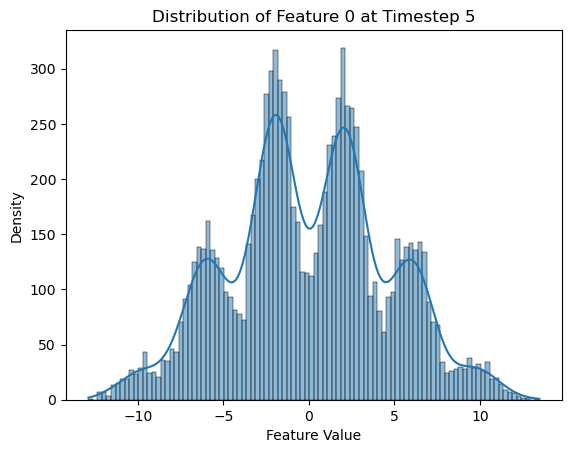

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of feature 0 at timestep 5 across all 10,000 sequences
timestep = 5
feature = 0

values = train_data[:, timestep, feature]

sns.histplot(values, bins=100, kde=True)
plt.title(f"Distribution of Feature {feature} at Timestep {timestep}")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

In [3]:
# Load CSV
loaded_df = pd.read_csv('synthetic_test_data.csv')

# Convert to numpy array
test_data = loaded_df.values

# Reshape back to (150, 24, 5)
test_data = test_data.reshape(150, 24, 5)

print("Loaded and reshaped test_data:", test_data.shape)

Loaded and reshaped test_data: (150, 24, 5)


# Import keypoints of 3883 training videos

In [3]:
with open("kp_train_3883_vox.pkl", "rb") as f:
    kp_time_series = pickle.load(f)
len(kp_time_series)

3883

# Convert list of keypoints to dictionary

In [4]:
for video_idx in range(len(kp_time_series)):
    kp_time_series[video_idx] = kp_time_series[video_idx]['kp']

kp_dict_init = []
for video_idx in range(len(kp_time_series)): # 
    init_mean = []
    init_jacobian = []
    for frame_idx in range(len(kp_time_series[video_idx])):
        kp_mean = kp_time_series[video_idx][frame_idx]['value'].reshape(1,10,2)
        kp_mean = torch.tensor(kp_mean)
        kp_jacobian = kp_time_series[video_idx][frame_idx]['jacobian'].reshape(1,10,2,2)
        kp_jacobian = torch.tensor(kp_jacobian)

        init_mean.append(kp_mean)
        init_jacobian.append(kp_jacobian)

    init_mean = torch.cat(init_mean)
    init_jacobian = torch.cat(init_jacobian)

    init_mean = torch.reshape(init_mean,(1,init_mean.shape[0],init_mean.shape[1],init_mean.shape[2]))
    init_jacobian = torch.reshape(init_jacobian,(1,init_jacobian.shape[0],10,2,2))

    if torch.cuda.is_available():
        # add tensor to cuda
        init_mean = init_mean.to('cuda:0')
        init_jacobian = init_jacobian.to('cuda:0')

    kp_dict_both = {"value":init_mean,"jacobian":init_jacobian}
    kp_dict_init.append(kp_dict_both)

# Apply min-max standardization to keypoints 

In [5]:
kp_list_train = []
for video_idx in range(len(kp_dict_init)):
    kp_one_video = torch.cat((kp_dict_init[video_idx]['value'], kp_dict_init[video_idx]['jacobian'].reshape(1,-1,10,4)),dim=-1).reshape(-1,60)
    kp_one_video_array = np.array(kp_one_video.cpu())
    kp_list_train.append(kp_one_video_array)

reduced_keypoint_list = [kp[::2] for kp in kp_list_train]
print(len(reduced_keypoint_list))
print(reduced_keypoint_list[0].shape)
    
#####  min-max std to 60 dimensions of selected one video ######
kp_list_train_std = []
min_list = []
range_list = []
for video_idx in range(len(reduced_keypoint_list)):
    min_values = np.min(reduced_keypoint_list[video_idx],axis=0) # 60 mins of one selected video in the loop
    max_values = np.max(reduced_keypoint_list[video_idx],axis=0) # 60 maxs of one selected video in the loop
    range_values = max_values - min_values 
    kp_one_video_std = (reduced_keypoint_list[video_idx] - min_values) / range_values
    kp_list_train_std.append(kp_one_video_std)
    min_list.append(min_values)
    range_list.append(range_values)

trajs = kp_list_train_std
print(len(trajs))
print(trajs[0].shape)

3883
(50, 60)
3883
(50, 60)


In [6]:
import numpy as np

# Initialize an empty list to store all series
all_series = []
# Initialize an empty list to track which video each series comes from
video_indices = []

# Loop through each video in kp_list_train_std
for video_idx, video in enumerate(kp_list_train_std):
    num_frames = video.shape[0]
    num_full_series = num_frames //24  # Number of full 24-frame series in this video

    # Collect each series of 24 frames
    for series_idx in range(num_full_series):
        start_frame = series_idx * 24
        end_frame = start_frame + 24
        series = video[start_frame:end_frame]  # Extract 24-frame series
        all_series.append(series)  # Append the 24-frame series to the list
        video_indices.append(video_idx)  # Append the video index for this series

# Convert `all_series` to a single numpy array with shape (total_series_count, 24, 60)
all_series = np.array(all_series)
video_indices = np.array(video_indices)  # Convert video indices to a numpy array

print(f"Shape of all_series: {all_series.shape}")  # Expected: (35325, 24, 60)
print(f"Shape of video_indices: {video_indices.shape}")  # Expected: (35325,)

Shape of all_series: (16752, 24, 60)
Shape of video_indices: (16752,)


In [7]:
start_idx = 0  # Start index for the first video

# Loop through each video in kp_list_train_std
for video_idx, video in enumerate(kp_list_train_std):
    num_frames = video.shape[0]
    num_full_series = num_frames // 12  # Number of full 24-frame series in this video

    # Calculate end index for the current video's series
    end_idx = start_idx + num_full_series - 1

    # Print the range for this video
    print(f"Video {video_idx + 1} is in series {start_idx + 1}-{end_idx + 1}")

    # Update the start index for the next video
    start_idx = end_idx + 1

Video 1 is in series 1-4
Video 2 is in series 5-10
Video 3 is in series 11-15
Video 4 is in series 16-20
Video 5 is in series 21-28
Video 6 is in series 29-32
Video 7 is in series 33-37
Video 8 is in series 38-45
Video 9 is in series 46-55
Video 10 is in series 56-61
Video 11 is in series 62-69
Video 12 is in series 70-74
Video 13 is in series 75-79
Video 14 is in series 80-83
Video 15 is in series 84-89
Video 16 is in series 90-98
Video 17 is in series 99-112
Video 18 is in series 113-117
Video 19 is in series 118-150
Video 20 is in series 151-169
Video 21 is in series 170-177
Video 22 is in series 178-196
Video 23 is in series 197-213
Video 24 is in series 214-220
Video 25 is in series 221-223
Video 26 is in series 224-232
Video 27 is in series 233-237
Video 28 is in series 238-243
Video 29 is in series 244-248
Video 30 is in series 249-252
Video 31 is in series 253-259
Video 32 is in series 260-268
Video 33 is in series 269-274
Video 34 is in series 275-278
Video 35 is in series 279

# Import keypoints of 44 VoxCeleb test videos

In [3]:
with open("kp_test_256_bair.pkl", "rb") as f:
    kp_time_series = pickle.load(f)
len(kp_time_series)

256

# Convert list of keypoints to dictionary

In [4]:
for video_idx in range(len(kp_time_series)):
    kp_time_series[video_idx] = kp_time_series[video_idx]['kp']

kp_dict_init = []
for video_idx in range(len(kp_time_series)): # 
    init_mean = []
    init_jacobian = []
    for frame_idx in range(len(kp_time_series[video_idx])):
        kp_mean = kp_time_series[video_idx][frame_idx]['value'].reshape(1,10,2)
        kp_mean = torch.tensor(kp_mean)
        kp_jacobian = kp_time_series[video_idx][frame_idx]['jacobian'].reshape(1,10,2,2)
        kp_jacobian = torch.tensor(kp_jacobian)

        init_mean.append(kp_mean)
        init_jacobian.append(kp_jacobian)

    init_mean = torch.cat(init_mean)
    init_jacobian = torch.cat(init_jacobian)

    init_mean = torch.reshape(init_mean,(1,init_mean.shape[0],init_mean.shape[1],init_mean.shape[2]))
    init_jacobian = torch.reshape(init_jacobian,(1,init_jacobian.shape[0],10,2,2))

    if torch.cuda.is_available():
        # add tensor to cuda
        init_mean = init_mean.to('cuda:0')
        init_jacobian = init_jacobian.to('cuda:0')

    kp_dict_both = {"value":init_mean,"jacobian":init_jacobian}
    kp_dict_init.append(kp_dict_both)

In [5]:
with open("kp_test_44_vox_source.pkl", "rb") as f:
    kp_time_series = pickle.load(f)
print(len(kp_time_series))

#convert list of keypoints to dictionary:
for video_idx in range(len(kp_time_series)):
    kp_time_series[video_idx] = kp_time_series[video_idx]['kp']

kp_dict_init = []
for video_idx in range(len(kp_time_series)): # 
    init_mean = []
    init_jacobian = []
    for frame_idx in range(len(kp_time_series[video_idx])):
        kp_mean = kp_time_series[video_idx][frame_idx]['value'].reshape(1,10,2)
        kp_mean = torch.tensor(kp_mean)
        kp_jacobian = kp_time_series[video_idx][frame_idx]['jacobian'].reshape(1,10,2,2)
        kp_jacobian = torch.tensor(kp_jacobian)

        init_mean.append(kp_mean)
        init_jacobian.append(kp_jacobian)

    init_mean = torch.cat(init_mean)
    init_jacobian = torch.cat(init_jacobian)

    init_mean = torch.reshape(init_mean,(1,init_mean.shape[0],init_mean.shape[1],init_mean.shape[2]))
    init_jacobian = torch.reshape(init_jacobian,(1,init_jacobian.shape[0],10,2,2))

    if torch.cuda.is_available():
        # add tensor to cuda
        init_mean = init_mean.to('cuda:0')
        init_jacobian = init_jacobian.to('cuda:0')

    kp_dict_both = {"value":init_mean,"jacobian":init_jacobian}
    kp_dict_init.append(kp_dict_both)
kp_list_test2 = []
for video_idx in range(len(kp_dict_init)):
    kp_one_video = torch.cat((kp_dict_init[video_idx]['value'], kp_dict_init[video_idx]['jacobian'].reshape(1,-1,10,4)),dim=-1).reshape(-1,60)
    kp_one_video_array = np.array(kp_one_video.cpu())
    kp_list_test2.append(kp_one_video_array)

44


# Apply min-max std to keypoints and convert to batches


In [5]:
kp_list_test = []
for video_idx in range(len(kp_dict_init)):
    kp_one_video = torch.cat((kp_dict_init[video_idx]['value'], kp_dict_init[video_idx]['jacobian'].reshape(1,-1,10,4)),dim=-1).reshape(-1,60)
    kp_one_video_array = np.array(kp_one_video.cpu())
    kp_list_test.append(kp_one_video_array)

reduced_keypoint_list_test = [kp[::2] for kp in kp_list_test]
print(len(reduced_keypoint_list_test))
print(reduced_keypoint_list_test[0].shape)
    
#####  min-max std to 60 dimensions of selected one video ######
kp_list_test_std = []
min_list = []
range_list = []
for video_idx in range(len(reduced_keypoint_list_test)):
    data = reduced_keypoint_list_test[video_idx]
    data_length = len(reduced_keypoint_list_test[video_idx])
    step_interval = 6 # choose between 12 frames or 24 frames 
    min_required_steps = 15 #2*step_interval
    selected_data = []
    for i in range(0, data_length - min_required_steps+1, min_required_steps):
        selected_data.extend(data[i:i + step_interval])
    min_values = np.min(selected_data,axis=0) # 60 mins of one selected video in the loop
    max_values = np.max(selected_data,axis=0) # 60 maxs of one selected video in the loop 
    range_values = max_values - min_values 
    kp_one_video_std = (reduced_keypoint_list_test[video_idx] - min_values) / range_values
    kp_list_test_std.append(kp_one_video_std)
    min_list.append(min_values)
    range_list.append(range_values)

test_trajs = kp_list_test_std
print(len(test_trajs))
print(test_trajs[0].shape)

256
(15, 60)
256
(15, 60)


In [6]:
import numpy as np

# Initialize an empty list to store all series
all_series_test = []
# Initialize an empty list to track which video each series comes from
video_indices_test = []

# Loop through each video in kp_list_train_std
for video_idx, video in enumerate(kp_list_test_std):
    num_frames = video.shape[0]
    num_full_series = num_frames // 15 # Number of full 24-frame series in this video

    # Collect each series of 24 frames
    for series_idx in range(num_full_series):
        start_frame = series_idx * 15
        end_frame = start_frame + 15
        series = video[start_frame:end_frame]  # Extract 24-frame series
        all_series_test.append(series)  # Append the 24-frame series to the list
        video_indices_test.append(video_idx)  # Append the video index for this series

# Convert `all_series` to a single numpy array with shape (total_series_count, 24, 60)
all_series_test = np.array(all_series_test)
video_indices_test = np.array(video_indices_test)  # Convert video indices to a numpy array

print(f"Shape of all_series: {all_series_test.shape}")  # Expected: (35325, 24, 60)
print(f"Shape of video_indices: {video_indices_test.shape}")  # Expected: (35325,)

Shape of all_series: (256, 15, 60)
Shape of video_indices: (256,)


In [7]:
start_idx = 0  # Start index for the first video

# Loop through each video in kp_list_train_std
for video_idx, video in enumerate(kp_list_test_std):
    num_frames = video.shape[0]
    num_full_series = num_frames // 12  # Number of full 24-frame series in this video

    # Calculate end index for the current video's series
    end_idx = start_idx + num_full_series - 1

    # Print the range for this video
    print(f"Video {video_idx + 1} is in series {start_idx + 1}-{end_idx + 1}")

    # Update the start index for the next video
    start_idx = end_idx + 1

Video 1 is in series 1-9
Video 2 is in series 10-37
Video 3 is in series 38-52
Video 4 is in series 53-59
Video 5 is in series 60-95
Video 6 is in series 96-124
Video 7 is in series 125-161
Video 8 is in series 162-184
Video 9 is in series 185-198
Video 10 is in series 199-211
Video 11 is in series 212-221
Video 12 is in series 222-233
Video 13 is in series 234-302
Video 14 is in series 303-404
Video 15 is in series 405-419
Video 16 is in series 420-444
Video 17 is in series 445-460
Video 18 is in series 461-477
Video 19 is in series 478-528
Video 20 is in series 529-543
Video 21 is in series 544-578
Video 22 is in series 579-590
Video 23 is in series 591-624
Video 24 is in series 625-646
Video 25 is in series 647-671
Video 26 is in series 672-682
Video 27 is in series 683-699
Video 28 is in series 700-747
Video 29 is in series 748-765
Video 30 is in series 766-779
Video 31 is in series 780-804
Video 32 is in series 805-836
Video 33 is in series 837-857
Video 34 is in series 858-882
Vi

In [7]:
# Adjust start_time and time_delta
from torch.utils.data import Dataset

# Define start date and frequency
start_time = pd.Timestamp("1999-05-01 00:00:00", freq = "1s")  # Ensure freq is set
freq = "1s"

# Create the CustomDataset ensuring proper time intervals
class CustomDataset(Dataset):
    def __init__(self, features, start_date, freq):
        self.features = features
        self.start_date = start_date
        self.freq = freq
        self.timestamps = pd.date_range(start=self.start_date, periods=len(features), freq=self.freq)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        transposed_features = self.features[idx].T
        return {
            'start': self.timestamps[idx],  # Using pd.date_range for intervals with freq
            'target': transposed_features
        }

# Create the train, validation, and test datasets with proper time intervals
#train_ds = CustomDataset(features=all_series, start_date=start_time, freq="1s")
test_ds = CustomDataset(features=all_series_test, start_date=start_time, freq="1s")

/tmp/ipykernel_5020/1572361597.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_time = pd.Timestamp("1999-05-01 00:00:00", freq = "1s")  # Ensure freq is set


In [8]:
import os
current_directory = os.getcwd()  # This will print the current working directory
print(current_directory)

/home/jovyan/srinjoy-vol/Tasmiah_files/Motion-Transfer-Keypoints-Prediction/Keypoints_Prediction


In [8]:
import sys

# Add the directory containing your custom TempFlowEstimator to the Python path
sys.path.insert(0, '/home/jovyan/srinjoy-vol/Tasmiah_files/Motion-Transfer-Keypoints-Prediction/Keypoints_Prediction')

# Verify the path has been added
print(sys.path)

['/home/jovyan/srinjoy-vol/Tasmiah_files/Motion-Transfer-Keypoints-Prediction/Keypoints_Prediction', '/home/jovyan/srinjoy-vol/Tasmiah_files/Motion-Transfer-Keypoints-Prediction/Keypoints_Prediction', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages']


In [13]:
# evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  # target_agg_funcs={'sum': np.sum})
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from tempflow_estimator_tasmiah import TempFlowEstimator
from transformer_tempflow_estimator import TransformerTempFlowEstimator
from trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator				  
								  
estimator = TempFlowEstimator(
    target_dim=60,
    prediction_length=14,
    cell_type='GRU',
    num_layers = 3,
    num_cells = 512,
    flow_type="RealNVP",
    hidden_size=512,
    n_hidden=3,
    conditioning_length = 1,
    dropout_rate = 0.2,
    input_size=60,
    context_length=10,
    freq="1s",
    scaling=False,
    #dequantize=False,
    n_blocks=5,
    trainer=Trainer(device=device,
                    epochs=100,
                    learning_rate=1e-3,
                    #num_batches_per_epoch=100,
                    batch_size=64)
)

# estimator = TransformerTempFlowEstimator(
#     d_model=256,
#     num_heads=8,
#     input_size=60,
#     target_dim=60,
#     prediction_length=12,
#     context_length=12,
#     flow_type='RealNVP',
#     scaling=False,
#     dequantize=False,
#     freq="1s",
#     trainer=Trainer(
#         device=device,
#         epochs=100,
#         learning_rate=1e-4,
#         #num_batches_per_epoch=100,
#         batch_size=64,
#     )
# )
predictor = estimator.train(training_data=train_ds)

/opt/conda/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Using TempFlowEstimator from the correct file


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
  6%|█████████                                                                                                                                          | 3/49 [00:00<00:04, 10.16it/s, epoch=1/100, avg_loss=4.05]

Gradient Norm: 5.07291841506958
Gradient Norm: 6.161056041717529
Gradient Norm: 4.714336395263672
Gradient Norm: 7.522984981536865


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.24it/s, epoch=1/100, avg_loss=3.87]

Gradient Norm: 5.151906967163086
Gradient Norm: 6.223526477813721
Gradient Norm: 5.020832061767578
Gradient Norm: 5.5831475257873535


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 15.43it/s, epoch=1/100, avg_loss=3.79]

Gradient Norm: 5.245100021362305
Gradient Norm: 5.924537181854248
Gradient Norm: 5.798745155334473
Gradient Norm: 6.479184150695801


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 16.24it/s, epoch=1/100, avg_loss=3.24]

Gradient Norm: 6.0261993408203125
Gradient Norm: 5.356417179107666
Gradient Norm: 5.9048309326171875
Gradient Norm: 5.503161907196045
Gradient Norm: 6.3658127784729


 39%|████████████████████████████████████████████████████████▌                                                                                         | 19/49 [00:01<00:01, 17.15it/s, epoch=1/100, avg_loss=2.75]

Gradient Norm: 5.339847087860107
Gradient Norm: 6.720582485198975
Gradient Norm: 5.926018714904785
Gradient Norm: 4.958559513092041


 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 23/49 [00:01<00:01, 15.95it/s, epoch=1/100, avg_loss=2.71]

Gradient Norm: 4.8966383934021
Gradient Norm: 5.7044901847839355
Gradient Norm: 5.772456169128418


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/49 [00:01<00:01, 14.84it/s, epoch=1/100, avg_loss=2.93]

Gradient Norm: 5.954094886779785
Gradient Norm: 4.990670680999756
Gradient Norm: 5.937427043914795


 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 29/49 [00:01<00:01, 14.70it/s, epoch=1/100, avg_loss=2.9]

Gradient Norm: 6.333067893981934
Gradient Norm: 5.229569435119629
Gradient Norm: 5.594333648681641


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 33/49 [00:02<00:01, 14.54it/s, epoch=1/100, avg_loss=2.97]

Gradient Norm: 6.881422519683838
Gradient Norm: 5.509987831115723
Gradient Norm: 4.9152960777282715


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 37/49 [00:02<00:00, 15.13it/s, epoch=1/100, avg_loss=2.86]

Gradient Norm: 5.2789692878723145
Gradient Norm: 6.555325984954834
Gradient Norm: 5.202481746673584
Gradient Norm: 5.959415912628174


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 15.75it/s, epoch=1/100, avg_loss=2.72]

Gradient Norm: 5.833736419677734
Gradient Norm: 5.730241298675537
Gradient Norm: 6.1886091232299805
Gradient Norm: 6.51675271987915


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/49 [00:02<00:00, 16.60it/s, epoch=1/100, avg_loss=2.81]

Gradient Norm: 6.063032150268555
Gradient Norm: 5.076142311096191
Gradient Norm: 4.863082408905029
Gradient Norm: 4.99412727355957


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.49it/s, epoch=1/100, avg_loss=2.82]

Gradient Norm: 5.260777950286865
Gradient Norm: 5.927006721496582
Gradient Norm: 5.46446418762207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.81it/s, epoch=1/100, avg_loss=2.78]


Gradient Norm: 4.922887802124023
Gradient Norm: 6.569214344024658
Epoch 1 completed in 3.31 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 5.017425537109375
Gradient Norm: 6.109196662902832


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 15.34it/s, epoch=2/100, avg_loss=2.55]

Gradient Norm: 4.662294864654541
Gradient Norm: 7.442546844482422
Gradient Norm: 5.103200912475586
Gradient Norm: 6.177621841430664


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.14it/s, epoch=2/100, avg_loss=3.13]

Gradient Norm: 4.979999542236328


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:03, 12.85it/s, epoch=2/100, avg_loss=3.77]

Gradient Norm: 5.5295844078063965
Gradient Norm: 5.202954292297363


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 13.58it/s, epoch=2/100, avg_loss=3.61]

Gradient Norm: 5.8851423263549805
Gradient Norm: 5.748168468475342


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 14.12it/s, epoch=2/100, avg_loss=3.69]

Gradient Norm: 6.416598320007324
Gradient Norm: 5.983856201171875


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 14.49it/s, epoch=2/100, avg_loss=3.52]

Gradient Norm: 5.299869060516357
Gradient Norm: 5.862049579620361


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 14.79it/s, epoch=2/100, avg_loss=3.14]

Gradient Norm: 5.463659763336182
Gradient Norm: 6.3166422843933105


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:02, 14.89it/s, epoch=2/100, avg_loss=3.03]

Gradient Norm: 5.308681488037109
Gradient Norm: 6.691170692443848


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 20/49 [00:01<00:01, 14.94it/s, epoch=2/100, avg_loss=2.61]

Gradient Norm: 5.8807783126831055


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 14.95it/s, epoch=2/100, avg_loss=2.64]

Gradient Norm: 4.935089111328125
Gradient Norm: 4.859824180603027
Gradient Norm: 5.668323516845703


 49%|████████████████████████████████████████████████████████████████████████                                                                           | 24/49 [00:01<00:01, 15.07it/s, epoch=2/100, avg_loss=2.7]

Gradient Norm: 5.714675426483154


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 15.24it/s, epoch=2/100, avg_loss=2.75]

Gradient Norm: 5.90717077255249
Gradient Norm: 4.944485187530518
Gradient Norm: 5.910141468048096
Gradient Norm: 6.285051345825195


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:02<00:01, 14.98it/s, epoch=2/100, avg_loss=2.78]

Gradient Norm: 5.184505462646484
Gradient Norm: 5.558838367462158
Gradient Norm: 6.837901592254639


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 32/49 [00:02<00:01, 15.32it/s, epoch=2/100, avg_loss=2.86]

Gradient Norm: 5.472139835357666


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 34/49 [00:02<00:00, 15.65it/s, epoch=2/100, avg_loss=2.83]

Gradient Norm: 4.8779730796813965
Gradient Norm: 5.237480163574219
Gradient Norm: 6.499166965484619


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 36/49 [00:02<00:00, 15.69it/s, epoch=2/100, avg_loss=2.77]

Gradient Norm: 5.169985771179199


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 15.48it/s, epoch=2/100, avg_loss=2.61]

Gradient Norm: 5.899389266967773
Gradient Norm: 5.802889823913574
Gradient Norm: 5.673357963562012


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/49 [00:02<00:00, 15.64it/s, epoch=2/100, avg_loss=2.61]

Gradient Norm: 6.154301166534424


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 42/49 [00:02<00:00, 15.71it/s, epoch=2/100, avg_loss=2.6]

Gradient Norm: 6.472332000732422
Gradient Norm: 6.006953239440918
Gradient Norm: 5.0332417488098145


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/49 [00:02<00:00, 16.03it/s, epoch=2/100, avg_loss=2.71]

Gradient Norm: 4.82255220413208


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:03<00:00, 17.10it/s, epoch=2/100, avg_loss=2.77]

Gradient Norm: 4.964869022369385
Gradient Norm: 5.2136735916137695
Gradient Norm: 5.861842155456543
Gradient Norm: 5.426572322845459


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.03it/s, epoch=2/100, avg_loss=2.68]


Gradient Norm: 4.885012626647949
Gradient Norm: 6.520536422729492
Epoch 2 completed in 3.26 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 4.969353199005127


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:02, 15.71it/s, epoch=3/100, avg_loss=2.74]

Gradient Norm: 6.062229633331299


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 15.72it/s, epoch=3/100, avg_loss=2.45]

Gradient Norm: 4.613907337188721
Gradient Norm: 7.369701385498047
Gradient Norm: 5.060052394866943


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.72it/s, epoch=3/100, avg_loss=3.03]

Gradient Norm: 6.137344837188721


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.73it/s, epoch=3/100, avg_loss=3.66]

Gradient Norm: 4.946617603302002
Gradient Norm: 5.4836201667785645
Gradient Norm: 5.164883613586426


 20%|██████████████████████████████                                                                                                                     | 10/49 [00:00<00:02, 15.73it/s, epoch=3/100, avg_loss=3.5]

Gradient Norm: 5.8492207527160645


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 15.72it/s, epoch=3/100, avg_loss=3.58]

Gradient Norm: 5.695855140686035
Gradient Norm: 6.360764026641846
Gradient Norm: 5.945964813232422


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 15.71it/s, epoch=3/100, avg_loss=3.42]

Gradient Norm: 5.2466959953308105


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.70it/s, epoch=3/100, avg_loss=3.03]

Gradient Norm: 5.824585437774658
Gradient Norm: 5.428974151611328
Gradient Norm: 6.267229080200195


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:01, 15.70it/s, epoch=3/100, avg_loss=2.92]

Gradient Norm: 5.283119201660156


 41%|████████████████████████████████████████████████████████████                                                                                       | 20/49 [00:01<00:01, 15.73it/s, epoch=3/100, avg_loss=2.5]

Gradient Norm: 6.664033889770508
Gradient Norm: 5.839879035949707
Gradient Norm: 4.917524337768555


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 15.74it/s, epoch=3/100, avg_loss=2.54]

Gradient Norm: 4.827983856201172


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 24/49 [00:01<00:01, 15.74it/s, epoch=3/100, avg_loss=2.59]

Gradient Norm: 5.633338451385498
Gradient Norm: 5.659465312957764
Gradient Norm: 5.862604141235352


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 15.72it/s, epoch=3/100, avg_loss=2.65]

Gradient Norm: 4.904088973999023


 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 28/49 [00:01<00:01, 15.74it/s, epoch=3/100, avg_loss=2.67]

Gradient Norm: 5.889063358306885
Gradient Norm: 6.238414764404297
Gradient Norm: 5.14180326461792


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 32/49 [00:02<00:01, 15.44it/s, epoch=3/100, avg_loss=2.75]

Gradient Norm: 5.526318073272705
Gradient Norm: 6.799102783203125
Gradient Norm: 5.439342975616455
Gradient Norm: 4.842459201812744


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 38/49 [00:02<00:00, 20.35it/s, epoch=3/100, avg_loss=2.5]

Gradient Norm: 5.199187278747559
Gradient Norm: 6.44597864151001
Gradient Norm: 5.140514373779297
Gradient Norm: 5.840883255004883
Gradient Norm: 5.773895263671875
Gradient Norm: 5.6222381591796875
Gradient Norm: 6.131485939025879


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/49 [00:02<00:00, 24.98it/s, epoch=3/100, avg_loss=2.49]

Gradient Norm: 6.431568622589111
Gradient Norm: 5.950253009796143
Gradient Norm: 4.996533393859863
Gradient Norm: 4.787669658660889


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/49 [00:02<00:00, 22.86it/s, epoch=3/100, avg_loss=2.66]

Gradient Norm: 4.940913677215576


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 20.17it/s, epoch=3/100, avg_loss=2.62]

Gradient Norm: 5.168768882751465
Gradient Norm: 5.800118446350098
Gradient Norm: 5.391232967376709
Gradient Norm: 4.848386287689209


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.99it/s, epoch=3/100, avg_loss=2.57]


Gradient Norm: 6.480972766876221
Epoch 3 completed in 2.89 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:02, 16.74it/s, epoch=4/100, avg_loss=2.62]

Gradient Norm: 4.924948692321777
Gradient Norm: 6.020712852478027
Gradient Norm: 4.5669846534729


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 17.36it/s, epoch=4/100, avg_loss=2.32]

Gradient Norm: 7.297738552093506


 12%|██████████████████                                                                                                                                  | 6/49 [00:00<00:02, 17.02it/s, epoch=4/100, avg_loss=2.9]

Gradient Norm: 5.022630214691162
Gradient Norm: 6.104869365692139
Gradient Norm: 4.917466163635254
Gradient Norm: 5.440373420715332


 18%|███████████████████████████                                                                                                                        | 9/49 [00:00<00:01, 21.31it/s, epoch=4/100, avg_loss=3.21]

Gradient Norm: 5.1318769454956055
Gradient Norm: 5.819011688232422


 27%|██████████████████████████████████████▋                                                                                                           | 13/49 [00:00<00:01, 24.60it/s, epoch=4/100, avg_loss=3.34]

Gradient Norm: 5.644108772277832
Gradient Norm: 6.308398723602295
Gradient Norm: 5.913995265960693
Gradient Norm: 5.199915409088135
Gradient Norm: 5.795576572418213
Gradient Norm: 5.3959197998046875


 35%|██████████████████████████████████████████████████▋                                                                                               | 17/49 [00:00<00:01, 25.91it/s, epoch=4/100, avg_loss=2.91]

Gradient Norm: 6.2219014167785645
Gradient Norm: 5.263223171234131
Gradient Norm: 6.641751289367676


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 20/49 [00:00<00:01, 21.83it/s, epoch=4/100, avg_loss=2.37]

Gradient Norm: 5.806393146514893
Gradient Norm: 4.903748989105225
Gradient Norm: 4.800167560577393


 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 23/49 [00:01<00:01, 20.94it/s, epoch=4/100, avg_loss=2.38]

Gradient Norm: 5.60154914855957
Gradient Norm: 5.610721111297607


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 19.42it/s, epoch=4/100, avg_loss=2.52]

Gradient Norm: 5.824214458465576
Gradient Norm: 4.87277889251709
Gradient Norm: 5.87789249420166


 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 28/49 [00:01<00:01, 19.14it/s, epoch=4/100, avg_loss=2.54]

Gradient Norm: 6.194933891296387
Gradient Norm: 5.103121757507324
Gradient Norm: 5.50238037109375


 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 31/49 [00:01<00:00, 19.06it/s, epoch=4/100, avg_loss=2.52]

Gradient Norm: 6.7766900062561035


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 33/49 [00:01<00:00, 18.45it/s, epoch=4/100, avg_loss=2.63]

Gradient Norm: 5.412682056427002
Gradient Norm: 4.810997009277344
Gradient Norm: 5.168079376220703


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:01<00:00, 17.80it/s, epoch=4/100, avg_loss=2.58]

Gradient Norm: 6.398182392120361


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 37/49 [00:01<00:00, 17.20it/s, epoch=4/100, avg_loss=2.53]

Gradient Norm: 5.116392135620117
Gradient Norm: 5.786488056182861
Gradient Norm: 5.751459121704102


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 16.72it/s, epoch=4/100, avg_loss=2.39]

Gradient Norm: 5.574619293212891


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 41/49 [00:02<00:00, 17.09it/s, epoch=4/100, avg_loss=2.32]

Gradient Norm: 6.122401237487793
Gradient Norm: 6.399355411529541
Gradient Norm: 5.897161960601807


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 43/49 [00:02<00:00, 16.60it/s, epoch=4/100, avg_loss=2.4]

Gradient Norm: 4.966872692108154


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/49 [00:02<00:00, 16.23it/s, epoch=4/100, avg_loss=2.53]

Gradient Norm: 4.759885311126709
Gradient Norm: 4.92672061920166
Gradient Norm: 5.1349334716796875


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.10it/s, epoch=4/100, avg_loss=2.52]

Gradient Norm: 5.748452186584473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 15.76it/s, epoch=4/100, avg_loss=2.49]

Gradient Norm: 5.357944488525391
Gradient Norm: 4.816834926605225
Gradient Norm: 6.4614057540893555


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.99it/s, epoch=4/100, avg_loss=2.44]


Epoch 4 completed in 2.72 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:02, 15.68it/s, epoch=5/100, avg_loss=2.46]

Gradient Norm: 4.888446807861328
Gradient Norm: 5.984119415283203
Gradient Norm: 4.52716588973999


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 16.02it/s, epoch=5/100, avg_loss=2.16]

Gradient Norm: 7.23568058013916


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.43it/s, epoch=5/100, avg_loss=2.74]

Gradient Norm: 4.999826431274414
Gradient Norm: 6.0849103927612305
Gradient Norm: 4.900436878204346


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.96it/s, epoch=5/100, avg_loss=3.38]

Gradient Norm: 5.410237789154053


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 16.36it/s, epoch=5/100, avg_loss=3.22]

Gradient Norm: 5.111656188964844
Gradient Norm: 5.798828601837158
Gradient Norm: 5.599070072174072


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 16.04it/s, epoch=5/100, avg_loss=3.29]

Gradient Norm: 6.271623611450195


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 15.81it/s, epoch=5/100, avg_loss=3.13]

Gradient Norm: 5.894309997558594
Gradient Norm: 5.163288116455078
Gradient Norm: 5.785611152648926
Gradient Norm: 5.374410152435303


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:02, 15.49it/s, epoch=5/100, avg_loss=2.63]

Gradient Norm: 6.183441162109375
Gradient Norm: 5.253335475921631
Gradient Norm: 6.626556873321533


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 20/49 [00:01<00:01, 15.61it/s, epoch=5/100, avg_loss=2.21]

Gradient Norm: 5.787989616394043


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 15.19it/s, epoch=5/100, avg_loss=2.25]

Gradient Norm: 4.901584148406982
Gradient Norm: 4.78506326675415
Gradient Norm: 5.5803632736206055


 49%|████████████████████████████████████████████████████████████████████████                                                                           | 24/49 [00:01<00:01, 15.56it/s, epoch=5/100, avg_loss=2.3]

Gradient Norm: 5.57066535949707


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 15.55it/s, epoch=5/100, avg_loss=2.36]

Gradient Norm: 5.801705837249756
Gradient Norm: 4.856632709503174
Gradient Norm: 5.87947416305542


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 15.28it/s, epoch=5/100, avg_loss=2.39]

Gradient Norm: 6.160641193389893
Gradient Norm: 5.072813034057617
Gradient Norm: 5.498019218444824
Gradient Norm: 6.782583713531494


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:02<00:00, 17.85it/s, epoch=5/100, avg_loss=2.41]

Gradient Norm: 5.3998517990112305
Gradient Norm: 4.78670072555542
Gradient Norm: 5.15358304977417
Gradient Norm: 6.361680507659912


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 16.83it/s, epoch=5/100, avg_loss=2.23]

Gradient Norm: 5.098639011383057
Gradient Norm: 5.745015621185303
Gradient Norm: 5.740336894989014
Gradient Norm: 5.538491249084473


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 41/49 [00:02<00:00, 16.46it/s, epoch=5/100, avg_loss=2.15]

Gradient Norm: 6.139928340911865
Gradient Norm: 6.387351036071777
Gradient Norm: 5.853281497955322


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/49 [00:02<00:00, 15.62it/s, epoch=5/100, avg_loss=2.37]

Gradient Norm: 4.956639766693115
Gradient Norm: 4.749174118041992
Gradient Norm: 4.933620452880859
Gradient Norm: 5.116520881652832


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.64it/s, epoch=5/100, avg_loss=2.27]


Gradient Norm: 5.719692230224609
Gradient Norm: 5.339761734008789
Gradient Norm: 4.79672908782959
Gradient Norm: 6.475039958953857
Epoch 5 completed in 3.13 seconds.


 14%|█████████████████████                                                                                                                              | 7/49 [00:00<00:01, 32.95it/s, epoch=6/100, avg_loss=3.16]

Gradient Norm: 4.8748979568481445
Gradient Norm: 5.968031883239746
Gradient Norm: 4.507277488708496
Gradient Norm: 7.196720600128174
Gradient Norm: 4.998025417327881
Gradient Norm: 6.095323085784912
Gradient Norm: 4.910215854644775


 22%|████████████████████████████████▊                                                                                                                 | 11/49 [00:00<00:01, 21.84it/s, epoch=6/100, avg_loss=2.94]

Gradient Norm: 5.402726173400879
Gradient Norm: 5.113337516784668
Gradient Norm: 5.800905704498291
Gradient Norm: 5.574774742126465


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:01, 19.29it/s, epoch=6/100, avg_loss=2.92]

Gradient Norm: 6.264208793640137
Gradient Norm: 5.902679443359375
Gradient Norm: 5.15077543258667
Gradient Norm: 5.809228420257568


 39%|████████████████████████████████████████████████████████▌                                                                                         | 19/49 [00:00<00:01, 17.27it/s, epoch=6/100, avg_loss=2.05]

Gradient Norm: 5.3778557777404785
Gradient Norm: 6.164559364318848
Gradient Norm: 5.269287109375
Gradient Norm: 6.627840518951416


 43%|██████████████████████████████████████████████████████████████▌                                                                                   | 21/49 [00:01<00:01, 16.69it/s, epoch=6/100, avg_loss=2.02]

Gradient Norm: 5.799475193023682
Gradient Norm: 4.916647434234619
Gradient Norm: 4.798701763153076


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 25/49 [00:01<00:01, 15.84it/s, epoch=6/100, avg_loss=2.09]

Gradient Norm: 5.581789970397949
Gradient Norm: 5.558879375457764
Gradient Norm: 5.810006618499756
Gradient Norm: 4.866923809051514


 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 29/49 [00:01<00:01, 14.58it/s, epoch=6/100, avg_loss=2.21]

Gradient Norm: 5.910615921020508
Gradient Norm: 6.151692867279053
Gradient Norm: 5.069443225860596


 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 31/49 [00:01<00:01, 13.07it/s, epoch=6/100, avg_loss=2.15]

Gradient Norm: 5.5202460289001465
Gradient Norm: 6.840495586395264
Gradient Norm: 5.416639804840088


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:02<00:00, 14.35it/s, epoch=6/100, avg_loss=2.21]

Gradient Norm: 4.785120010375977
Gradient Norm: 5.169195652008057
Gradient Norm: 6.359772682189941
Gradient Norm: 5.0968708992004395


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 15.04it/s, epoch=6/100, avg_loss=2.02]

Gradient Norm: 5.733176231384277
Gradient Norm: 5.756256580352783
Gradient Norm: 5.53234338760376
Gradient Norm: 6.211909294128418


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 43/49 [00:02<00:00, 15.59it/s, epoch=6/100, avg_loss=2.03]

Gradient Norm: 6.413817405700684
Gradient Norm: 5.84224796295166
Gradient Norm: 4.986700534820557
Gradient Norm: 4.766608715057373


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.70it/s, epoch=6/100, avg_loss=2.14]

Gradient Norm: 4.9686808586120605
Gradient Norm: 5.133095741271973
Gradient Norm: 5.737857818603516
Gradient Norm: 5.347264766693115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.20it/s, epoch=6/100, avg_loss=2.06]


Gradient Norm: 4.796347141265869
Gradient Norm: 6.552821636199951
Epoch 6 completed in 3.03 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 4.88859224319458


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:03, 14.92it/s, epoch=7/100, avg_loss=2.01]

Gradient Norm: 5.988158226013184
Gradient Norm: 4.521179676055908
Gradient Norm: 7.202278137207031


 10%|███████████████                                                                                                                                    | 5/49 [00:00<00:02, 17.58it/s, epoch=7/100, avg_loss=1.86]

Gradient Norm: 5.042233943939209


 14%|█████████████████████                                                                                                                              | 7/49 [00:00<00:02, 16.36it/s, epoch=7/100, avg_loss=2.91]

Gradient Norm: 6.147042751312256
Gradient Norm: 4.9617228507995605
Gradient Norm: 5.449674606323242


 18%|███████████████████████████                                                                                                                        | 9/49 [00:00<00:02, 15.79it/s, epoch=7/100, avg_loss=2.61]

Gradient Norm: 5.167112350463867
Gradient Norm: 5.853821754455566


 22%|████████████████████████████████▊                                                                                                                 | 11/49 [00:00<00:02, 15.44it/s, epoch=7/100, avg_loss=2.69]

Gradient Norm: 5.585334300994873


 27%|██████████████████████████████████████▋                                                                                                           | 13/49 [00:00<00:02, 15.45it/s, epoch=7/100, avg_loss=2.72]

Gradient Norm: 6.319262504577637
Gradient Norm: 5.953195571899414
Gradient Norm: 5.192222595214844
Gradient Norm: 5.884705543518066


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:00<00:01, 18.51it/s, epoch=7/100, avg_loss=2.28]

Gradient Norm: 5.435728549957275


 39%|█████████████████████████████████████████████████████████                                                                                          | 19/49 [00:01<00:01, 20.83it/s, epoch=7/100, avg_loss=1.8]

Gradient Norm: 6.188605785369873
Gradient Norm: 5.326842784881592
Gradient Norm: 6.666102409362793
Gradient Norm: 5.864250659942627
Gradient Norm: 4.9717793464660645


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 23.22it/s, epoch=7/100, avg_loss=1.79]

Gradient Norm: 4.847877502441406
Gradient Norm: 5.622686862945557


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 25/49 [00:01<00:00, 24.91it/s, epoch=7/100, avg_loss=1.83]

Gradient Norm: 5.599801063537598
Gradient Norm: 5.868895053863525
Gradient Norm: 4.931398868560791
Gradient Norm: 5.997287750244141
Gradient Norm: 6.186649799346924


 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 29/49 [00:01<00:00, 28.55it/s, epoch=7/100, avg_loss=1.95]

Gradient Norm: 5.105936050415039


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 32/49 [00:01<00:00, 22.68it/s, epoch=7/100, avg_loss=2]

Gradient Norm: 5.588927745819092
Gradient Norm: 6.9795098304748535
Gradient Norm: 5.476682186126709
Gradient Norm: 4.822494029998779


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:01<00:00, 19.72it/s, epoch=7/100, avg_loss=1.95]

Gradient Norm: 5.239893913269043
Gradient Norm: 6.417270183563232
Gradient Norm: 5.119632244110107


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:01<00:00, 18.01it/s, epoch=7/100, avg_loss=1.74]

Gradient Norm: 5.770231246948242
Gradient Norm: 5.814813613891602
Gradient Norm: 5.571964740753174


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/49 [00:02<00:00, 16.54it/s, epoch=7/100, avg_loss=1.72]

Gradient Norm: 6.369572639465332
Gradient Norm: 6.491109848022461
Gradient Norm: 5.8881754875183105
Gradient Norm: 5.0721116065979


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46/49 [00:02<00:00, 15.88it/s, epoch=7/100, avg_loss=1.9]

Gradient Norm: 4.833780765533447
Gradient Norm: 5.053631782531738
Gradient Norm: 5.198342800140381
Gradient Norm: 5.810692310333252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.70it/s, epoch=7/100, avg_loss=1.79]


Gradient Norm: 5.399815082550049
Gradient Norm: 4.833194255828857
Gradient Norm: 6.708413124084473
Epoch 7 completed in 2.77 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:03, 14.90it/s, epoch=8/100, avg_loss=1.69]

Gradient Norm: 4.954423427581787
Gradient Norm: 6.059885501861572
Gradient Norm: 4.580201625823975
Gradient Norm: 7.2830657958984375


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 14.95it/s, epoch=8/100, avg_loss=1.97]

Gradient Norm: 5.133326530456543
Gradient Norm: 6.2647504806518555
Gradient Norm: 5.079078197479248
Gradient Norm: 5.567163944244385


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 15.25it/s, epoch=8/100, avg_loss=2.51]

Gradient Norm: 5.285175323486328
Gradient Norm: 5.975738525390625
Gradient Norm: 5.649176120758057
Gradient Norm: 6.456065654754639


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.59it/s, epoch=8/100, avg_loss=1.96]

Gradient Norm: 6.060628414154053
Gradient Norm: 5.295902252197266
Gradient Norm: 6.046080112457275
Gradient Norm: 5.553146839141846


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 20/49 [00:01<00:01, 15.50it/s, epoch=8/100, avg_loss=1.42]

Gradient Norm: 6.267657279968262
Gradient Norm: 5.436746120452881
Gradient Norm: 6.7472734451293945
Gradient Norm: 5.9960246086120605


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 24/49 [00:01<00:01, 15.63it/s, epoch=8/100, avg_loss=1.52]

Gradient Norm: 5.072123050689697
Gradient Norm: 4.950238227844238
Gradient Norm: 5.719517230987549
Gradient Norm: 5.7103657722473145


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/49 [00:01<00:01, 16.83it/s, epoch=8/100, avg_loss=1.65]

Gradient Norm: 5.994029998779297
Gradient Norm: 5.06010627746582
Gradient Norm: 6.153670787811279
Gradient Norm: 6.281418800354004


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 32/49 [00:01<00:00, 17.74it/s, epoch=8/100, avg_loss=1.66]

Gradient Norm: 5.204616546630859
Gradient Norm: 5.730768203735352
Gradient Norm: 7.219233989715576
Gradient Norm: 5.592709064483643
Gradient Norm: 4.9214653968811035


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:02<00:00, 18.58it/s, epoch=8/100, avg_loss=1.62]

Gradient Norm: 5.3863749504089355
Gradient Norm: 6.54611349105835
Gradient Norm: 5.187722206115723
Gradient Norm: 5.869878768920898


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/49 [00:02<00:00, 18.17it/s, epoch=8/100, avg_loss=1.41]

Gradient Norm: 5.922053337097168
Gradient Norm: 5.685427188873291
Gradient Norm: 6.621025085449219
Gradient Norm: 6.659638404846191


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/49 [00:02<00:00, 16.62it/s, epoch=8/100, avg_loss=1.49]

Gradient Norm: 6.011594772338867
Gradient Norm: 5.240306854248047
Gradient Norm: 4.978589057922363


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46/49 [00:02<00:00, 16.09it/s, epoch=8/100, avg_loss=1.56]

Gradient Norm: 5.216803073883057
Gradient Norm: 5.342469692230225
Gradient Norm: 5.973614692687988
Gradient Norm: 5.504387378692627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.94it/s, epoch=8/100, avg_loss=1.45]


Gradient Norm: 4.925720691680908
Gradient Norm: 7.002348899841309
Epoch 8 completed in 3.08 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:03, 15.54it/s, epoch=9/100, avg_loss=1.29]

Gradient Norm: 5.098940372467041
Gradient Norm: 6.216032981872559
Gradient Norm: 4.715734481811523
Gradient Norm: 7.473466396331787


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.36it/s, epoch=9/100, avg_loss=1.56]

Gradient Norm: 5.314444065093994
Gradient Norm: 6.487461566925049
Gradient Norm: 5.2934489250183105
Gradient Norm: 5.789331436157227


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.14it/s, epoch=9/100, avg_loss=2.19]

Gradient Norm: 5.497849464416504
Gradient Norm: 6.1889262199401855


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 15.23it/s, epoch=9/100, avg_loss=2.03]

Gradient Norm: 5.801145076751709


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 13.05it/s, epoch=9/100, avg_loss=2.09]

Gradient Norm: 6.716245174407959
Gradient Norm: 6.257774829864502


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 13.43it/s, epoch=9/100, avg_loss=1.92]

Gradient Norm: 5.489196300506592


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 14.56it/s, epoch=9/100, avg_loss=1.54]

Gradient Norm: 6.298966407775879
Gradient Norm: 5.777656078338623
Gradient Norm: 6.4345316886901855


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:02, 15.01it/s, epoch=9/100, avg_loss=1.43]

Gradient Norm: 5.632399559020996


 41%|███████████████████████████████████████████████████████████▏                                                                                     | 20/49 [00:01<00:01, 15.47it/s, epoch=9/100, avg_loss=0.996]

Gradient Norm: 6.905483245849609
Gradient Norm: 6.228207111358643
Gradient Norm: 5.246881008148193


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 15.51it/s, epoch=9/100, avg_loss=1.05]

Gradient Norm: 5.1446404457092285


 49%|████████████████████████████████████████████████████████████████████████                                                                           | 24/49 [00:01<00:01, 15.47it/s, epoch=9/100, avg_loss=1.1]

Gradient Norm: 5.893792152404785
Gradient Norm: 5.939295291900635
Gradient Norm: 6.230489253997803


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 15.44it/s, epoch=9/100, avg_loss=1.15]

Gradient Norm: 5.305360317230225


 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 28/49 [00:01<00:01, 15.62it/s, epoch=9/100, avg_loss=1.16]

Gradient Norm: 6.421777248382568
Gradient Norm: 6.45688009262085
Gradient Norm: 5.390363693237305


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 15.61it/s, epoch=9/100, avg_loss=1.18]

Gradient Norm: 5.962724208831787


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 32/49 [00:02<00:01, 15.65it/s, epoch=9/100, avg_loss=1.23]

Gradient Norm: 7.628477096557617
Gradient Norm: 5.805798530578613
Gradient Norm: 5.096131324768066


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 36/49 [00:02<00:00, 15.15it/s, epoch=9/100, avg_loss=1.15]

Gradient Norm: 5.646852016448975
Gradient Norm: 6.784592628479004
Gradient Norm: 5.3173112869262695


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 38/49 [00:02<00:00, 14.95it/s, epoch=9/100, avg_loss=0.983]

Gradient Norm: 6.074717044830322
Gradient Norm: 6.116089344024658
Gradient Norm: 5.901773929595947


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/49 [00:02<00:00, 14.83it/s, epoch=9/100, avg_loss=0.942]

Gradient Norm: 7.043182373046875
Gradient Norm: 6.9592180252075195
Gradient Norm: 6.242612838745117


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/49 [00:02<00:00, 14.69it/s, epoch=9/100, avg_loss=1.05]

Gradient Norm: 5.520270347595215
Gradient Norm: 5.233386516571045
Gradient Norm: 5.475306510925293


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 14.18it/s, epoch=9/100, avg_loss=1.06]

Gradient Norm: 5.583874702453613
Gradient Norm: 6.263844013214111
Gradient Norm: 5.686661720275879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.58it/s, epoch=9/100, avg_loss=1]


Gradient Norm: 5.085648536682129
Gradient Norm: 7.506154537200928
Epoch 9 completed in 3.36 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 5.354572772979736
Gradient Norm: 6.497365951538086


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.07it/s, epoch=10/100, avg_loss=0.766]

Gradient Norm: 4.941860198974609


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.88it/s, epoch=10/100, avg_loss=0.469]

Gradient Norm: 7.817067623138428
Gradient Norm: 5.615327835083008


 12%|█████████████████▉                                                                                                                                | 6/49 [00:00<00:02, 14.83it/s, epoch=10/100, avg_loss=1.02]

Gradient Norm: 6.859676361083984
Gradient Norm: 5.636202812194824


 16%|███████████████████████▊                                                                                                                          | 8/49 [00:00<00:02, 15.01it/s, epoch=10/100, avg_loss=1.65]

Gradient Norm: 6.150140762329102
Gradient Norm: 5.829272747039795


 20%|█████████████████████████████▌                                                                                                                   | 10/49 [00:00<00:02, 15.08it/s, epoch=10/100, avg_loss=1.48]

Gradient Norm: 6.545340061187744


 24%|███████████████████████████████████▌                                                                                                             | 12/49 [00:00<00:02, 14.96it/s, epoch=10/100, avg_loss=1.54]

Gradient Norm: 6.059026718139648
Gradient Norm: 7.147868633270264


 29%|█████████████████████████████████████████▍                                                                                                       | 14/49 [00:00<00:02, 15.11it/s, epoch=10/100, avg_loss=1.37]

Gradient Norm: 6.589289665222168
Gradient Norm: 5.80585241317749


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.12it/s, epoch=10/100, avg_loss=0.982]

Gradient Norm: 6.696744918823242
Gradient Norm: 6.120837688446045


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.13it/s, epoch=10/100, avg_loss=0.878]

Gradient Norm: 6.718996524810791
Gradient Norm: 5.941081523895264


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.80it/s, epoch=10/100, avg_loss=0.439]

Gradient Norm: 7.168591022491455
Gradient Norm: 6.6042914390563965


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.71it/s, epoch=10/100, avg_loss=0.498]

Gradient Norm: 5.511289119720459
Gradient Norm: 5.444284915924072


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 20.53it/s, epoch=10/100, avg_loss=0.591]

Gradient Norm: 6.179989337921143
Gradient Norm: 6.3215250968933105
Gradient Norm: 6.601779937744141
Gradient Norm: 5.671293258666992
Gradient Norm: 6.8505024909973145


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 18.99it/s, epoch=10/100, avg_loss=0.634]

Gradient Norm: 6.749901294708252
Gradient Norm: 5.680630207061768
Gradient Norm: 6.314254283905029


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 18.62it/s, epoch=10/100, avg_loss=0.559]

Gradient Norm: 8.289419174194336


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 17.69it/s, epoch=10/100, avg_loss=0.682]

Gradient Norm: 6.142169952392578
Gradient Norm: 5.375522136688232
Gradient Norm: 6.021894454956055


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 17.36it/s, epoch=10/100, avg_loss=0.619]

Gradient Norm: 7.170063495635986


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 16.87it/s, epoch=10/100, avg_loss=0.571]

Gradient Norm: 5.538059711456299
Gradient Norm: 6.418416500091553
Gradient Norm: 6.41255521774292


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 17.44it/s, epoch=10/100, avg_loss=0.428]

Gradient Norm: 6.256485939025879


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 17.77it/s, epoch=10/100, avg_loss=0.362]

Gradient Norm: 7.6712212562561035
Gradient Norm: 7.431260108947754
Gradient Norm: 6.6096320152282715
Gradient Norm: 5.9671125411987305


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 16.55it/s, epoch=10/100, avg_loss=0.469]

Gradient Norm: 5.6270880699157715
Gradient Norm: 5.870279788970947


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.70it/s, epoch=10/100, avg_loss=0.533]

Gradient Norm: 5.958322048187256


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 15.27it/s, epoch=10/100, avg_loss=0.471]

Gradient Norm: 6.712775707244873
Gradient Norm: 5.978495121002197
Gradient Norm: 5.346449851989746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.90it/s, epoch=10/100, avg_loss=0.408]


Gradient Norm: 8.267416954040527
Epoch 10 completed in 3.08 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 5.7612433433532715


  4%|█████▉                                                                                                                                          | 2/49 [00:00<00:03, 14.23it/s, epoch=11/100, avg_loss=0.0685]

Gradient Norm: 6.946035385131836
Gradient Norm: 5.291154384613037


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.14it/s, epoch=11/100, avg_loss=-.237]

Gradient Norm: 8.370138168334961
Gradient Norm: 6.073072910308838


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:03, 14.22it/s, epoch=11/100, avg_loss=0.299]

Gradient Norm: 7.469653129577637
Gradient Norm: 6.151264667510986


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.53it/s, epoch=11/100, avg_loss=0.922]

Gradient Norm: 6.721520900726318
Gradient Norm: 6.314487934112549
Gradient Norm: 7.103339195251465


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.64it/s, epoch=11/100, avg_loss=0.744]

Gradient Norm: 6.490452289581299


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 14.88it/s, epoch=11/100, avg_loss=0.791]

Gradient Norm: 7.856253147125244
Gradient Norm: 7.117679119110107


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.14it/s, epoch=11/100, avg_loss=0.617]

Gradient Norm: 6.284200668334961
Gradient Norm: 7.3301568031311035


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.31it/s, epoch=11/100, avg_loss=0.227]

Gradient Norm: 6.685048580169678
Gradient Norm: 7.184263706207275


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.50it/s, epoch=11/100, avg_loss=0.123]

Gradient Norm: 6.453554630279541
Gradient Norm: 7.618997097015381


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.45it/s, epoch=11/100, avg_loss=-.322]

Gradient Norm: 7.174130439758301
Gradient Norm: 5.953704833984375


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.44it/s, epoch=11/100, avg_loss=-.256]

Gradient Norm: 5.90398645401001
Gradient Norm: 6.6577606201171875


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.57it/s, epoch=11/100, avg_loss=-.211]

Gradient Norm: 6.948908805847168
Gradient Norm: 7.200502872467041


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.34it/s, epoch=11/100, avg_loss=-.173]

Gradient Norm: 6.248390197753906
Gradient Norm: 7.563508987426758


 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 28/49 [00:01<00:01, 15.53it/s, epoch=11/100, avg_loss=-.17]

Gradient Norm: 7.248323440551758
Gradient Norm: 6.1317620277404785


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.48it/s, epoch=11/100, avg_loss=-.157]

Gradient Norm: 6.848413944244385
Gradient Norm: 9.444506645202637


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 16.20it/s, epoch=11/100, avg_loss=-.116]

Gradient Norm: 6.704761028289795
Gradient Norm: 5.784890651702881


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.11it/s, epoch=11/100, avg_loss=-.133]

Gradient Norm: 6.604662895202637
Gradient Norm: 7.804764747619629


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.17it/s, epoch=11/100, avg_loss=-.201]

Gradient Norm: 5.950963973999023
Gradient Norm: 6.9892258644104


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 38/49 [00:02<00:00, 16.10it/s, epoch=11/100, avg_loss=-.37]

Gradient Norm: 6.9732441902160645
Gradient Norm: 6.853034973144531


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.58it/s, epoch=11/100, avg_loss=-.398]

Gradient Norm: 8.738572120666504
Gradient Norm: 8.286954879760742


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.85it/s, epoch=11/100, avg_loss=-.441]

Gradient Norm: 7.221472263336182
Gradient Norm: 6.797794342041016


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.92it/s, epoch=11/100, avg_loss=-.338]

Gradient Norm: 6.259803295135498
Gradient Norm: 6.524320602416992


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.43it/s, epoch=11/100, avg_loss=-.279]

Gradient Norm: 6.599721431732178
Gradient Norm: 7.445678234100342


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.77it/s, epoch=11/100, avg_loss=-.346]

Gradient Norm: 6.489747524261475
Gradient Norm: 5.8696675300598145


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.12it/s, epoch=11/100, avg_loss=-.418]


Gradient Norm: 9.64429759979248
Epoch 11 completed in 3.24 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 6.490653038024902


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.51it/s, epoch=12/100, avg_loss=-.938]

Gradient Norm: 7.7631025314331055
Gradient Norm: 5.900353908538818


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.00it/s, epoch=12/100, avg_loss=-1.26]

Gradient Norm: 9.398615837097168
Gradient Norm: 6.857065677642822


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.38it/s, epoch=12/100, avg_loss=-.759]

Gradient Norm: 8.683318138122559
Gradient Norm: 7.0419511795043945


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.67it/s, epoch=12/100, avg_loss=-.151]

Gradient Norm: 7.770003795623779
Gradient Norm: 7.184000492095947


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.99it/s, epoch=12/100, avg_loss=-.344]

Gradient Norm: 8.188034057617188


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.40it/s, epoch=12/100, avg_loss=-.319]

Gradient Norm: 7.425341606140137
Gradient Norm: 9.24183177947998
Gradient Norm: 8.276834487915039


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.20it/s, epoch=12/100, avg_loss=-.908]

Gradient Norm: 7.172587871551514
Gradient Norm: 8.730992317199707
Gradient Norm: 7.912440776824951
Gradient Norm: 8.171183586120605


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.96it/s, epoch=12/100, avg_loss=-1.01]

Gradient Norm: 7.6766557693481445
Gradient Norm: 8.524351119995117


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 14.88it/s, epoch=12/100, avg_loss=-1.47]

Gradient Norm: 8.410676956176758
Gradient Norm: 7.239536285400391


 45%|█████████████████████████████████████████████████████████████████                                                                                | 22/49 [00:01<00:01, 15.17it/s, epoch=12/100, avg_loss=-1.4]

Gradient Norm: 6.859199047088623
Gradient Norm: 7.885239601135254


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.06it/s, epoch=12/100, avg_loss=-1.37]

Gradient Norm: 8.278145790100098


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 14.97it/s, epoch=12/100, avg_loss=-1.34]

Gradient Norm: 8.415685653686523
Gradient Norm: 7.4695281982421875


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.23it/s, epoch=12/100, avg_loss=-1.36]

Gradient Norm: 9.401260375976562
Gradient Norm: 8.452507019042969


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.07it/s, epoch=12/100, avg_loss=-1.35]

Gradient Norm: 7.073285102844238
Gradient Norm: 8.07716178894043


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.49it/s, epoch=12/100, avg_loss=-1.34]

Gradient Norm: 12.516422271728516
Gradient Norm: 8.095954895019531


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.28it/s, epoch=12/100, avg_loss=-1.35]

Gradient Norm: 6.396424293518066
Gradient Norm: 7.7224884033203125


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.34it/s, epoch=12/100, avg_loss=-1.43]

Gradient Norm: 9.14553165435791
Gradient Norm: 7.281793117523193
Gradient Norm: 8.347243309020996


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 14.79it/s, epoch=12/100, avg_loss=-1.61]

Gradient Norm: 8.785394668579102
Gradient Norm: 7.995359897613525


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.17it/s, epoch=12/100, avg_loss=-1.66]

Gradient Norm: 11.328340530395508
Gradient Norm: 10.478161811828613


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.38it/s, epoch=12/100, avg_loss=-1.72]

Gradient Norm: 8.63277530670166
Gradient Norm: 8.840420722961426


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.20it/s, epoch=12/100, avg_loss=-1.63]

Gradient Norm: 7.2794318199157715
Gradient Norm: 7.772644519805908


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 15.24it/s, epoch=12/100, avg_loss=-1.58]

Gradient Norm: 7.883131980895996
Gradient Norm: 8.569375991821289


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.10it/s, epoch=12/100, avg_loss=-1.66]

Gradient Norm: 7.450490474700928


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.91it/s, epoch=12/100, avg_loss=-1.75]


Gradient Norm: 7.259637355804443
Gradient Norm: 12.535365104675293
Epoch 12 completed in 3.29 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 8.216365814208984


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.43it/s, epoch=13/100, avg_loss=-2.73]

Gradient Norm: 9.744946479797363
Gradient Norm: 6.950926303863525
Gradient Norm: 11.41533374786377


 10%|██████████████▊                                                                                                                                  | 5/49 [00:00<00:02, 19.17it/s, epoch=13/100, avg_loss=-2.89]

Gradient Norm: 8.096878051757812
Gradient Norm: 11.369025230407715


 14%|█████████████████████▏                                                                                                                              | 7/49 [00:00<00:02, 17.21it/s, epoch=13/100, avg_loss=-2]

Gradient Norm: 7.9267096519470215


 18%|██████████████████████████▋                                                                                                                      | 9/49 [00:00<00:02, 16.44it/s, epoch=13/100, avg_loss=-2.34]

Gradient Norm: 9.078185081481934
Gradient Norm: 7.976016998291016
Gradient Norm: 9.62438678741455


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 16.49it/s, epoch=13/100, avg_loss=-2.31]

Gradient Norm: 9.092629432678223


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 16.57it/s, epoch=13/100, avg_loss=-2.42]

Gradient Norm: 11.144603729248047
Gradient Norm: 9.894639015197754
Gradient Norm: 8.38177490234375
Gradient Norm: 11.142452239990234


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:01<00:02, 15.85it/s, epoch=13/100, avg_loss=-2.91]

Gradient Norm: 9.230953216552734
Gradient Norm: 8.916175842285156
Gradient Norm: 10.071539878845215


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 15.70it/s, epoch=13/100, avg_loss=-3.42]

Gradient Norm: 9.171920776367188


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 15.57it/s, epoch=13/100, avg_loss=-3.49]

Gradient Norm: 9.72864055633545
Gradient Norm: 9.881397247314453
Gradient Norm: 7.432589054107666


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 15.52it/s, epoch=13/100, avg_loss=-3.47]

Gradient Norm: 8.468450546264648
Gradient Norm: 8.902847290039062
Gradient Norm: 7.90699577331543


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 15.38it/s, epoch=13/100, avg_loss=-3.46]

Gradient Norm: 7.943732738494873
Gradient Norm: 9.665245056152344


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 17.78it/s, epoch=13/100, avg_loss=-3.43]

Gradient Norm: 8.894664764404297
Gradient Norm: 6.927786350250244


 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 30/49 [00:01<00:01, 17.26it/s, epoch=13/100, avg_loss=-3.4]

Gradient Norm: 8.735947608947754
Gradient Norm: 12.007160186767578


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 17.93it/s, epoch=13/100, avg_loss=-3.43]

Gradient Norm: 9.73896312713623
Gradient Norm: 7.458855628967285


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 34/49 [00:02<00:00, 17.55it/s, epoch=13/100, avg_loss=-3.4]

Gradient Norm: 7.727424621582031
Gradient Norm: 9.395209312438965


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 17.14it/s, epoch=13/100, avg_loss=-3.48]

Gradient Norm: 8.28808879852295
Gradient Norm: 8.442148208618164


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.55it/s, epoch=13/100, avg_loss=-3.67]

Gradient Norm: 9.281946182250977
Gradient Norm: 7.843173503875732


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.95it/s, epoch=13/100, avg_loss=-3.73]

Gradient Norm: 11.285041809082031
Gradient Norm: 9.542612075805664


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 42/49 [00:02<00:00, 15.91it/s, epoch=13/100, avg_loss=-3.8]

Gradient Norm: 9.004186630249023
Gradient Norm: 8.916624069213867


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 44/49 [00:02<00:00, 15.95it/s, epoch=13/100, avg_loss=-3.7]

Gradient Norm: 7.119235038757324
Gradient Norm: 7.385080337524414


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.16it/s, epoch=13/100, avg_loss=-3.65]

Gradient Norm: 7.469221591949463
Gradient Norm: 8.075553894042969


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.14it/s, epoch=13/100, avg_loss=-3.7]

Gradient Norm: 8.49246883392334
Gradient Norm: 7.422720909118652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.09it/s, epoch=13/100, avg_loss=-3.81]


Gradient Norm: 11.406501770019531
Epoch 13 completed in 3.05 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 8.703071594238281


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.15it/s, epoch=14/100, avg_loss=-4.92]

Gradient Norm: 9.685677528381348
Gradient Norm: 6.899651527404785


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.10it/s, epoch=14/100, avg_loss=-5.12]

Gradient Norm: 10.791788101196289
Gradient Norm: 7.826841354370117


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.76it/s, epoch=14/100, avg_loss=-4.76]

Gradient Norm: 11.351492881774902
Gradient Norm: 7.026906967163086


 16%|███████████████████████▊                                                                                                                          | 8/49 [00:00<00:02, 16.10it/s, epoch=14/100, avg_loss=-4.1]

Gradient Norm: 8.753643989562988
Gradient Norm: 7.46251106262207


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.67it/s, epoch=14/100, avg_loss=-4.26]

Gradient Norm: 9.625812530517578
Gradient Norm: 9.024649620056152


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.51it/s, epoch=14/100, avg_loss=-4.34]

Gradient Norm: 10.428754806518555
Gradient Norm: 9.421119689941406


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.93it/s, epoch=14/100, avg_loss=-4.55]

Gradient Norm: 8.341814994812012
Gradient Norm: 11.09659481048584


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 16.82it/s, epoch=14/100, avg_loss=-5.03]

Gradient Norm: 8.355168342590332
Gradient Norm: 9.315661430358887


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 17.53it/s, epoch=14/100, avg_loss=-5.14]

Gradient Norm: 11.423412322998047
Gradient Norm: 10.083983421325684


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 17.38it/s, epoch=14/100, avg_loss=-5.62]

Gradient Norm: 10.145938873291016
Gradient Norm: 10.674059867858887


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.71it/s, epoch=14/100, avg_loss=-5.55]

Gradient Norm: 8.037016868591309
Gradient Norm: 8.173330307006836


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 20.19it/s, epoch=14/100, avg_loss=-5.55]

Gradient Norm: 8.831297874450684
Gradient Norm: 7.425861358642578
Gradient Norm: 8.405827522277832
Gradient Norm: 9.294264793395996


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:00, 21.99it/s, epoch=14/100, avg_loss=-5.52]

Gradient Norm: 9.182271003723145
Gradient Norm: 7.243677139282227
Gradient Norm: 9.199380874633789


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 25.96it/s, epoch=14/100, avg_loss=-5.52]

Gradient Norm: 10.828756332397461
Gradient Norm: 10.319067001342773
Gradient Norm: 8.970791816711426
Gradient Norm: 8.244913101196289
Gradient Norm: 10.36327838897705


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:01<00:00, 26.85it/s, epoch=14/100, avg_loss=-5.55]

Gradient Norm: 8.790196418762207


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:01<00:00, 24.02it/s, epoch=14/100, avg_loss=-5.71]

Gradient Norm: 9.015168190002441
Gradient Norm: 10.115579605102539
Gradient Norm: 8.665188789367676


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 19.55it/s, epoch=14/100, avg_loss=-5.88]

Gradient Norm: 11.688284873962402
Gradient Norm: 10.118447303771973
Gradient Norm: 9.513575553894043


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 18.49it/s, epoch=14/100, avg_loss=-5.72]

Gradient Norm: 9.176109313964844
Gradient Norm: 7.631171703338623
Gradient Norm: 8.21130657196045
Gradient Norm: 7.766257286071777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.30it/s, epoch=14/100, avg_loss=-5.88]


Gradient Norm: 8.274565696716309
Gradient Norm: 9.693489074707031
Gradient Norm: 8.055713653564453
Gradient Norm: 12.158163070678711
Epoch 14 completed in 2.68 seconds.


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.33it/s, epoch=15/100, avg_loss=-7.16]

Gradient Norm: 10.117545127868652
Gradient Norm: 10.264986991882324
Gradient Norm: 7.518558025360107
Gradient Norm: 11.940824508666992


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.66it/s, epoch=15/100, avg_loss=-6.23]

Gradient Norm: 8.50874137878418
Gradient Norm: 11.817983627319336
Gradient Norm: 7.59147310256958
Gradient Norm: 9.84808349609375


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.62it/s, epoch=15/100, avg_loss=-6.53]

Gradient Norm: 8.44984245300293
Gradient Norm: 10.652234077453613
Gradient Norm: 9.784281730651855
Gradient Norm: 10.88231372833252


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.29it/s, epoch=15/100, avg_loss=-7.24]

Gradient Norm: 10.32922077178955
Gradient Norm: 8.698355674743652
Gradient Norm: 11.46429443359375
Gradient Norm: 8.433320045471191


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.93it/s, epoch=15/100, avg_loss=-7.37]

Gradient Norm: 10.417685508728027
Gradient Norm: 13.162927627563477
Gradient Norm: 11.766240119934082


 45%|█████████████████████████████████████████████████████████████████                                                                                | 22/49 [00:01<00:01, 14.97it/s, epoch=15/100, avg_loss=-7.8]

Gradient Norm: 10.759156227111816
Gradient Norm: 11.614670753479004
Gradient Norm: 8.692806243896484


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.59it/s, epoch=15/100, avg_loss=-7.77]

Gradient Norm: 8.643667221069336
Gradient Norm: 9.19143009185791
Gradient Norm: 8.328770637512207


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.37it/s, epoch=15/100, avg_loss=-7.77]

Gradient Norm: 9.389907836914062
Gradient Norm: 9.694751739501953
Gradient Norm: 9.892849922180176


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.05it/s, epoch=15/100, avg_loss=-7.76]

Gradient Norm: 7.84099006652832
Gradient Norm: 10.186413764953613
Gradient Norm: 11.983905792236328
Gradient Norm: 11.028179168701172


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.29it/s, epoch=15/100, avg_loss=-7.71]

Gradient Norm: 10.350915908813477
Gradient Norm: 8.946852684020996
Gradient Norm: 11.70267105102539


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 14.84it/s, epoch=15/100, avg_loss=-7.99]

Gradient Norm: 9.42070198059082
Gradient Norm: 9.866934776306152
Gradient Norm: 11.490750312805176
Gradient Norm: 9.542253494262695


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.15it/s, epoch=15/100, avg_loss=-8.16]

Gradient Norm: 12.893057823181152
Gradient Norm: 11.397754669189453
Gradient Norm: 10.1454439163208
Gradient Norm: 9.831624031066895


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 14.99it/s, epoch=15/100, avg_loss=-7.99]

Gradient Norm: 8.051660537719727
Gradient Norm: 9.24208927154541
Gradient Norm: 8.323142051696777
Gradient Norm: 8.808638572692871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.83it/s, epoch=15/100, avg_loss=-8.17]


Gradient Norm: 10.806929588317871
Gradient Norm: 8.705821990966797
Gradient Norm: 13.145670890808105
Epoch 15 completed in 3.31 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 12.408820152282715


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.82it/s, epoch=16/100, avg_loss=-9.51]

Gradient Norm: 11.169697761535645
Gradient Norm: 8.746087074279785
Gradient Norm: 13.053922653198242
Gradient Norm: 9.59044075012207


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.36it/s, epoch=16/100, avg_loss=-8.64]

Gradient Norm: 12.843985557556152
Gradient Norm: 8.303349494934082
Gradient Norm: 10.925104141235352
Gradient Norm: 9.25766658782959
Gradient Norm: 11.248592376708984


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 18.88it/s, epoch=16/100, avg_loss=-8.97]

Gradient Norm: 10.868752479553223
Gradient Norm: 11.429104804992676


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 17.63it/s, epoch=16/100, avg_loss=-9.21]

Gradient Norm: 11.415755271911621


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.30it/s, epoch=16/100, avg_loss=-9.57]

Gradient Norm: 9.059800148010254
Gradient Norm: 12.034926414489746
Gradient Norm: 8.623041152954102


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 15.69it/s, epoch=16/100, avg_loss=-10.3]

Gradient Norm: 11.198095321655273
Gradient Norm: 15.002005577087402
Gradient Norm: 13.480791091918945
Gradient Norm: 11.301603317260742


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 15.52it/s, epoch=16/100, avg_loss=-10.3]

Gradient Norm: 12.585602760314941
Gradient Norm: 9.309708595275879
Gradient Norm: 9.30677318572998
Gradient Norm: 9.797136306762695


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 15.40it/s, epoch=16/100, avg_loss=-10.3]

Gradient Norm: 9.449509620666504
Gradient Norm: 11.09864330291748
Gradient Norm: 10.353096008300781


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 15.11it/s, epoch=16/100, avg_loss=-10.2]

Gradient Norm: 10.40794849395752
Gradient Norm: 8.351863861083984
Gradient Norm: 11.33530044555664


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 14.46it/s, epoch=16/100, avg_loss=-10.4]

Gradient Norm: 13.894488334655762
Gradient Norm: 11.770546913146973


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:01, 12.92it/s, epoch=16/100, avg_loss=-10.3]

Gradient Norm: 10.98367977142334
Gradient Norm: 9.743690490722656
Gradient Norm: 12.925374984741211


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 14.16it/s, epoch=16/100, avg_loss=-10.5]

Gradient Norm: 10.368875503540039
Gradient Norm: 10.462955474853516
Gradient Norm: 13.655692100524902
Gradient Norm: 10.171699523925781


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 14.85it/s, epoch=16/100, avg_loss=-10.7]

Gradient Norm: 14.545196533203125
Gradient Norm: 12.112048149108887
Gradient Norm: 10.915721893310547
Gradient Norm: 11.078377723693848


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:03<00:00, 15.77it/s, epoch=16/100, avg_loss=-10.5]

Gradient Norm: 8.576688766479492
Gradient Norm: 10.284100532531738
Gradient Norm: 8.88260269165039
Gradient Norm: 10.01064395904541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.95it/s, epoch=16/100, avg_loss=-10.7]


Gradient Norm: 11.700417518615723
Gradient Norm: 9.669858932495117
Gradient Norm: 13.58487319946289
Epoch 16 completed in 3.28 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 14.751900672912598


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.31it/s, epoch=17/100, avg_loss=-12.1]

Gradient Norm: 12.380393028259277
Gradient Norm: 10.142157554626465
Gradient Norm: 13.97262191772461
Gradient Norm: 10.589950561523438


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.77it/s, epoch=17/100, avg_loss=-11.3]

Gradient Norm: 14.35658073425293
Gradient Norm: 9.200111389160156
Gradient Norm: 11.887718200683594
Gradient Norm: 9.913195610046387


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.67it/s, epoch=17/100, avg_loss=-11.7]

Gradient Norm: 11.3049898147583
Gradient Norm: 11.588569641113281
Gradient Norm: 11.986804008483887
Gradient Norm: 12.172197341918945


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.86it/s, epoch=17/100, avg_loss=-12.4]

Gradient Norm: 9.604743957519531
Gradient Norm: 12.66279411315918
Gradient Norm: 9.330696105957031
Gradient Norm: 12.08869457244873


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 17.50it/s, epoch=17/100, avg_loss=-13.1]

Gradient Norm: 16.725107192993164
Gradient Norm: 15.56540584564209
Gradient Norm: 11.690126419067383
Gradient Norm: 13.459362030029297


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 17.86it/s, epoch=17/100, avg_loss=-12.9]

Gradient Norm: 10.874279975891113
Gradient Norm: 10.210403442382812
Gradient Norm: 10.59109878540039


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 19.14it/s, epoch=17/100, avg_loss=-12.8]

Gradient Norm: 10.731122016906738
Gradient Norm: 12.755325317382812
Gradient Norm: 11.73864459991455
Gradient Norm: 10.727072715759277
Gradient Norm: 9.09482479095459


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 20.97it/s, epoch=17/100, avg_loss=-12.9]

Gradient Norm: 12.511947631835938
Gradient Norm: 15.919328689575195
Gradient Norm: 12.448019027709961
Gradient Norm: 11.874932289123535


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 37/49 [00:02<00:00, 18.94it/s, epoch=17/100, avg_loss=-13]

Gradient Norm: 11.265900611877441
Gradient Norm: 13.908059120178223
Gradient Norm: 11.316189765930176
Gradient Norm: 10.966497421264648


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 18.24it/s, epoch=17/100, avg_loss=-13.4]

Gradient Norm: 14.901324272155762
Gradient Norm: 10.870388984680176
Gradient Norm: 14.838035583496094
Gradient Norm: 12.815245628356934


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 17.39it/s, epoch=17/100, avg_loss=-13.2]

Gradient Norm: 11.451605796813965
Gradient Norm: 11.46426010131836
Gradient Norm: 9.21375846862793
Gradient Norm: 11.570697784423828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.59it/s, epoch=17/100, avg_loss=-13.2]

Gradient Norm: 9.942927360534668
Gradient Norm: 11.412286758422852
Gradient Norm: 12.352303504943848
Gradient Norm: 10.233101844787598


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.96it/s, epoch=17/100, avg_loss=-13.3]


Gradient Norm: 14.138051986694336
Epoch 17 completed in 2.89 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:03, 15.37it/s, epoch=18/100, avg_loss=-15]

Gradient Norm: 16.90580940246582
Gradient Norm: 13.434226036071777
Gradient Norm: 10.890380859375


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.61it/s, epoch=18/100, avg_loss=-14.6]

Gradient Norm: 14.91490364074707


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.84it/s, epoch=18/100, avg_loss=-14.3]

Gradient Norm: 12.091294288635254
Gradient Norm: 17.420137405395508
Gradient Norm: 10.456066131591797


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.84it/s, epoch=18/100, avg_loss=-13.7]

Gradient Norm: 12.22126579284668


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 15.69it/s, epoch=18/100, avg_loss=-14]

Gradient Norm: 11.314570426940918
Gradient Norm: 11.700981140136719
Gradient Norm: 11.48941707611084


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 14.47it/s, epoch=18/100, avg_loss=-14.4]

Gradient Norm: 11.477511405944824
Gradient Norm: 14.012474060058594
Gradient Norm: 10.444193840026855


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:02, 15.28it/s, epoch=18/100, avg_loss=-15]

Gradient Norm: 13.250880241394043
Gradient Norm: 10.685270309448242
Gradient Norm: 12.871329307556152
Gradient Norm: 16.804367065429688


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.26it/s, epoch=18/100, avg_loss=-15.5]

Gradient Norm: 18.18882942199707
Gradient Norm: 12.434015274047852
Gradient Norm: 13.858848571777344
Gradient Norm: 12.134917259216309


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.63it/s, epoch=18/100, avg_loss=-15.3]

Gradient Norm: 11.17726993560791
Gradient Norm: 11.440814971923828
Gradient Norm: 12.051331520080566
Gradient Norm: 14.468646049499512


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.61it/s, epoch=18/100, avg_loss=-15.2]

Gradient Norm: 13.48865032196045
Gradient Norm: 11.139142990112305
Gradient Norm: 9.053788185119629
Gradient Norm: 13.432816505432129


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.82it/s, epoch=18/100, avg_loss=-15.2]

Gradient Norm: 17.606740951538086
Gradient Norm: 12.447790145874023
Gradient Norm: 12.491127014160156
Gradient Norm: 11.758268356323242


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.53it/s, epoch=18/100, avg_loss=-15.5]

Gradient Norm: 13.541207313537598
Gradient Norm: 12.374828338623047
Gradient Norm: 11.592674255371094
Gradient Norm: 14.047161102294922


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.33it/s, epoch=18/100, avg_loss=-15.6]

Gradient Norm: 11.055356979370117
Gradient Norm: 15.39695930480957
Gradient Norm: 13.175904273986816


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.21it/s, epoch=18/100, avg_loss=-15.5]

Gradient Norm: 12.001965522766113
Gradient Norm: 11.956122398376465
Gradient Norm: 10.663440704345703
Gradient Norm: 11.947189331054688


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.59it/s, epoch=18/100, avg_loss=-15.4]

Gradient Norm: 10.803812980651855
Gradient Norm: 11.93539047241211
Gradient Norm: 12.99390697479248
Gradient Norm: 10.982787132263184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.13it/s, epoch=18/100, avg_loss=-15.6]


Gradient Norm: 14.342041015625
Epoch 18 completed in 3.24 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.73it/s, epoch=19/100, avg_loss=-17.1]

Gradient Norm: 18.753036499023438
Gradient Norm: 13.937711715698242
Gradient Norm: 11.907026290893555


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.50it/s, epoch=19/100, avg_loss=-16.6]

Gradient Norm: 16.136201858520508


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.31it/s, epoch=19/100, avg_loss=-16.3]

Gradient Norm: 12.213104248046875
Gradient Norm: 17.72065544128418
Gradient Norm: 11.167895317077637


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.48it/s, epoch=19/100, avg_loss=-15.7]

Gradient Norm: 12.332405090332031


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.32it/s, epoch=19/100, avg_loss=-15.9]

Gradient Norm: 13.198359489440918
Gradient Norm: 11.947453498840332
Gradient Norm: 11.133398056030273


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.76it/s, epoch=19/100, avg_loss=-16.2]

Gradient Norm: 10.906038284301758


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.13it/s, epoch=19/100, avg_loss=-16.4]

Gradient Norm: 15.552936553955078
Gradient Norm: 10.927982330322266
Gradient Norm: 12.944183349609375
Gradient Norm: 11.208211898803711


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 16.84it/s, epoch=19/100, avg_loss=-17.3]

Gradient Norm: 13.989934921264648
Gradient Norm: 16.576093673706055
Gradient Norm: 20.388050079345703
Gradient Norm: 13.9260835647583


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 17.38it/s, epoch=19/100, avg_loss=-17.3]

Gradient Norm: 14.479561805725098
Gradient Norm: 12.802533149719238
Gradient Norm: 12.465251922607422


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 17.08it/s, epoch=19/100, avg_loss=-17.2]

Gradient Norm: 12.409579277038574


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.52it/s, epoch=19/100, avg_loss=-17.1]

Gradient Norm: 13.876571655273438
Gradient Norm: 16.071043014526367
Gradient Norm: 13.574946403503418


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.12it/s, epoch=19/100, avg_loss=-17.1]

Gradient Norm: 11.742562294006348


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 14.28it/s, epoch=19/100, avg_loss=-17]

Gradient Norm: 9.152697563171387
Gradient Norm: 14.662923812866211
Gradient Norm: 19.132673263549805


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.63it/s, epoch=19/100, avg_loss=-17.1]

Gradient Norm: 12.575428009033203
Gradient Norm: 13.363818168640137


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 34/49 [00:02<00:01, 13.68it/s, epoch=19/100, avg_loss=-17]

Gradient Norm: 12.207663536071777


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 36/49 [00:02<00:00, 14.28it/s, epoch=19/100, avg_loss=-17]

Gradient Norm: 14.0812406539917
Gradient Norm: 13.098170280456543
Gradient Norm: 12.022005081176758


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 14.81it/s, epoch=19/100, avg_loss=-17.2]

Gradient Norm: 14.480029106140137


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 14.98it/s, epoch=19/100, avg_loss=-17.3]

Gradient Norm: 11.980335235595703
Gradient Norm: 16.520462036132812
Gradient Norm: 13.895877838134766


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.48it/s, epoch=19/100, avg_loss=-17.4]

Gradient Norm: 12.428221702575684


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.55it/s, epoch=19/100, avg_loss=-17.2]

Gradient Norm: 12.346689224243164
Gradient Norm: 12.020240783691406
Gradient Norm: 11.900012016296387


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.64it/s, epoch=19/100, avg_loss=-17.1]

Gradient Norm: 11.461785316467285


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.47it/s, epoch=19/100, avg_loss=-17.1]

Gradient Norm: 12.925338745117188
Gradient Norm: 13.582813262939453
Gradient Norm: 11.078142166137695


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.32it/s, epoch=19/100, avg_loss=-17.3]


Gradient Norm: 15.101685523986816
Epoch 19 completed in 3.20 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.66it/s, epoch=20/100, avg_loss=-18.6]

Gradient Norm: 19.374479293823242
Gradient Norm: 14.772261619567871
Gradient Norm: 12.28400707244873
Gradient Norm: 17.651500701904297


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.93it/s, epoch=20/100, avg_loss=-17.7]

Gradient Norm: 12.635627746582031
Gradient Norm: 18.255285263061523
Gradient Norm: 12.568485260009766


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.71it/s, epoch=20/100, avg_loss=-17.1]

Gradient Norm: 12.976353645324707
Gradient Norm: 15.214637756347656
Gradient Norm: 12.417954444885254


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 16.94it/s, epoch=20/100, avg_loss=-17.3]

Gradient Norm: 11.809060096740723


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 16.22it/s, epoch=20/100, avg_loss=-17.7]

Gradient Norm: 11.05225658416748
Gradient Norm: 16.049772262573242
Gradient Norm: 11.645807266235352


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 15.87it/s, epoch=20/100, avg_loss=-18.1]

Gradient Norm: 14.11463737487793


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:01<00:02, 15.65it/s, epoch=20/100, avg_loss=-18.2]

Gradient Norm: 11.902141571044922
Gradient Norm: 14.36007022857666
Gradient Norm: 17.534095764160156


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 16.59it/s, epoch=20/100, avg_loss=-18.7]

Gradient Norm: 21.525047302246094
Gradient Norm: 15.619135856628418


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 17.84it/s, epoch=20/100, avg_loss=-18.6]

Gradient Norm: 14.671492576599121
Gradient Norm: 13.628787994384766


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 17.42it/s, epoch=20/100, avg_loss=-18.5]

Gradient Norm: 13.027921676635742
Gradient Norm: 13.877885818481445


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 17.32it/s, epoch=20/100, avg_loss=-18.4]

Gradient Norm: 15.006464004516602
Gradient Norm: 17.869335174560547


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 19.37it/s, epoch=20/100, avg_loss=-18.3]

Gradient Norm: 12.754719734191895
Gradient Norm: 12.706219673156738
Gradient Norm: 9.8531494140625
Gradient Norm: 15.492919921875
Gradient Norm: 20.756433486938477


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 19.42it/s, epoch=20/100, avg_loss=-18.4]

Gradient Norm: 12.781346321105957
Gradient Norm: 13.201604843139648


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 18.52it/s, epoch=20/100, avg_loss=-18.3]

Gradient Norm: 12.263665199279785
Gradient Norm: 15.064128875732422


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 17.42it/s, epoch=20/100, avg_loss=-18.3]

Gradient Norm: 13.764208793640137
Gradient Norm: 12.817960739135742


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.84it/s, epoch=20/100, avg_loss=-18.5]

Gradient Norm: 14.29792308807373
Gradient Norm: 12.907843589782715


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.44it/s, epoch=20/100, avg_loss=-18.6]

Gradient Norm: 16.796188354492188
Gradient Norm: 14.539473533630371


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 16.03it/s, epoch=20/100, avg_loss=-18.7]

Gradient Norm: 13.09087085723877
Gradient Norm: 12.43034553527832


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.77it/s, epoch=20/100, avg_loss=-18.6]

Gradient Norm: 14.331937789916992


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 14.99it/s, epoch=20/100, avg_loss=-18.4]

Gradient Norm: 12.668150901794434
Gradient Norm: 13.278800010681152
Gradient Norm: 14.087309837341309


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 14.89it/s, epoch=20/100, avg_loss=-18.5]

Gradient Norm: 14.026490211486816
Gradient Norm: 11.462531089782715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.03it/s, epoch=20/100, avg_loss=-18.6]


Gradient Norm: 15.8538179397583
Epoch 20 completed in 3.06 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.31it/s, epoch=21/100, avg_loss=-19.8]

Gradient Norm: 20.25642967224121
Gradient Norm: 14.935314178466797
Gradient Norm: 12.771053314208984
Gradient Norm: 17.967533111572266


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.66it/s, epoch=21/100, avg_loss=-18.9]

Gradient Norm: 13.065396308898926
Gradient Norm: 19.308429718017578
Gradient Norm: 13.796300888061523
Gradient Norm: 13.25766658782959


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.88it/s, epoch=21/100, avg_loss=-18.4]

Gradient Norm: 16.20270347595215
Gradient Norm: 13.067817687988281


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.99it/s, epoch=21/100, avg_loss=-18.5]

Gradient Norm: 12.71398639678955


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 14.93it/s, epoch=21/100, avg_loss=-18.7]

Gradient Norm: 11.410216331481934
Gradient Norm: 17.616905212402344
Gradient Norm: 11.931663513183594
Gradient Norm: 15.258723258972168
Gradient Norm: 12.169951438903809


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 19.87it/s, epoch=21/100, avg_loss=-19.4]

Gradient Norm: 15.242815017700195


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 20.64it/s, epoch=21/100, avg_loss=-19.9]

Gradient Norm: 18.426267623901367
Gradient Norm: 21.858619689941406
Gradient Norm: 16.77922821044922


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 20.57it/s, epoch=21/100, avg_loss=-19.8]

Gradient Norm: 15.462506294250488
Gradient Norm: 14.10304069519043


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:00, 24.12it/s, epoch=21/100, avg_loss=-19.6]

Gradient Norm: 13.718609809875488
Gradient Norm: 15.836323738098145
Gradient Norm: 16.45109748840332
Gradient Norm: 18.055572509765625
Gradient Norm: 13.190282821655273
Gradient Norm: 13.555334091186523


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 23.16it/s, epoch=21/100, avg_loss=-19.6]

Gradient Norm: 9.821263313293457
Gradient Norm: 16.735807418823242
Gradient Norm: 22.61380386352539
Gradient Norm: 13.218575477600098
Gradient Norm: 14.017195701599121


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 23.42it/s, epoch=21/100, avg_loss=-19.5]

Gradient Norm: 12.604424476623535
Gradient Norm: 15.901603698730469
Gradient Norm: 14.43493938446045
Gradient Norm: 13.765790939331055


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:01<00:00, 20.38it/s, epoch=21/100, avg_loss=-19.7]

Gradient Norm: 14.54299259185791
Gradient Norm: 14.60127067565918
Gradient Norm: 16.894853591918945


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 41/49 [00:02<00:00, 18.66it/s, epoch=21/100, avg_loss=-20]

Gradient Norm: 15.471168518066406


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 17.50it/s, epoch=21/100, avg_loss=-19.9]

Gradient Norm: 14.1201753616333
Gradient Norm: 13.210188865661621
Gradient Norm: 15.398784637451172


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 16.39it/s, epoch=21/100, avg_loss=-19.7]

Gradient Norm: 13.881229400634766
Gradient Norm: 13.580524444580078


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 15.80it/s, epoch=21/100, avg_loss=-19.6]

Gradient Norm: 14.612289428710938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 15.35it/s, epoch=21/100, avg_loss=-19.6]

Gradient Norm: 14.357439041137695
Gradient Norm: 12.620548248291016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.82it/s, epoch=21/100, avg_loss=-19.8]


Gradient Norm: 16.647052764892578
Epoch 21 completed in 2.75 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 13.83it/s, epoch=22/100, avg_loss=-20.9]

Gradient Norm: 20.9248046875
Gradient Norm: 15.849140167236328
Gradient Norm: 12.832090377807617


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 13.96it/s, epoch=22/100, avg_loss=-20.2]

Gradient Norm: 18.13906478881836
Gradient Norm: 13.017712593078613


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:03, 12.08it/s, epoch=22/100, avg_loss=-20]

Gradient Norm: 19.309946060180664
Gradient Norm: 14.317985534667969


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:03, 10.55it/s, epoch=22/100, avg_loss=-19.5]

Gradient Norm: 14.603702545166016
Gradient Norm: 17.61712646484375


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:03, 11.64it/s, epoch=22/100, avg_loss=-19.6]

Gradient Norm: 13.60927677154541


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 12.63it/s, epoch=22/100, avg_loss=-19.9]

Gradient Norm: 13.713922500610352
Gradient Norm: 11.568021774291992
Gradient Norm: 19.837581634521484


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:01<00:02, 13.31it/s, epoch=22/100, avg_loss=-20.1]

Gradient Norm: 12.418774604797363


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 13.84it/s, epoch=22/100, avg_loss=-20.6]

Gradient Norm: 16.554981231689453
Gradient Norm: 12.59691047668457
Gradient Norm: 16.0661563873291


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.18it/s, epoch=22/100, avg_loss=-20.6]

Gradient Norm: 19.809877395629883


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:02, 14.04it/s, epoch=22/100, avg_loss=-21.1]

Gradient Norm: 22.700166702270508
Gradient Norm: 16.594358444213867
Gradient Norm: 16.32686996459961


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.23it/s, epoch=22/100, avg_loss=-20.9]

Gradient Norm: 14.803112983703613
Gradient Norm: 14.636292457580566


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.45it/s, epoch=22/100, avg_loss=-20.9]

Gradient Norm: 16.32703971862793
Gradient Norm: 16.74759292602539


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 14.87it/s, epoch=22/100, avg_loss=-20.8]

Gradient Norm: 18.61435890197754
Gradient Norm: 13.508153915405273


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:02<00:01, 16.59it/s, epoch=22/100, avg_loss=-20.7]

Gradient Norm: 14.394343376159668
Gradient Norm: 10.32396411895752
Gradient Norm: 17.97083854675293
Gradient Norm: 23.34644889831543


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:00, 17.10it/s, epoch=22/100, avg_loss=-20.8]

Gradient Norm: 13.706035614013672
Gradient Norm: 14.605711936950684


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.63it/s, epoch=22/100, avg_loss=-20.6]

Gradient Norm: 13.33452033996582
Gradient Norm: 16.99942970275879


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.27it/s, epoch=22/100, avg_loss=-20.7]

Gradient Norm: 15.17884635925293
Gradient Norm: 14.690313339233398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.37it/s, epoch=22/100, avg_loss=-20.9]

Gradient Norm: 15.274897575378418
Gradient Norm: 14.938551902770996


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/49 [00:02<00:00, 16.39it/s, epoch=22/100, avg_loss=-21]

Gradient Norm: 16.63525390625
Gradient Norm: 16.978700637817383


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.83it/s, epoch=22/100, avg_loss=-21.1]

Gradient Norm: 14.653074264526367
Gradient Norm: 13.713937759399414


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/49 [00:03<00:00, 15.64it/s, epoch=22/100, avg_loss=-21]

Gradient Norm: 16.685670852661133
Gradient Norm: 14.817654609680176
Gradient Norm: 12.125324249267578


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:03<00:00, 18.19it/s, epoch=22/100, avg_loss=-20.8]

Gradient Norm: 13.961016654968262
Gradient Norm: 14.623953819274902


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.90it/s, epoch=22/100, avg_loss=-21]


Gradient Norm: 14.2212495803833
Gradient Norm: 17.183177947998047
Epoch 22 completed in 3.29 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:02, 16.27it/s, epoch=23/100, avg_loss=-22]

Gradient Norm: 22.322996139526367
Gradient Norm: 16.99056053161621


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.65it/s, epoch=23/100, avg_loss=-21.4]

Gradient Norm: 13.228994369506836
Gradient Norm: 18.917259216308594


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.65it/s, epoch=23/100, avg_loss=-21.2]

Gradient Norm: 13.158236503601074
Gradient Norm: 18.740867614746094


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.47it/s, epoch=23/100, avg_loss=-20.7]

Gradient Norm: 15.680142402648926
Gradient Norm: 16.258604049682617


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:01, 22.29it/s, epoch=23/100, avg_loss=-21.1]

Gradient Norm: 19.422317504882812
Gradient Norm: 14.299559593200684
Gradient Norm: 15.056953430175781
Gradient Norm: 13.630172729492188
Gradient Norm: 20.073347091674805


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:01, 20.26it/s, epoch=23/100, avg_loss=-21.7]

Gradient Norm: 13.204124450683594
Gradient Norm: 18.674266815185547
Gradient Norm: 12.647610664367676


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:00<00:01, 21.35it/s, epoch=23/100, avg_loss=-21.9]

Gradient Norm: 16.827970504760742
Gradient Norm: 21.20791244506836
Gradient Norm: 24.064584732055664


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 23.18it/s, epoch=23/100, avg_loss=-22.2]

Gradient Norm: 17.178253173828125
Gradient Norm: 16.996248245239258
Gradient Norm: 15.265037536621094
Gradient Norm: 16.28832244873047


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 21.14it/s, epoch=23/100, avg_loss=-22.1]

Gradient Norm: 17.39798927307129
Gradient Norm: 18.156585693359375
Gradient Norm: 18.773265838623047


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/49 [00:01<00:01, 18.04it/s, epoch=23/100, avg_loss=-22]

Gradient Norm: 15.100234985351562
Gradient Norm: 15.049505233764648


 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 29/49 [00:01<00:01, 17.31it/s, epoch=23/100, avg_loss=-22]

Gradient Norm: 11.12200927734375
Gradient Norm: 18.878782272338867


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 16.43it/s, epoch=23/100, avg_loss=-22.1]

Gradient Norm: 24.04775047302246


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:01, 15.99it/s, epoch=23/100, avg_loss=-21.9]

Gradient Norm: 14.448267936706543
Gradient Norm: 15.275358200073242
Gradient Norm: 14.177051544189453


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:01<00:00, 16.05it/s, epoch=23/100, avg_loss=-22]

Gradient Norm: 18.73867416381836


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 37/49 [00:02<00:00, 15.83it/s, epoch=23/100, avg_loss=-22]

Gradient Norm: 16.275327682495117
Gradient Norm: 15.564911842346191
Gradient Norm: 16.686887741088867


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.91it/s, epoch=23/100, avg_loss=-22.2]

Gradient Norm: 16.167236328125


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 15.86it/s, epoch=23/100, avg_loss=-22.4]

Gradient Norm: 16.610525131225586
Gradient Norm: 18.347196578979492
Gradient Norm: 15.733458518981934


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.77it/s, epoch=23/100, avg_loss=-22.3]

Gradient Norm: 14.963166236877441


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.76it/s, epoch=23/100, avg_loss=-22.2]

Gradient Norm: 17.809547424316406
Gradient Norm: 15.989154815673828
Gradient Norm: 12.722241401672363


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.32it/s, epoch=23/100, avg_loss=-22.1]

Gradient Norm: 13.729302406311035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.25it/s, epoch=23/100, avg_loss=-22.3]


Gradient Norm: 14.927456855773926
Gradient Norm: 15.731317520141602
Gradient Norm: 18.578887939453125
Epoch 23 completed in 2.84 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 22.183265686035156


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.77it/s, epoch=24/100, avg_loss=-23.3]

Gradient Norm: 17.468791961669922
Gradient Norm: 13.453963279724121
Gradient Norm: 19.835548400878906


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.86it/s, epoch=24/100, avg_loss=-22.7]

Gradient Norm: 13.484846115112305


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.04it/s, epoch=24/100, avg_loss=-22]

Gradient Norm: 19.32569122314453
Gradient Norm: 16.31513214111328
Gradient Norm: 18.425573348999023
Gradient Norm: 20.520095825195312


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.03it/s, epoch=24/100, avg_loss=-22.4]

Gradient Norm: 15.569201469421387
Gradient Norm: 16.453855514526367
Gradient Norm: 13.322264671325684
Gradient Norm: 21.097599029541016


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.72it/s, epoch=24/100, avg_loss=-22.7]

Gradient Norm: 13.978251457214355
Gradient Norm: 20.55665397644043


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.08it/s, epoch=24/100, avg_loss=-23.2]

Gradient Norm: 13.372166633605957


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.43it/s, epoch=24/100, avg_loss=-23.2]

Gradient Norm: 18.088279724121094
Gradient Norm: 21.610755920410156
Gradient Norm: 24.985647201538086


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:02, 13.91it/s, epoch=24/100, avg_loss=-23.7]

Gradient Norm: 17.729766845703125
Gradient Norm: 17.601211547851562


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.04it/s, epoch=24/100, avg_loss=-23.5]

Gradient Norm: 15.782057762145996


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.20it/s, epoch=24/100, avg_loss=-23.5]

Gradient Norm: 16.300891876220703
Gradient Norm: 18.12665557861328
Gradient Norm: 18.850566864013672
Gradient Norm: 19.879892349243164


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 14.26it/s, epoch=24/100, avg_loss=-23.4]

Gradient Norm: 17.223405838012695


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.48it/s, epoch=24/100, avg_loss=-23.5]

Gradient Norm: 15.909501075744629
Gradient Norm: 11.982474327087402
Gradient Norm: 19.45990562438965


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:02<00:01, 14.53it/s, epoch=24/100, avg_loss=-23.3]

Gradient Norm: 25.3324031829834


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.69it/s, epoch=24/100, avg_loss=-23.4]

Gradient Norm: 16.048452377319336
Gradient Norm: 16.284992218017578


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.77it/s, epoch=24/100, avg_loss=-23.3]

Gradient Norm: 15.023721694946289
Gradient Norm: 21.131383895874023


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.77it/s, epoch=24/100, avg_loss=-23.3]

Gradient Norm: 17.995393753051758
Gradient Norm: 17.130090713500977


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.60it/s, epoch=24/100, avg_loss=-23.5]

Gradient Norm: 19.400972366333008
Gradient Norm: 18.378948211669922


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.41it/s, epoch=24/100, avg_loss=-23.6]

Gradient Norm: 16.895511627197266
Gradient Norm: 19.997175216674805


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 17.70it/s, epoch=24/100, avg_loss=-23.7]

Gradient Norm: 16.75575065612793
Gradient Norm: 16.998374938964844


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 16.94it/s, epoch=24/100, avg_loss=-23.5]

Gradient Norm: 18.888517379760742
Gradient Norm: 17.98606300354004
Gradient Norm: 13.39584732055664


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:03<00:00, 16.12it/s, epoch=24/100, avg_loss=-23.5]

Gradient Norm: 14.973529815673828
Gradient Norm: 14.993962287902832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.75it/s, epoch=24/100, avg_loss=-23.4]

Gradient Norm: 15.988181114196777


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.99it/s, epoch=24/100, avg_loss=-23.6]


Gradient Norm: 18.93722915649414
Epoch 24 completed in 3.27 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 23.615793228149414


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.85it/s, epoch=25/100, avg_loss=-24.6]

Gradient Norm: 19.269710540771484


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.41it/s, epoch=25/100, avg_loss=-23.9]

Gradient Norm: 14.201545715332031
Gradient Norm: 20.36983299255371
Gradient Norm: 14.156449317932129


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.74it/s, epoch=25/100, avg_loss=-23.8]

Gradient Norm: 22.21311378479004


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.69it/s, epoch=25/100, avg_loss=-23.3]

Gradient Norm: 17.507835388183594
Gradient Norm: 20.445398330688477
Gradient Norm: 21.44599723815918


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.74it/s, epoch=25/100, avg_loss=-23.4]

Gradient Norm: 16.560453414916992


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.68it/s, epoch=25/100, avg_loss=-23.6]

Gradient Norm: 18.27784538269043
Gradient Norm: 14.423346519470215
Gradient Norm: 22.532392501831055


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.32it/s, epoch=25/100, avg_loss=-23.9]

Gradient Norm: 14.473347663879395
Gradient Norm: 22.68060874938965


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.92it/s, epoch=25/100, avg_loss=-24.4]

Gradient Norm: 14.842232704162598


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.85it/s, epoch=25/100, avg_loss=-24.5]

Gradient Norm: 19.523847579956055
Gradient Norm: 22.16426658630371
Gradient Norm: 27.17932891845703


 41%|███████████████████████████████████████████████████████████▌                                                                                      | 20/49 [00:01<00:01, 14.75it/s, epoch=25/100, avg_loss=-25]

Gradient Norm: 19.10112953186035
Gradient Norm: 18.472448348999023


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 13.94it/s, epoch=25/100, avg_loss=-24.8]

Gradient Norm: 16.392730712890625


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.18it/s, epoch=25/100, avg_loss=-24.8]

Gradient Norm: 17.210805892944336
Gradient Norm: 19.47608184814453
Gradient Norm: 20.212263107299805


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.73it/s, epoch=25/100, avg_loss=-24.8]

Gradient Norm: 22.207956314086914
Gradient Norm: 17.467716217041016
Gradient Norm: 17.613401412963867
Gradient Norm: 13.640768051147461


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.95it/s, epoch=25/100, avg_loss=-24.7]

Gradient Norm: 19.758556365966797
Gradient Norm: 26.072595596313477
Gradient Norm: 17.205801010131836
Gradient Norm: 16.994382858276367


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.69it/s, epoch=25/100, avg_loss=-24.6]

Gradient Norm: 16.212806701660156
Gradient Norm: 24.74613380432129
Gradient Norm: 20.059080123901367
Gradient Norm: 18.581722259521484


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 16.69it/s, epoch=25/100, avg_loss=-24.8]

Gradient Norm: 21.028030395507812
Gradient Norm: 21.287748336791992
Gradient Norm: 18.050230026245117
Gradient Norm: 21.633562088012695


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 43/49 [00:02<00:00, 16.27it/s, epoch=25/100, avg_loss=-25]

Gradient Norm: 18.138158798217773
Gradient Norm: 19.18151092529297
Gradient Norm: 20.693124771118164


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:03<00:00, 15.75it/s, epoch=25/100, avg_loss=-24.7]

Gradient Norm: 19.914363861083984
Gradient Norm: 14.106982231140137
Gradient Norm: 14.431427001953125
Gradient Norm: 15.783452987670898


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.99it/s, epoch=25/100, avg_loss=-24.9]


Gradient Norm: 17.380306243896484
Gradient Norm: 19.582609176635742
Epoch 25 completed in 3.27 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 24.491718292236328
Gradient Norm: 20.614398956298828


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.26it/s, epoch=26/100, avg_loss=-25.1]

Gradient Norm: 14.808359146118164
Gradient Norm: 20.513181686401367


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.57it/s, epoch=26/100, avg_loss=-25]

Gradient Norm: 14.66162395477295
Gradient Norm: 21.411468505859375


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.11it/s, epoch=26/100, avg_loss=-24.4]

Gradient Norm: 17.83796501159668
Gradient Norm: 21.811710357666016


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.83it/s, epoch=26/100, avg_loss=-24.6]

Gradient Norm: 20.984861373901367
Gradient Norm: 17.624019622802734


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.53it/s, epoch=26/100, avg_loss=-24.8]

Gradient Norm: 20.98926544189453
Gradient Norm: 17.482418060302734


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.94it/s, epoch=26/100, avg_loss=-25.1]

Gradient Norm: 22.77948570251465
Gradient Norm: 15.926775932312012
Gradient Norm: 23.729217529296875


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 16.11it/s, epoch=26/100, avg_loss=-25.7]

Gradient Norm: 16.300447463989258
Gradient Norm: 21.468425750732422
Gradient Norm: 21.970218658447266
Gradient Norm: 29.38031005859375


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.89it/s, epoch=26/100, avg_loss=-26.1]

Gradient Norm: 20.319091796875
Gradient Norm: 19.609203338623047
Gradient Norm: 17.395591735839844
Gradient Norm: 19.66429328918457


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.84it/s, epoch=26/100, avg_loss=-25.9]

Gradient Norm: 20.818397521972656
Gradient Norm: 22.663663864135742
Gradient Norm: 25.832975387573242


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.40it/s, epoch=26/100, avg_loss=-25.8]

Gradient Norm: 19.591121673583984
Gradient Norm: 16.963720321655273
Gradient Norm: 14.873956680297852
Gradient Norm: 20.08627700805664


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.41it/s, epoch=26/100, avg_loss=-25.7]

Gradient Norm: 25.7705135345459
Gradient Norm: 18.68526840209961
Gradient Norm: 17.856525421142578
Gradient Norm: 17.12519073486328


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 16.62it/s, epoch=26/100, avg_loss=-26]

Gradient Norm: 26.516822814941406
Gradient Norm: 21.47599220275879
Gradient Norm: 19.438480377197266
Gradient Norm: 21.986421585083008


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 16.32it/s, epoch=26/100, avg_loss=-26.3]

Gradient Norm: 24.2196102142334
Gradient Norm: 19.608535766601562
Gradient Norm: 23.6978759765625
Gradient Norm: 19.243255615234375


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.69it/s, epoch=26/100, avg_loss=-26.1]

Gradient Norm: 21.02721405029297
Gradient Norm: 21.447952270507812
Gradient Norm: 20.522932052612305
Gradient Norm: 14.287684440612793


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.41it/s, epoch=26/100, avg_loss=-25.9]

Gradient Norm: 14.741896629333496
Gradient Norm: 16.795066833496094
Gradient Norm: 17.945165634155273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.56it/s, epoch=26/100, avg_loss=-26.1]


Gradient Norm: 19.092979431152344
Epoch 26 completed in 3.15 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.48it/s, epoch=27/100, avg_loss=-26.9]

Gradient Norm: 24.785667419433594
Gradient Norm: 20.670635223388672
Gradient Norm: 15.606427192687988
Gradient Norm: 21.785505294799805


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.96it/s, epoch=27/100, avg_loss=-26.1]

Gradient Norm: 15.178796768188477
Gradient Norm: 22.771228790283203
Gradient Norm: 17.06062889099121


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.08it/s, epoch=27/100, avg_loss=-25.6]

Gradient Norm: 21.07178497314453
Gradient Norm: 22.735567092895508
Gradient Norm: 18.350561141967773
Gradient Norm: 22.96555519104004


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.05it/s, epoch=27/100, avg_loss=-26.1]

Gradient Norm: 20.731876373291016
Gradient Norm: 23.828327178955078
Gradient Norm: 17.505319595336914
Gradient Norm: 24.184574127197266


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 16.24it/s, epoch=27/100, avg_loss=-26.8]

Gradient Norm: 17.49378776550293
Gradient Norm: 22.71706771850586
Gradient Norm: 21.480854034423828
Gradient Norm: 30.664295196533203


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.07it/s, epoch=27/100, avg_loss=-27.1]

Gradient Norm: 20.013051986694336
Gradient Norm: 20.08457374572754
Gradient Norm: 17.926959991455078
Gradient Norm: 22.130531311035156


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.97it/s, epoch=27/100, avg_loss=-26.9]

Gradient Norm: 22.350465774536133
Gradient Norm: 24.13616180419922
Gradient Norm: 28.29319953918457
Gradient Norm: 21.23891258239746


 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 28/49 [00:01<00:01, 15.09it/s, epoch=27/100, avg_loss=-27]

Gradient Norm: 18.550125122070312
Gradient Norm: 15.876275062561035


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.02it/s, epoch=27/100, avg_loss=-26.8]

Gradient Norm: 20.299306869506836


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.15it/s, epoch=27/100, avg_loss=-26.9]

Gradient Norm: 26.716035842895508
Gradient Norm: 20.982210159301758
Gradient Norm: 19.063657760620117


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.07it/s, epoch=27/100, avg_loss=-26.7]

Gradient Norm: 18.93532943725586


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 14.84it/s, epoch=27/100, avg_loss=-26.8]

Gradient Norm: 30.788480758666992
Gradient Norm: 24.007558822631836
Gradient Norm: 20.671062469482422


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 14.68it/s, epoch=27/100, avg_loss=-27]

Gradient Norm: 23.167041778564453
Gradient Norm: 25.95451545715332


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 14.62it/s, epoch=27/100, avg_loss=-27.2]

Gradient Norm: 20.535612106323242


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 14.20it/s, epoch=27/100, avg_loss=-27.3]

Gradient Norm: 25.079696655273438
Gradient Norm: 20.678443908691406
Gradient Norm: 21.743669509887695


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 12.81it/s, epoch=27/100, avg_loss=-27.1]

Gradient Norm: 23.187692642211914


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 13.09it/s, epoch=27/100, avg_loss=-26.9]

Gradient Norm: 21.50749969482422
Gradient Norm: 14.931327819824219


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 13.74it/s, epoch=27/100, avg_loss=-26.9]

Gradient Norm: 15.491965293884277
Gradient Norm: 18.109333038330078
Gradient Norm: 17.92555809020996


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.55it/s, epoch=27/100, avg_loss=-27.1]


Gradient Norm: 20.499366760253906
Epoch 27 completed in 3.37 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.86it/s, epoch=28/100, avg_loss=-27.7]

Gradient Norm: 24.669286727905273
Gradient Norm: 20.843183517456055
Gradient Norm: 16.7098388671875


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 15.81it/s, epoch=28/100, avg_loss=-27]

Gradient Norm: 23.31186294555664
Gradient Norm: 15.701279640197754


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:03, 14.00it/s, epoch=28/100, avg_loss=-26.9]

Gradient Norm: 22.262638092041016
Gradient Norm: 16.792522430419922


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.44it/s, epoch=28/100, avg_loss=-26.4]

Gradient Norm: 21.46619415283203
Gradient Norm: 22.99429702758789


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.06it/s, epoch=28/100, avg_loss=-26.5]

Gradient Norm: 19.27625274658203
Gradient Norm: 24.422664642333984
Gradient Norm: 23.570194244384766


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:01, 19.09it/s, epoch=28/100, avg_loss=-26.8]

Gradient Norm: 23.932058334350586
Gradient Norm: 18.97145652770996
Gradient Norm: 24.965608596801758


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 21.51it/s, epoch=28/100, avg_loss=-27.5]

Gradient Norm: 18.557741165161133
Gradient Norm: 23.833984375


 39%|████████████████████████████████████████████████████████▌                                                                                         | 19/49 [00:01<00:01, 19.83it/s, epoch=28/100, avg_loss=-28]

Gradient Norm: 21.406156539916992
Gradient Norm: 31.416284561157227
Gradient Norm: 21.2230281829834
Gradient Norm: 20.27336311340332


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 18.01it/s, epoch=28/100, avg_loss=-28]

Gradient Norm: 18.486780166625977
Gradient Norm: 23.4368896484375


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.93it/s, epoch=28/100, avg_loss=-27.9]

Gradient Norm: 24.140729904174805
Gradient Norm: 24.685806274414062


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 14.75it/s, epoch=28/100, avg_loss=-27.8]

Gradient Norm: 30.301218032836914


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.22it/s, epoch=28/100, avg_loss=-27.8]

Gradient Norm: 22.555559158325195
Gradient Norm: 18.564851760864258


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 14.99it/s, epoch=28/100, avg_loss=-27.7]

Gradient Norm: 16.38498306274414
Gradient Norm: 20.6563720703125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.86it/s, epoch=28/100, avg_loss=-27.7]

Gradient Norm: 28.428733825683594
Gradient Norm: 23.526382446289062
Gradient Norm: 20.475502014160156


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.72it/s, epoch=28/100, avg_loss=-27.6]

Gradient Norm: 20.5336856842041
Gradient Norm: 35.410743713378906


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 14.61it/s, epoch=28/100, avg_loss=-27.6]

Gradient Norm: 24.464086532592773


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 14.53it/s, epoch=28/100, avg_loss=-27.9]

Gradient Norm: 21.6818790435791
Gradient Norm: 23.742633819580078
Gradient Norm: 27.57558250427246


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/49 [00:02<00:00, 14.47it/s, epoch=28/100, avg_loss=-28]

Gradient Norm: 21.31301498413086
Gradient Norm: 25.88627815246582


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 14.50it/s, epoch=28/100, avg_loss=-28.1]

Gradient Norm: 21.673519134521484
Gradient Norm: 22.737119674682617


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.13it/s, epoch=28/100, avg_loss=-27.9]

Gradient Norm: 24.60560417175293
Gradient Norm: 22.011707305908203


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.47it/s, epoch=28/100, avg_loss=-27.7]

Gradient Norm: 15.512467384338379
Gradient Norm: 16.470870971679688


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.36it/s, epoch=28/100, avg_loss=-27.7]

Gradient Norm: 19.6673583984375
Gradient Norm: 18.11591339111328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.45it/s, epoch=28/100, avg_loss=-27.9]


Gradient Norm: 19.732776641845703
Epoch 28 completed in 3.17 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 24.186893463134766


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.60it/s, epoch=29/100, avg_loss=-28.5]

Gradient Norm: 20.078105926513672
Gradient Norm: 17.907880783081055
Gradient Norm: 23.82345199584961


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.17it/s, epoch=29/100, avg_loss=-27.7]

Gradient Norm: 15.838675498962402


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.19it/s, epoch=29/100, avg_loss=-27.7]

Gradient Norm: 23.381298065185547
Gradient Norm: 16.23358917236328


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.53it/s, epoch=29/100, avg_loss=-27.1]

Gradient Norm: 22.10959815979004
Gradient Norm: 22.89101791381836


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.44it/s, epoch=29/100, avg_loss=-27.2]

Gradient Norm: 19.92238426208496
Gradient Norm: 24.764019012451172


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.22it/s, epoch=29/100, avg_loss=-27.4]

Gradient Norm: 24.317777633666992
Gradient Norm: 25.20793342590332


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.70it/s, epoch=29/100, avg_loss=-27.6]

Gradient Norm: 19.88809585571289
Gradient Norm: 26.189897537231445


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 16.01it/s, epoch=29/100, avg_loss=-28.2]

Gradient Norm: 18.857511520385742
Gradient Norm: 24.70696258544922


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 17.28it/s, epoch=29/100, avg_loss=-28.8]

Gradient Norm: 21.838436126708984
Gradient Norm: 32.53282928466797
Gradient Norm: 22.53317642211914
Gradient Norm: 20.28050422668457


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 16.37it/s, epoch=29/100, avg_loss=-28.7]

Gradient Norm: 18.556903839111328
Gradient Norm: 23.97386360168457


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 18.66it/s, epoch=29/100, avg_loss=-28.5]

Gradient Norm: 24.087892532348633
Gradient Norm: 24.07866859436035
Gradient Norm: 30.841196060180664
Gradient Norm: 23.397602081298828


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.98it/s, epoch=29/100, avg_loss=-28.4]

Gradient Norm: 19.22747039794922
Gradient Norm: 16.788284301757812
Gradient Norm: 20.618804931640625


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.96it/s, epoch=29/100, avg_loss=-28.3]

Gradient Norm: 28.93874168395996
Gradient Norm: 25.640825271606445
Gradient Norm: 21.67264175415039
Gradient Norm: 21.705656051635742


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.02it/s, epoch=29/100, avg_loss=-28.6]

Gradient Norm: 37.603206634521484
Gradient Norm: 24.824745178222656
Gradient Norm: 23.26873016357422
Gradient Norm: 24.934934616088867


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 16.37it/s, epoch=29/100, avg_loss=-28.8]

Gradient Norm: 27.684547424316406
Gradient Norm: 21.81426429748535
Gradient Norm: 26.34371566772461
Gradient Norm: 22.648649215698242


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.79it/s, epoch=29/100, avg_loss=-28.4]

Gradient Norm: 23.69303321838379
Gradient Norm: 25.743715286254883
Gradient Norm: 22.101417541503906
Gradient Norm: 16.25719451904297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.77it/s, epoch=29/100, avg_loss=-28.6]


Gradient Norm: 17.38857078552246
Gradient Norm: 20.838960647583008
Gradient Norm: 18.845966339111328
Gradient Norm: 20.961917877197266
Epoch 29 completed in 3.11 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.06it/s, epoch=30/100, avg_loss=-29.1]

Gradient Norm: 24.737951278686523
Gradient Norm: 20.276819229125977
Gradient Norm: 18.24212074279785
Gradient Norm: 25.653257369995117


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.07it/s, epoch=30/100, avg_loss=-28.3]

Gradient Norm: 16.68704605102539
Gradient Norm: 23.753969192504883
Gradient Norm: 16.543611526489258
Gradient Norm: 23.122886657714844


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.21it/s, epoch=30/100, avg_loss=-27.9]

Gradient Norm: 23.58267593383789
Gradient Norm: 21.189281463623047
Gradient Norm: 25.53248405456543
Gradient Norm: 26.037620544433594


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 17.71it/s, epoch=30/100, avg_loss=-28.9]

Gradient Norm: 25.448184967041016
Gradient Norm: 21.012176513671875
Gradient Norm: 28.360902786254883
Gradient Norm: 19.893259048461914


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.60it/s, epoch=30/100, avg_loss=-29.5]

Gradient Norm: 25.649932861328125
Gradient Norm: 22.68464469909668
Gradient Norm: 33.82777786254883
Gradient Norm: 23.52891731262207


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 17.18it/s, epoch=30/100, avg_loss=-29.3]

Gradient Norm: 21.37505340576172
Gradient Norm: 19.186107635498047
Gradient Norm: 23.975608825683594
Gradient Norm: 24.402517318725586


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:00, 22.94it/s, epoch=30/100, avg_loss=-29]

Gradient Norm: 24.190982818603516
Gradient Norm: 32.025054931640625
Gradient Norm: 23.62040901184082
Gradient Norm: 20.141185760498047
Gradient Norm: 17.180450439453125
Gradient Norm: 20.832958221435547
Gradient Norm: 29.731586456298828


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 33/49 [00:01<00:00, 20.80it/s, epoch=30/100, avg_loss=-29]

Gradient Norm: 27.895797729492188
Gradient Norm: 23.170656204223633
Gradient Norm: 22.77063751220703
Gradient Norm: 40.88676452636719


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 24.11it/s, epoch=30/100, avg_loss=-29.4]

Gradient Norm: 25.510591506958008
Gradient Norm: 24.503103256225586
Gradient Norm: 26.74327278137207
Gradient Norm: 28.03898811340332
Gradient Norm: 22.440122604370117
Gradient Norm: 26.723407745361328


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 20.67it/s, epoch=30/100, avg_loss=-29.4]

Gradient Norm: 23.520183563232422
Gradient Norm: 24.422237396240234
Gradient Norm: 26.504432678222656
Gradient Norm: 22.574138641357422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 19.21it/s, epoch=30/100, avg_loss=-29]

Gradient Norm: 17.00227928161621
Gradient Norm: 18.43996238708496
Gradient Norm: 22.505807876586914
Gradient Norm: 18.217620849609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.46it/s, epoch=30/100, avg_loss=-29.2]


Gradient Norm: 21.0791015625
Epoch 30 completed in 2.66 seconds.


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:02, 21.90it/s, epoch=31/100, avg_loss=-27.4]

Gradient Norm: 24.882654190063477
Gradient Norm: 20.621471405029297
Gradient Norm: 18.881227493286133
Gradient Norm: 24.72130012512207


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 17.38it/s, epoch=31/100, avg_loss=-28.4]

Gradient Norm: 16.862558364868164
Gradient Norm: 24.43959617614746
Gradient Norm: 16.852800369262695
Gradient Norm: 23.946144104003906


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 17.91it/s, epoch=31/100, avg_loss=-28.7]

Gradient Norm: 23.861352920532227
Gradient Norm: 21.752220153808594
Gradient Norm: 25.115962982177734
Gradient Norm: 26.2042236328125


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 16.41it/s, epoch=31/100, avg_loss=-29.5]

Gradient Norm: 26.873037338256836
Gradient Norm: 21.693782806396484
Gradient Norm: 30.102365493774414
Gradient Norm: 20.047632217407227


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 16.15it/s, epoch=31/100, avg_loss=-29.6]

Gradient Norm: 26.516124725341797
Gradient Norm: 23.805744171142578
Gradient Norm: 34.74313735961914


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 15.38it/s, epoch=31/100, avg_loss=-30]

Gradient Norm: 26.489212036132812
Gradient Norm: 22.049848556518555
Gradient Norm: 18.98052406311035
Gradient Norm: 24.146644592285156


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.55it/s, epoch=31/100, avg_loss=-29.8]

Gradient Norm: 25.144201278686523
Gradient Norm: 23.657663345336914
Gradient Norm: 32.6178092956543
Gradient Norm: 24.73798942565918


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.46it/s, epoch=31/100, avg_loss=-29.7]

Gradient Norm: 20.506423950195312
Gradient Norm: 17.702802658081055
Gradient Norm: 21.202983856201172
Gradient Norm: 30.680875778198242


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.43it/s, epoch=31/100, avg_loss=-29.6]

Gradient Norm: 30.202146530151367
Gradient Norm: 24.072864532470703
Gradient Norm: 24.90679359436035
Gradient Norm: 42.87956237792969


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.15it/s, epoch=31/100, avg_loss=-29.9]

Gradient Norm: 26.050386428833008
Gradient Norm: 26.022602081298828
Gradient Norm: 28.228572845458984


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.21it/s, epoch=31/100, avg_loss=-30.1]

Gradient Norm: 28.244428634643555
Gradient Norm: 23.125873565673828
Gradient Norm: 28.191608428955078
Gradient Norm: 24.38814926147461


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 21.46it/s, epoch=31/100, avg_loss=-29.7]

Gradient Norm: 25.104005813598633
Gradient Norm: 27.916603088378906
Gradient Norm: 23.085784912109375
Gradient Norm: 17.826763153076172
Gradient Norm: 19.562885284423828
Gradient Norm: 23.8680419921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.58it/s, epoch=31/100, avg_loss=-29.8]


Gradient Norm: 19.215932846069336
Gradient Norm: 21.83200454711914
Epoch 31 completed in 2.96 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 24.711929321289062
Gradient Norm: 20.94139289855957


  6%|█████████                                                                                                                                          | 3/49 [00:00<00:02, 19.56it/s, epoch=32/100, avg_loss=-28]

Gradient Norm: 19.61977195739746
Gradient Norm: 25.838329315185547


 10%|██████████████▊                                                                                                                                  | 5/49 [00:00<00:02, 17.15it/s, epoch=32/100, avg_loss=-29.5]

Gradient Norm: 18.19618034362793


 14%|████████████████████▋                                                                                                                            | 7/49 [00:00<00:02, 14.83it/s, epoch=32/100, avg_loss=-28.7]

Gradient Norm: 24.292285919189453
Gradient Norm: 17.08732032775879


 18%|██████████████████████████▋                                                                                                                      | 9/49 [00:00<00:02, 14.96it/s, epoch=32/100, avg_loss=-29.1]

Gradient Norm: 24.476442337036133
Gradient Norm: 23.826013565063477
Gradient Norm: 22.759471893310547


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 12.71it/s, epoch=32/100, avg_loss=-29.1]

Gradient Norm: 25.011131286621094
Gradient Norm: 25.752300262451172


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 12.36it/s, epoch=32/100, avg_loss=-29.4]

Gradient Norm: 28.02525520324707


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:01<00:02, 13.21it/s, epoch=32/100, avg_loss=-29.9]

Gradient Norm: 22.476221084594727
Gradient Norm: 32.96738815307617
Gradient Norm: 21.548416137695312


 35%|██████████████████████████████████████████████████▋                                                                                               | 17/49 [00:01<00:02, 13.80it/s, epoch=32/100, avg_loss=-30]

Gradient Norm: 27.45409393310547


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:02, 14.25it/s, epoch=32/100, avg_loss=-30.6]

Gradient Norm: 24.9394474029541
Gradient Norm: 36.41315841674805
Gradient Norm: 27.234067916870117


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 14.64it/s, epoch=32/100, avg_loss=-30.6]

Gradient Norm: 21.394418716430664


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 15.03it/s, epoch=32/100, avg_loss=-30.5]

Gradient Norm: 19.676551818847656
Gradient Norm: 23.696090698242188
Gradient Norm: 25.41925048828125


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 15.22it/s, epoch=32/100, avg_loss=-30.4]

Gradient Norm: 22.758113861083984


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 17.86it/s, epoch=32/100, avg_loss=-30.4]

Gradient Norm: 32.64173889160156
Gradient Norm: 25.456457138061523
Gradient Norm: 21.449016571044922
Gradient Norm: 18.067974090576172
Gradient Norm: 21.76011085510254


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 20.69it/s, epoch=32/100, avg_loss=-30.4]

Gradient Norm: 31.977489471435547
Gradient Norm: 32.34678268432617


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 24.40it/s, epoch=32/100, avg_loss=-30.2]

Gradient Norm: 25.023574829101562
Gradient Norm: 25.428407669067383
Gradient Norm: 44.675045013427734
Gradient Norm: 26.538358688354492
Gradient Norm: 27.41702651977539
Gradient Norm: 30.505273818969727


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 25.44it/s, epoch=32/100, avg_loss=-30.5]

Gradient Norm: 28.01900863647461
Gradient Norm: 23.401185989379883
Gradient Norm: 28.045873641967773


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 22.49it/s, epoch=32/100, avg_loss=-30.7]

Gradient Norm: 25.315526962280273


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 19.96it/s, epoch=32/100, avg_loss=-30.4]

Gradient Norm: 26.018047332763672
Gradient Norm: 28.355112075805664
Gradient Norm: 23.696733474731445
Gradient Norm: 18.80394744873047


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 18.67it/s, epoch=32/100, avg_loss=-30.3]

Gradient Norm: 20.068029403686523
Gradient Norm: 25.178163528442383
Gradient Norm: 19.39377784729004


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.06it/s, epoch=32/100, avg_loss=-30.4]


Gradient Norm: 23.035812377929688
Epoch 32 completed in 2.87 seconds.


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:01, 32.22it/s, epoch=33/100, avg_loss=-30.1]

Gradient Norm: 25.36697769165039
Gradient Norm: 21.077585220336914
Gradient Norm: 20.263765335083008
Gradient Norm: 26.177305221557617
Gradient Norm: 18.812950134277344


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 20.25it/s, epoch=33/100, avg_loss=-29.5]

Gradient Norm: 24.824216842651367
Gradient Norm: 17.451379776000977
Gradient Norm: 25.69664764404297
Gradient Norm: 24.33968734741211


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 17.82it/s, epoch=33/100, avg_loss=-29.9]

Gradient Norm: 22.689300537109375
Gradient Norm: 25.655548095703125
Gradient Norm: 26.237903594970703
Gradient Norm: 28.862428665161133


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 17.34it/s, epoch=33/100, avg_loss=-30.6]

Gradient Norm: 22.882118225097656
Gradient Norm: 33.092071533203125
Gradient Norm: 22.078657150268555
Gradient Norm: 28.473358154296875


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 17.14it/s, epoch=33/100, avg_loss=-31.1]

Gradient Norm: 26.158445358276367
Gradient Norm: 38.209407806396484
Gradient Norm: 28.11216163635254
Gradient Norm: 21.8095645904541


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 25/49 [00:01<00:01, 17.12it/s, epoch=33/100, avg_loss=-31]

Gradient Norm: 19.73953628540039
Gradient Norm: 24.079442977905273
Gradient Norm: 26.336698532104492
Gradient Norm: 23.1248779296875


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 16.51it/s, epoch=33/100, avg_loss=-30.8]

Gradient Norm: 33.18674850463867
Gradient Norm: 25.401416778564453
Gradient Norm: 22.058801651000977


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 15.43it/s, epoch=33/100, avg_loss=-30.9]

Gradient Norm: 18.22667121887207
Gradient Norm: 22.377687454223633
Gradient Norm: 32.091651916503906
Gradient Norm: 33.03929138183594


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 15.36it/s, epoch=33/100, avg_loss=-30.8]

Gradient Norm: 25.54639434814453
Gradient Norm: 26.659177780151367
Gradient Norm: 45.597347259521484
Gradient Norm: 26.8435001373291


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 15.28it/s, epoch=33/100, avg_loss=-31]

Gradient Norm: 28.491933822631836
Gradient Norm: 32.432674407958984
Gradient Norm: 27.932458877563477
Gradient Norm: 24.119144439697266


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.61it/s, epoch=33/100, avg_loss=-31.1]

Gradient Norm: 29.56687355041504
Gradient Norm: 26.24272918701172
Gradient Norm: 26.665719985961914
Gradient Norm: 28.566822052001953


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.30it/s, epoch=33/100, avg_loss=-30.8]

Gradient Norm: 23.575729370117188
Gradient Norm: 19.517114639282227
Gradient Norm: 21.67331314086914
Gradient Norm: 26.763225555419922


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.44it/s, epoch=33/100, avg_loss=-31]


Gradient Norm: 19.26470375061035
Gradient Norm: 23.046001434326172
Epoch 33 completed in 2.98 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.80it/s, epoch=34/100, avg_loss=-31.3]

Gradient Norm: 24.40443229675293
Gradient Norm: 21.67523956298828


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.50it/s, epoch=34/100, avg_loss=-30.6]

Gradient Norm: 21.22189712524414
Gradient Norm: 26.51896858215332


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.14it/s, epoch=34/100, avg_loss=-30.6]

Gradient Norm: 19.252389907836914
Gradient Norm: 25.123109817504883


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 16.26it/s, epoch=34/100, avg_loss=-30]

Gradient Norm: 17.755460739135742
Gradient Norm: 26.000978469848633


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:01, 19.75it/s, epoch=34/100, avg_loss=-30.2]

Gradient Norm: 24.905454635620117
Gradient Norm: 22.635643005371094
Gradient Norm: 24.503355026245117
Gradient Norm: 26.095731735229492
Gradient Norm: 29.80457878112793


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:01, 17.93it/s, epoch=34/100, avg_loss=-30.5]

Gradient Norm: 24.05378532409668


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 15.66it/s, epoch=34/100, avg_loss=-31.1]

Gradient Norm: 36.19756317138672
Gradient Norm: 22.408416748046875
Gradient Norm: 29.388654708862305
Gradient Norm: 26.958694458007812


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.32it/s, epoch=34/100, avg_loss=-31.8]

Gradient Norm: 37.84468460083008
Gradient Norm: 29.829904556274414


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.22it/s, epoch=34/100, avg_loss=-31.6]

Gradient Norm: 22.11949348449707
Gradient Norm: 20.283382415771484


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.40it/s, epoch=34/100, avg_loss=-31.5]

Gradient Norm: 23.802597045898438
Gradient Norm: 26.874298095703125


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.39it/s, epoch=34/100, avg_loss=-31.4]

Gradient Norm: 22.321773529052734
Gradient Norm: 32.49579620361328


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.30it/s, epoch=34/100, avg_loss=-31.4]

Gradient Norm: 26.089569091796875
Gradient Norm: 22.875770568847656


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.23it/s, epoch=34/100, avg_loss=-31.3]

Gradient Norm: 18.493215560913086
Gradient Norm: 22.56975746154785
Gradient Norm: 34.35297393798828
Gradient Norm: 34.5921516418457


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.18it/s, epoch=34/100, avg_loss=-31.4]

Gradient Norm: 26.28180694580078
Gradient Norm: 27.93149757385254


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.16it/s, epoch=34/100, avg_loss=-31.3]

Gradient Norm: 47.76087951660156
Gradient Norm: 27.650144577026367
Gradient Norm: 29.391233444213867


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.03it/s, epoch=34/100, avg_loss=-31.5]

Gradient Norm: 34.4808349609375
Gradient Norm: 27.909910202026367


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 14.94it/s, epoch=34/100, avg_loss=-31.7]

Gradient Norm: 24.986103057861328
Gradient Norm: 30.138301849365234


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.06it/s, epoch=34/100, avg_loss=-31.8]

Gradient Norm: 26.887897491455078
Gradient Norm: 28.11518669128418


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.37it/s, epoch=34/100, avg_loss=-31.5]

Gradient Norm: 29.61187171936035
Gradient Norm: 24.72335433959961


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.24it/s, epoch=34/100, avg_loss=-31.3]

Gradient Norm: 20.340604782104492
Gradient Norm: 22.045116424560547


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.42it/s, epoch=34/100, avg_loss=-31.3]

Gradient Norm: 28.074676513671875
Gradient Norm: 19.81301498413086


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.20it/s, epoch=34/100, avg_loss=-31.5]


Gradient Norm: 23.976642608642578
Epoch 34 completed in 3.22 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.73it/s, epoch=35/100, avg_loss=-31.8]

Gradient Norm: 25.12885093688965
Gradient Norm: 22.45939064025879
Gradient Norm: 21.544649124145508


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.72it/s, epoch=35/100, avg_loss=-31.1]

Gradient Norm: 26.756662368774414


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.35it/s, epoch=35/100, avg_loss=-31.1]

Gradient Norm: 20.48310089111328
Gradient Norm: 25.722000122070312
Gradient Norm: 18.298076629638672


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.65it/s, epoch=35/100, avg_loss=-30.6]

Gradient Norm: 26.790990829467773


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.63it/s, epoch=35/100, avg_loss=-30.7]

Gradient Norm: 25.35793113708496
Gradient Norm: 24.403236389160156
Gradient Norm: 24.508590698242188


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.65it/s, epoch=35/100, avg_loss=-30.8]

Gradient Norm: 26.656850814819336


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 15.67it/s, epoch=35/100, avg_loss=-31]

Gradient Norm: 30.541879653930664
Gradient Norm: 24.7432918548584
Gradient Norm: 36.56785583496094


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.61it/s, epoch=35/100, avg_loss=-31.6]

Gradient Norm: 24.58060646057129


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 17.98it/s, epoch=35/100, avg_loss=-32.2]

Gradient Norm: 30.124771118164062
Gradient Norm: 28.106977462768555
Gradient Norm: 39.07846450805664
Gradient Norm: 29.591093063354492


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 17.01it/s, epoch=35/100, avg_loss=-32.1]

Gradient Norm: 22.24066734313965
Gradient Norm: 20.819795608520508
Gradient Norm: 24.040678024291992
Gradient Norm: 27.1411075592041


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 19.77it/s, epoch=35/100, avg_loss=-31.9]

Gradient Norm: 22.55495834350586
Gradient Norm: 32.49256134033203
Gradient Norm: 26.059906005859375
Gradient Norm: 23.672073364257812
Gradient Norm: 18.38645362854004


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 17.41it/s, epoch=35/100, avg_loss=-31.9]

Gradient Norm: 23.47711753845215
Gradient Norm: 34.83969497680664
Gradient Norm: 35.320892333984375
Gradient Norm: 26.62334442138672


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.94it/s, epoch=35/100, avg_loss=-31.8]

Gradient Norm: 29.256059646606445
Gradient Norm: 49.08240509033203
Gradient Norm: 27.980449676513672
Gradient Norm: 30.086929321289062


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.85it/s, epoch=35/100, avg_loss=-32.2]

Gradient Norm: 35.817779541015625
Gradient Norm: 28.229263305664062
Gradient Norm: 26.067819595336914
Gradient Norm: 31.424386978149414


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 44/49 [00:02<00:00, 16.71it/s, epoch=35/100, avg_loss=-32]

Gradient Norm: 27.563613891601562
Gradient Norm: 28.88599967956543
Gradient Norm: 30.000118255615234
Gradient Norm: 24.58623695373535


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.06it/s, epoch=35/100, avg_loss=-31.8]

Gradient Norm: 21.066486358642578
Gradient Norm: 23.346471786499023
Gradient Norm: 30.129610061645508
Gradient Norm: 20.04346466064453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.43it/s, epoch=35/100, avg_loss=-32]


Gradient Norm: 25.49371337890625
Epoch 35 completed in 2.98 seconds.


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:01, 27.97it/s, epoch=36/100, avg_loss=-31.6]

Gradient Norm: 24.57073402404785
Gradient Norm: 22.510896682739258
Gradient Norm: 23.074989318847656
Gradient Norm: 27.943147659301758
Gradient Norm: 20.898048400878906


 14%|████████████████████▋                                                                                                                            | 7/49 [00:00<00:02, 19.53it/s, epoch=36/100, avg_loss=-30.8]

Gradient Norm: 25.29735565185547
Gradient Norm: 18.710063934326172
Gradient Norm: 27.20921516418457
Gradient Norm: 25.267498016357422


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:01, 19.78it/s, epoch=36/100, avg_loss=-31.4]

Gradient Norm: 23.954084396362305
Gradient Norm: 25.49858856201172
Gradient Norm: 26.861448287963867
Gradient Norm: 30.44954490661621
Gradient Norm: 25.344518661499023


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 18.07it/s, epoch=36/100, avg_loss=-32.1]

Gradient Norm: 37.48213577270508
Gradient Norm: 25.815284729003906
Gradient Norm: 31.392993927001953


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:00<00:01, 17.32it/s, epoch=36/100, avg_loss=-32.2]

Gradient Norm: 29.2003173828125


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 17.01it/s, epoch=36/100, avg_loss=-32.8]

Gradient Norm: 39.272125244140625
Gradient Norm: 30.63518714904785
Gradient Norm: 21.583688735961914


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.90it/s, epoch=36/100, avg_loss=-32.6]

Gradient Norm: 20.987152099609375


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.45it/s, epoch=36/100, avg_loss=-32.5]

Gradient Norm: 24.130578994750977
Gradient Norm: 26.712421417236328
Gradient Norm: 22.55708885192871


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.48it/s, epoch=36/100, avg_loss=-32.4]

Gradient Norm: 31.51744270324707


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.30it/s, epoch=36/100, avg_loss=-32.4]

Gradient Norm: 26.287263870239258
Gradient Norm: 24.39740753173828
Gradient Norm: 18.90049934387207


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.04it/s, epoch=36/100, avg_loss=-32.3]

Gradient Norm: 23.127500534057617


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:01, 15.89it/s, epoch=36/100, avg_loss=-32.3]

Gradient Norm: 35.64839172363281
Gradient Norm: 35.30830383300781
Gradient Norm: 27.002317428588867


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 16.16it/s, epoch=36/100, avg_loss=-32.2]

Gradient Norm: 30.66284942626953


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.00it/s, epoch=36/100, avg_loss=-32.3]

Gradient Norm: 49.36959457397461
Gradient Norm: 28.126638412475586
Gradient Norm: 30.765945434570312


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.71it/s, epoch=36/100, avg_loss=-32.5]

Gradient Norm: 38.01862335205078


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.60it/s, epoch=36/100, avg_loss=-32.7]

Gradient Norm: 27.72799301147461
Gradient Norm: 26.885440826416016
Gradient Norm: 32.206932067871094
Gradient Norm: 28.247072219848633


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 16.70it/s, epoch=36/100, avg_loss=-32.4]

Gradient Norm: 28.926420211791992
Gradient Norm: 30.10070037841797
Gradient Norm: 25.954404830932617
Gradient Norm: 21.32428550720215


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.86it/s, epoch=36/100, avg_loss=-32.4]


Gradient Norm: 23.788362503051758
Gradient Norm: 32.08695602416992
Gradient Norm: 19.747907638549805
Gradient Norm: 25.61447525024414
Epoch 36 completed in 2.91 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 24.686342239379883


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 16.50it/s, epoch=37/100, avg_loss=-32]

Gradient Norm: 23.227216720581055
Gradient Norm: 23.35031509399414
Gradient Norm: 27.016590118408203
Gradient Norm: 21.427581787109375


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.03it/s, epoch=37/100, avg_loss=-31.5]

Gradient Norm: 26.385364532470703
Gradient Norm: 18.864622116088867
Gradient Norm: 27.61170768737793
Gradient Norm: 26.010404586791992


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.85it/s, epoch=37/100, avg_loss=-31.8]

Gradient Norm: 24.667593002319336
Gradient Norm: 24.1680908203125
Gradient Norm: 26.044708251953125
Gradient Norm: 31.352441787719727


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 15.62it/s, epoch=37/100, avg_loss=-32]

Gradient Norm: 26.066604614257812
Gradient Norm: 39.74847412109375
Gradient Norm: 26.865339279174805


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.39it/s, epoch=37/100, avg_loss=-32.5]

Gradient Norm: 32.009708404541016


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.12it/s, epoch=37/100, avg_loss=-32.7]

Gradient Norm: 29.814687728881836
Gradient Norm: 39.910736083984375


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.22it/s, epoch=37/100, avg_loss=-33.3]

Gradient Norm: 32.184879302978516
Gradient Norm: 22.432538986206055


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.33it/s, epoch=37/100, avg_loss=-33.1]

Gradient Norm: 21.18153190612793
Gradient Norm: 24.84844970703125


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.63it/s, epoch=37/100, avg_loss=-32.9]

Gradient Norm: 27.154565811157227
Gradient Norm: 23.162511825561523


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.73it/s, epoch=37/100, avg_loss=-32.8]

Gradient Norm: 31.62626838684082
Gradient Norm: 26.432884216308594


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.66it/s, epoch=37/100, avg_loss=-32.9]

Gradient Norm: 25.07535743713379
Gradient Norm: 18.88876724243164


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.50it/s, epoch=37/100, avg_loss=-32.8]

Gradient Norm: 23.74217414855957
Gradient Norm: 34.792598724365234


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 16.61it/s, epoch=37/100, avg_loss=-32.8]

Gradient Norm: 35.33293151855469
Gradient Norm: 26.9388370513916


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 17.04it/s, epoch=37/100, avg_loss=-32.7]

Gradient Norm: 31.724613189697266
Gradient Norm: 50.21335983276367


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.54it/s, epoch=37/100, avg_loss=-32.7]

Gradient Norm: 29.88945770263672
Gradient Norm: 30.709266662597656


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 16.32it/s, epoch=37/100, avg_loss=-33]

Gradient Norm: 39.482757568359375
Gradient Norm: 27.77439308166504


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.39it/s, epoch=37/100, avg_loss=-33.1]

Gradient Norm: 27.109058380126953
Gradient Norm: 32.82761001586914


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 19.03it/s, epoch=37/100, avg_loss=-33.1]

Gradient Norm: 28.57395362854004
Gradient Norm: 29.805112838745117
Gradient Norm: 30.355541229248047


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 20.19it/s, epoch=37/100, avg_loss=-32.8]

Gradient Norm: 27.64605712890625
Gradient Norm: 21.143047332763672
Gradient Norm: 25.39128303527832
Gradient Norm: 33.63452911376953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.35it/s, epoch=37/100, avg_loss=-32.9]


Gradient Norm: 20.8238582611084
Gradient Norm: 26.5711612701416
Epoch 37 completed in 3.00 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.50it/s, epoch=38/100, avg_loss=-33.2]

Gradient Norm: 24.967880249023438
Gradient Norm: 23.631574630737305


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.56it/s, epoch=38/100, avg_loss=-32.5]

Gradient Norm: 23.470705032348633
Gradient Norm: 27.579490661621094


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.42it/s, epoch=38/100, avg_loss=-32.5]

Gradient Norm: 22.586219787597656
Gradient Norm: 26.05555534362793
Gradient Norm: 19.02265739440918


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.03it/s, epoch=38/100, avg_loss=-32.2]

Gradient Norm: 27.74871063232422
Gradient Norm: 26.41530990600586
Gradient Norm: 23.902658462524414
Gradient Norm: 24.811973571777344


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.25it/s, epoch=38/100, avg_loss=-32.4]

Gradient Norm: 25.491680145263672
Gradient Norm: 31.259248733520508
Gradient Norm: 26.531885147094727
Gradient Norm: 38.63100814819336


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.06it/s, epoch=38/100, avg_loss=-33]

Gradient Norm: 27.348012924194336
Gradient Norm: 32.820125579833984


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.51it/s, epoch=38/100, avg_loss=-33.1]

Gradient Norm: 30.263572692871094


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 14.62it/s, epoch=38/100, avg_loss=-33.7]

Gradient Norm: 40.2105598449707
Gradient Norm: 31.936758041381836
Gradient Norm: 21.643665313720703


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.90it/s, epoch=38/100, avg_loss=-33.5]

Gradient Norm: 21.23910140991211


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.92it/s, epoch=38/100, avg_loss=-33.4]

Gradient Norm: 25.10065460205078
Gradient Norm: 26.922454833984375
Gradient Norm: 23.222618103027344


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 13.69it/s, epoch=38/100, avg_loss=-33.3]

Gradient Norm: 30.613012313842773
Gradient Norm: 26.825851440429688


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.09it/s, epoch=38/100, avg_loss=-33.3]

Gradient Norm: 25.907690048217773
Gradient Norm: 18.955615997314453


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:02<00:01, 14.52it/s, epoch=38/100, avg_loss=-33.2]

Gradient Norm: 24.50677490234375
Gradient Norm: 35.296051025390625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.76it/s, epoch=38/100, avg_loss=-33.2]

Gradient Norm: 35.293792724609375
Gradient Norm: 27.282224655151367


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.84it/s, epoch=38/100, avg_loss=-33.1]

Gradient Norm: 32.38127136230469
Gradient Norm: 50.57964324951172


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.10it/s, epoch=38/100, avg_loss=-33.2]

Gradient Norm: 28.909894943237305
Gradient Norm: 30.32944107055664


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.43it/s, epoch=38/100, avg_loss=-33.4]

Gradient Norm: 40.29861068725586
Gradient Norm: 27.90761375427246


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.54it/s, epoch=38/100, avg_loss=-33.5]

Gradient Norm: 27.972503662109375
Gradient Norm: 32.39950180053711


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.41it/s, epoch=38/100, avg_loss=-33.6]

Gradient Norm: 29.393632888793945
Gradient Norm: 29.35888671875


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.36it/s, epoch=38/100, avg_loss=-33.4]

Gradient Norm: 29.445106506347656
Gradient Norm: 28.200010299682617


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 15.57it/s, epoch=38/100, avg_loss=-33.2]

Gradient Norm: 21.128822326660156
Gradient Norm: 25.833168029785156


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.85it/s, epoch=38/100, avg_loss=-33.2]

Gradient Norm: 35.20085906982422
Gradient Norm: 20.616931915283203


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.77it/s, epoch=38/100, avg_loss=-33.3]


Gradient Norm: 27.80385971069336
Epoch 38 completed in 3.32 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 25.05498504638672


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.88it/s, epoch=39/100, avg_loss=-33.6]

Gradient Norm: 24.42205047607422
Gradient Norm: 23.86952781677246
Gradient Norm: 28.828475952148438


 10%|██████████████▊                                                                                                                                  | 5/49 [00:00<00:02, 18.48it/s, epoch=39/100, avg_loss=-32.9]

Gradient Norm: 22.362302780151367


 14%|████████████████████▋                                                                                                                            | 7/49 [00:00<00:02, 17.36it/s, epoch=39/100, avg_loss=-32.2]

Gradient Norm: 26.875118255615234
Gradient Norm: 19.54825210571289
Gradient Norm: 28.049348831176758


 18%|██████████████████████████▋                                                                                                                      | 9/49 [00:00<00:02, 16.90it/s, epoch=39/100, avg_loss=-32.5]

Gradient Norm: 26.68865203857422


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 16.91it/s, epoch=39/100, avg_loss=-32.6]

Gradient Norm: 25.168071746826172
Gradient Norm: 25.942651748657227
Gradient Norm: 25.1693172454834


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 16.55it/s, epoch=39/100, avg_loss=-32.7]

Gradient Norm: 31.039838790893555


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.39it/s, epoch=39/100, avg_loss=-33.3]

Gradient Norm: 27.614704132080078
Gradient Norm: 39.27548599243164
Gradient Norm: 29.6182804107666


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 17.32it/s, epoch=39/100, avg_loss=-33.4]

Gradient Norm: 33.96173095703125


 39%|████████████████████████████████████████████████████████▌                                                                                         | 19/49 [00:01<00:01, 17.60it/s, epoch=39/100, avg_loss=-34]

Gradient Norm: 30.720081329345703
Gradient Norm: 41.75883102416992
Gradient Norm: 32.020267486572266


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 17.27it/s, epoch=39/100, avg_loss=-33.9]

Gradient Norm: 24.175928115844727


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 16.97it/s, epoch=39/100, avg_loss=-33.9]

Gradient Norm: 21.578441619873047
Gradient Norm: 26.139535903930664
Gradient Norm: 26.935768127441406


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 17.14it/s, epoch=39/100, avg_loss=-33.8]

Gradient Norm: 23.82316780090332


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 17.05it/s, epoch=39/100, avg_loss=-33.6]

Gradient Norm: 31.008859634399414
Gradient Norm: 27.303571701049805
Gradient Norm: 27.38642120361328


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 17.01it/s, epoch=39/100, avg_loss=-33.6]

Gradient Norm: 19.39190673828125
Gradient Norm: 24.926877975463867
Gradient Norm: 35.2962646484375


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 18.03it/s, epoch=39/100, avg_loss=-33.6]

Gradient Norm: 34.99440002441406
Gradient Norm: 27.418960571289062


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 17.96it/s, epoch=39/100, avg_loss=-33.5]

Gradient Norm: 32.92807388305664
Gradient Norm: 50.391136169433594


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 17.53it/s, epoch=39/100, avg_loss=-33.6]

Gradient Norm: 29.150667190551758
Gradient Norm: 29.850072860717773
Gradient Norm: 40.85650634765625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 20.53it/s, epoch=39/100, avg_loss=-33.8]

Gradient Norm: 29.562761306762695
Gradient Norm: 28.986244201660156
Gradient Norm: 32.94673156738281


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/49 [00:02<00:00, 21.96it/s, epoch=39/100, avg_loss=-34]

Gradient Norm: 29.87269401550293
Gradient Norm: 29.17064094543457
Gradient Norm: 29.089597702026367


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 23.54it/s, epoch=39/100, avg_loss=-33.7]

Gradient Norm: 29.487228393554688
Gradient Norm: 20.982967376708984


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 20.54it/s, epoch=39/100, avg_loss=-33.6]

Gradient Norm: 27.218523025512695
Gradient Norm: 36.95026779174805


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.06it/s, epoch=39/100, avg_loss=-33.7]


Gradient Norm: 20.97830581665039
Gradient Norm: 27.83173179626465
Epoch 39 completed in 2.72 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 25.834781646728516
Gradient Norm: 24.487825393676758


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:02, 21.54it/s, epoch=40/100, avg_loss=-31.7]

Gradient Norm: 25.27250099182129
Gradient Norm: 28.299915313720703


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 18.44it/s, epoch=40/100, avg_loss=-33.4]

Gradient Norm: 22.989824295043945
Gradient Norm: 26.884138107299805
Gradient Norm: 19.495691299438477
Gradient Norm: 27.774215698242188


 22%|████████████████████████████████▊                                                                                                                 | 11/49 [00:00<00:02, 18.72it/s, epoch=40/100, avg_loss=-33]

Gradient Norm: 27.272666931152344
Gradient Norm: 24.84015464782715
Gradient Norm: 26.605316162109375
Gradient Norm: 25.791217803955078


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:01, 18.06it/s, epoch=40/100, avg_loss=-33.1]

Gradient Norm: 32.276180267333984
Gradient Norm: 27.799938201904297
Gradient Norm: 40.091793060302734


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 18.78it/s, epoch=40/100, avg_loss=-33.8]

Gradient Norm: 29.855478286743164


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:00<00:01, 17.94it/s, epoch=40/100, avg_loss=-33.9]

Gradient Norm: 34.460330963134766
Gradient Norm: 31.144865036010742
Gradient Norm: 41.39434051513672


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 18.36it/s, epoch=40/100, avg_loss=-34.5]

Gradient Norm: 30.943716049194336


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 17.74it/s, epoch=40/100, avg_loss=-34.3]

Gradient Norm: 23.49640464782715
Gradient Norm: 21.486324310302734
Gradient Norm: 26.322525024414062
Gradient Norm: 26.166419982910156


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 17.51it/s, epoch=40/100, avg_loss=-33.9]

Gradient Norm: 24.786787033081055
Gradient Norm: 30.216121673583984
Gradient Norm: 26.901533126831055
Gradient Norm: 27.780899047851562


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 16.83it/s, epoch=40/100, avg_loss=-34.1]

Gradient Norm: 19.48046112060547
Gradient Norm: 25.602632522583008
Gradient Norm: 35.43733215332031
Gradient Norm: 35.35149383544922


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 15.90it/s, epoch=40/100, avg_loss=-33.9]

Gradient Norm: 27.560077667236328
Gradient Norm: 34.274757385253906
Gradient Norm: 51.690467834472656
Gradient Norm: 29.297380447387695


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.63it/s, epoch=40/100, avg_loss=-34.2]

Gradient Norm: 29.522457122802734
Gradient Norm: 42.50233840942383
Gradient Norm: 28.70595359802246
Gradient Norm: 28.8895206451416


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.52it/s, epoch=40/100, avg_loss=-34.3]

Gradient Norm: 33.260948181152344
Gradient Norm: 30.4484806060791
Gradient Norm: 29.408023834228516
Gradient Norm: 28.80983543395996


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.03it/s, epoch=40/100, avg_loss=-33.9]

Gradient Norm: 31.04740333557129
Gradient Norm: 20.952518463134766
Gradient Norm: 28.170785903930664
Gradient Norm: 37.70493698120117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.59it/s, epoch=40/100, avg_loss=-34]


Gradient Norm: 21.28999137878418
Gradient Norm: 29.02265739440918
Epoch 40 completed in 2.96 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 26.51007843017578


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.60it/s, epoch=41/100, avg_loss=-34.3]

Gradient Norm: 24.801733016967773


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.51it/s, epoch=41/100, avg_loss=-33.6]

Gradient Norm: 24.9423770904541
Gradient Norm: 29.18337059020996
Gradient Norm: 22.71269416809082


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.56it/s, epoch=41/100, avg_loss=-33.7]

Gradient Norm: 27.989410400390625


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.32it/s, epoch=41/100, avg_loss=-33.1]

Gradient Norm: 19.882925033569336
Gradient Norm: 28.430694580078125
Gradient Norm: 27.647930145263672


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.82it/s, epoch=41/100, avg_loss=-33.3]

Gradient Norm: 26.359352111816406


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.34it/s, epoch=41/100, avg_loss=-33.4]

Gradient Norm: 28.062471389770508
Gradient Norm: 25.94976234436035
Gradient Norm: 32.10918045043945


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.55it/s, epoch=41/100, avg_loss=-33.5]

Gradient Norm: 28.080036163330078


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 16.07it/s, epoch=41/100, avg_loss=-34.1]

Gradient Norm: 41.26698303222656
Gradient Norm: 30.820449829101562
Gradient Norm: 35.03525161743164


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.74it/s, epoch=41/100, avg_loss=-34.2]

Gradient Norm: 30.813522338867188


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.53it/s, epoch=41/100, avg_loss=-34.8]

Gradient Norm: 42.334476470947266
Gradient Norm: 32.41401672363281


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.42it/s, epoch=41/100, avg_loss=-34.6]

Gradient Norm: 24.306644439697266
Gradient Norm: 21.82155990600586


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.30it/s, epoch=41/100, avg_loss=-34.4]

Gradient Norm: 26.007593154907227
Gradient Norm: 27.007001876831055


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 17.25it/s, epoch=41/100, avg_loss=-34.3]

Gradient Norm: 25.040788650512695
Gradient Norm: 31.745140075683594


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 18.32it/s, epoch=41/100, avg_loss=-34.3]

Gradient Norm: 27.136093139648438
Gradient Norm: 28.446895599365234
Gradient Norm: 19.433748245239258


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 18.64it/s, epoch=41/100, avg_loss=-34.4]

Gradient Norm: 26.547754287719727
Gradient Norm: 36.09177780151367


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 20.62it/s, epoch=41/100, avg_loss=-34.2]

Gradient Norm: 34.420745849609375
Gradient Norm: 27.84366798400879
Gradient Norm: 34.3796272277832
Gradient Norm: 51.70966339111328
Gradient Norm: 31.11700439453125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 18.32it/s, epoch=41/100, avg_loss=-34.2]

Gradient Norm: 30.75283432006836
Gradient Norm: 43.4517822265625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 17.89it/s, epoch=41/100, avg_loss=-34.5]

Gradient Norm: 28.190385818481445
Gradient Norm: 30.07192611694336
Gradient Norm: 34.43036651611328


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 22.15it/s, epoch=41/100, avg_loss=-34.6]

Gradient Norm: 30.71156883239746
Gradient Norm: 30.408416748046875
Gradient Norm: 29.234464645385742
Gradient Norm: 31.57889175415039


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 22.47it/s, epoch=41/100, avg_loss=-34.2]

Gradient Norm: 20.9555721282959
Gradient Norm: 28.830856323242188


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 21.33it/s, epoch=41/100, avg_loss=-34.2]

Gradient Norm: 39.611324310302734
Gradient Norm: 22.326074600219727


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.85it/s, epoch=41/100, avg_loss=-34.4]


Gradient Norm: 30.01326560974121
Epoch 41 completed in 2.75 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 27.386571884155273


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.78it/s, epoch=42/100, avg_loss=-34.6]

Gradient Norm: 24.87331199645996
Gradient Norm: 24.535064697265625


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.50it/s, epoch=42/100, avg_loss=-33.9]

Gradient Norm: 29.585731506347656


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 16.52it/s, epoch=42/100, avg_loss=-34]

Gradient Norm: 23.323129653930664
Gradient Norm: 27.930025100708008
Gradient Norm: 20.254867553710938
Gradient Norm: 28.80464744567871


 18%|██████████████████████████▋                                                                                                                      | 9/49 [00:00<00:01, 20.87it/s, epoch=42/100, avg_loss=-33.6]

Gradient Norm: 28.4409236907959
Gradient Norm: 25.014604568481445
Gradient Norm: 28.630939483642578


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:01, 26.32it/s, epoch=42/100, avg_loss=-33.8]

Gradient Norm: 26.991357803344727
Gradient Norm: 32.500457763671875
Gradient Norm: 28.070037841796875
Gradient Norm: 42.303279876708984
Gradient Norm: 30.219114303588867


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 29.96it/s, epoch=42/100, avg_loss=-34.4]

Gradient Norm: 35.3480224609375
Gradient Norm: 31.379819869995117
Gradient Norm: 41.342918395996094
Gradient Norm: 30.304441452026367


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:00<00:00, 29.17it/s, epoch=42/100, avg_loss=-34.9]

Gradient Norm: 23.007131576538086
Gradient Norm: 21.925678253173828
Gradient Norm: 26.787141799926758


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 23.29it/s, epoch=42/100, avg_loss=-34.7]

Gradient Norm: 26.508625030517578
Gradient Norm: 25.55311393737793
Gradient Norm: 30.631078720092773


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 20.95it/s, epoch=42/100, avg_loss=-34.5]

Gradient Norm: 28.06633758544922
Gradient Norm: 30.348722457885742


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 18.96it/s, epoch=42/100, avg_loss=-34.5]

Gradient Norm: 19.73523712158203
Gradient Norm: 26.780115127563477
Gradient Norm: 35.47957229614258


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 17.46it/s, epoch=42/100, avg_loss=-34.5]

Gradient Norm: 34.73638916015625
Gradient Norm: 27.71851348876953
Gradient Norm: 35.14859390258789


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 17.03it/s, epoch=42/100, avg_loss=-34.5]

Gradient Norm: 51.951778411865234


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:01<00:00, 16.39it/s, epoch=42/100, avg_loss=-34.5]

Gradient Norm: 29.98759651184082
Gradient Norm: 30.176944732666016
Gradient Norm: 44.25463104248047
Gradient Norm: 29.368511199951172


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 41/49 [00:02<00:00, 15.66it/s, epoch=42/100, avg_loss=-35]

Gradient Norm: 29.976537704467773
Gradient Norm: 33.93673324584961
Gradient Norm: 31.229589462280273


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.48it/s, epoch=42/100, avg_loss=-34.6]

Gradient Norm: 30.09592628479004
Gradient Norm: 28.761213302612305
Gradient Norm: 32.77279281616211
Gradient Norm: 21.130046844482422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 15.41it/s, epoch=42/100, avg_loss=-34.5]

Gradient Norm: 29.777565002441406
Gradient Norm: 40.46506881713867
Gradient Norm: 21.8548583984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.95it/s, epoch=42/100, avg_loss=-34.6]


Gradient Norm: 31.16156578063965
Epoch 42 completed in 2.73 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.19it/s, epoch=43/100, avg_loss=-34.9]

Gradient Norm: 27.937915802001953
Gradient Norm: 25.41703224182129
Gradient Norm: 24.852460861206055


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.84it/s, epoch=43/100, avg_loss=-34.2]

Gradient Norm: 29.631710052490234


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.24it/s, epoch=43/100, avg_loss=-34.3]

Gradient Norm: 23.17201805114746
Gradient Norm: 28.80207633972168
Gradient Norm: 21.217411041259766


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.18it/s, epoch=43/100, avg_loss=-33.9]

Gradient Norm: 28.916723251342773
Gradient Norm: 28.872116088867188
Gradient Norm: 25.04142951965332
Gradient Norm: 27.695898056030273


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 15.10it/s, epoch=43/100, avg_loss=-34]

Gradient Norm: 26.945634841918945
Gradient Norm: 33.09111404418945
Gradient Norm: 28.616018295288086


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.40it/s, epoch=43/100, avg_loss=-34.5]

Gradient Norm: 41.0242919921875


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:01<00:02, 15.94it/s, epoch=43/100, avg_loss=-34.7]

Gradient Norm: 30.942386627197266
Gradient Norm: 35.793495178222656
Gradient Norm: 31.299558639526367


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 15.75it/s, epoch=43/100, avg_loss=-35.3]

Gradient Norm: 42.829139709472656


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 15.65it/s, epoch=43/100, avg_loss=-35.2]

Gradient Norm: 31.61370849609375
Gradient Norm: 24.3837833404541
Gradient Norm: 22.084686279296875


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 15.81it/s, epoch=43/100, avg_loss=-35.1]

Gradient Norm: 28.299945831298828


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 25/49 [00:01<00:01, 15.69it/s, epoch=43/100, avg_loss=-35]

Gradient Norm: 26.8037109375
Gradient Norm: 26.343381881713867
Gradient Norm: 31.3797607421875


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 15.70it/s, epoch=43/100, avg_loss=-34.8]

Gradient Norm: 27.94430923461914


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 15.48it/s, epoch=43/100, avg_loss=-34.8]

Gradient Norm: 30.385526657104492
Gradient Norm: 19.933164596557617
Gradient Norm: 28.353435516357422


 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 31/49 [00:01<00:01, 15.24it/s, epoch=43/100, avg_loss=-35]

Gradient Norm: 34.91293716430664
Gradient Norm: 33.41810989379883
Gradient Norm: 27.961565017700195


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 14.96it/s, epoch=43/100, avg_loss=-34.8]

Gradient Norm: 35.48661422729492
Gradient Norm: 52.8099479675293
Gradient Norm: 31.051687240600586


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 15.65it/s, epoch=43/100, avg_loss=-35]

Gradient Norm: 29.172775268554688
Gradient Norm: 46.0678596496582
Gradient Norm: 29.266069412231445
Gradient Norm: 30.430389404296875


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.66it/s, epoch=43/100, avg_loss=-35.1]

Gradient Norm: 34.98883819580078
Gradient Norm: 31.702964782714844
Gradient Norm: 30.570466995239258


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.25it/s, epoch=43/100, avg_loss=-34.9]

Gradient Norm: 28.795297622680664
Gradient Norm: 34.02544021606445
Gradient Norm: 20.979753494262695
Gradient Norm: 30.719446182250977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.16it/s, epoch=43/100, avg_loss=-34.9]


Gradient Norm: 41.39619064331055
Gradient Norm: 22.284116744995117
Gradient Norm: 30.363021850585938
Epoch 43 completed in 3.23 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 28.168046951293945


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 18.91it/s, epoch=44/100, avg_loss=-34.5]

Gradient Norm: 25.35695457458496
Gradient Norm: 25.088850021362305
Gradient Norm: 29.96436309814453
Gradient Norm: 23.417890548706055


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 17.18it/s, epoch=44/100, avg_loss=-34.6]

Gradient Norm: 30.555856704711914
Gradient Norm: 20.251787185668945


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 16.03it/s, epoch=44/100, avg_loss=-34]

Gradient Norm: 31.2232666015625


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.34it/s, epoch=44/100, avg_loss=-34.2]

Gradient Norm: 29.779251098632812
Gradient Norm: 25.64556312561035
Gradient Norm: 29.75965118408203


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.19it/s, epoch=44/100, avg_loss=-34.2]

Gradient Norm: 27.33816909790039
Gradient Norm: 33.578548431396484


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.10it/s, epoch=44/100, avg_loss=-34.3]

Gradient Norm: 29.221601486206055


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.96it/s, epoch=44/100, avg_loss=-34.9]

Gradient Norm: 40.91241455078125
Gradient Norm: 30.97484588623047
Gradient Norm: 36.52885437011719
Gradient Norm: 31.99182891845703


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 16.13it/s, epoch=44/100, avg_loss=-35.6]

Gradient Norm: 42.7235107421875
Gradient Norm: 32.0876350402832
Gradient Norm: 23.76864242553711


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 17.49it/s, epoch=44/100, avg_loss=-35.4]

Gradient Norm: 22.57016372680664


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 17.01it/s, epoch=44/100, avg_loss=-35.3]

Gradient Norm: 27.95985984802246
Gradient Norm: 25.841320037841797
Gradient Norm: 26.62164306640625


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 17.52it/s, epoch=44/100, avg_loss=-35.2]

Gradient Norm: 32.524356842041016


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 17.87it/s, epoch=44/100, avg_loss=-35.1]

Gradient Norm: 27.702152252197266
Gradient Norm: 30.71409034729004
Gradient Norm: 20.01190185546875
Gradient Norm: 27.96286964416504


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 33/49 [00:01<00:00, 16.77it/s, epoch=44/100, avg_loss=-35]

Gradient Norm: 36.256256103515625
Gradient Norm: 34.018131256103516
Gradient Norm: 27.62639808654785
Gradient Norm: 35.81528854370117


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 16.42it/s, epoch=44/100, avg_loss=-35.1]

Gradient Norm: 53.269569396972656
Gradient Norm: 30.728605270385742
Gradient Norm: 29.31546974182129


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.25it/s, epoch=44/100, avg_loss=-35.3]

Gradient Norm: 47.56697082519531
Gradient Norm: 29.29918670654297
Gradient Norm: 31.27008056640625
Gradient Norm: 34.65753173828125


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.58it/s, epoch=44/100, avg_loss=-35.2]

Gradient Norm: 31.958194732666016
Gradient Norm: 31.849689483642578
Gradient Norm: 28.679040908813477
Gradient Norm: 34.495243072509766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.48it/s, epoch=44/100, avg_loss=-35]

Gradient Norm: 21.26632308959961
Gradient Norm: 31.06729507446289
Gradient Norm: 42.7096061706543
Gradient Norm: 22.48110008239746


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.98it/s, epoch=44/100, avg_loss=-35.2]


Gradient Norm: 30.795333862304688
Epoch 44 completed in 3.07 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.21it/s, epoch=45/100, avg_loss=-35.4]

Gradient Norm: 28.811077117919922
Gradient Norm: 25.434885025024414
Gradient Norm: 25.35909652709961
Gradient Norm: 30.18976593017578


 14%|████████████████████▋                                                                                                                            | 7/49 [00:00<00:02, 17.20it/s, epoch=45/100, avg_loss=-34.1]

Gradient Norm: 23.39512062072754
Gradient Norm: 31.15811538696289
Gradient Norm: 20.874696731567383
Gradient Norm: 30.760324478149414


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 16.99it/s, epoch=45/100, avg_loss=-34.4]

Gradient Norm: 29.877283096313477
Gradient Norm: 25.91576385498047
Gradient Norm: 29.423669815063477
Gradient Norm: 26.85883140563965


 31%|████████████████████████████████████████████▋                                                                                                     | 15/49 [00:00<00:02, 16.47it/s, epoch=45/100, avg_loss=-35]

Gradient Norm: 34.30868911743164
Gradient Norm: 29.429536819458008
Gradient Norm: 40.89497756958008
Gradient Norm: 31.410568237304688


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 16.20it/s, epoch=45/100, avg_loss=-35.8]

Gradient Norm: 36.62386703491211
Gradient Norm: 32.823062896728516
Gradient Norm: 43.86699295043945
Gradient Norm: 33.063804626464844


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 16.93it/s, epoch=45/100, avg_loss=-35.7]

Gradient Norm: 23.37084197998047
Gradient Norm: 23.07709312438965
Gradient Norm: 30.00263786315918
Gradient Norm: 26.446908950805664


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 17.49it/s, epoch=45/100, avg_loss=-35.4]

Gradient Norm: 27.41991424560547
Gradient Norm: 30.901329040527344
Gradient Norm: 28.155221939086914


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 17.17it/s, epoch=45/100, avg_loss=-35.4]

Gradient Norm: 31.759069442749023


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.30it/s, epoch=45/100, avg_loss=-35.3]

Gradient Norm: 20.451330184936523
Gradient Norm: 28.68824005126953


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:01, 15.87it/s, epoch=45/100, avg_loss=-35.4]

Gradient Norm: 38.17963409423828
Gradient Norm: 33.18000030517578
Gradient Norm: 28.019752502441406


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.51it/s, epoch=45/100, avg_loss=-35.3]

Gradient Norm: 35.64407730102539
Gradient Norm: 53.230125427246094
Gradient Norm: 31.470090866088867
Gradient Norm: 29.778579711914062


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.17it/s, epoch=45/100, avg_loss=-35.5]

Gradient Norm: 48.46098709106445
Gradient Norm: 29.480318069458008


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.18it/s, epoch=45/100, avg_loss=-35.6]

Gradient Norm: 31.96048927307129
Gradient Norm: 35.52725601196289


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.64it/s, epoch=45/100, avg_loss=-35.7]

Gradient Norm: 32.217533111572266
Gradient Norm: 30.672168731689453


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 18.57it/s, epoch=45/100, avg_loss=-35.4]

Gradient Norm: 29.024381637573242
Gradient Norm: 35.214744567871094
Gradient Norm: 21.04412841796875


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 17.13it/s, epoch=45/100, avg_loss=-35.3]

Gradient Norm: 31.90526008605957


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.17it/s, epoch=45/100, avg_loss=-35.4]


Gradient Norm: 42.93195343017578
Gradient Norm: 22.70823860168457
Gradient Norm: 31.97555160522461
Epoch 45 completed in 3.03 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 28.907329559326172


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 15.37it/s, epoch=46/100, avg_loss=-35]

Gradient Norm: 25.31810760498047
Gradient Norm: 25.20930290222168
Gradient Norm: 30.916189193725586
Gradient Norm: 23.41124725341797


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.04it/s, epoch=46/100, avg_loss=-34.5]

Gradient Norm: 32.19728469848633
Gradient Norm: 20.909927368164062
Gradient Norm: 30.63677406311035
Gradient Norm: 30.020511627197266


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 16.96it/s, epoch=46/100, avg_loss=-34.6]

Gradient Norm: 25.295515060424805
Gradient Norm: 28.949447631835938
Gradient Norm: 27.613370895385742


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 16.78it/s, epoch=46/100, avg_loss=-34.8]

Gradient Norm: 34.59260177612305


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.14it/s, epoch=46/100, avg_loss=-35.3]

Gradient Norm: 29.94788932800293
Gradient Norm: 40.47977828979492
Gradient Norm: 31.427001953125


 39%|████████████████████████████████████████████████████████▌                                                                                         | 19/49 [00:01<00:01, 15.25it/s, epoch=46/100, avg_loss=-36]

Gradient Norm: 36.905216217041016
Gradient Norm: 32.29392623901367
Gradient Norm: 44.154754638671875


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 16.26it/s, epoch=46/100, avg_loss=-35.9]

Gradient Norm: 32.40082550048828
Gradient Norm: 24.155256271362305
Gradient Norm: 22.883989334106445
Gradient Norm: 31.09998321533203
Gradient Norm: 27.567052841186523


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 17.70it/s, epoch=46/100, avg_loss=-35.7]

Gradient Norm: 28.356779098510742
Gradient Norm: 31.337026596069336
Gradient Norm: 27.597728729248047
Gradient Norm: 32.1085090637207


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 17.25it/s, epoch=46/100, avg_loss=-35.6]

Gradient Norm: 20.32257652282715
Gradient Norm: 29.579477310180664
Gradient Norm: 36.99397659301758
Gradient Norm: 33.018924713134766


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.72it/s, epoch=46/100, avg_loss=-35.5]

Gradient Norm: 28.178184509277344
Gradient Norm: 36.02069854736328
Gradient Norm: 52.811920166015625
Gradient Norm: 31.007822036743164


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.60it/s, epoch=46/100, avg_loss=-35.9]

Gradient Norm: 29.284427642822266
Gradient Norm: 49.97072982788086
Gradient Norm: 32.46979522705078
Gradient Norm: 32.411163330078125


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 19.72it/s, epoch=46/100, avg_loss=-35.6]

Gradient Norm: 34.883636474609375
Gradient Norm: 32.503761291503906
Gradient Norm: 32.15842056274414
Gradient Norm: 28.76286506652832
Gradient Norm: 35.826236724853516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.77it/s, epoch=46/100, avg_loss=-35.4]

Gradient Norm: 21.344697952270508
Gradient Norm: 32.581661224365234
Gradient Norm: 43.954341888427734
Gradient Norm: 22.84697723388672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.57it/s, epoch=46/100, avg_loss=-35.6]


Gradient Norm: 32.39982604980469
Epoch 46 completed in 2.96 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.57it/s, epoch=47/100, avg_loss=-35.9]

Gradient Norm: 29.40651512145996
Gradient Norm: 25.397367477416992
Gradient Norm: 25.9940128326416


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.33it/s, epoch=47/100, avg_loss=-35.2]

Gradient Norm: 31.564462661743164


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.69it/s, epoch=47/100, avg_loss=-35.3]

Gradient Norm: 23.814903259277344
Gradient Norm: 31.952272415161133
Gradient Norm: 21.470375061035156


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.64it/s, epoch=47/100, avg_loss=-34.7]

Gradient Norm: 30.795032501220703


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.73it/s, epoch=47/100, avg_loss=-34.9]

Gradient Norm: 30.018091201782227
Gradient Norm: 26.475387573242188
Gradient Norm: 31.080272674560547


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.79it/s, epoch=47/100, avg_loss=-34.9]

Gradient Norm: 27.675273895263672


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 16.46it/s, epoch=47/100, avg_loss=-35]

Gradient Norm: 35.26353454589844
Gradient Norm: 30.37188720703125
Gradient Norm: 40.77064514160156


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 16.30it/s, epoch=47/100, avg_loss=-35.6]

Gradient Norm: 33.343753814697266


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.19it/s, epoch=47/100, avg_loss=-35.8]

Gradient Norm: 37.86157989501953
Gradient Norm: 31.724966049194336
Gradient Norm: 44.86899948120117


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.69it/s, epoch=47/100, avg_loss=-36.1]

Gradient Norm: 32.392520904541016
Gradient Norm: 24.176124572753906
Gradient Norm: 23.366161346435547
Gradient Norm: 29.953426361083984


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 24/49 [00:01<00:01, 15.03it/s, epoch=47/100, avg_loss=-36]

Gradient Norm: 27.147329330444336
Gradient Norm: 28.539209365844727
Gradient Norm: 30.741004943847656


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 17.11it/s, epoch=47/100, avg_loss=-35.8]

Gradient Norm: 28.19293785095215


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 16.52it/s, epoch=47/100, avg_loss=-35.8]

Gradient Norm: 32.105167388916016
Gradient Norm: 20.739700317382812
Gradient Norm: 30.148412704467773


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 14.96it/s, epoch=47/100, avg_loss=-35.9]

Gradient Norm: 37.64719009399414
Gradient Norm: 33.05855178833008


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:02<00:01, 14.86it/s, epoch=47/100, avg_loss=-35.7]

Gradient Norm: 28.36532974243164


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 14.80it/s, epoch=47/100, avg_loss=-35.8]

Gradient Norm: 36.04198455810547
Gradient Norm: 52.847591400146484


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 14.92it/s, epoch=47/100, avg_loss=-35.7]

Gradient Norm: 31.500289916992188
Gradient Norm: 29.33527374267578


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 39/49 [00:02<00:00, 15.42it/s, epoch=47/100, avg_loss=-36]

Gradient Norm: 50.805084228515625
Gradient Norm: 30.966014862060547


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 17.91it/s, epoch=47/100, avg_loss=-36.2]

Gradient Norm: 33.231056213378906
Gradient Norm: 36.02662658691406
Gradient Norm: 32.89329528808594


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 20.84it/s, epoch=47/100, avg_loss=-35.8]

Gradient Norm: 33.58637619018555
Gradient Norm: 28.551626205444336
Gradient Norm: 35.49626541137695
Gradient Norm: 21.553247451782227
Gradient Norm: 32.76750564575195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.21it/s, epoch=47/100, avg_loss=-35.8]


Gradient Norm: 44.78257369995117
Gradient Norm: 23.38590431213379
Gradient Norm: 32.26865005493164
Epoch 47 completed in 3.02 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 30.353452682495117


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:01, 26.43it/s, epoch=48/100, avg_loss=-33.8]

Gradient Norm: 25.665761947631836
Gradient Norm: 25.817153930664062
Gradient Norm: 31.36734390258789
Gradient Norm: 23.857797622680664


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.72it/s, epoch=48/100, avg_loss=-34.9]

Gradient Norm: 32.35523223876953
Gradient Norm: 23.02373504638672
Gradient Norm: 31.572145462036133
Gradient Norm: 30.194944381713867


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.10it/s, epoch=48/100, avg_loss=-35.1]

Gradient Norm: 26.342729568481445
Gradient Norm: 31.43545150756836


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.24it/s, epoch=48/100, avg_loss=-35.2]

Gradient Norm: 27.73922348022461
Gradient Norm: 35.03494644165039


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.27it/s, epoch=48/100, avg_loss=-35.3]

Gradient Norm: 30.583097457885742
Gradient Norm: 40.711448669433594


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 15.48it/s, epoch=48/100, avg_loss=-35.8]

Gradient Norm: 32.6502685546875
Gradient Norm: 38.162235260009766


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:02, 15.24it/s, epoch=48/100, avg_loss=-36]

Gradient Norm: 31.891908645629883
Gradient Norm: 44.67240905761719


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.28it/s, epoch=48/100, avg_loss=-36.5]

Gradient Norm: 33.0006103515625
Gradient Norm: 23.296737670898438
Gradient Norm: 23.5062255859375


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 19.51it/s, epoch=48/100, avg_loss=-36.3]

Gradient Norm: 30.300798416137695
Gradient Norm: 26.878524780273438


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 18.77it/s, epoch=48/100, avg_loss=-36.1]

Gradient Norm: 29.053483963012695
Gradient Norm: 31.004804611206055
Gradient Norm: 28.042078018188477


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 17.00it/s, epoch=48/100, avg_loss=-36]

Gradient Norm: 32.097267150878906
Gradient Norm: 21.107830047607422
Gradient Norm: 30.654306411743164
Gradient Norm: 38.62124252319336


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.63it/s, epoch=48/100, avg_loss=-35.9]

Gradient Norm: 33.21134948730469
Gradient Norm: 28.65522575378418
Gradient Norm: 36.355525970458984
Gradient Norm: 53.52226638793945


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.97it/s, epoch=48/100, avg_loss=-36.2]

Gradient Norm: 31.369112014770508
Gradient Norm: 29.5821533203125
Gradient Norm: 51.754886627197266
Gradient Norm: 31.180936813354492


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 21.87it/s, epoch=48/100, avg_loss=-36.1]

Gradient Norm: 33.678035736083984
Gradient Norm: 35.71249008178711
Gradient Norm: 32.644771575927734
Gradient Norm: 33.14073181152344
Gradient Norm: 29.08755111694336
Gradient Norm: 37.34746551513672


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 19.16it/s, epoch=48/100, avg_loss=-35.9]

Gradient Norm: 21.78299903869629
Gradient Norm: 34.22983932495117
Gradient Norm: 45.7456169128418


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.16it/s, epoch=48/100, avg_loss=-35.9]

Gradient Norm: 23.399887084960938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.01it/s, epoch=48/100, avg_loss=-36]


Gradient Norm: 33.02983856201172
Epoch 48 completed in 2.88 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.09it/s, epoch=49/100, avg_loss=-36.3]

Gradient Norm: 29.987594604492188
Gradient Norm: 25.71807861328125
Gradient Norm: 25.896438598632812


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.59it/s, epoch=49/100, avg_loss=-35.6]

Gradient Norm: 32.07279968261719


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.57it/s, epoch=49/100, avg_loss=-35.8]

Gradient Norm: 23.969696044921875
Gradient Norm: 33.98260498046875
Gradient Norm: 21.914287567138672


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.75it/s, epoch=49/100, avg_loss=-35.1]

Gradient Norm: 34.015960693359375


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.60it/s, epoch=49/100, avg_loss=-35.3]

Gradient Norm: 31.60834312438965
Gradient Norm: 25.883075714111328
Gradient Norm: 30.83779525756836


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.75it/s, epoch=49/100, avg_loss=-35.4]

Gradient Norm: 28.045040130615234
Gradient Norm: 35.00605773925781
Gradient Norm: 30.692689895629883


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:01, 17.09it/s, epoch=49/100, avg_loss=-35.9]

Gradient Norm: 40.504112243652344
Gradient Norm: 32.75019454956055


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:01<00:01, 17.07it/s, epoch=49/100, avg_loss=-36.1]

Gradient Norm: 37.7132453918457
Gradient Norm: 32.5306396484375


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 17.14it/s, epoch=49/100, avg_loss=-36.7]

Gradient Norm: 46.8702392578125
Gradient Norm: 34.38554763793945


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 16.65it/s, epoch=49/100, avg_loss=-36.6]

Gradient Norm: 24.731319427490234
Gradient Norm: 23.611129760742188


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 16.19it/s, epoch=49/100, avg_loss=-36.5]

Gradient Norm: 30.483007431030273
Gradient Norm: 27.185060501098633


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 16.03it/s, epoch=49/100, avg_loss=-36.4]

Gradient Norm: 29.18891716003418
Gradient Norm: 34.96806716918945
Gradient Norm: 28.327007293701172


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 15.65it/s, epoch=49/100, avg_loss=-36.2]

Gradient Norm: 32.262451171875
Gradient Norm: 21.533994674682617
Gradient Norm: 31.408021926879883


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 15.47it/s, epoch=49/100, avg_loss=-36.4]

Gradient Norm: 40.247650146484375


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:02<00:01, 15.28it/s, epoch=49/100, avg_loss=-36.1]

Gradient Norm: 32.95886993408203
Gradient Norm: 28.207538604736328
Gradient Norm: 36.923946380615234


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 15.28it/s, epoch=49/100, avg_loss=-36.1]

Gradient Norm: 53.64646911621094
Gradient Norm: 32.926578521728516
Gradient Norm: 29.13443374633789
Gradient Norm: 53.470821380615234


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 17.12it/s, epoch=49/100, avg_loss=-36.6]

Gradient Norm: 33.21085739135742
Gradient Norm: 35.64970016479492
Gradient Norm: 37.18190002441406
Gradient Norm: 32.73430633544922
Gradient Norm: 33.79008865356445


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.85it/s, epoch=49/100, avg_loss=-36.1]

Gradient Norm: 28.741973876953125
Gradient Norm: 36.63153076171875
Gradient Norm: 21.64152717590332
Gradient Norm: 34.09770584106445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.77it/s, epoch=49/100, avg_loss=-36.2]


Gradient Norm: 46.031044006347656
Gradient Norm: 23.705171585083008
Gradient Norm: 34.3298454284668
Epoch 49 completed in 3.11 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 30.213022232055664


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.93it/s, epoch=50/100, avg_loss=-35.8]

Gradient Norm: 26.263471603393555
Gradient Norm: 26.01413917541504
Gradient Norm: 32.45060348510742
Gradient Norm: 24.29700469970703


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.78it/s, epoch=50/100, avg_loss=-36]

Gradient Norm: 33.29924011230469
Gradient Norm: 22.351898193359375
Gradient Norm: 33.42754364013672


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.50it/s, epoch=50/100, avg_loss=-35.3]

Gradient Norm: 31.16324234008789


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.71it/s, epoch=50/100, avg_loss=-35.5]

Gradient Norm: 27.283756256103516
Gradient Norm: 31.733623504638672
Gradient Norm: 27.92266845703125
Gradient Norm: 35.06020736694336


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 16.12it/s, epoch=50/100, avg_loss=-36.2]

Gradient Norm: 31.32241439819336
Gradient Norm: 39.935997009277344
Gradient Norm: 33.57324981689453
Gradient Norm: 38.559078216552734


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.93it/s, epoch=50/100, avg_loss=-36.4]

Gradient Norm: 31.9575138092041
Gradient Norm: 45.67515563964844


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.48it/s, epoch=50/100, avg_loss=-36.9]

Gradient Norm: 33.870567321777344


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.17it/s, epoch=50/100, avg_loss=-36.7]

Gradient Norm: 23.410451889038086
Gradient Norm: 23.693376541137695
Gradient Norm: 31.230785369873047


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.17it/s, epoch=50/100, avg_loss=-36.4]

Gradient Norm: 26.89176368713379
Gradient Norm: 29.73163414001465
Gradient Norm: 29.431489944458008
Gradient Norm: 28.839317321777344


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.21it/s, epoch=50/100, avg_loss=-36.5]

Gradient Norm: 32.0717887878418
Gradient Norm: 21.966022491455078


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 14.20it/s, epoch=50/100, avg_loss=-36.3]

Gradient Norm: 30.43018913269043


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.31it/s, epoch=50/100, avg_loss=-36.4]

Gradient Norm: 40.585777282714844
Gradient Norm: 33.074989318847656
Gradient Norm: 29.394046783447266


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.25it/s, epoch=50/100, avg_loss=-36.3]

Gradient Norm: 36.315528869628906
Gradient Norm: 54.22307205200195


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 13.98it/s, epoch=50/100, avg_loss=-36.3]

Gradient Norm: 32.70920944213867


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 14.18it/s, epoch=50/100, avg_loss=-36.6]

Gradient Norm: 29.930299758911133
Gradient Norm: 53.25535202026367
Gradient Norm: 31.20033836364746
Gradient Norm: 34.83359146118164


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 14.41it/s, epoch=50/100, avg_loss=-36.7]

Gradient Norm: 37.16157531738281


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 14.38it/s, epoch=50/100, avg_loss=-36.8]

Gradient Norm: 33.4079704284668
Gradient Norm: 36.04452896118164


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 14.47it/s, epoch=50/100, avg_loss=-36.5]

Gradient Norm: 28.490957260131836


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 14.68it/s, epoch=50/100, avg_loss=-36.3]

Gradient Norm: 37.23368453979492
Gradient Norm: 21.75543785095215
Gradient Norm: 34.30224609375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 14.91it/s, epoch=50/100, avg_loss=-36.3]

Gradient Norm: 46.8509635925293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.74it/s, epoch=50/100, avg_loss=-36.4]


Gradient Norm: 24.012569427490234
Gradient Norm: 34.61879348754883
Epoch 50 completed in 3.33 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 30.201026916503906


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.72it/s, epoch=51/100, avg_loss=-36.7]

Gradient Norm: 26.19853401184082


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 16.56it/s, epoch=51/100, avg_loss=-36]

Gradient Norm: 25.441205978393555
Gradient Norm: 32.58259963989258
Gradient Norm: 24.366182327270508


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.97it/s, epoch=51/100, avg_loss=-36.2]

Gradient Norm: 34.44189453125


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.26it/s, epoch=51/100, avg_loss=-35.5]

Gradient Norm: 23.724807739257812
Gradient Norm: 35.117454528808594
Gradient Norm: 31.63520622253418


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.14it/s, epoch=51/100, avg_loss=-35.7]

Gradient Norm: 28.071426391601562
Gradient Norm: 32.18101501464844
Gradient Norm: 28.54892921447754


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 17.06it/s, epoch=51/100, avg_loss=-35.8]

Gradient Norm: 35.46006393432617
Gradient Norm: 31.811214447021484


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.60it/s, epoch=51/100, avg_loss=-36.2]

Gradient Norm: 40.65204620361328
Gradient Norm: 33.97750473022461
Gradient Norm: 39.92877197265625


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 15.53it/s, epoch=51/100, avg_loss=-37.1]

Gradient Norm: 31.92752456665039
Gradient Norm: 45.62993621826172
Gradient Norm: 33.01237487792969


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 19.07it/s, epoch=51/100, avg_loss=-36.8]

Gradient Norm: 24.392101287841797
Gradient Norm: 23.942934036254883
Gradient Norm: 30.1861515045166
Gradient Norm: 26.704164505004883
Gradient Norm: 29.747875213623047
Gradient Norm: 32.37307357788086


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 22.96it/s, epoch=51/100, avg_loss=-36.7]

Gradient Norm: 28.783655166625977
Gradient Norm: 32.5976448059082
Gradient Norm: 21.7442626953125
Gradient Norm: 31.1582088470459
Gradient Norm: 39.77467727661133
Gradient Norm: 33.047767639160156


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 20.25it/s, epoch=51/100, avg_loss=-36.5]

Gradient Norm: 28.436079025268555
Gradient Norm: 36.00079345703125
Gradient Norm: 52.88040542602539
Gradient Norm: 32.41722106933594


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 41/49 [00:02<00:00, 23.75it/s, epoch=51/100, avg_loss=-37]

Gradient Norm: 29.553668975830078
Gradient Norm: 54.39839553833008
Gradient Norm: 31.813318252563477
Gradient Norm: 35.44505310058594
Gradient Norm: 37.01447296142578
Gradient Norm: 33.22195053100586
Gradient Norm: 34.72718048095703


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 24.33it/s, epoch=51/100, avg_loss=-36.7]

Gradient Norm: 28.259984970092773
Gradient Norm: 36.033111572265625
Gradient Norm: 22.157888412475586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.47it/s, epoch=51/100, avg_loss=-36.6]


Gradient Norm: 33.74520492553711
Gradient Norm: 47.05767822265625
Gradient Norm: 24.037649154663086
Gradient Norm: 34.134986877441406
Epoch 51 completed in 2.66 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.94it/s, epoch=52/100, avg_loss=-36.8]

Gradient Norm: 30.41221046447754
Gradient Norm: 26.60545539855957
Gradient Norm: 26.110692977905273
Gradient Norm: 33.446407318115234


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.25it/s, epoch=52/100, avg_loss=-35.7]

Gradient Norm: 24.61751365661621
Gradient Norm: 36.09312057495117
Gradient Norm: 23.524829864501953
Gradient Norm: 35.3192138671875


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.63it/s, epoch=52/100, avg_loss=-35.9]

Gradient Norm: 33.11021423339844
Gradient Norm: 25.89942169189453
Gradient Norm: 32.42652893066406
Gradient Norm: 28.800270080566406


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.42it/s, epoch=52/100, avg_loss=-36.5]

Gradient Norm: 35.18486404418945
Gradient Norm: 31.78171157836914
Gradient Norm: 39.492008209228516
Gradient Norm: 34.464874267578125


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.32it/s, epoch=52/100, avg_loss=-37.3]

Gradient Norm: 38.773738861083984
Gradient Norm: 32.86195755004883
Gradient Norm: 46.37651443481445
Gradient Norm: 33.39330291748047


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.95it/s, epoch=52/100, avg_loss=-37.1]

Gradient Norm: 23.516799926757812
Gradient Norm: 24.278636932373047
Gradient Norm: 31.304935455322266


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.12it/s, epoch=52/100, avg_loss=-36.8]

Gradient Norm: 26.765371322631836
Gradient Norm: 30.487083435058594
Gradient Norm: 31.462459564208984
Gradient Norm: 28.214977264404297


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.28it/s, epoch=52/100, avg_loss=-36.7]

Gradient Norm: 33.340919494628906
Gradient Norm: 21.699758529663086
Gradient Norm: 31.51272964477539
Gradient Norm: 41.19517135620117


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.18it/s, epoch=52/100, avg_loss=-36.6]

Gradient Norm: 32.83392333984375
Gradient Norm: 28.535634994506836
Gradient Norm: 34.82534408569336
Gradient Norm: 53.163330078125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.36it/s, epoch=52/100, avg_loss=-36.9]

Gradient Norm: 32.53866195678711
Gradient Norm: 29.321706771850586
Gradient Norm: 55.1225471496582
Gradient Norm: 31.542848587036133


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.49it/s, epoch=52/100, avg_loss=-37.1]

Gradient Norm: 36.13862228393555
Gradient Norm: 37.298858642578125
Gradient Norm: 33.41022491455078
Gradient Norm: 35.69152069091797


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 15.36it/s, epoch=52/100, avg_loss=-36.7]

Gradient Norm: 27.711284637451172
Gradient Norm: 36.28561782836914
Gradient Norm: 22.338422775268555
Gradient Norm: 34.031105041503906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.02it/s, epoch=52/100, avg_loss=-36.7]


Gradient Norm: 47.87391662597656
Gradient Norm: 24.056705474853516
Gradient Norm: 35.153770446777344
Epoch 52 completed in 3.26 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 30.440834045410156


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:03, 14.87it/s, epoch=53/100, avg_loss=-37]

Gradient Norm: 26.704187393188477
Gradient Norm: 26.278823852539062


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.84it/s, epoch=53/100, avg_loss=-36.3]

Gradient Norm: 32.957679748535156


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.90it/s, epoch=53/100, avg_loss=-36.5]

Gradient Norm: 24.8293399810791
Gradient Norm: 36.96255111694336
Gradient Norm: 23.88104820251465
Gradient Norm: 34.36426544189453


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 14.91it/s, epoch=53/100, avg_loss=-36]

Gradient Norm: 32.53218460083008
Gradient Norm: 28.017038345336914
Gradient Norm: 31.873546600341797


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 17.83it/s, epoch=53/100, avg_loss=-36.1]

Gradient Norm: 28.04891014099121
Gradient Norm: 35.654178619384766


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 23.33it/s, epoch=53/100, avg_loss=-36.7]

Gradient Norm: 32.502750396728516
Gradient Norm: 39.8575439453125
Gradient Norm: 34.458351135253906
Gradient Norm: 39.13774871826172
Gradient Norm: 32.57923126220703
Gradient Norm: 46.9305305480957


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 27.46it/s, epoch=53/100, avg_loss=-37.3]

Gradient Norm: 34.74845886230469
Gradient Norm: 24.137296676635742


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:00, 30.46it/s, epoch=53/100, avg_loss=-37.1]

Gradient Norm: 24.028173446655273
Gradient Norm: 30.946821212768555
Gradient Norm: 27.042110443115234
Gradient Norm: 30.19425392150879
Gradient Norm: 32.318138122558594
Gradient Norm: 29.14129638671875
Gradient Norm: 32.93217468261719


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 31.93it/s, epoch=53/100, avg_loss=-36.8]

Gradient Norm: 23.105310440063477
Gradient Norm: 32.56086730957031
Gradient Norm: 42.247901916503906
Gradient Norm: 33.187889099121094
Gradient Norm: 29.436195373535156
Gradient Norm: 35.45353317260742
Gradient Norm: 54.17558288574219


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:01<00:00, 30.73it/s, epoch=53/100, avg_loss=-36.8]

Gradient Norm: 32.76424789428711
Gradient Norm: 29.81635856628418
Gradient Norm: 54.947818756103516
Gradient Norm: 33.300540924072266


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:01<00:00, 24.22it/s, epoch=53/100, avg_loss=-37.3]

Gradient Norm: 37.1986083984375
Gradient Norm: 37.766448974609375
Gradient Norm: 34.04401779174805
Gradient Norm: 36.46015548706055


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 23.88it/s, epoch=53/100, avg_loss=-36.9]


Gradient Norm: 27.71269416809082
Gradient Norm: 36.5269775390625
Gradient Norm: 22.935792922973633
Gradient Norm: 33.80860900878906
Gradient Norm: 48.01479721069336
Gradient Norm: 24.382694244384766
Gradient Norm: 35.10905456542969
Epoch 53 completed in 2.05 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.68it/s, epoch=54/100, avg_loss=-37.1]

Gradient Norm: 30.794662475585938
Gradient Norm: 26.403953552246094
Gradient Norm: 26.350574493408203
Gradient Norm: 33.16218566894531


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.02it/s, epoch=54/100, avg_loss=-36]

Gradient Norm: 24.344074249267578
Gradient Norm: 37.36962890625
Gradient Norm: 24.19808006286621
Gradient Norm: 35.279273986816406


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.26it/s, epoch=54/100, avg_loss=-36.2]

Gradient Norm: 32.2269287109375
Gradient Norm: 27.786394119262695
Gradient Norm: 33.043155670166016


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.01it/s, epoch=54/100, avg_loss=-36.3]

Gradient Norm: 27.980995178222656
Gradient Norm: 35.79716491699219
Gradient Norm: 32.516571044921875
Gradient Norm: 40.045902252197266


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:02, 15.19it/s, epoch=54/100, avg_loss=-37]

Gradient Norm: 35.56573486328125
Gradient Norm: 40.00259017944336
Gradient Norm: 32.03826141357422
Gradient Norm: 47.525306701660156


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.29it/s, epoch=54/100, avg_loss=-37.4]

Gradient Norm: 35.39686584472656
Gradient Norm: 23.80655288696289
Gradient Norm: 24.26137924194336
Gradient Norm: 32.12995910644531


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.77it/s, epoch=54/100, avg_loss=-37.1]

Gradient Norm: 28.15386199951172
Gradient Norm: 30.621496200561523
Gradient Norm: 31.120662689208984
Gradient Norm: 29.076953887939453


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 15.83it/s, epoch=54/100, avg_loss=-37]

Gradient Norm: 33.20915985107422
Gradient Norm: 23.662696838378906
Gradient Norm: 32.93323516845703
Gradient Norm: 41.73332214355469


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 34/49 [00:02<00:00, 15.49it/s, epoch=54/100, avg_loss=-37]

Gradient Norm: 33.50077438354492
Gradient Norm: 28.18761444091797
Gradient Norm: 34.507240295410156
Gradient Norm: 54.03873825073242


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.39it/s, epoch=54/100, avg_loss=-37.2]

Gradient Norm: 32.812660217285156
Gradient Norm: 29.45566749572754
Gradient Norm: 55.15653991699219
Gradient Norm: 31.97440528869629


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.12it/s, epoch=54/100, avg_loss=-37.4]

Gradient Norm: 37.1361198425293
Gradient Norm: 37.8028678894043
Gradient Norm: 33.891998291015625


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.08it/s, epoch=54/100, avg_loss=-37.2]

Gradient Norm: 36.46585464477539
Gradient Norm: 28.096412658691406
Gradient Norm: 36.566219329833984


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 14.95it/s, epoch=54/100, avg_loss=-36.9]

Gradient Norm: 22.961172103881836
Gradient Norm: 33.81083679199219
Gradient Norm: 48.333770751953125
Gradient Norm: 24.44957733154297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.93it/s, epoch=54/100, avg_loss=-37.1]


Gradient Norm: 35.672996520996094
Epoch 54 completed in 3.28 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.79it/s, epoch=55/100, avg_loss=-37.3]

Gradient Norm: 30.833269119262695
Gradient Norm: 26.753862380981445
Gradient Norm: 26.24666404724121


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.61it/s, epoch=55/100, avg_loss=-36.6]

Gradient Norm: 33.79774856567383


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.80it/s, epoch=55/100, avg_loss=-36.8]

Gradient Norm: 24.435447692871094
Gradient Norm: 38.00446319580078
Gradient Norm: 23.69498062133789


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.66it/s, epoch=55/100, avg_loss=-36.1]

Gradient Norm: 37.357852935791016


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.68it/s, epoch=55/100, avg_loss=-36.3]

Gradient Norm: 32.42179489135742
Gradient Norm: 27.94807243347168
Gradient Norm: 32.08527374267578


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.89it/s, epoch=55/100, avg_loss=-36.4]

Gradient Norm: 28.578550338745117


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.57it/s, epoch=55/100, avg_loss=-36.5]

Gradient Norm: 35.565887451171875
Gradient Norm: 33.030433654785156
Gradient Norm: 39.516075134277344


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.99it/s, epoch=55/100, avg_loss=-37]

Gradient Norm: 36.22647476196289


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.73it/s, epoch=55/100, avg_loss=-37.2]

Gradient Norm: 39.717891693115234
Gradient Norm: 32.5207405090332
Gradient Norm: 49.89914321899414
Gradient Norm: 34.42875289916992


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 19.14it/s, epoch=55/100, avg_loss=-37.4]

Gradient Norm: 24.827058792114258
Gradient Norm: 24.370681762695312
Gradient Norm: 31.850261688232422
Gradient Norm: 28.07183837890625
Gradient Norm: 30.270462036132812


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:00, 20.03it/s, epoch=55/100, avg_loss=-37.1]

Gradient Norm: 32.880123138427734
Gradient Norm: 28.957441329956055
Gradient Norm: 33.3123779296875
Gradient Norm: 23.740291595458984
Gradient Norm: 33.05459976196289


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 17.98it/s, epoch=55/100, avg_loss=-37.2]

Gradient Norm: 43.07337188720703
Gradient Norm: 32.832523345947266
Gradient Norm: 29.46251106262207


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 17.82it/s, epoch=55/100, avg_loss=-37.1]

Gradient Norm: 34.481204986572266


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 17.40it/s, epoch=55/100, avg_loss=-37.1]

Gradient Norm: 53.11458206176758
Gradient Norm: 33.52602005004883
Gradient Norm: 29.513147354125977


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.73it/s, epoch=55/100, avg_loss=-37.4]

Gradient Norm: 55.74433898925781


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.43it/s, epoch=55/100, avg_loss=-37.5]

Gradient Norm: 32.26325988769531
Gradient Norm: 37.066768646240234
Gradient Norm: 39.17012023925781


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 17.00it/s, epoch=55/100, avg_loss=-37.6]

Gradient Norm: 34.43389892578125


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 16.60it/s, epoch=55/100, avg_loss=-37.3]

Gradient Norm: 39.34844970703125
Gradient Norm: 27.221567153930664
Gradient Norm: 35.772430419921875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.27it/s, epoch=55/100, avg_loss=-37.1]

Gradient Norm: 24.124574661254883


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.19it/s, epoch=55/100, avg_loss=-37.1]

Gradient Norm: 32.723472595214844
Gradient Norm: 48.34309387207031
Gradient Norm: 24.80937957763672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.42it/s, epoch=55/100, avg_loss=-37.2]


Gradient Norm: 35.97062301635742
Epoch 55 completed in 2.99 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.80it/s, epoch=56/100, avg_loss=-37.4]

Gradient Norm: 30.859224319458008
Gradient Norm: 27.796348571777344
Gradient Norm: 25.961977005004883


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.75it/s, epoch=56/100, avg_loss=-36.8]

Gradient Norm: 33.82073211669922


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.84it/s, epoch=56/100, avg_loss=-37]

Gradient Norm: 24.61069107055664
Gradient Norm: 39.771942138671875
Gradient Norm: 24.575695037841797


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.73it/s, epoch=56/100, avg_loss=-36.3]

Gradient Norm: 36.25090026855469


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.50it/s, epoch=56/100, avg_loss=-36.5]

Gradient Norm: 33.72441482543945
Gradient Norm: 26.638708114624023
Gradient Norm: 32.63632583618164
Gradient Norm: 27.534652709960938


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.30it/s, epoch=56/100, avg_loss=-36.6]

Gradient Norm: 34.657379150390625
Gradient Norm: 33.71082305908203


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.87it/s, epoch=56/100, avg_loss=-37.1]

Gradient Norm: 38.98029327392578
Gradient Norm: 36.24563980102539


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.81it/s, epoch=56/100, avg_loss=-37.3]

Gradient Norm: 40.1911735534668
Gradient Norm: 33.13887023925781


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.04it/s, epoch=56/100, avg_loss=-37.9]

Gradient Norm: 47.21308135986328
Gradient Norm: 34.7282829284668


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.17it/s, epoch=56/100, avg_loss=-37.7]

Gradient Norm: 25.340621948242188
Gradient Norm: 24.6026611328125


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.78it/s, epoch=56/100, avg_loss=-37.5]

Gradient Norm: 31.39824104309082
Gradient Norm: 28.145164489746094


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.17it/s, epoch=56/100, avg_loss=-37.4]

Gradient Norm: 30.148645401000977
Gradient Norm: 32.125755310058594


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.01it/s, epoch=56/100, avg_loss=-37.4]

Gradient Norm: 29.259464263916016
Gradient Norm: 34.05783462524414
Gradient Norm: 22.84864616394043


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.19it/s, epoch=56/100, avg_loss=-37.3]

Gradient Norm: 34.0119514465332
Gradient Norm: 44.4072380065918


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.92it/s, epoch=56/100, avg_loss=-37.3]

Gradient Norm: 34.09258270263672


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.74it/s, epoch=56/100, avg_loss=-37.2]

Gradient Norm: 29.294038772583008
Gradient Norm: 34.46699523925781
Gradient Norm: 53.970970153808594
Gradient Norm: 34.34053421020508


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 14.85it/s, epoch=56/100, avg_loss=-37.3]

Gradient Norm: 28.440513610839844
Gradient Norm: 55.268577575683594


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.62it/s, epoch=56/100, avg_loss=-37.6]

Gradient Norm: 32.601558685302734
Gradient Norm: 38.444252014160156


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.71it/s, epoch=56/100, avg_loss=-37.7]

Gradient Norm: 39.61888885498047
Gradient Norm: 34.51203536987305
Gradient Norm: 38.79988098144531


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.28it/s, epoch=56/100, avg_loss=-37.4]

Gradient Norm: 27.151477813720703
Gradient Norm: 34.982215881347656


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 14.96it/s, epoch=56/100, avg_loss=-37.2]

Gradient Norm: 24.032373428344727


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 14.80it/s, epoch=56/100, avg_loss=-37.2]

Gradient Norm: 33.23524475097656
Gradient Norm: 48.40032196044922
Gradient Norm: 25.147872924804688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.07it/s, epoch=56/100, avg_loss=-37.3]


Gradient Norm: 36.68159103393555
Epoch 56 completed in 3.25 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 31.23573875427246


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.90it/s, epoch=57/100, avg_loss=-37.5]

Gradient Norm: 27.134803771972656
Gradient Norm: 26.08191680908203


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.65it/s, epoch=57/100, avg_loss=-36.9]

Gradient Norm: 34.0867919921875
Gradient Norm: 25.146249771118164


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.37it/s, epoch=57/100, avg_loss=-37.1]

Gradient Norm: 39.5284309387207
Gradient Norm: 23.808828353881836


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.97it/s, epoch=57/100, avg_loss=-36.4]

Gradient Norm: 35.857303619384766
Gradient Norm: 32.69990158081055


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.94it/s, epoch=57/100, avg_loss=-36.6]

Gradient Norm: 27.555728912353516


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.85it/s, epoch=57/100, avg_loss=-36.6]

Gradient Norm: 31.94830322265625
Gradient Norm: 27.99314308166504
Gradient Norm: 35.5654296875
Gradient Norm: 33.457767486572266
Gradient Norm: 38.914573669433594


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 19.20it/s, epoch=57/100, avg_loss=-37.3]

Gradient Norm: 37.77460479736328
Gradient Norm: 40.13142776489258


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 17.91it/s, epoch=57/100, avg_loss=-37.4]

Gradient Norm: 32.567073822021484
Gradient Norm: 48.53459548950195


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 19.87it/s, epoch=57/100, avg_loss=-37.8]

Gradient Norm: 34.342525482177734
Gradient Norm: 24.683300018310547
Gradient Norm: 24.490415573120117
Gradient Norm: 29.727737426757812


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 23.48it/s, epoch=57/100, avg_loss=-37.7]

Gradient Norm: 27.664993286132812
Gradient Norm: 30.301034927368164
Gradient Norm: 31.63204574584961


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:00, 24.59it/s, epoch=57/100, avg_loss=-37.4]

Gradient Norm: 28.935449600219727
Gradient Norm: 34.282569885253906
Gradient Norm: 25.39862060546875
Gradient Norm: 32.975528717041016
Gradient Norm: 46.732460021972656
Gradient Norm: 33.773006439208984


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 24.70it/s, epoch=57/100, avg_loss=-37.4]

Gradient Norm: 28.73982048034668
Gradient Norm: 34.24193572998047
Gradient Norm: 53.40176010131836
Gradient Norm: 34.125213623046875
Gradient Norm: 29.915353775024414


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:01<00:00, 26.00it/s, epoch=57/100, avg_loss=-37.9]

Gradient Norm: 55.79269790649414
Gradient Norm: 31.53976821899414
Gradient Norm: 38.392433166503906
Gradient Norm: 38.58341979980469
Gradient Norm: 34.443965911865234


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 23.63it/s, epoch=57/100, avg_loss=-37.6]

Gradient Norm: 40.622493743896484
Gradient Norm: 27.15286636352539
Gradient Norm: 36.407859802246094
Gradient Norm: 24.07601547241211


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.08it/s, epoch=57/100, avg_loss=-37.5]


Gradient Norm: 32.64598846435547
Gradient Norm: 48.479007720947266
Gradient Norm: 24.942474365234375
Gradient Norm: 36.45962142944336
Epoch 57 completed in 2.44 seconds.


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:02, 15.41it/s, epoch=58/100, avg_loss=-37]

Gradient Norm: 31.53351402282715
Gradient Norm: 28.003921508789062
Gradient Norm: 25.55385398864746
Gradient Norm: 34.51935577392578


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.93it/s, epoch=58/100, avg_loss=-36.5]

Gradient Norm: 25.114994049072266
Gradient Norm: 41.940834045410156
Gradient Norm: 24.236093521118164
Gradient Norm: 34.31527328491211


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.97it/s, epoch=58/100, avg_loss=-36.8]

Gradient Norm: 33.19038391113281
Gradient Norm: 26.989168167114258
Gradient Norm: 32.3557243347168
Gradient Norm: 30.704071044921875


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.75it/s, epoch=58/100, avg_loss=-37.4]

Gradient Norm: 34.98964309692383
Gradient Norm: 34.429542541503906
Gradient Norm: 39.49007797241211
Gradient Norm: 38.91872787475586


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.24it/s, epoch=58/100, avg_loss=-37.6]

Gradient Norm: 40.765892028808594
Gradient Norm: 33.229068756103516
Gradient Norm: 49.77070617675781


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.97it/s, epoch=58/100, avg_loss=-37.9]

Gradient Norm: 37.05311965942383
Gradient Norm: 26.62399673461914
Gradient Norm: 24.725343704223633
Gradient Norm: 30.65573501586914


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.00it/s, epoch=58/100, avg_loss=-37.7]

Gradient Norm: 28.002269744873047
Gradient Norm: 30.1906795501709
Gradient Norm: 33.285377502441406
Gradient Norm: 29.935590744018555


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.36it/s, epoch=58/100, avg_loss=-37.5]

Gradient Norm: 34.00822448730469
Gradient Norm: 24.105167388916016
Gradient Norm: 35.058448791503906
Gradient Norm: 45.64934158325195


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.92it/s, epoch=58/100, avg_loss=-37.5]

Gradient Norm: 33.88107681274414
Gradient Norm: 29.39620018005371
Gradient Norm: 32.373931884765625
Gradient Norm: 53.466148376464844


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.48it/s, epoch=58/100, avg_loss=-37.7]

Gradient Norm: 34.412559509277344
Gradient Norm: 29.201189041137695
Gradient Norm: 55.225372314453125
Gradient Norm: 32.71303939819336


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 42/49 [00:02<00:00, 15.82it/s, epoch=58/100, avg_loss=-38]

Gradient Norm: 38.4482421875
Gradient Norm: 39.223060607910156
Gradient Norm: 35.32363510131836
Gradient Norm: 40.61570358276367


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.38it/s, epoch=58/100, avg_loss=-37.5]

Gradient Norm: 26.895198822021484
Gradient Norm: 34.357177734375
Gradient Norm: 24.48084831237793
Gradient Norm: 32.1242790222168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.57it/s, epoch=58/100, avg_loss=-37.6]


Gradient Norm: 48.39537048339844
Gradient Norm: 25.25975799560547
Gradient Norm: 36.9331169128418
Epoch 58 completed in 3.15 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 31.69655990600586


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.80it/s, epoch=59/100, avg_loss=-37.8]

Gradient Norm: 27.98073387145996
Gradient Norm: 26.026647567749023
Gradient Norm: 34.68267822265625


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.40it/s, epoch=59/100, avg_loss=-36.6]

Gradient Norm: 26.299903869628906
Gradient Norm: 42.96023178100586
Gradient Norm: 24.461339950561523
Gradient Norm: 34.24001693725586


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.23it/s, epoch=59/100, avg_loss=-36.9]

Gradient Norm: 32.968048095703125
Gradient Norm: 27.174589157104492
Gradient Norm: 32.12074661254883
Gradient Norm: 28.84362030029297


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 21.59it/s, epoch=59/100, avg_loss=-37.5]

Gradient Norm: 35.63333511352539
Gradient Norm: 34.97644805908203
Gradient Norm: 38.88650894165039
Gradient Norm: 38.36616134643555
Gradient Norm: 40.535667419433594
Gradient Norm: 32.85746765136719


 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 23/49 [00:01<00:01, 25.01it/s, epoch=59/100, avg_loss=-38]

Gradient Norm: 51.229637145996094
Gradient Norm: 35.00996398925781
Gradient Norm: 25.444225311279297
Gradient Norm: 24.527738571166992
Gradient Norm: 31.576696395874023
Gradient Norm: 28.235933303833008
Gradient Norm: 31.04754638671875


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:00, 27.92it/s, epoch=59/100, avg_loss=-37.7]

Gradient Norm: 32.01293182373047
Gradient Norm: 30.07514762878418
Gradient Norm: 34.34961700439453
Gradient Norm: 23.174285888671875
Gradient Norm: 33.507110595703125


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 21.61it/s, epoch=59/100, avg_loss=-37.6]

Gradient Norm: 47.319000244140625
Gradient Norm: 33.86429214477539
Gradient Norm: 29.459360122680664
Gradient Norm: 31.886062622070312


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:01<00:00, 19.71it/s, epoch=59/100, avg_loss=-37.6]

Gradient Norm: 54.34275817871094
Gradient Norm: 33.52918243408203
Gradient Norm: 30.952314376831055
Gradient Norm: 55.839088439941406


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 17.87it/s, epoch=59/100, avg_loss=-38.1]

Gradient Norm: 32.50416946411133
Gradient Norm: 38.62470626831055
Gradient Norm: 37.55717086791992
Gradient Norm: 36.304325103759766


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 17.07it/s, epoch=59/100, avg_loss=-37.7]

Gradient Norm: 42.28847885131836
Gradient Norm: 26.19931983947754
Gradient Norm: 35.022029876708984
Gradient Norm: 25.158164978027344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.05it/s, epoch=59/100, avg_loss=-37.5]

Gradient Norm: 31.909744262695312
Gradient Norm: 48.65212631225586
Gradient Norm: 25.28343391418457
Gradient Norm: 37.51169204711914


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.50it/s, epoch=59/100, avg_loss=-37.7]


Epoch 59 completed in 2.65 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.09it/s, epoch=60/100, avg_loss=-37.9]

Gradient Norm: 31.35200309753418
Gradient Norm: 28.44310188293457
Gradient Norm: 25.638824462890625


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.49it/s, epoch=60/100, avg_loss=-37.2]

Gradient Norm: 34.64322280883789


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.54it/s, epoch=60/100, avg_loss=-37.4]

Gradient Norm: 25.907424926757812
Gradient Norm: 41.495182037353516
Gradient Norm: 25.05085563659668


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.32it/s, epoch=60/100, avg_loss=-36.8]

Gradient Norm: 35.69395446777344


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 13.88it/s, epoch=60/100, avg_loss=-36.9]

Gradient Norm: 33.47099685668945
Gradient Norm: 27.51347541809082
Gradient Norm: 32.963470458984375


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 13.54it/s, epoch=60/100, avg_loss=-37]

Gradient Norm: 28.18084144592285
Gradient Norm: 34.509429931640625


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 14.15it/s, epoch=60/100, avg_loss=-37.1]

Gradient Norm: 34.871089935302734
Gradient Norm: 38.542816162109375


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.49it/s, epoch=60/100, avg_loss=-37.6]

Gradient Norm: 39.58848571777344
Gradient Norm: 41.58115768432617


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.11it/s, epoch=60/100, avg_loss=-37.8]

Gradient Norm: 33.35984802246094
Gradient Norm: 48.82097625732422
Gradient Norm: 34.52143478393555


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 17.79it/s, epoch=60/100, avg_loss=-38.2]

Gradient Norm: 24.817861557006836
Gradient Norm: 24.504226684570312


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 17.86it/s, epoch=60/100, avg_loss=-38.1]

Gradient Norm: 30.614927291870117
Gradient Norm: 28.47024917602539
Gradient Norm: 30.524263381958008


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 20.17it/s, epoch=60/100, avg_loss=-37.9]

Gradient Norm: 32.255496978759766
Gradient Norm: 30.412425994873047


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 19.99it/s, epoch=60/100, avg_loss=-37.8]

Gradient Norm: 34.926002502441406
Gradient Norm: 25.436418533325195
Gradient Norm: 34.824745178222656
Gradient Norm: 49.91786193847656


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 19.01it/s, epoch=60/100, avg_loss=-37.8]

Gradient Norm: 33.58749771118164
Gradient Norm: 30.571792602539062
Gradient Norm: 32.33409118652344
Gradient Norm: 54.09632873535156


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 22.49it/s, epoch=60/100, avg_loss=-37.7]

Gradient Norm: 34.2232780456543
Gradient Norm: 29.009069442749023
Gradient Norm: 55.371726989746094
Gradient Norm: 33.128997802734375


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 21.78it/s, epoch=60/100, avg_loss=-38.1]

Gradient Norm: 39.06776428222656
Gradient Norm: 37.83906555175781


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 43/49 [00:02<00:00, 19.74it/s, epoch=60/100, avg_loss=-38]

Gradient Norm: 35.90150451660156
Gradient Norm: 42.7309455871582


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 18.43it/s, epoch=60/100, avg_loss=-37.8]

Gradient Norm: 26.427587509155273
Gradient Norm: 34.855690002441406


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 17.70it/s, epoch=60/100, avg_loss=-37.7]

Gradient Norm: 26.0103759765625
Gradient Norm: 31.077285766601562
Gradient Norm: 48.37175750732422
Gradient Norm: 25.57518768310547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.03it/s, epoch=60/100, avg_loss=-37.8]


Gradient Norm: 36.605804443359375
Epoch 60 completed in 2.88 seconds.


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:02, 15.70it/s, epoch=61/100, avg_loss=-38]

Gradient Norm: 31.149869918823242
Gradient Norm: 29.099029541015625
Gradient Norm: 25.831497192382812


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.45it/s, epoch=61/100, avg_loss=-37.5]

Gradient Norm: 34.70167922973633
Gradient Norm: 25.972923278808594
Gradient Norm: 45.15701675415039
Gradient Norm: 25.85067367553711


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.92it/s, epoch=61/100, avg_loss=-37.1]

Gradient Norm: 33.75214767456055
Gradient Norm: 33.266319274902344
Gradient Norm: 26.943300247192383
Gradient Norm: 32.527042388916016


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.88it/s, epoch=61/100, avg_loss=-37.6]

Gradient Norm: 27.96355628967285
Gradient Norm: 34.66709518432617
Gradient Norm: 35.268165588378906
Gradient Norm: 38.053768157958984
Gradient Norm: 39.646156311035156


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 21.79it/s, epoch=61/100, avg_loss=-38.2]

Gradient Norm: 41.57289505004883
Gradient Norm: 32.75333786010742
Gradient Norm: 47.96847152709961
Gradient Norm: 34.120323181152344
Gradient Norm: 26.176755905151367
Gradient Norm: 25.07071876525879


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:00, 27.94it/s, epoch=61/100, avg_loss=-37.9]

Gradient Norm: 30.021305084228516
Gradient Norm: 29.221050262451172
Gradient Norm: 30.965023040771484
Gradient Norm: 32.347816467285156
Gradient Norm: 30.249797821044922
Gradient Norm: 36.13551330566406
Gradient Norm: 24.507831573486328
Gradient Norm: 35.403831481933594


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 24.17it/s, epoch=61/100, avg_loss=-37.8]

Gradient Norm: 52.312252044677734
Gradient Norm: 34.10026168823242
Gradient Norm: 29.055065155029297
Gradient Norm: 31.820606231689453
Gradient Norm: 53.80229187011719
Gradient Norm: 33.79001235961914


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:01<00:00, 30.69it/s, epoch=61/100, avg_loss=-38.3]

Gradient Norm: 29.807125091552734
Gradient Norm: 54.530517578125
Gradient Norm: 33.34841537475586
Gradient Norm: 39.03124237060547
Gradient Norm: 37.53037643432617
Gradient Norm: 36.57888412475586
Gradient Norm: 43.00151062011719


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 23.23it/s, epoch=61/100, avg_loss=-37.9]


Gradient Norm: 26.481163024902344
Gradient Norm: 32.87093734741211
Gradient Norm: 26.288986206054688
Gradient Norm: 30.8221492767334
Gradient Norm: 48.10508728027344
Gradient Norm: 25.344812393188477
Gradient Norm: 36.771244049072266
Epoch 61 completed in 2.11 seconds.


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:01, 38.74it/s, epoch=62/100, avg_loss=-37.4]

Gradient Norm: 31.395326614379883
Gradient Norm: 28.776742935180664
Gradient Norm: 25.643295288085938
Gradient Norm: 34.63904571533203
Gradient Norm: 25.928850173950195
Gradient Norm: 46.15098571777344


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:01, 28.75it/s, epoch=62/100, avg_loss=-37.2]

Gradient Norm: 25.330188751220703
Gradient Norm: 33.696533203125
Gradient Norm: 32.88378143310547
Gradient Norm: 31.784923553466797
Gradient Norm: 33.2272834777832
Gradient Norm: 27.73663902282715


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:01, 22.65it/s, epoch=62/100, avg_loss=-37.7]

Gradient Norm: 34.7633171081543
Gradient Norm: 34.87497329711914
Gradient Norm: 39.337982177734375
Gradient Norm: 41.668113708496094


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:00<00:01, 20.13it/s, epoch=62/100, avg_loss=-38]

Gradient Norm: 42.38658142089844
Gradient Norm: 32.70689392089844
Gradient Norm: 48.451515197753906
Gradient Norm: 33.3057746887207


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 17.98it/s, epoch=62/100, avg_loss=-38.3]

Gradient Norm: 26.10671615600586
Gradient Norm: 24.828426361083984
Gradient Norm: 31.48177146911621
Gradient Norm: 28.563678741455078


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/49 [00:01<00:01, 16.71it/s, epoch=62/100, avg_loss=-38]

Gradient Norm: 30.64527130126953
Gradient Norm: 30.604930877685547
Gradient Norm: 30.377309799194336
Gradient Norm: 35.62889099121094


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 16.21it/s, epoch=62/100, avg_loss=-38.2]

Gradient Norm: 25.430688858032227
Gradient Norm: 35.71924591064453
Gradient Norm: 50.38032913208008
Gradient Norm: 34.58303451538086


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:01<00:00, 15.81it/s, epoch=62/100, avg_loss=-38]

Gradient Norm: 29.722576141357422
Gradient Norm: 30.107128143310547
Gradient Norm: 52.64653015136719
Gradient Norm: 34.65374755859375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.52it/s, epoch=62/100, avg_loss=-38.2]

Gradient Norm: 28.8148193359375
Gradient Norm: 54.91126251220703
Gradient Norm: 32.04755783081055
Gradient Norm: 39.43013381958008


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 14.53it/s, epoch=62/100, avg_loss=-38.2]

Gradient Norm: 37.7264404296875
Gradient Norm: 36.50303268432617
Gradient Norm: 44.935089111328125
Gradient Norm: 25.900129318237305


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 14.95it/s, epoch=62/100, avg_loss=-37.9]

Gradient Norm: 33.00624465942383
Gradient Norm: 26.658313751220703
Gradient Norm: 30.253952026367188
Gradient Norm: 48.1622200012207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.91it/s, epoch=62/100, avg_loss=-38]


Gradient Norm: 25.999679565429688
Gradient Norm: 36.451316833496094
Epoch 62 completed in 2.90 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.90it/s, epoch=63/100, avg_loss=-38.2]

Gradient Norm: 32.42876434326172
Gradient Norm: 28.856374740600586


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.89it/s, epoch=63/100, avg_loss=-37.5]

Gradient Norm: 25.90845489501953
Gradient Norm: 35.607818603515625


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.09it/s, epoch=63/100, avg_loss=-37.7]

Gradient Norm: 28.729557037353516
Gradient Norm: 47.185462951660156


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 16.28it/s, epoch=63/100, avg_loss=-37]

Gradient Norm: 25.182180404663086
Gradient Norm: 33.13058090209961


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.34it/s, epoch=63/100, avg_loss=-37.2]

Gradient Norm: 33.21152114868164
Gradient Norm: 29.11077308654785


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.07it/s, epoch=63/100, avg_loss=-37.3]

Gradient Norm: 33.20028305053711
Gradient Norm: 27.35428810119629


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.92it/s, epoch=63/100, avg_loss=-37.4]

Gradient Norm: 34.65003967285156
Gradient Norm: 35.766902923583984


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 16.16it/s, epoch=63/100, avg_loss=-37.9]

Gradient Norm: 38.12249755859375
Gradient Norm: 42.48389434814453


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 16.33it/s, epoch=63/100, avg_loss=-38.1]

Gradient Norm: 43.12818908691406
Gradient Norm: 33.31201171875


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.07it/s, epoch=63/100, avg_loss=-38.7]

Gradient Norm: 48.31171798706055
Gradient Norm: 33.026859283447266


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.21it/s, epoch=63/100, avg_loss=-38.4]

Gradient Norm: 25.094501495361328
Gradient Norm: 24.921924591064453


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.10it/s, epoch=63/100, avg_loss=-38.3]

Gradient Norm: 30.53626251220703
Gradient Norm: 28.176013946533203


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.91it/s, epoch=63/100, avg_loss=-38.2]

Gradient Norm: 30.730880737304688
Gradient Norm: 31.96406364440918


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.19it/s, epoch=63/100, avg_loss=-38.2]

Gradient Norm: 31.00295639038086
Gradient Norm: 36.794559478759766


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 19.32it/s, epoch=63/100, avg_loss=-38.2]

Gradient Norm: 25.367382049560547
Gradient Norm: 35.177772521972656
Gradient Norm: 50.93476867675781
Gradient Norm: 34.71800994873047


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 24.04it/s, epoch=63/100, avg_loss=-38.1]

Gradient Norm: 30.14263153076172
Gradient Norm: 29.71045684814453
Gradient Norm: 53.023536682128906


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 28.02it/s, epoch=63/100, avg_loss=-38.3]

Gradient Norm: 34.24675369262695
Gradient Norm: 30.27196502685547
Gradient Norm: 54.31703186035156
Gradient Norm: 33.00652313232422
Gradient Norm: 39.692054748535156
Gradient Norm: 36.90267562866211
Gradient Norm: 37.16204071044922


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 28.20it/s, epoch=63/100, avg_loss=-38.3]

Gradient Norm: 44.956974029541016
Gradient Norm: 25.75748634338379
Gradient Norm: 31.404876708984375
Gradient Norm: 28.011005401611328
Gradient Norm: 28.82945442199707


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 29.69it/s, epoch=63/100, avg_loss=-38]

Gradient Norm: 47.39529800415039
Gradient Norm: 25.59707260131836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 20.37it/s, epoch=63/100, avg_loss=-38.1]


Gradient Norm: 36.91211700439453
Epoch 63 completed in 2.41 seconds.


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:01, 36.95it/s, epoch=64/100, avg_loss=-37.6]

Gradient Norm: 32.063175201416016
Gradient Norm: 28.549686431884766
Gradient Norm: 26.13844108581543
Gradient Norm: 35.103843688964844
Gradient Norm: 27.36587905883789
Gradient Norm: 48.35698318481445
Gradient Norm: 25.3662052154541


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:01, 36.72it/s, epoch=64/100, avg_loss=-37.1]

Gradient Norm: 32.662994384765625
Gradient Norm: 33.00640106201172
Gradient Norm: 29.54353904724121
Gradient Norm: 34.41920852661133


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:01, 31.08it/s, epoch=64/100, avg_loss=-37.4]

Gradient Norm: 27.628435134887695
Gradient Norm: 35.46470642089844
Gradient Norm: 35.270301818847656
Gradient Norm: 39.11604309082031


 35%|██████████████████████████████████████████████████▋                                                                                               | 17/49 [00:00<00:00, 33.91it/s, epoch=64/100, avg_loss=-38]

Gradient Norm: 41.786041259765625
Gradient Norm: 43.053802490234375
Gradient Norm: 33.22005081176758
Gradient Norm: 48.25093460083008


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:00<00:00, 34.84it/s, epoch=64/100, avg_loss=-38.6]

Gradient Norm: 32.582149505615234
Gradient Norm: 24.468364715576172
Gradient Norm: 25.036226272583008


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:00<00:00, 32.87it/s, epoch=64/100, avg_loss=-38.4]

Gradient Norm: 30.769256591796875
Gradient Norm: 27.70650863647461
Gradient Norm: 31.384258270263672
Gradient Norm: 30.00420379638672
Gradient Norm: 30.914146423339844
Gradient Norm: 36.452693939208984


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:00<00:00, 34.68it/s, epoch=64/100, avg_loss=-38.1]

Gradient Norm: 25.200624465942383
Gradient Norm: 36.16007995605469
Gradient Norm: 53.68282699584961
Gradient Norm: 34.026405334472656


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 25.78it/s, epoch=64/100, avg_loss=-38.1]

Gradient Norm: 30.61227798461914
Gradient Norm: 29.104753494262695
Gradient Norm: 53.304161071777344


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:01<00:00, 22.14it/s, epoch=64/100, avg_loss=-38.1]

Gradient Norm: 33.73127365112305
Gradient Norm: 28.723613739013672
Gradient Norm: 53.746639251708984


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:01<00:00, 19.58it/s, epoch=64/100, avg_loss=-38.4]

Gradient Norm: 34.10080337524414
Gradient Norm: 39.10514450073242


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:01<00:00, 18.22it/s, epoch=64/100, avg_loss=-38.6]

Gradient Norm: 37.509178161621094
Gradient Norm: 37.74129867553711


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:01<00:00, 17.65it/s, epoch=64/100, avg_loss=-38.3]

Gradient Norm: 44.57761001586914
Gradient Norm: 26.391536712646484


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:01<00:00, 17.32it/s, epoch=64/100, avg_loss=-38.1]

Gradient Norm: 30.907991409301758
Gradient Norm: 28.47479820251465


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.91it/s, epoch=64/100, avg_loss=-38]

Gradient Norm: 28.367050170898438
Gradient Norm: 46.74617385864258


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 22.43it/s, epoch=64/100, avg_loss=-38.2]


Gradient Norm: 26.470239639282227
Gradient Norm: 36.01181411743164
Epoch 64 completed in 2.19 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.82it/s, epoch=65/100, avg_loss=-38.4]

Gradient Norm: 32.751495361328125
Gradient Norm: 29.220829010009766


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.45it/s, epoch=65/100, avg_loss=-37.7]

Gradient Norm: 26.421506881713867
Gradient Norm: 35.52924728393555


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.54it/s, epoch=65/100, avg_loss=-37.9]

Gradient Norm: 27.371639251708984
Gradient Norm: 47.85563278198242


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.50it/s, epoch=65/100, avg_loss=-37.2]

Gradient Norm: 25.570472717285156
Gradient Norm: 32.44645690917969


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.44it/s, epoch=65/100, avg_loss=-37.4]

Gradient Norm: 33.11878967285156
Gradient Norm: 30.20656394958496


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.26it/s, epoch=65/100, avg_loss=-37.4]

Gradient Norm: 34.659114837646484
Gradient Norm: 28.343231201171875


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.58it/s, epoch=65/100, avg_loss=-37.5]

Gradient Norm: 35.7027473449707
Gradient Norm: 34.99064254760742


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.67it/s, epoch=65/100, avg_loss=-38.1]

Gradient Norm: 40.15214920043945
Gradient Norm: 41.374942779541016
Gradient Norm: 41.70119857788086
Gradient Norm: 32.966190338134766


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.44it/s, epoch=65/100, avg_loss=-38.2]

Gradient Norm: 49.935543060302734


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.22it/s, epoch=65/100, avg_loss=-38.8]

Gradient Norm: 31.879228591918945
Gradient Norm: 25.170360565185547
Gradient Norm: 24.7309627532959


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.32it/s, epoch=65/100, avg_loss=-38.6]

Gradient Norm: 31.157331466674805


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.31it/s, epoch=65/100, avg_loss=-38.3]

Gradient Norm: 28.048030853271484
Gradient Norm: 31.422883987426758
Gradient Norm: 30.741811752319336
Gradient Norm: 30.41075325012207


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.24it/s, epoch=65/100, avg_loss=-38.2]

Gradient Norm: 36.104339599609375
Gradient Norm: 25.616453170776367
Gradient Norm: 36.46931838989258
Gradient Norm: 53.45451736450195


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.21it/s, epoch=65/100, avg_loss=-38.2]

Gradient Norm: 35.01975631713867
Gradient Norm: 30.332256317138672
Gradient Norm: 28.438472747802734
Gradient Norm: 52.509193420410156


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.46it/s, epoch=65/100, avg_loss=-38.4]

Gradient Norm: 34.362674713134766
Gradient Norm: 29.941072463989258
Gradient Norm: 52.84091567993164
Gradient Norm: 32.69723892211914


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.77it/s, epoch=65/100, avg_loss=-38.7]

Gradient Norm: 38.880767822265625
Gradient Norm: 36.723114013671875
Gradient Norm: 36.956600189208984
Gradient Norm: 44.99344253540039


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.06it/s, epoch=65/100, avg_loss=-38.2]

Gradient Norm: 26.49541473388672
Gradient Norm: 30.85431480407715
Gradient Norm: 28.869041442871094
Gradient Norm: 27.917736053466797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.51it/s, epoch=65/100, avg_loss=-38.3]


Gradient Norm: 46.39691162109375
Gradient Norm: 25.800643920898438
Gradient Norm: 35.67744445800781
Epoch 65 completed in 3.16 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 33.294944763183594


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.25it/s, epoch=66/100, avg_loss=-37.8]

Gradient Norm: 28.331729888916016
Gradient Norm: 26.811132431030273
Gradient Norm: 35.373191833496094
Gradient Norm: 28.222923278808594


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.24it/s, epoch=66/100, avg_loss=-37.3]

Gradient Norm: 47.64381790161133
Gradient Norm: 25.958005905151367
Gradient Norm: 32.26121520996094
Gradient Norm: 33.39134216308594


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.67it/s, epoch=66/100, avg_loss=-37.5]

Gradient Norm: 29.934932708740234
Gradient Norm: 35.22532653808594
Gradient Norm: 28.294776916503906
Gradient Norm: 35.76230239868164


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 16.02it/s, epoch=66/100, avg_loss=-38.2]

Gradient Norm: 34.880680084228516
Gradient Norm: 38.93997573852539
Gradient Norm: 42.0859260559082
Gradient Norm: 43.4595832824707


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 19.06it/s, epoch=66/100, avg_loss=-38.8]

Gradient Norm: 33.40419387817383
Gradient Norm: 49.16317367553711
Gradient Norm: 33.13023376464844
Gradient Norm: 24.810413360595703
Gradient Norm: 25.058420181274414


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:00, 22.21it/s, epoch=66/100, avg_loss=-38.3]

Gradient Norm: 33.44651412963867
Gradient Norm: 27.50591468811035
Gradient Norm: 31.75215721130371
Gradient Norm: 32.334163665771484
Gradient Norm: 30.109647750854492
Gradient Norm: 36.822998046875


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:00, 22.03it/s, epoch=66/100, avg_loss=-38.3]

Gradient Norm: 26.175525665283203
Gradient Norm: 36.69225311279297
Gradient Norm: 55.21702194213867
Gradient Norm: 34.577274322509766
Gradient Norm: 31.176250457763672


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:01<00:00, 23.27it/s, epoch=66/100, avg_loss=-38.2]

Gradient Norm: 28.20271873474121
Gradient Norm: 52.02619171142578
Gradient Norm: 34.46867752075195


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:01<00:00, 20.50it/s, epoch=66/100, avg_loss=-38.3]

Gradient Norm: 31.070755004882812


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 19.46it/s, epoch=66/100, avg_loss=-38.6]

Gradient Norm: 52.25824737548828
Gradient Norm: 33.150794982910156
Gradient Norm: 38.72883224487305
Gradient Norm: 36.91849136352539


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 17.63it/s, epoch=66/100, avg_loss=-38.4]

Gradient Norm: 37.40298843383789
Gradient Norm: 45.78896713256836
Gradient Norm: 26.35554313659668
Gradient Norm: 30.51466178894043


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.54it/s, epoch=66/100, avg_loss=-38.2]

Gradient Norm: 30.985151290893555
Gradient Norm: 27.989402770996094
Gradient Norm: 45.39673614501953
Gradient Norm: 25.927087783813477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.85it/s, epoch=66/100, avg_loss=-38.3]


Gradient Norm: 35.99433135986328
Epoch 66 completed in 2.75 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.56it/s, epoch=67/100, avg_loss=-38.5]

Gradient Norm: 33.22233200073242
Gradient Norm: 28.5794734954834
Gradient Norm: 27.027009963989258


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.08it/s, epoch=67/100, avg_loss=-37.8]

Gradient Norm: 35.49583435058594


 12%|██████████████████                                                                                                                                 | 6/49 [00:00<00:02, 15.85it/s, epoch=67/100, avg_loss=-38]

Gradient Norm: 27.10053825378418
Gradient Norm: 48.806175231933594
Gradient Norm: 25.828075408935547


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.92it/s, epoch=67/100, avg_loss=-37.4]

Gradient Norm: 32.50773620605469


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.80it/s, epoch=67/100, avg_loss=-37.6]

Gradient Norm: 33.02620315551758
Gradient Norm: 33.51279067993164
Gradient Norm: 35.991756439208984


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.56it/s, epoch=67/100, avg_loss=-37.6]

Gradient Norm: 28.490829467773438


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.59it/s, epoch=67/100, avg_loss=-37.7]

Gradient Norm: 36.408058166503906
Gradient Norm: 34.05022430419922
Gradient Norm: 40.62194061279297


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.48it/s, epoch=67/100, avg_loss=-38.2]

Gradient Norm: 42.46393585205078


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.41it/s, epoch=67/100, avg_loss=-38.4]

Gradient Norm: 44.00678253173828
Gradient Norm: 33.505348205566406
Gradient Norm: 48.896995544433594
Gradient Norm: 32.42441177368164


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 16.82it/s, epoch=67/100, avg_loss=-38.8]

Gradient Norm: 25.21728515625
Gradient Norm: 25.45608901977539


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 15.85it/s, epoch=67/100, avg_loss=-38.8]

Gradient Norm: 32.75218200683594


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 16.10it/s, epoch=67/100, avg_loss=-38.6]

Gradient Norm: 27.2338809967041
Gradient Norm: 32.37888717651367
Gradient Norm: 30.607439041137695


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 16.15it/s, epoch=67/100, avg_loss=-38.4]

Gradient Norm: 29.26905059814453


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 16.17it/s, epoch=67/100, avg_loss=-38.4]

Gradient Norm: 35.977500915527344
Gradient Norm: 26.366762161254883
Gradient Norm: 35.541866302490234


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 15.93it/s, epoch=67/100, avg_loss=-38.6]

Gradient Norm: 54.075103759765625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:02<00:01, 15.75it/s, epoch=67/100, avg_loss=-38.3]

Gradient Norm: 34.7337646484375
Gradient Norm: 31.290454864501953
Gradient Norm: 27.48029136657715


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 15.81it/s, epoch=67/100, avg_loss=-38.4]

Gradient Norm: 53.207950592041016


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 15.81it/s, epoch=67/100, avg_loss=-38.3]

Gradient Norm: 33.63972091674805
Gradient Norm: 30.333576202392578
Gradient Norm: 52.195247650146484


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.62it/s, epoch=67/100, avg_loss=-38.6]

Gradient Norm: 33.599063873291016


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 15.78it/s, epoch=67/100, avg_loss=-38.8]

Gradient Norm: 37.87917709350586
Gradient Norm: 36.90963363647461
Gradient Norm: 36.83223342895508


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.65it/s, epoch=67/100, avg_loss=-38.7]

Gradient Norm: 47.080284118652344


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 16.01it/s, epoch=67/100, avg_loss=-38.4]

Gradient Norm: 26.75841522216797
Gradient Norm: 30.656124114990234
Gradient Norm: 30.574695587158203


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.17it/s, epoch=67/100, avg_loss=-38.3]

Gradient Norm: 27.271398544311523


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.65it/s, epoch=67/100, avg_loss=-38.4]


Gradient Norm: 45.198665618896484
Gradient Norm: 25.979013442993164
Gradient Norm: 36.037044525146484
Epoch 67 completed in 3.13 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 34.775970458984375


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.82it/s, epoch=68/100, avg_loss=-37.9]

Gradient Norm: 28.90175437927246
Gradient Norm: 27.564252853393555
Gradient Norm: 35.30580139160156
Gradient Norm: 27.746578216552734


 14%|████████████████████▋                                                                                                                            | 7/49 [00:00<00:01, 21.28it/s, epoch=68/100, avg_loss=-37.3]

Gradient Norm: 49.694915771484375
Gradient Norm: 26.276273727416992
Gradient Norm: 32.38727951049805
Gradient Norm: 33.44571304321289


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 17.24it/s, epoch=68/100, avg_loss=-37.7]

Gradient Norm: 32.192420959472656
Gradient Norm: 35.689292907714844
Gradient Norm: 28.349346160888672
Gradient Norm: 36.78523254394531


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 17.33it/s, epoch=68/100, avg_loss=-38.3]

Gradient Norm: 34.02075958251953
Gradient Norm: 40.96336364746094
Gradient Norm: 40.410179138183594
Gradient Norm: 43.16606140136719


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 21.07it/s, epoch=68/100, avg_loss=-38.8]

Gradient Norm: 33.03529357910156
Gradient Norm: 49.66717529296875
Gradient Norm: 32.16849136352539
Gradient Norm: 24.96930503845215
Gradient Norm: 25.21755027770996
Gradient Norm: 33.45008087158203


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 20.34it/s, epoch=68/100, avg_loss=-38.6]

Gradient Norm: 26.89080047607422
Gradient Norm: 32.42771530151367
Gradient Norm: 30.41907501220703
Gradient Norm: 28.950132369995117


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 19.02it/s, epoch=68/100, avg_loss=-38.4]

Gradient Norm: 35.82622146606445
Gradient Norm: 25.68859100341797
Gradient Norm: 35.657283782958984


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 17.33it/s, epoch=68/100, avg_loss=-38.4]

Gradient Norm: 54.54402160644531
Gradient Norm: 35.17822265625
Gradient Norm: 31.216590881347656
Gradient Norm: 27.586408615112305


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 19.37it/s, epoch=68/100, avg_loss=-38.7]

Gradient Norm: 52.823062896728516
Gradient Norm: 34.248046875
Gradient Norm: 30.00551414489746
Gradient Norm: 53.31174850463867
Gradient Norm: 33.200164794921875


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 17.42it/s, epoch=68/100, avg_loss=-38.9]

Gradient Norm: 37.50526428222656
Gradient Norm: 35.47932815551758
Gradient Norm: 38.379295349121094
Gradient Norm: 46.69353485107422


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.50it/s, epoch=68/100, avg_loss=-38.4]

Gradient Norm: 26.76677703857422
Gradient Norm: 30.66014862060547
Gradient Norm: 31.557483673095703
Gradient Norm: 27.69510841369629


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.34it/s, epoch=68/100, avg_loss=-38.5]


Gradient Norm: 44.56239700317383
Gradient Norm: 27.866588592529297
Gradient Norm: 35.759090423583984
Epoch 68 completed in 2.83 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:04, 11.21it/s, epoch=69/100, avg_loss=-38.6]

Gradient Norm: 35.333717346191406
Gradient Norm: 28.01979637145996
Gradient Norm: 28.187753677368164


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:03, 14.20it/s, epoch=69/100, avg_loss=-38.2]

Gradient Norm: 36.79939651489258
Gradient Norm: 28.756486892700195
Gradient Norm: 48.657676696777344
Gradient Norm: 26.5539608001709


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.06it/s, epoch=69/100, avg_loss=-37.7]

Gradient Norm: 32.14407730102539
Gradient Norm: 33.503662109375
Gradient Norm: 31.70818519592285
Gradient Norm: 36.97154235839844


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 14.90it/s, epoch=69/100, avg_loss=-37.8]

Gradient Norm: 29.797189712524414
Gradient Norm: 37.09117889404297
Gradient Norm: 33.053531646728516


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.30it/s, epoch=69/100, avg_loss=-38.5]

Gradient Norm: 41.03705978393555
Gradient Norm: 40.554237365722656
Gradient Norm: 43.12295913696289
Gradient Norm: 33.83278274536133


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.40it/s, epoch=69/100, avg_loss=-38.9]

Gradient Norm: 49.04035949707031
Gradient Norm: 32.68489456176758
Gradient Norm: 24.842565536499023
Gradient Norm: 24.824634552001953


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.28it/s, epoch=69/100, avg_loss=-38.6]

Gradient Norm: 33.33035659790039
Gradient Norm: 26.951313018798828
Gradient Norm: 32.44011306762695
Gradient Norm: 30.15445327758789


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.90it/s, epoch=69/100, avg_loss=-38.7]

Gradient Norm: 28.729232788085938
Gradient Norm: 36.02000427246094
Gradient Norm: 24.51178550720215


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.79it/s, epoch=69/100, avg_loss=-38.5]

Gradient Norm: 36.03938674926758
Gradient Norm: 53.21137237548828
Gradient Norm: 35.11599349975586


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 16.29it/s, epoch=69/100, avg_loss=-38.5]

Gradient Norm: 31.31159210205078
Gradient Norm: 28.250972747802734
Gradient Norm: 52.54977035522461
Gradient Norm: 34.16922378540039
Gradient Norm: 31.08437728881836


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 17.01it/s, epoch=69/100, avg_loss=-38.8]

Gradient Norm: 51.55988311767578
Gradient Norm: 34.86366271972656
Gradient Norm: 37.083248138427734
Gradient Norm: 36.88972473144531


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 17.06it/s, epoch=69/100, avg_loss=-38.6]

Gradient Norm: 36.940799713134766
Gradient Norm: 48.00570297241211
Gradient Norm: 27.092206954956055
Gradient Norm: 30.888662338256836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.83it/s, epoch=69/100, avg_loss=-38.6]


Gradient Norm: 31.70977020263672
Gradient Norm: 27.294912338256836
Gradient Norm: 44.678260803222656
Gradient Norm: 26.319385528564453
Gradient Norm: 37.945228576660156
Epoch 69 completed in 3.10 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 35.26627731323242


  8%|███████████▉                                                                                                                                       | 4/49 [00:00<00:01, 25.35it/s, epoch=70/100, avg_loss=-38]

Gradient Norm: 27.927772521972656
Gradient Norm: 28.53302574157715
Gradient Norm: 35.95719909667969
Gradient Norm: 28.378992080688477


 18%|██████████████████████████▋                                                                                                                      | 9/49 [00:00<00:02, 18.08it/s, epoch=70/100, avg_loss=-37.7]

Gradient Norm: 48.36783981323242
Gradient Norm: 25.736873626708984
Gradient Norm: 32.200584411621094
Gradient Norm: 33.666316986083984


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 17.11it/s, epoch=70/100, avg_loss=-37.9]

Gradient Norm: 31.60818862915039
Gradient Norm: 37.3188591003418
Gradient Norm: 30.960411071777344
Gradient Norm: 37.70210266113281


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 18.45it/s, epoch=70/100, avg_loss=-38.4]

Gradient Norm: 32.880794525146484
Gradient Norm: 41.332496643066406
Gradient Norm: 40.3758659362793
Gradient Norm: 40.95381546020508


 43%|██████████████████████████████████████████████████████████████▌                                                                                   | 21/49 [00:01<00:01, 17.56it/s, epoch=70/100, avg_loss=-39]

Gradient Norm: 33.886592864990234
Gradient Norm: 50.25122833251953
Gradient Norm: 33.17893600463867
Gradient Norm: 25.042236328125


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 16.50it/s, epoch=70/100, avg_loss=-38.9]

Gradient Norm: 24.86384391784668
Gradient Norm: 33.79279327392578
Gradient Norm: 27.187992095947266
Gradient Norm: 32.89158248901367


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 16.29it/s, epoch=70/100, avg_loss=-38.6]

Gradient Norm: 30.188871383666992
Gradient Norm: 27.64853858947754
Gradient Norm: 34.694915771484375
Gradient Norm: 24.71411895751953


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 16.40it/s, epoch=70/100, avg_loss=-38.5]

Gradient Norm: 35.55414581298828
Gradient Norm: 52.602779388427734
Gradient Norm: 35.21420669555664
Gradient Norm: 31.127227783203125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 16.08it/s, epoch=70/100, avg_loss=-38.5]

Gradient Norm: 27.565950393676758
Gradient Norm: 52.71894454956055
Gradient Norm: 33.71506881713867
Gradient Norm: 31.011625289916992


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 41/49 [00:02<00:00, 15.70it/s, epoch=70/100, avg_loss=-39]

Gradient Norm: 51.73424530029297
Gradient Norm: 33.97600173950195
Gradient Norm: 36.70649719238281
Gradient Norm: 36.51137924194336


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.85it/s, epoch=70/100, avg_loss=-38.6]

Gradient Norm: 36.65878677368164
Gradient Norm: 46.576107025146484
Gradient Norm: 27.02267837524414
Gradient Norm: 30.26533317565918


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.25it/s, epoch=70/100, avg_loss=-38.4]

Gradient Norm: 31.26776123046875
Gradient Norm: 28.147537231445312
Gradient Norm: 44.206844329833984
Gradient Norm: 26.926231384277344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.42it/s, epoch=70/100, avg_loss=-38.6]


Gradient Norm: 35.9941291809082
Epoch 70 completed in 2.99 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 18.00it/s, epoch=71/100, avg_loss=-38.8]

Gradient Norm: 36.278995513916016
Gradient Norm: 27.818344116210938
Gradient Norm: 29.092815399169922


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 17.23it/s, epoch=71/100, avg_loss=-38.1]

Gradient Norm: 37.793006896972656


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 17.55it/s, epoch=71/100, avg_loss=-38.3]

Gradient Norm: 28.561939239501953
Gradient Norm: 48.239585876464844
Gradient Norm: 26.00461769104004


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.52it/s, epoch=71/100, avg_loss=-37.6]

Gradient Norm: 32.338016510009766


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.31it/s, epoch=71/100, avg_loss=-37.8]

Gradient Norm: 33.792240142822266
Gradient Norm: 33.35134506225586
Gradient Norm: 38.159393310546875


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.48it/s, epoch=71/100, avg_loss=-37.9]

Gradient Norm: 30.55922508239746


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.53it/s, epoch=71/100, avg_loss=-37.9]

Gradient Norm: 38.345741271972656
Gradient Norm: 32.53255844116211
Gradient Norm: 41.24254608154297


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 16.17it/s, epoch=71/100, avg_loss=-38.5]

Gradient Norm: 39.39623260498047


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.99it/s, epoch=71/100, avg_loss=-38.7]

Gradient Norm: 42.05841827392578
Gradient Norm: 33.55937957763672
Gradient Norm: 49.32693099975586


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.04it/s, epoch=71/100, avg_loss=-39.3]

Gradient Norm: 33.257484436035156


 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 22/49 [00:01<00:01, 16.62it/s, epoch=71/100, avg_loss=-39]

Gradient Norm: 25.024137496948242
Gradient Norm: 24.882761001586914
Gradient Norm: 33.050899505615234


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.38it/s, epoch=71/100, avg_loss=-38.9]

Gradient Norm: 26.613298416137695


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.40it/s, epoch=71/100, avg_loss=-38.8]

Gradient Norm: 31.506832122802734
Gradient Norm: 30.11868667602539
Gradient Norm: 27.535655975341797


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.57it/s, epoch=71/100, avg_loss=-38.8]

Gradient Norm: 36.801815032958984


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 18.78it/s, epoch=71/100, avg_loss=-38.8]

Gradient Norm: 24.217363357543945
Gradient Norm: 34.80124282836914
Gradient Norm: 54.361270904541016
Gradient Norm: 35.71121597290039
Gradient Norm: 30.73551368713379


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 18.79it/s, epoch=71/100, avg_loss=-38.6]

Gradient Norm: 27.755088806152344
Gradient Norm: 52.2880744934082
Gradient Norm: 34.9800910949707
Gradient Norm: 31.876317977905273


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 40/49 [00:02<00:00, 18.26it/s, epoch=71/100, avg_loss=-39]

Gradient Norm: 52.297950744628906
Gradient Norm: 34.17399597167969
Gradient Norm: 36.52134704589844
Gradient Norm: 35.85381317138672
Gradient Norm: 36.827213287353516


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 21.74it/s, epoch=71/100, avg_loss=-38.6]

Gradient Norm: 46.379695892333984
Gradient Norm: 27.47735023498535
Gradient Norm: 30.412017822265625
Gradient Norm: 30.82321548461914
Gradient Norm: 28.029964447021484
Gradient Norm: 44.416160583496094


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.08it/s, epoch=71/100, avg_loss=-38.7]


Gradient Norm: 26.033411026000977
Gradient Norm: 36.08921432495117
Epoch 71 completed in 2.71 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 36.68450927734375


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:01, 29.10it/s, epoch=72/100, avg_loss=-36.4]

Gradient Norm: 28.455673217773438
Gradient Norm: 29.127927780151367
Gradient Norm: 38.05171585083008


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:01, 23.57it/s, epoch=72/100, avg_loss=-38.3]

Gradient Norm: 27.970760345458984
Gradient Norm: 46.84425735473633
Gradient Norm: 25.742809295654297
Gradient Norm: 32.3795166015625


 18%|██████████████████████████▋                                                                                                                      | 9/49 [00:00<00:01, 20.31it/s, epoch=72/100, avg_loss=-37.8]

Gradient Norm: 34.19968795776367
Gradient Norm: 32.070167541503906
Gradient Norm: 37.57063293457031
Gradient Norm: 30.74428939819336


 27%|██████████████████████████████████████▋                                                                                                           | 13/49 [00:00<00:01, 25.26it/s, epoch=72/100, avg_loss=-38]

Gradient Norm: 38.992698669433594
Gradient Norm: 32.31558609008789
Gradient Norm: 43.197288513183594


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 25.89it/s, epoch=72/100, avg_loss=-38.5]

Gradient Norm: 38.50296401977539
Gradient Norm: 41.528900146484375
Gradient Norm: 33.76544189453125


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:00<00:01, 28.47it/s, epoch=72/100, avg_loss=-39.3]

Gradient Norm: 50.6707649230957
Gradient Norm: 34.55080795288086
Gradient Norm: 25.177600860595703
Gradient Norm: 24.609586715698242


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:00<00:00, 28.79it/s, epoch=72/100, avg_loss=-39.1]

Gradient Norm: 32.15676498413086
Gradient Norm: 26.90129280090332
Gradient Norm: 32.53193664550781


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:00<00:00, 30.48it/s, epoch=72/100, avg_loss=-38.7]

Gradient Norm: 31.750385284423828
Gradient Norm: 27.411264419555664
Gradient Norm: 35.377403259277344
Gradient Norm: 24.974672317504883
Gradient Norm: 33.961158752441406


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 31.71it/s, epoch=72/100, avg_loss=-38.9]

Gradient Norm: 52.98656463623047
Gradient Norm: 35.29570388793945


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 31.80it/s, epoch=72/100, avg_loss=-38.7]

Gradient Norm: 31.281280517578125
Gradient Norm: 28.218908309936523
Gradient Norm: 52.677215576171875
Gradient Norm: 34.65206527709961
Gradient Norm: 30.812471389770508


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:01<00:00, 32.25it/s, epoch=72/100, avg_loss=-38.9]

Gradient Norm: 50.70985794067383
Gradient Norm: 34.72218704223633
Gradient Norm: 36.44917678833008
Gradient Norm: 35.97271728515625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 43/49 [00:01<00:00, 24.58it/s, epoch=72/100, avg_loss=-39]

Gradient Norm: 37.636714935302734
Gradient Norm: 46.08116912841797
Gradient Norm: 27.914466857910156
Gradient Norm: 30.59658432006836


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:01<00:00, 21.45it/s, epoch=72/100, avg_loss=-38.6]

Gradient Norm: 30.440656661987305
Gradient Norm: 27.854562759399414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 19.53it/s, epoch=72/100, avg_loss=-38.5]

Gradient Norm: 44.36839294433594
Gradient Norm: 25.86088752746582


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 24.02it/s, epoch=72/100, avg_loss=-38.7]


Gradient Norm: 36.34081268310547
Epoch 72 completed in 2.04 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 36.39655685424805


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.57it/s, epoch=73/100, avg_loss=-38.9]

Gradient Norm: 27.876802444458008
Gradient Norm: 29.60761833190918


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.26it/s, epoch=73/100, avg_loss=-38.2]

Gradient Norm: 37.024723052978516
Gradient Norm: 27.656972885131836


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.16it/s, epoch=73/100, avg_loss=-38.4]

Gradient Norm: 46.932411193847656
Gradient Norm: 26.010107040405273


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.39it/s, epoch=73/100, avg_loss=-37.7]

Gradient Norm: 32.14005661010742
Gradient Norm: 33.67662048339844


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.36it/s, epoch=73/100, avg_loss=-37.9]

Gradient Norm: 32.527652740478516
Gradient Norm: 38.102508544921875


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.47it/s, epoch=73/100, avg_loss=-37.9]

Gradient Norm: 31.530431747436523
Gradient Norm: 38.30613327026367


 29%|█████████████████████████████████████████▋                                                                                                        | 14/49 [00:00<00:02, 15.54it/s, epoch=73/100, avg_loss=-38]

Gradient Norm: 33.248207092285156
Gradient Norm: 41.957759857177734


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.21it/s, epoch=73/100, avg_loss=-38.6]

Gradient Norm: 38.09239196777344


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.21it/s, epoch=73/100, avg_loss=-38.7]

Gradient Norm: 42.09567642211914
Gradient Norm: 33.44490432739258
Gradient Norm: 49.380130767822266


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.45it/s, epoch=73/100, avg_loss=-39.4]

Gradient Norm: 36.55339431762695


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.49it/s, epoch=73/100, avg_loss=-39.1]

Gradient Norm: 25.08319091796875
Gradient Norm: 24.332544326782227
Gradient Norm: 32.725929260253906


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 24/49 [00:01<00:01, 16.13it/s, epoch=73/100, avg_loss=-39]

Gradient Norm: 26.566957473754883


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.93it/s, epoch=73/100, avg_loss=-38.9]

Gradient Norm: 32.88859558105469
Gradient Norm: 29.5013370513916
Gradient Norm: 27.699918746948242


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.77it/s, epoch=73/100, avg_loss=-38.9]

Gradient Norm: 34.546302795410156


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.91it/s, epoch=73/100, avg_loss=-38.7]

Gradient Norm: 24.78623390197754
Gradient Norm: 33.01151657104492
Gradient Norm: 51.11415100097656


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.97it/s, epoch=73/100, avg_loss=-38.8]

Gradient Norm: 34.8745002746582


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.63it/s, epoch=73/100, avg_loss=-38.7]

Gradient Norm: 30.687410354614258
Gradient Norm: 28.230886459350586
Gradient Norm: 52.64258575439453


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 14.85it/s, epoch=73/100, avg_loss=-39]

Gradient Norm: 34.06356430053711
Gradient Norm: 31.304323196411133
Gradient Norm: 50.24699401855469
Gradient Norm: 35.36574172973633


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.05it/s, epoch=73/100, avg_loss=-39.2]

Gradient Norm: 37.63719177246094
Gradient Norm: 34.552406311035156
Gradient Norm: 38.26664733886719
Gradient Norm: 45.81265640258789


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.27it/s, epoch=73/100, avg_loss=-38.7]

Gradient Norm: 28.015972137451172
Gradient Norm: 31.105878829956055
Gradient Norm: 30.704761505126953
Gradient Norm: 27.932600021362305


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.32it/s, epoch=73/100, avg_loss=-38.6]

Gradient Norm: 44.342979431152344
Gradient Norm: 27.071186065673828
Gradient Norm: 35.70221710205078


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.08it/s, epoch=73/100, avg_loss=-38.8]


Epoch 73 completed in 3.25 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.99it/s, epoch=74/100, avg_loss=-38.9]

Gradient Norm: 37.18597412109375
Gradient Norm: 28.294540405273438
Gradient Norm: 29.203876495361328


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.78it/s, epoch=74/100, avg_loss=-38.2]

Gradient Norm: 37.6141242980957


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.66it/s, epoch=74/100, avg_loss=-38.4]

Gradient Norm: 27.496183395385742
Gradient Norm: 45.64588165283203
Gradient Norm: 25.505708694458008


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.45it/s, epoch=74/100, avg_loss=-37.8]

Gradient Norm: 32.51484298706055


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 15.39it/s, epoch=74/100, avg_loss=-38]

Gradient Norm: 34.01510238647461
Gradient Norm: 33.42335510253906
Gradient Norm: 37.602027893066406


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 15.35it/s, epoch=74/100, avg_loss=-38]

Gradient Norm: 29.919429779052734


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.49it/s, epoch=74/100, avg_loss=-38.1]

Gradient Norm: 38.51375961303711
Gradient Norm: 32.61309051513672
Gradient Norm: 42.56310272216797


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 15.50it/s, epoch=74/100, avg_loss=-38.6]

Gradient Norm: 38.44023895263672


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.75it/s, epoch=74/100, avg_loss=-38.8]

Gradient Norm: 42.69012451171875
Gradient Norm: 34.117919921875
Gradient Norm: 50.50762939453125


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.66it/s, epoch=74/100, avg_loss=-39.4]

Gradient Norm: 35.041099548339844


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.71it/s, epoch=74/100, avg_loss=-39.2]

Gradient Norm: 25.20705223083496
Gradient Norm: 24.3514404296875
Gradient Norm: 32.53287887573242


 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 24/49 [00:01<00:01, 15.81it/s, epoch=74/100, avg_loss=-39]

Gradient Norm: 27.125980377197266


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.77it/s, epoch=74/100, avg_loss=-38.9]

Gradient Norm: 31.365291595458984
Gradient Norm: 31.567834854125977
Gradient Norm: 28.425968170166016


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.66it/s, epoch=74/100, avg_loss=-38.9]

Gradient Norm: 34.54130935668945


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.57it/s, epoch=74/100, avg_loss=-38.8]

Gradient Norm: 24.849063873291016
Gradient Norm: 35.80246353149414
Gradient Norm: 51.1568603515625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 16.10it/s, epoch=74/100, avg_loss=-38.8]

Gradient Norm: 34.9565544128418


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.90it/s, epoch=74/100, avg_loss=-38.7]

Gradient Norm: 30.136201858520508
Gradient Norm: 28.648277282714844
Gradient Norm: 52.30525588989258


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.82it/s, epoch=74/100, avg_loss=-38.8]

Gradient Norm: 34.776004791259766


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 16.04it/s, epoch=74/100, avg_loss=-39]

Gradient Norm: 30.391660690307617
Gradient Norm: 51.10905456542969
Gradient Norm: 33.910343170166016


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.91it/s, epoch=74/100, avg_loss=-39.1]

Gradient Norm: 37.14830017089844


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.94it/s, epoch=74/100, avg_loss=-39.2]

Gradient Norm: 34.911434173583984
Gradient Norm: 37.50861740112305
Gradient Norm: 46.31008529663086


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.75it/s, epoch=74/100, avg_loss=-38.9]

Gradient Norm: 27.92693328857422


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 15.66it/s, epoch=74/100, avg_loss=-38.7]

Gradient Norm: 32.02533721923828
Gradient Norm: 31.1127986907959
Gradient Norm: 29.00372314453125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.64it/s, epoch=74/100, avg_loss=-38.7]

Gradient Norm: 44.20834732055664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.37it/s, epoch=74/100, avg_loss=-38.8]


Gradient Norm: 26.635116577148438
Gradient Norm: 35.773651123046875
Epoch 74 completed in 3.19 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 37.94712829589844


  4%|█████▉                                                                                                                                             | 2/49 [00:00<00:03, 15.27it/s, epoch=75/100, avg_loss=-39]

Gradient Norm: 28.205581665039062


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.29it/s, epoch=75/100, avg_loss=-38.3]

Gradient Norm: 29.93309783935547
Gradient Norm: 37.751251220703125
Gradient Norm: 27.19991683959961


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.27it/s, epoch=75/100, avg_loss=-38.5]

Gradient Norm: 46.65229797363281


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.29it/s, epoch=75/100, avg_loss=-37.8]

Gradient Norm: 25.70548439025879
Gradient Norm: 32.90788650512695
Gradient Norm: 33.77582931518555


 20%|█████████████████████████████▊                                                                                                                    | 10/49 [00:00<00:02, 15.41it/s, epoch=75/100, avg_loss=-38]

Gradient Norm: 33.62392807006836
Gradient Norm: 38.15596389770508


 24%|███████████████████████████████████▊                                                                                                              | 12/49 [00:00<00:02, 14.89it/s, epoch=75/100, avg_loss=-38]

Gradient Norm: 30.29233741760254


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 14.99it/s, epoch=75/100, avg_loss=-38.1]

Gradient Norm: 38.65930938720703
Gradient Norm: 32.45685577392578
Gradient Norm: 42.73748016357422
Gradient Norm: 37.57318115234375


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.99it/s, epoch=75/100, avg_loss=-38.7]

Gradient Norm: 41.78825378417969
Gradient Norm: 34.60157775878906


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.96it/s, epoch=75/100, avg_loss=-38.8]

Gradient Norm: 50.0540657043457


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.31it/s, epoch=75/100, avg_loss=-39.5]

Gradient Norm: 35.84608840942383


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.46it/s, epoch=75/100, avg_loss=-39.2]

Gradient Norm: 24.88422393798828
Gradient Norm: 24.291669845581055
Gradient Norm: 33.0152473449707


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.20it/s, epoch=75/100, avg_loss=-39.1]

Gradient Norm: 28.046281814575195
Gradient Norm: 31.60519790649414


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 15.01it/s, epoch=75/100, avg_loss=-39]

Gradient Norm: 29.604345321655273
Gradient Norm: 27.49648666381836


 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 28/49 [00:01<00:01, 14.98it/s, epoch=75/100, avg_loss=-39]

Gradient Norm: 34.484405517578125
Gradient Norm: 24.144392013549805


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.26it/s, epoch=75/100, avg_loss=-38.8]

Gradient Norm: 34.521427154541016
Gradient Norm: 50.880409240722656


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.11it/s, epoch=75/100, avg_loss=-38.9]

Gradient Norm: 34.63569259643555
Gradient Norm: 31.029008865356445
Gradient Norm: 28.040285110473633


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.11it/s, epoch=75/100, avg_loss=-38.8]

Gradient Norm: 52.900108337402344


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.10it/s, epoch=75/100, avg_loss=-38.8]

Gradient Norm: 34.359405517578125


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 38/49 [00:02<00:00, 15.80it/s, epoch=75/100, avg_loss=-39]

Gradient Norm: 30.023006439208984
Gradient Norm: 50.9907112121582
Gradient Norm: 35.11034393310547


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.62it/s, epoch=75/100, avg_loss=-39.2]

Gradient Norm: 37.877628326416016


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 16.32it/s, epoch=75/100, avg_loss=-39.3]

Gradient Norm: 34.85750961303711
Gradient Norm: 37.06167984008789
Gradient Norm: 47.5825080871582
Gradient Norm: 28.701608657836914


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 21.12it/s, epoch=75/100, avg_loss=-38.8]

Gradient Norm: 31.84598731994629
Gradient Norm: 31.630847930908203
Gradient Norm: 28.243736267089844
Gradient Norm: 43.85155487060547


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.25it/s, epoch=75/100, avg_loss=-38.9]


Gradient Norm: 25.98406219482422
Gradient Norm: 36.518836975097656
Epoch 75 completed in 3.02 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 37.077701568603516
Gradient Norm: 28.666667938232422
Gradient Norm: 29.687244415283203


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:01, 34.72it/s, epoch=76/100, avg_loss=-38.3]

Gradient Norm: 36.853240966796875
Gradient Norm: 27.36049461364746
Gradient Norm: 44.65401077270508
Gradient Norm: 26.232742309570312


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:01, 32.02it/s, epoch=76/100, avg_loss=-37.9]

Gradient Norm: 34.336177825927734
Gradient Norm: 33.444236755371094


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:01, 31.41it/s, epoch=76/100, avg_loss=-38.1]

Gradient Norm: 33.699920654296875
Gradient Norm: 37.358829498291016
Gradient Norm: 31.06631088256836
Gradient Norm: 38.686676025390625
Gradient Norm: 32.276973724365234


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 32.68it/s, epoch=76/100, avg_loss=-38.7]

Gradient Norm: 43.111061096191406
Gradient Norm: 36.8176155090332
Gradient Norm: 41.82327651977539
Gradient Norm: 34.56492233276367
Gradient Norm: 49.92779541015625


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:00<00:01, 27.02it/s, epoch=76/100, avg_loss=-39.5]

Gradient Norm: 37.04365539550781
Gradient Norm: 25.650737762451172
Gradient Norm: 23.900209426879883


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:00<00:01, 22.30it/s, epoch=76/100, avg_loss=-39.3]

Gradient Norm: 32.35378646850586
Gradient Norm: 27.484663009643555
Gradient Norm: 30.90049171447754


 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 26/49 [00:01<00:01, 20.18it/s, epoch=76/100, avg_loss=-39]

Gradient Norm: 28.88597869873047
Gradient Norm: 28.235198974609375
Gradient Norm: 34.86743927001953


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 17.25it/s, epoch=76/100, avg_loss=-38.9]

Gradient Norm: 24.344717025756836
Gradient Norm: 34.1833381652832


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 16.33it/s, epoch=76/100, avg_loss=-39.1]

Gradient Norm: 50.23793029785156
Gradient Norm: 34.061214447021484


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:01, 15.70it/s, epoch=76/100, avg_loss=-38.8]

Gradient Norm: 30.634807586669922
Gradient Norm: 27.913543701171875
Gradient Norm: 52.57360076904297


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 15.54it/s, epoch=76/100, avg_loss=-38.9]

Gradient Norm: 34.062381744384766


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:01<00:00, 14.79it/s, epoch=76/100, avg_loss=-38.8]

Gradient Norm: 30.352323532104492
Gradient Norm: 49.5496940612793


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 14.78it/s, epoch=76/100, avg_loss=-39.1]

Gradient Norm: 34.514007568359375


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 14.92it/s, epoch=76/100, avg_loss=-39.3]

Gradient Norm: 38.052947998046875
Gradient Norm: 35.555213928222656
Gradient Norm: 37.576324462890625


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.58it/s, epoch=76/100, avg_loss=-39.2]

Gradient Norm: 46.86888885498047


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.60it/s, epoch=76/100, avg_loss=-38.9]

Gradient Norm: 28.312225341796875
Gradient Norm: 30.391939163208008
Gradient Norm: 31.59364891052246


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 15.86it/s, epoch=76/100, avg_loss=-38.8]

Gradient Norm: 28.570459365844727


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.39it/s, epoch=76/100, avg_loss=-38.9]


Gradient Norm: 43.475547790527344
Gradient Norm: 25.779006958007812
Gradient Norm: 36.51359558105469
Epoch 76 completed in 2.67 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 38.28614807128906


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.41it/s, epoch=77/100, avg_loss=-39.1]

Gradient Norm: 28.12326431274414
Gradient Norm: 30.84857749938965


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.38it/s, epoch=77/100, avg_loss=-38.4]

Gradient Norm: 37.158355712890625


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.64it/s, epoch=77/100, avg_loss=-38.6]

Gradient Norm: 27.763473510742188
Gradient Norm: 44.312198638916016
Gradient Norm: 26.207895278930664
Gradient Norm: 34.53889083862305


 18%|███████████████████████████                                                                                                                        | 9/49 [00:00<00:02, 18.21it/s, epoch=77/100, avg_loss=-38]

Gradient Norm: 34.20867156982422


 22%|████████████████████████████████▊                                                                                                                 | 11/49 [00:00<00:02, 17.30it/s, epoch=77/100, avg_loss=-38]

Gradient Norm: 32.93946838378906
Gradient Norm: 37.192138671875
Gradient Norm: 32.40040588378906


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 16.99it/s, epoch=77/100, avg_loss=-38.2]

Gradient Norm: 39.444698333740234


 31%|████████████████████████████████████████████                                                                                                    | 15/49 [00:00<00:02, 16.16it/s, epoch=77/100, avg_loss=-38.6]

Gradient Norm: 32.636322021484375
Gradient Norm: 43.0043830871582
Gradient Norm: 36.95930862426758


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:01<00:02, 15.83it/s, epoch=77/100, avg_loss=-38.8]

Gradient Norm: 41.17532730102539
Gradient Norm: 34.94652557373047
Gradient Norm: 50.23773193359375


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 15.55it/s, epoch=77/100, avg_loss=-39.5]

Gradient Norm: 38.2552604675293


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 15.61it/s, epoch=77/100, avg_loss=-39.3]

Gradient Norm: 26.92241859436035
Gradient Norm: 24.984987258911133
Gradient Norm: 31.459444046020508
Gradient Norm: 27.467002868652344


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/49 [00:01<00:01, 16.29it/s, epoch=77/100, avg_loss=-39]

Gradient Norm: 30.968496322631836
Gradient Norm: 29.014089584350586
Gradient Norm: 28.557899475097656
Gradient Norm: 35.195552825927734
Gradient Norm: 25.580509185791016


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 18.03it/s, epoch=77/100, avg_loss=-38.9]

Gradient Norm: 33.719566345214844
Gradient Norm: 51.89646911621094
Gradient Norm: 33.93472671508789
Gradient Norm: 30.703235626220703


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.84it/s, epoch=77/100, avg_loss=-38.9]

Gradient Norm: 27.497602462768555
Gradient Norm: 52.99446487426758
Gradient Norm: 34.7430534362793
Gradient Norm: 30.261207580566406


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 18.58it/s, epoch=77/100, avg_loss=-39.4]

Gradient Norm: 50.605159759521484
Gradient Norm: 34.58384704589844
Gradient Norm: 38.20253372192383
Gradient Norm: 35.89752197265625
Gradient Norm: 37.95537567138672


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 19.55it/s, epoch=77/100, avg_loss=-38.9]

Gradient Norm: 48.03788375854492
Gradient Norm: 28.93416976928711
Gradient Norm: 30.4189395904541
Gradient Norm: 33.344398498535156
Gradient Norm: 27.88551902770996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.74it/s, epoch=77/100, avg_loss=-39]


Gradient Norm: 43.352664947509766
Gradient Norm: 26.690088272094727
Gradient Norm: 37.819156646728516
Epoch 77 completed in 2.93 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 38.70063018798828


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:01, 24.70it/s, epoch=78/100, avg_loss=-38.6]

Gradient Norm: 28.037673950195312
Gradient Norm: 31.071733474731445
Gradient Norm: 37.948814392089844
Gradient Norm: 27.093273162841797
Gradient Norm: 43.09171676635742


 18%|███████████████████████████                                                                                                                        | 9/49 [00:00<00:01, 24.88it/s, epoch=78/100, avg_loss=-38]

Gradient Norm: 26.298171997070312
Gradient Norm: 34.20408630371094
Gradient Norm: 33.696990966796875
Gradient Norm: 32.76737976074219
Gradient Norm: 37.07530212402344
Gradient Norm: 30.290496826171875
Gradient Norm: 38.22273635864258


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 22.67it/s, epoch=78/100, avg_loss=-38.8]

Gradient Norm: 32.07611846923828
Gradient Norm: 42.855995178222656
Gradient Norm: 36.583858489990234
Gradient Norm: 41.1669921875


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:00<00:01, 20.97it/s, epoch=78/100, avg_loss=-39.5]

Gradient Norm: 34.48311996459961
Gradient Norm: 50.71259307861328
Gradient Norm: 37.50117492675781
Gradient Norm: 26.028026580810547


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 18.32it/s, epoch=78/100, avg_loss=-39.2]

Gradient Norm: 24.06110191345215
Gradient Norm: 31.27744483947754
Gradient Norm: 28.103837966918945
Gradient Norm: 30.200666427612305


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 17.62it/s, epoch=78/100, avg_loss=-39.1]

Gradient Norm: 30.016157150268555
Gradient Norm: 28.79646110534668
Gradient Norm: 36.22324752807617
Gradient Norm: 23.543617248535156


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 32/49 [00:01<00:00, 17.23it/s, epoch=78/100, avg_loss=-39]

Gradient Norm: 34.73209762573242
Gradient Norm: 50.511741638183594
Gradient Norm: 33.88407897949219
Gradient Norm: 30.614259719848633


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:01<00:00, 16.95it/s, epoch=78/100, avg_loss=-38.9]

Gradient Norm: 27.52652931213379
Gradient Norm: 53.5217170715332
Gradient Norm: 33.903533935546875
Gradient Norm: 29.443408966064453


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 18.08it/s, epoch=78/100, avg_loss=-39.4]

Gradient Norm: 50.86228942871094
Gradient Norm: 34.76924514770508
Gradient Norm: 38.37214660644531
Gradient Norm: 35.323890686035156


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/49 [00:02<00:00, 17.01it/s, epoch=78/100, avg_loss=-39]

Gradient Norm: 37.51917266845703
Gradient Norm: 47.453460693359375
Gradient Norm: 29.04844856262207
Gradient Norm: 30.411401748657227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.19it/s, epoch=78/100, avg_loss=-38.8]

Gradient Norm: 32.214744567871094
Gradient Norm: 27.77713966369629
Gradient Norm: 42.991485595703125
Gradient Norm: 25.91933250427246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 18.08it/s, epoch=78/100, avg_loss=-39]


Gradient Norm: 38.08102035522461
Epoch 78 completed in 2.71 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.40it/s, epoch=79/100, avg_loss=-39.1]

Gradient Norm: 39.99062728881836
Gradient Norm: 28.157085418701172
Gradient Norm: 31.376361846923828
Gradient Norm: 38.13867950439453


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.10it/s, epoch=79/100, avg_loss=-38.6]

Gradient Norm: 27.35269546508789
Gradient Norm: 41.94028091430664
Gradient Norm: 27.01893424987793


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.75it/s, epoch=79/100, avg_loss=-38.2]

Gradient Norm: 35.50932312011719
Gradient Norm: 33.97842788696289
Gradient Norm: 33.041439056396484
Gradient Norm: 36.00453567504883


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.07it/s, epoch=79/100, avg_loss=-38.3]

Gradient Norm: 31.032052993774414
Gradient Norm: 38.33959197998047
Gradient Norm: 33.07539367675781
Gradient Norm: 42.804290771484375


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:01, 15.92it/s, epoch=79/100, avg_loss=-39]

Gradient Norm: 37.34620666503906
Gradient Norm: 40.6301155090332
Gradient Norm: 34.591270446777344
Gradient Norm: 50.30324935913086


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.76it/s, epoch=79/100, avg_loss=-39.4]

Gradient Norm: 38.0468864440918
Gradient Norm: 26.333118438720703
Gradient Norm: 24.464651107788086
Gradient Norm: 31.781694412231445


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 27/49 [00:01<00:01, 17.61it/s, epoch=79/100, avg_loss=-39]

Gradient Norm: 28.37726402282715
Gradient Norm: 29.880409240722656
Gradient Norm: 29.43214225769043
Gradient Norm: 29.28763198852539
Gradient Norm: 36.61732482910156


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 18.09it/s, epoch=79/100, avg_loss=-39]

Gradient Norm: 23.11861801147461
Gradient Norm: 36.03376770019531
Gradient Norm: 55.67921447753906
Gradient Norm: 33.98475646972656


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 35/49 [00:02<00:00, 17.71it/s, epoch=79/100, avg_loss=-39]

Gradient Norm: 30.431018829345703
Gradient Norm: 27.274341583251953
Gradient Norm: 52.746337890625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 16.87it/s, epoch=79/100, avg_loss=-39.2]

Gradient Norm: 33.28529357910156
Gradient Norm: 30.66163444519043
Gradient Norm: 51.276336669921875
Gradient Norm: 35.273502349853516


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 16.48it/s, epoch=79/100, avg_loss=-39.4]

Gradient Norm: 37.75526809692383
Gradient Norm: 36.79544448852539
Gradient Norm: 37.63914489746094


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 45/49 [00:02<00:00, 15.44it/s, epoch=79/100, avg_loss=-39]

Gradient Norm: 47.97607421875
Gradient Norm: 28.854272842407227
Gradient Norm: 30.928783416748047


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.08it/s, epoch=79/100, avg_loss=-39]


Gradient Norm: 32.63612747192383
Gradient Norm: 27.831892013549805
Gradient Norm: 42.47300720214844
Gradient Norm: 27.2835750579834
Gradient Norm: 38.018760681152344
Epoch 79 completed in 3.05 seconds.


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:02, 22.35it/s, epoch=80/100, avg_loss=-36.7]

Gradient Norm: 40.47517776489258
Gradient Norm: 28.3304386138916
Gradient Norm: 32.703250885009766
Gradient Norm: 39.374881744384766


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 17.08it/s, epoch=80/100, avg_loss=-38]

Gradient Norm: 27.7388858795166
Gradient Norm: 40.413673400878906
Gradient Norm: 27.33846092224121
Gradient Norm: 35.39693832397461


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 17.15it/s, epoch=80/100, avg_loss=-38.2]

Gradient Norm: 33.813045501708984
Gradient Norm: 32.279178619384766
Gradient Norm: 36.00737762451172
Gradient Norm: 28.774263381958008


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.89it/s, epoch=80/100, avg_loss=-38.3]

Gradient Norm: 37.55974578857422
Gradient Norm: 31.842592239379883
Gradient Norm: 42.56003952026367


 37%|█████████████████████████████████████████████████████▋                                                                                            | 18/49 [00:01<00:01, 15.99it/s, epoch=80/100, avg_loss=-39]

Gradient Norm: 37.14946365356445
Gradient Norm: 41.57203674316406
Gradient Norm: 34.547359466552734
Gradient Norm: 50.90179443359375


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.54it/s, epoch=80/100, avg_loss=-39.4]

Gradient Norm: 38.012184143066406
Gradient Norm: 26.728225708007812
Gradient Norm: 24.556428909301758
Gradient Norm: 31.776098251342773


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.14it/s, epoch=80/100, avg_loss=-39.1]

Gradient Norm: 28.519794464111328
Gradient Norm: 30.084474563598633
Gradient Norm: 28.887874603271484


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 30/49 [00:01<00:01, 15.13it/s, epoch=80/100, avg_loss=-39]

Gradient Norm: 30.843435287475586
Gradient Norm: 36.84031295776367
Gradient Norm: 23.37510871887207
Gradient Norm: 34.75016784667969


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 34/49 [00:02<00:00, 15.54it/s, epoch=80/100, avg_loss=-39]

Gradient Norm: 57.07370376586914
Gradient Norm: 32.337135314941406
Gradient Norm: 30.62131118774414
Gradient Norm: 27.286914825439453


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.59it/s, epoch=80/100, avg_loss=-39.2]

Gradient Norm: 52.47883605957031
Gradient Norm: 33.179500579833984
Gradient Norm: 30.176115036010742
Gradient Norm: 51.0255241394043


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 13.64it/s, epoch=80/100, avg_loss=-39.4]

Gradient Norm: 35.862762451171875
Gradient Norm: 37.35831832885742


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 13.57it/s, epoch=80/100, avg_loss=-39.2]

Gradient Norm: 35.961612701416016
Gradient Norm: 37.109710693359375
Gradient Norm: 47.841392517089844
Gradient Norm: 28.248212814331055


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 14.56it/s, epoch=80/100, avg_loss=-38.9]

Gradient Norm: 30.043325424194336
Gradient Norm: 33.43834686279297
Gradient Norm: 28.075599670410156
Gradient Norm: 43.4538459777832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.97it/s, epoch=80/100, avg_loss=-39.1]


Gradient Norm: 26.564956665039062
Gradient Norm: 38.65609359741211
Epoch 80 completed in 3.28 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.71it/s, epoch=81/100, avg_loss=-39.2]

Gradient Norm: 40.448692321777344
Gradient Norm: 28.232250213623047


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.90it/s, epoch=81/100, avg_loss=-38.5]

Gradient Norm: 33.064109802246094
Gradient Norm: 39.98900604248047


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.76it/s, epoch=81/100, avg_loss=-38.7]

Gradient Norm: 28.045665740966797
Gradient Norm: 40.33865737915039


 16%|███████████████████████▉                                                                                                                           | 8/49 [00:00<00:02, 15.71it/s, epoch=81/100, avg_loss=-38]

Gradient Norm: 27.225255966186523
Gradient Norm: 36.608726501464844


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.65it/s, epoch=81/100, avg_loss=-38.2]

Gradient Norm: 34.35844039916992
Gradient Norm: 31.526350021362305


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.63it/s, epoch=81/100, avg_loss=-38.3]

Gradient Norm: 34.84587478637695
Gradient Norm: 27.764347076416016


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.81it/s, epoch=81/100, avg_loss=-38.4]

Gradient Norm: 37.1239013671875
Gradient Norm: 33.54582977294922


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 16.20it/s, epoch=81/100, avg_loss=-38.9]

Gradient Norm: 42.470802307128906
Gradient Norm: 37.98447036743164


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 15.47it/s, epoch=81/100, avg_loss=-39.1]

Gradient Norm: 41.01799011230469
Gradient Norm: 34.977134704589844
Gradient Norm: 51.76051712036133


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.43it/s, epoch=81/100, avg_loss=-39.5]

Gradient Norm: 37.45698928833008
Gradient Norm: 27.07293701171875
Gradient Norm: 24.77775764465332
Gradient Norm: 32.007389068603516


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.76it/s, epoch=81/100, avg_loss=-39.2]

Gradient Norm: 28.629188537597656
Gradient Norm: 28.57942008972168
Gradient Norm: 29.785547256469727
Gradient Norm: 32.14256286621094


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.54it/s, epoch=81/100, avg_loss=-39.2]

Gradient Norm: 37.59532165527344
Gradient Norm: 23.67357063293457
Gradient Norm: 36.00252914428711


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 34/49 [00:02<00:00, 15.65it/s, epoch=81/100, avg_loss=-39]

Gradient Norm: 55.81271743774414
Gradient Norm: 33.208160400390625
Gradient Norm: 31.194089889526367
Gradient Norm: 26.60919189453125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.52it/s, epoch=81/100, avg_loss=-39.3]

Gradient Norm: 53.66115188598633
Gradient Norm: 32.13039779663086
Gradient Norm: 31.743715286254883
Gradient Norm: 52.08880615234375


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.39it/s, epoch=81/100, avg_loss=-39.5]

Gradient Norm: 35.1588249206543
Gradient Norm: 35.990028381347656
Gradient Norm: 35.74366760253906
Gradient Norm: 37.06760787963867


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46/49 [00:02<00:00, 15.61it/s, epoch=81/100, avg_loss=-39]

Gradient Norm: 47.259552001953125
Gradient Norm: 28.64373207092285
Gradient Norm: 31.417261123657227
Gradient Norm: 32.93521499633789


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.43it/s, epoch=81/100, avg_loss=-39.1]

Gradient Norm: 28.277727127075195
Gradient Norm: 43.06555938720703
Gradient Norm: 27.214412689208984
Gradient Norm: 38.209251403808594


Epoch 81 completed in 3.18 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 18.15it/s, epoch=82/100, avg_loss=-39.2]

Gradient Norm: 40.58100891113281
Gradient Norm: 28.486570358276367
Gradient Norm: 33.117088317871094


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.44it/s, epoch=82/100, avg_loss=-38.5]

Gradient Norm: 40.31393051147461


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:03, 14.12it/s, epoch=82/100, avg_loss=-38.7]

Gradient Norm: 28.322975158691406
Gradient Norm: 38.84190368652344
Gradient Norm: 27.771394729614258


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.14it/s, epoch=82/100, avg_loss=-38.1]

Gradient Norm: 36.691001892089844
Gradient Norm: 34.2513313293457


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.22it/s, epoch=82/100, avg_loss=-38.3]

Gradient Norm: 32.21172332763672


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 14.13it/s, epoch=82/100, avg_loss=-38.3]

Gradient Norm: 35.104209899902344
Gradient Norm: 26.874929428100586
Gradient Norm: 36.15083312988281


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.70it/s, epoch=82/100, avg_loss=-38.9]

Gradient Norm: 33.85704803466797
Gradient Norm: 41.650882720947266
Gradient Norm: 38.55978012084961
Gradient Norm: 41.08914566040039


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 14.93it/s, epoch=82/100, avg_loss=-39.7]

Gradient Norm: 34.19219207763672
Gradient Norm: 50.048545837402344
Gradient Norm: 36.961883544921875
Gradient Norm: 26.712385177612305


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.17it/s, epoch=82/100, avg_loss=-39.3]

Gradient Norm: 24.4278621673584
Gradient Norm: 31.923452377319336
Gradient Norm: 29.046520233154297
Gradient Norm: 29.836669921875


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.57it/s, epoch=82/100, avg_loss=-39.2]

Gradient Norm: 29.30788803100586
Gradient Norm: 30.54595184326172
Gradient Norm: 36.894100189208984
Gradient Norm: 22.997936248779297


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 16.29it/s, epoch=82/100, avg_loss=-39.1]

Gradient Norm: 35.01528549194336
Gradient Norm: 58.542457580566406
Gradient Norm: 33.277957916259766
Gradient Norm: 31.106801986694336


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 36/49 [00:02<00:00, 15.96it/s, epoch=82/100, avg_loss=-39]

Gradient Norm: 26.127336502075195
Gradient Norm: 53.552040100097656
Gradient Norm: 32.11064147949219


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.41it/s, epoch=82/100, avg_loss=-39.4]

Gradient Norm: 31.90628433227539
Gradient Norm: 52.256996154785156
Gradient Norm: 37.0864372253418
Gradient Norm: 36.15342712402344


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.58it/s, epoch=82/100, avg_loss=-39.5]

Gradient Norm: 35.727943420410156
Gradient Norm: 37.03694152832031
Gradient Norm: 46.06306076049805
Gradient Norm: 28.44270896911621


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46/49 [00:03<00:00, 13.10it/s, epoch=82/100, avg_loss=-39]

Gradient Norm: 31.44283676147461
Gradient Norm: 32.686737060546875


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 11.72it/s, epoch=82/100, avg_loss=-39]

Gradient Norm: 28.19126319885254
Gradient Norm: 42.5904426574707


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 13.91it/s, epoch=82/100, avg_loss=-39.1]


Gradient Norm: 26.593490600585938
Gradient Norm: 38.54851150512695
Epoch 82 completed in 3.53 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 41.08330535888672

  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 13.14it/s, epoch=83/100, avg_loss=-39.2]


Gradient Norm: 28.47216796875
Gradient Norm: 33.34916305541992
Gradient Norm: 40.952266693115234


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.47it/s, epoch=83/100, avg_loss=-38.1]

Gradient Norm: 28.80412483215332
Gradient Norm: 38.63209533691406
Gradient Norm: 28.300527572631836
Gradient Norm: 39.175621032714844


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.65it/s, epoch=83/100, avg_loss=-38.3]

Gradient Norm: 35.40486526489258
Gradient Norm: 32.46569061279297
Gradient Norm: 34.335472106933594
Gradient Norm: 26.61890983581543


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 18.24it/s, epoch=83/100, avg_loss=-38.9]

Gradient Norm: 35.87197494506836
Gradient Norm: 34.30287551879883
Gradient Norm: 40.575626373291016
Gradient Norm: 39.40632629394531
Gradient Norm: 40.14493942260742


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 18.92it/s, epoch=83/100, avg_loss=-39.6]

Gradient Norm: 33.66880798339844
Gradient Norm: 50.84733963012695
Gradient Norm: 36.82105255126953
Gradient Norm: 26.164764404296875
Gradient Norm: 24.33932113647461


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:00, 27.89it/s, epoch=83/100, avg_loss=-39.1]

Gradient Norm: 32.47175598144531
Gradient Norm: 28.666095733642578
Gradient Norm: 29.07818603515625
Gradient Norm: 30.199352264404297
Gradient Norm: 30.520483016967773
Gradient Norm: 37.995792388916016
Gradient Norm: 23.214162826538086
Gradient Norm: 35.428096771240234


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:00, 29.61it/s, epoch=83/100, avg_loss=-39.1]

Gradient Norm: 59.62053298950195
Gradient Norm: 33.04694747924805
Gradient Norm: 31.562646865844727
Gradient Norm: 26.16337776184082
Gradient Norm: 52.59286880493164
Gradient Norm: 31.557331085205078


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:01<00:00, 24.05it/s, epoch=83/100, avg_loss=-39.4]

Gradient Norm: 33.525787353515625
Gradient Norm: 53.757442474365234
Gradient Norm: 37.97836685180664
Gradient Norm: 34.438663482666016


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 20.83it/s, epoch=83/100, avg_loss=-39.4]

Gradient Norm: 37.27724838256836
Gradient Norm: 36.96682357788086
Gradient Norm: 45.02124786376953
Gradient Norm: 28.441665649414062


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 46/49 [00:02<00:00, 19.17it/s, epoch=83/100, avg_loss=-39]

Gradient Norm: 31.76359748840332
Gradient Norm: 32.01205825805664
Gradient Norm: 28.159421920776367
Gradient Norm: 43.42454147338867


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 19.23it/s, epoch=83/100, avg_loss=-39.1]


Gradient Norm: 26.394794464111328
Gradient Norm: 37.6113166809082
Epoch 83 completed in 2.55 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.77it/s, epoch=84/100, avg_loss=-39.2]

Gradient Norm: 39.58440399169922
Gradient Norm: 28.341796875


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.89it/s, epoch=84/100, avg_loss=-38.5]

Gradient Norm: 32.59095764160156
Gradient Norm: 40.497779846191406


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.62it/s, epoch=84/100, avg_loss=-38.7]

Gradient Norm: 28.90317153930664
Gradient Norm: 39.092002868652344


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.57it/s, epoch=84/100, avg_loss=-38.1]

Gradient Norm: 28.806299209594727
Gradient Norm: 38.4370002746582


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.67it/s, epoch=84/100, avg_loss=-38.3]

Gradient Norm: 35.319828033447266
Gradient Norm: 31.97464370727539


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.58it/s, epoch=84/100, avg_loss=-38.3]

Gradient Norm: 33.18937683105469
Gradient Norm: 26.597904205322266


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.48it/s, epoch=84/100, avg_loss=-38.4]

Gradient Norm: 35.85684585571289
Gradient Norm: 35.28133010864258


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.71it/s, epoch=84/100, avg_loss=-39]

Gradient Norm: 40.28044891357422
Gradient Norm: 39.57679748535156


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.83it/s, epoch=84/100, avg_loss=-39.1]

Gradient Norm: 40.98286437988281
Gradient Norm: 34.025794982910156


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.84it/s, epoch=84/100, avg_loss=-39.8]

Gradient Norm: 50.70151138305664
Gradient Norm: 36.36069869995117


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.65it/s, epoch=84/100, avg_loss=-39.5]

Gradient Norm: 27.649477005004883
Gradient Norm: 24.134706497192383


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.56it/s, epoch=84/100, avg_loss=-39.4]

Gradient Norm: 31.670860290527344
Gradient Norm: 28.431509017944336


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.73it/s, epoch=84/100, avg_loss=-39.3]

Gradient Norm: 28.76133155822754
Gradient Norm: 29.207168579101562


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.66it/s, epoch=84/100, avg_loss=-39.3]

Gradient Norm: 30.341754913330078
Gradient Norm: 37.52400207519531


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.70it/s, epoch=84/100, avg_loss=-39.1]

Gradient Norm: 23.332815170288086
Gradient Norm: 35.44001770019531
Gradient Norm: 59.20243453979492
Gradient Norm: 33.44308853149414


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:02<00:00, 16.66it/s, epoch=84/100, avg_loss=-39.1]

Gradient Norm: 32.09200668334961
Gradient Norm: 26.342609405517578


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 16.38it/s, epoch=84/100, avg_loss=-39.1]

Gradient Norm: 53.10591506958008
Gradient Norm: 31.425085067749023


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 16.09it/s, epoch=84/100, avg_loss=-39.1]

Gradient Norm: 33.3890380859375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.50it/s, epoch=84/100, avg_loss=-39.4]

Gradient Norm: 53.82725524902344
Gradient Norm: 37.777565002441406
Gradient Norm: 33.90503692626953


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 15.87it/s, epoch=84/100, avg_loss=-39.6]

Gradient Norm: 38.46160125732422


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 15.82it/s, epoch=84/100, avg_loss=-39.4]

Gradient Norm: 36.60859298706055
Gradient Norm: 43.3455696105957
Gradient Norm: 28.565624237060547


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.73it/s, epoch=84/100, avg_loss=-39.2]

Gradient Norm: 31.880083084106445


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.03it/s, epoch=84/100, avg_loss=-39.1]

Gradient Norm: 31.141157150268555
Gradient Norm: 28.750104904174805
Gradient Norm: 43.564998626708984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.90it/s, epoch=84/100, avg_loss=-39]

Gradient Norm: 26.84850311279297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.52it/s, epoch=84/100, avg_loss=-39.2]


Gradient Norm: 36.43476104736328
Epoch 84 completed in 3.16 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.53it/s, epoch=85/100, avg_loss=-39.2]

Gradient Norm: 40.30097198486328
Gradient Norm: 28.42120933532715
Gradient Norm: 32.86748123168945


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.64it/s, epoch=85/100, avg_loss=-38.5]

Gradient Norm: 39.51356506347656


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 17.09it/s, epoch=85/100, avg_loss=-38.8]

Gradient Norm: 28.353744506835938
Gradient Norm: 39.071205139160156
Gradient Norm: 27.66910743713379


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.39it/s, epoch=85/100, avg_loss=-38.1]

Gradient Norm: 39.517723083496094
Gradient Norm: 35.23061752319336
Gradient Norm: 32.924278259277344


 22%|████████████████████████████████▎                                                                                                               | 11/49 [00:00<00:02, 17.88it/s, epoch=85/100, avg_loss=-38.2]

Gradient Norm: 32.85122299194336
Gradient Norm: 26.624853134155273


 27%|██████████████████████████████████████▏                                                                                                         | 13/49 [00:00<00:02, 17.41it/s, epoch=85/100, avg_loss=-38.4]

Gradient Norm: 34.842445373535156
Gradient Norm: 34.83041763305664
Gradient Norm: 40.34377670288086


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:00<00:01, 18.03it/s, epoch=85/100, avg_loss=-39]

Gradient Norm: 40.39822769165039


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 17.46it/s, epoch=85/100, avg_loss=-39.2]

Gradient Norm: 40.31682205200195
Gradient Norm: 33.50279235839844
Gradient Norm: 50.513858795166016


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.99it/s, epoch=85/100, avg_loss=-39.8]

Gradient Norm: 36.10029220581055


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.51it/s, epoch=85/100, avg_loss=-39.5]

Gradient Norm: 26.320106506347656
Gradient Norm: 24.327831268310547
Gradient Norm: 31.891822814941406


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.18it/s, epoch=85/100, avg_loss=-39.4]

Gradient Norm: 28.340087890625


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.30it/s, epoch=85/100, avg_loss=-39.3]

Gradient Norm: 29.596384048461914
Gradient Norm: 32.8134765625
Gradient Norm: 30.96206283569336


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.42it/s, epoch=85/100, avg_loss=-39.3]

Gradient Norm: 36.410091400146484


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.18it/s, epoch=85/100, avg_loss=-39.2]

Gradient Norm: 22.410194396972656
Gradient Norm: 34.20858383178711
Gradient Norm: 60.03215789794922


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:01, 16.01it/s, epoch=85/100, avg_loss=-39.2]

Gradient Norm: 33.923500061035156


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.38it/s, epoch=85/100, avg_loss=-39.1]

Gradient Norm: 31.746397018432617
Gradient Norm: 26.107269287109375
Gradient Norm: 53.50332260131836


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.92it/s, epoch=85/100, avg_loss=-39.1]

Gradient Norm: 31.604293823242188


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.77it/s, epoch=85/100, avg_loss=-39.4]

Gradient Norm: 33.31071472167969
Gradient Norm: 53.67192459106445
Gradient Norm: 38.266117095947266


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.83it/s, epoch=85/100, avg_loss=-39.5]

Gradient Norm: 33.35708999633789


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 16.11it/s, epoch=85/100, avg_loss=-39.6]

Gradient Norm: 37.21046447753906
Gradient Norm: 36.51465606689453
Gradient Norm: 43.48822021484375


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 16.61it/s, epoch=85/100, avg_loss=-39.3]

Gradient Norm: 29.11147689819336


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.84it/s, epoch=85/100, avg_loss=-39.1]

Gradient Norm: 32.732357025146484
Gradient Norm: 30.356891632080078
Gradient Norm: 28.641843795776367


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.98it/s, epoch=85/100, avg_loss=-39]

Gradient Norm: 44.29500198364258


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.26it/s, epoch=85/100, avg_loss=-39.2]


Gradient Norm: 26.72689437866211
Gradient Norm: 36.42290115356445
Epoch 85 completed in 3.02 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 38.564815521240234


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.27it/s, epoch=86/100, avg_loss=-39.2]

Gradient Norm: 28.539447784423828


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.35it/s, epoch=86/100, avg_loss=-38.5]

Gradient Norm: 31.86511993408203
Gradient Norm: 39.24503707885742
Gradient Norm: 28.299711227416992


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.95it/s, epoch=86/100, avg_loss=-38.8]

Gradient Norm: 39.42770767211914


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.57it/s, epoch=86/100, avg_loss=-38.1]

Gradient Norm: 28.165668487548828
Gradient Norm: 38.603939056396484
Gradient Norm: 35.608306884765625


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.74it/s, epoch=86/100, avg_loss=-38.3]

Gradient Norm: 32.40031051635742


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.50it/s, epoch=86/100, avg_loss=-38.4]

Gradient Norm: 32.88468551635742
Gradient Norm: 26.870670318603516
Gradient Norm: 34.7417106628418


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:00<00:01, 16.60it/s, epoch=86/100, avg_loss=-39]

Gradient Norm: 35.582332611083984
Gradient Norm: 40.28307342529297
Gradient Norm: 40.587154388427734
Gradient Norm: 40.87839889526367


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 23.27it/s, epoch=86/100, avg_loss=-39.5]

Gradient Norm: 33.5050163269043
Gradient Norm: 50.311317443847656
Gradient Norm: 35.432552337646484
Gradient Norm: 26.01985740661621
Gradient Norm: 23.961681365966797
Gradient Norm: 32.300540924072266


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 20.61it/s, epoch=86/100, avg_loss=-39.3]

Gradient Norm: 28.01392936706543
Gradient Norm: 29.578857421875
Gradient Norm: 29.130151748657227
Gradient Norm: 29.515018463134766


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:00, 18.30it/s, epoch=86/100, avg_loss=-39.3]

Gradient Norm: 36.55009078979492
Gradient Norm: 23.582515716552734
Gradient Norm: 35.10625076293945
Gradient Norm: 58.732460021972656


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:01<00:00, 17.10it/s, epoch=86/100, avg_loss=-39.2]

Gradient Norm: 32.44414138793945
Gradient Norm: 31.231849670410156
Gradient Norm: 26.11785125732422
Gradient Norm: 52.441219329833984


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 16.75it/s, epoch=86/100, avg_loss=-39.4]

Gradient Norm: 30.966957092285156
Gradient Norm: 33.780792236328125
Gradient Norm: 54.294681549072266
Gradient Norm: 38.2591438293457


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 16.66it/s, epoch=86/100, avg_loss=-39.4]

Gradient Norm: 33.42206573486328
Gradient Norm: 37.918792724609375
Gradient Norm: 36.175132751464844
Gradient Norm: 42.739742279052734


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.41it/s, epoch=86/100, avg_loss=-39.1]

Gradient Norm: 28.989362716674805
Gradient Norm: 32.3757209777832
Gradient Norm: 29.825178146362305
Gradient Norm: 28.924556732177734


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.84it/s, epoch=86/100, avg_loss=-39.2]


Gradient Norm: 44.479007720947266
Gradient Norm: 26.19187355041504
Gradient Norm: 36.39288330078125
Epoch 86 completed in 2.91 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 38.680076599121094


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.94it/s, epoch=87/100, avg_loss=-38.6]

Gradient Norm: 28.798669815063477
Gradient Norm: 32.35662078857422
Gradient Norm: 39.102134704589844
Gradient Norm: 28.1257381439209


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.10it/s, epoch=87/100, avg_loss=-38.1]

Gradient Norm: 38.789241790771484
Gradient Norm: 27.867488861083984
Gradient Norm: 38.78620910644531
Gradient Norm: 34.6527214050293


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.58it/s, epoch=87/100, avg_loss=-38.4]

Gradient Norm: 32.27727127075195
Gradient Norm: 33.44081497192383
Gradient Norm: 26.528465270996094
Gradient Norm: 34.67778015136719


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.39it/s, epoch=87/100, avg_loss=-38.5]

Gradient Norm: 35.63530731201172
Gradient Norm: 39.98232650756836


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.18it/s, epoch=87/100, avg_loss=-39]

Gradient Norm: 41.31813049316406


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.69it/s, epoch=87/100, avg_loss=-39.2]

Gradient Norm: 40.80856704711914
Gradient Norm: 33.66463088989258


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 14.83it/s, epoch=87/100, avg_loss=-39.8]

Gradient Norm: 52.2978401184082
Gradient Norm: 35.94768524169922


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.12it/s, epoch=87/100, avg_loss=-39.6]

Gradient Norm: 26.28470230102539
Gradient Norm: 24.32054901123047
Gradient Norm: 34.88762283325195
Gradient Norm: 27.59040069580078


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.09it/s, epoch=87/100, avg_loss=-39.4]

Gradient Norm: 30.641307830810547


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 13.75it/s, epoch=87/100, avg_loss=-39.3]

Gradient Norm: 30.838125228881836
Gradient Norm: 29.359216690063477


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.08it/s, epoch=87/100, avg_loss=-39.3]

Gradient Norm: 36.225502014160156
Gradient Norm: 22.240764617919922


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:02<00:01, 14.55it/s, epoch=87/100, avg_loss=-39.2]

Gradient Norm: 34.394004821777344
Gradient Norm: 55.886226654052734


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.92it/s, epoch=87/100, avg_loss=-39.2]

Gradient Norm: 32.572052001953125
Gradient Norm: 31.45281410217285


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 16.29it/s, epoch=87/100, avg_loss=-39.2]

Gradient Norm: 26.52037811279297
Gradient Norm: 54.00068664550781
Gradient Norm: 30.715373992919922
Gradient Norm: 32.91852569580078


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 17.46it/s, epoch=87/100, avg_loss=-39.4]

Gradient Norm: 53.68461990356445
Gradient Norm: 39.1651611328125
Gradient Norm: 33.77912521362305


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 17.87it/s, epoch=87/100, avg_loss=-39.6]

Gradient Norm: 38.435279846191406


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 17.10it/s, epoch=87/100, avg_loss=-39.5]

Gradient Norm: 36.87234115600586
Gradient Norm: 43.14611053466797
Gradient Norm: 29.188690185546875


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 16.56it/s, epoch=87/100, avg_loss=-39.2]

Gradient Norm: 32.91767120361328


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.26it/s, epoch=87/100, avg_loss=-39.1]

Gradient Norm: 29.977706909179688
Gradient Norm: 29.542078018188477
Gradient Norm: 44.87417221069336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.19it/s, epoch=87/100, avg_loss=-39]

Gradient Norm: 26.027835845947266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.39it/s, epoch=87/100, avg_loss=-39.2]


Gradient Norm: 36.25387191772461
Epoch 87 completed in 3.19 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.29it/s, epoch=88/100, avg_loss=-39.3]

Gradient Norm: 37.91626739501953
Gradient Norm: 28.721452713012695
Gradient Norm: 31.119163513183594


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.25it/s, epoch=88/100, avg_loss=-38.6]

Gradient Norm: 39.38190841674805
Gradient Norm: 28.25873565673828
Gradient Norm: 39.82902908325195


 14%|█████████████████████                                                                                                                              | 7/49 [00:00<00:02, 18.00it/s, epoch=88/100, avg_loss=-38]

Gradient Norm: 27.847698211669922
Gradient Norm: 38.706390380859375
Gradient Norm: 34.680389404296875


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 19.46it/s, epoch=88/100, avg_loss=-38.4]

Gradient Norm: 32.748565673828125


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 17.97it/s, epoch=88/100, avg_loss=-38.4]

Gradient Norm: 33.67286682128906
Gradient Norm: 26.817350387573242
Gradient Norm: 35.099666595458984


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 17.13it/s, epoch=88/100, avg_loss=-38.5]

Gradient Norm: 35.69981384277344
Gradient Norm: 39.71141815185547
Gradient Norm: 41.692039489746094


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 17.72it/s, epoch=88/100, avg_loss=-39.1]

Gradient Norm: 40.821292877197266
Gradient Norm: 32.75360870361328


 39%|███████████████████████████████████████████████████████▊                                                                                        | 19/49 [00:01<00:01, 16.79it/s, epoch=88/100, avg_loss=-39.7]

Gradient Norm: 52.269287109375


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 16.32it/s, epoch=88/100, avg_loss=-39.6]

Gradient Norm: 34.878692626953125
Gradient Norm: 25.665138244628906
Gradient Norm: 24.27232551574707


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 16.19it/s, epoch=88/100, avg_loss=-39.6]

Gradient Norm: 32.89225387573242


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 16.41it/s, epoch=88/100, avg_loss=-39.5]

Gradient Norm: 27.580429077148438
Gradient Norm: 31.072246551513672
Gradient Norm: 29.218250274658203


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 16.06it/s, epoch=88/100, avg_loss=-39.2]

Gradient Norm: 28.722166061401367


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 15.82it/s, epoch=88/100, avg_loss=-39.2]

Gradient Norm: 35.36412048339844
Gradient Norm: 22.48862648010254
Gradient Norm: 34.589500427246094


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 15.62it/s, epoch=88/100, avg_loss=-39.4]

Gradient Norm: 56.41973114013672


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:01<00:01, 15.54it/s, epoch=88/100, avg_loss=-39.2]

Gradient Norm: 32.32710647583008
Gradient Norm: 31.241668701171875
Gradient Norm: 26.2877254486084


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 15.62it/s, epoch=88/100, avg_loss=-39.2]

Gradient Norm: 53.29337692260742


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 15.62it/s, epoch=88/100, avg_loss=-39.1]

Gradient Norm: 31.180992126464844
Gradient Norm: 34.26810836791992
Gradient Norm: 53.05290985107422


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.88it/s, epoch=88/100, avg_loss=-39.4]

Gradient Norm: 39.63071060180664


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 16.02it/s, epoch=88/100, avg_loss=-39.6]

Gradient Norm: 33.23631286621094
Gradient Norm: 39.14241409301758
Gradient Norm: 37.53804016113281


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 16.02it/s, epoch=88/100, avg_loss=-39.5]

Gradient Norm: 42.09308624267578


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 15.88it/s, epoch=88/100, avg_loss=-39.2]

Gradient Norm: 28.81791114807129
Gradient Norm: 32.94483947753906
Gradient Norm: 30.50394058227539


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 15.65it/s, epoch=88/100, avg_loss=-39.1]

Gradient Norm: 30.071191787719727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.52it/s, epoch=88/100, avg_loss=-39]

Gradient Norm: 44.833126068115234
Gradient Norm: 25.916805267333984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 16.08it/s, epoch=88/100, avg_loss=-39.2]


Gradient Norm: 35.30790328979492
Epoch 88 completed in 3.05 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 38.04392623901367


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.84it/s, epoch=89/100, avg_loss=-39.3]

Gradient Norm: 28.632793426513672
Gradient Norm: 31.986225128173828


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.42it/s, epoch=89/100, avg_loss=-38.6]

Gradient Norm: 39.333675384521484
Gradient Norm: 27.984228134155273


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.75it/s, epoch=89/100, avg_loss=-38.8]

Gradient Norm: 40.49945068359375
Gradient Norm: 28.695642471313477


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 16.39it/s, epoch=89/100, avg_loss=-38.2]

Gradient Norm: 37.45130157470703
Gradient Norm: 34.79715347290039


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.31it/s, epoch=89/100, avg_loss=-38.4]

Gradient Norm: 30.94158935546875
Gradient Norm: 33.04511642456055


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.29it/s, epoch=89/100, avg_loss=-38.4]

Gradient Norm: 26.39798927307129
Gradient Norm: 34.744712829589844


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.23it/s, epoch=89/100, avg_loss=-38.5]

Gradient Norm: 34.70315933227539
Gradient Norm: 40.04835891723633


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:00<00:02, 16.09it/s, epoch=89/100, avg_loss=-39]

Gradient Norm: 40.618507385253906
Gradient Norm: 41.60133361816406


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.66it/s, epoch=89/100, avg_loss=-39.2]

Gradient Norm: 33.499393463134766
Gradient Norm: 50.6629524230957


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.49it/s, epoch=89/100, avg_loss=-39.8]

Gradient Norm: 34.52987289428711


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 14.74it/s, epoch=89/100, avg_loss=-39.6]

Gradient Norm: 25.694297790527344
Gradient Norm: 24.51454734802246
Gradient Norm: 33.140689849853516


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 14.32it/s, epoch=89/100, avg_loss=-39.4]

Gradient Norm: 27.48346519470215
Gradient Norm: 30.067890167236328


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 14.53it/s, epoch=89/100, avg_loss=-39.3]

Gradient Norm: 28.175243377685547
Gradient Norm: 28.63674545288086


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 14.66it/s, epoch=89/100, avg_loss=-39.3]

Gradient Norm: 36.63521957397461
Gradient Norm: 22.260066986083984


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 14.77it/s, epoch=89/100, avg_loss=-39.2]

Gradient Norm: 35.50431442260742


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 14.77it/s, epoch=89/100, avg_loss=-39.2]

Gradient Norm: 56.960506439208984
Gradient Norm: 32.76534652709961


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.97it/s, epoch=89/100, avg_loss=-39.1]

Gradient Norm: 30.784128189086914
Gradient Norm: 26.255834579467773
Gradient Norm: 52.85891342163086


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 14.79it/s, epoch=89/100, avg_loss=-39.1]

Gradient Norm: 31.88052749633789
Gradient Norm: 33.92247009277344


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 14.78it/s, epoch=89/100, avg_loss=-39.4]

Gradient Norm: 53.23638153076172


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 14.93it/s, epoch=89/100, avg_loss=-39.5]

Gradient Norm: 38.97597885131836
Gradient Norm: 33.515010833740234
Gradient Norm: 39.796566009521484


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.57it/s, epoch=89/100, avg_loss=-39.6]

Gradient Norm: 36.2300910949707


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.80it/s, epoch=89/100, avg_loss=-39.3]

Gradient Norm: 43.32971954345703
Gradient Norm: 29.34773826599121
Gradient Norm: 32.9581298828125


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.09it/s, epoch=89/100, avg_loss=-39.1]

Gradient Norm: 29.490013122558594


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.88it/s, epoch=89/100, avg_loss=-39.1]

Gradient Norm: 29.639854431152344
Gradient Norm: 44.87374496459961
Gradient Norm: 26.164730072021484


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.14it/s, epoch=89/100, avg_loss=-39.2]


Gradient Norm: 35.57900619506836
Epoch 89 completed in 3.24 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 15.64it/s, epoch=90/100, avg_loss=-39.3]

Gradient Norm: 38.036468505859375
Gradient Norm: 28.961759567260742
Gradient Norm: 31.688867568969727


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.83it/s, epoch=90/100, avg_loss=-38.6]

Gradient Norm: 38.6348762512207


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.18it/s, epoch=90/100, avg_loss=-38.8]

Gradient Norm: 27.989057540893555
Gradient Norm: 40.610382080078125
Gradient Norm: 27.369647979736328


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.89it/s, epoch=90/100, avg_loss=-38.2]

Gradient Norm: 38.742347717285156


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 15.73it/s, epoch=90/100, avg_loss=-38.4]

Gradient Norm: 34.57795715332031
Gradient Norm: 32.44478225708008
Gradient Norm: 33.31735610961914


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.89it/s, epoch=90/100, avg_loss=-38.4]

Gradient Norm: 26.321664810180664


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.71it/s, epoch=90/100, avg_loss=-38.5]

Gradient Norm: 34.20339584350586
Gradient Norm: 35.99336624145508
Gradient Norm: 39.61479187011719


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.83it/s, epoch=90/100, avg_loss=-39]

Gradient Norm: 40.91394805908203


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 16.03it/s, epoch=90/100, avg_loss=-39.2]

Gradient Norm: 41.6561279296875
Gradient Norm: 33.25639724731445
Gradient Norm: 51.3325309753418


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.03it/s, epoch=90/100, avg_loss=-39.8]

Gradient Norm: 34.33611297607422


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.16it/s, epoch=90/100, avg_loss=-39.6]

Gradient Norm: 25.697912216186523
Gradient Norm: 24.406455993652344
Gradient Norm: 32.14869689941406


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 17.16it/s, epoch=90/100, avg_loss=-39.4]

Gradient Norm: 27.462779998779297


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.82it/s, epoch=90/100, avg_loss=-39.3]

Gradient Norm: 30.36067771911621
Gradient Norm: 28.84300994873047
Gradient Norm: 28.330047607421875
Gradient Norm: 36.02165985107422


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 19.95it/s, epoch=90/100, avg_loss=-39.2]

Gradient Norm: 22.6999568939209


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 18.63it/s, epoch=90/100, avg_loss=-39.2]

Gradient Norm: 34.4735221862793
Gradient Norm: 54.5938606262207
Gradient Norm: 32.18168258666992
Gradient Norm: 31.298208236694336


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 17.39it/s, epoch=90/100, avg_loss=-39.2]

Gradient Norm: 26.189979553222656
Gradient Norm: 53.056060791015625
Gradient Norm: 31.46739959716797
Gradient Norm: 32.56073760986328


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.93it/s, epoch=90/100, avg_loss=-39.5]

Gradient Norm: 53.87833786010742
Gradient Norm: 38.08051300048828
Gradient Norm: 33.44533157348633
Gradient Norm: 37.67808151245117


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 16.33it/s, epoch=90/100, avg_loss=-39.3]

Gradient Norm: 35.76066589355469
Gradient Norm: 43.0622444152832
Gradient Norm: 28.735904693603516
Gradient Norm: 33.54206085205078


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 19.19it/s, epoch=90/100, avg_loss=-39]

Gradient Norm: 29.455394744873047
Gradient Norm: 30.137239456176758
Gradient Norm: 45.30824279785156
Gradient Norm: 25.69521713256836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.72it/s, epoch=90/100, avg_loss=-39.2]


Gradient Norm: 35.60814666748047
Epoch 90 completed in 2.93 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 15.75it/s, epoch=91/100, avg_loss=-39.3]

Gradient Norm: 37.43936538696289
Gradient Norm: 29.151430130004883
Gradient Norm: 30.59615135192871


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.71it/s, epoch=91/100, avg_loss=-38.6]

Gradient Norm: 38.934913635253906


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.77it/s, epoch=91/100, avg_loss=-38.8]

Gradient Norm: 27.629955291748047
Gradient Norm: 39.76801300048828
Gradient Norm: 27.773828506469727


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.87it/s, epoch=91/100, avg_loss=-38.2]

Gradient Norm: 37.50325393676758


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.06it/s, epoch=91/100, avg_loss=-38.4]

Gradient Norm: 35.07952117919922
Gradient Norm: 29.94854164123535
Gradient Norm: 33.5308723449707


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.98it/s, epoch=91/100, avg_loss=-38.4]

Gradient Norm: 26.499774932861328


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.07it/s, epoch=91/100, avg_loss=-38.5]

Gradient Norm: 34.55613708496094
Gradient Norm: 35.959327697753906
Gradient Norm: 39.48705291748047


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:01<00:02, 15.96it/s, epoch=91/100, avg_loss=-39]

Gradient Norm: 40.98672866821289


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.91it/s, epoch=91/100, avg_loss=-39.2]

Gradient Norm: 42.29772186279297
Gradient Norm: 33.064910888671875
Gradient Norm: 50.751365661621094


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.80it/s, epoch=91/100, avg_loss=-39.8]

Gradient Norm: 34.8629264831543


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.84it/s, epoch=91/100, avg_loss=-39.6]

Gradient Norm: 26.17535400390625
Gradient Norm: 24.526216506958008
Gradient Norm: 33.12141418457031


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 16.19it/s, epoch=91/100, avg_loss=-39.4]

Gradient Norm: 27.69964027404785


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 16.12it/s, epoch=91/100, avg_loss=-39.3]

Gradient Norm: 31.780105590820312
Gradient Norm: 30.159658432006836
Gradient Norm: 29.384496688842773


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 16.16it/s, epoch=91/100, avg_loss=-39.4]

Gradient Norm: 35.907554626464844


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.05it/s, epoch=91/100, avg_loss=-39.2]

Gradient Norm: 22.157146453857422
Gradient Norm: 34.36204147338867
Gradient Norm: 54.32014083862305


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.81it/s, epoch=91/100, avg_loss=-39.2]

Gradient Norm: 32.50945281982422


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 15.55it/s, epoch=91/100, avg_loss=-39.1]

Gradient Norm: 30.37385368347168
Gradient Norm: 26.366004943847656
Gradient Norm: 53.73752975463867


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 15.55it/s, epoch=91/100, avg_loss=-39.2]

Gradient Norm: 31.923887252807617


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.61it/s, epoch=91/100, avg_loss=-39.4]

Gradient Norm: 33.1682243347168
Gradient Norm: 53.32998275756836
Gradient Norm: 37.46250915527344


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.21it/s, epoch=91/100, avg_loss=-39.6]

Gradient Norm: 33.0822639465332
Gradient Norm: 38.285404205322266
Gradient Norm: 36.779781341552734
Gradient Norm: 42.87485885620117


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 14.96it/s, epoch=91/100, avg_loss=-39.2]

Gradient Norm: 29.242265701293945
Gradient Norm: 32.33824157714844
Gradient Norm: 29.56462287902832
Gradient Norm: 29.301618576049805


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.25it/s, epoch=91/100, avg_loss=-39.2]


Gradient Norm: 44.71908187866211
Gradient Norm: 25.82947540283203
Gradient Norm: 35.94035339355469
Epoch 91 completed in 3.21 seconds.


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 15.90it/s, epoch=92/100, avg_loss=-38.6]

Gradient Norm: 38.60151672363281
Gradient Norm: 29.121370315551758
Gradient Norm: 30.684846878051758
Gradient Norm: 38.180908203125


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 17.08it/s, epoch=92/100, avg_loss=-38.2]

Gradient Norm: 27.803050994873047
Gradient Norm: 40.3470573425293
Gradient Norm: 27.399030685424805
Gradient Norm: 38.03656005859375


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.98it/s, epoch=92/100, avg_loss=-38.4]

Gradient Norm: 34.540931701660156
Gradient Norm: 30.692380905151367
Gradient Norm: 33.2711296081543
Gradient Norm: 26.241796493530273


 33%|███████████████████████████████████████████████▋                                                                                                  | 16/49 [00:00<00:02, 16.39it/s, epoch=92/100, avg_loss=-39]

Gradient Norm: 34.99802780151367
Gradient Norm: 35.348793029785156
Gradient Norm: 39.929786682128906
Gradient Norm: 41.22517776489258


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.83it/s, epoch=92/100, avg_loss=-39.2]

Gradient Norm: 41.75680923461914
Gradient Norm: 33.52991485595703
Gradient Norm: 49.89897155761719
Gradient Norm: 34.618465423583984


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 15.49it/s, epoch=92/100, avg_loss=-39.6]

Gradient Norm: 25.442058563232422
Gradient Norm: 24.261493682861328
Gradient Norm: 32.840511322021484


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.59it/s, epoch=92/100, avg_loss=-39.3]

Gradient Norm: 27.675922393798828
Gradient Norm: 31.280311584472656
Gradient Norm: 30.131269454956055
Gradient Norm: 28.726604461669922


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.44it/s, epoch=92/100, avg_loss=-39.2]

Gradient Norm: 36.22954559326172
Gradient Norm: 21.73012351989746
Gradient Norm: 34.41362762451172


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 13.61it/s, epoch=92/100, avg_loss=-39.2]

Gradient Norm: 55.50716018676758
Gradient Norm: 32.62636947631836
Gradient Norm: 30.863710403442383


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 13.79it/s, epoch=92/100, avg_loss=-39.2]

Gradient Norm: 26.202159881591797
Gradient Norm: 53.39365768432617
Gradient Norm: 31.460790634155273
Gradient Norm: 32.78996276855469


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 14.53it/s, epoch=92/100, avg_loss=-39.5]

Gradient Norm: 53.96482849121094
Gradient Norm: 37.56529998779297
Gradient Norm: 33.37068176269531
Gradient Norm: 37.635189056396484


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.02it/s, epoch=92/100, avg_loss=-39.3]

Gradient Norm: 35.80345153808594
Gradient Norm: 42.88113021850586
Gradient Norm: 29.236045837402344
Gradient Norm: 33.430442810058594


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 16.72it/s, epoch=92/100, avg_loss=-39.1]

Gradient Norm: 29.724010467529297
Gradient Norm: 29.791040420532227
Gradient Norm: 44.754486083984375
Gradient Norm: 25.967660903930664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.23it/s, epoch=92/100, avg_loss=-39.2]


Gradient Norm: 36.30475997924805
Epoch 92 completed in 3.22 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:02, 16.83it/s, epoch=93/100, avg_loss=-39.3]

Gradient Norm: 37.4992790222168
Gradient Norm: 29.233823776245117
Gradient Norm: 30.107589721679688


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.00it/s, epoch=93/100, avg_loss=-38.6]

Gradient Norm: 38.876319885253906


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 16.79it/s, epoch=93/100, avg_loss=-38.8]

Gradient Norm: 27.97779655456543
Gradient Norm: 40.647037506103516
Gradient Norm: 27.82552719116211


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.79it/s, epoch=93/100, avg_loss=-38.4]

Gradient Norm: 37.25872802734375
Gradient Norm: 34.933746337890625
Gradient Norm: 30.817533493041992
Gradient Norm: 33.26469802856445


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 16.72it/s, epoch=93/100, avg_loss=-38.5]

Gradient Norm: 26.154953002929688
Gradient Norm: 35.00688934326172
Gradient Norm: 35.6654167175293
Gradient Norm: 40.23873519897461


 35%|█████████████████████████████████████████████████▉                                                                                              | 17/49 [00:00<00:01, 17.76it/s, epoch=93/100, avg_loss=-39.1]

Gradient Norm: 41.520835876464844
Gradient Norm: 41.965572357177734
Gradient Norm: 33.79651641845703
Gradient Norm: 50.528263092041016


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 18.00it/s, epoch=93/100, avg_loss=-39.6]

Gradient Norm: 34.820655822753906
Gradient Norm: 25.302265167236328
Gradient Norm: 24.653472900390625
Gradient Norm: 35.96598434448242


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 17.61it/s, epoch=93/100, avg_loss=-39.3]

Gradient Norm: 27.559640884399414
Gradient Norm: 31.502180099487305
Gradient Norm: 28.6110782623291
Gradient Norm: 28.632734298706055


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 16.74it/s, epoch=93/100, avg_loss=-39.2]

Gradient Norm: 36.62382888793945
Gradient Norm: 22.44965934753418
Gradient Norm: 34.834259033203125
Gradient Norm: 54.56170654296875


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.23it/s, epoch=93/100, avg_loss=-39.2]

Gradient Norm: 32.37068176269531
Gradient Norm: 30.221603393554688
Gradient Norm: 26.512733459472656
Gradient Norm: 53.67605972290039


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 18.54it/s, epoch=93/100, avg_loss=-39.5]

Gradient Norm: 31.423349380493164
Gradient Norm: 32.966949462890625
Gradient Norm: 54.12542724609375
Gradient Norm: 38.55694580078125


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 43/49 [00:02<00:00, 17.18it/s, epoch=93/100, avg_loss=-39.5]

Gradient Norm: 33.12334442138672
Gradient Norm: 39.467079162597656
Gradient Norm: 36.655914306640625
Gradient Norm: 42.083213806152344


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 47/49 [00:02<00:00, 16.88it/s, epoch=93/100, avg_loss=-39.2]

Gradient Norm: 28.73459243774414
Gradient Norm: 32.45261001586914
Gradient Norm: 29.352357864379883
Gradient Norm: 29.73955535888672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.77it/s, epoch=93/100, avg_loss=-39.3]


Gradient Norm: 45.10386657714844
Gradient Norm: 26.244640350341797
Gradient Norm: 35.81312561035156
Epoch 93 completed in 2.92 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 38.755340576171875


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:02, 16.45it/s, epoch=94/100, avg_loss=-38.6]

Gradient Norm: 29.49482536315918
Gradient Norm: 30.397764205932617
Gradient Norm: 38.37748718261719
Gradient Norm: 27.726755142211914


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.98it/s, epoch=94/100, avg_loss=-38.2]

Gradient Norm: 40.351654052734375
Gradient Norm: 27.760406494140625
Gradient Norm: 38.4371337890625
Gradient Norm: 35.50477600097656


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 15.73it/s, epoch=94/100, avg_loss=-38.4]

Gradient Norm: 32.6348876953125
Gradient Norm: 33.753421783447266
Gradient Norm: 25.923490524291992
Gradient Norm: 35.07402420043945


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:02, 16.31it/s, epoch=94/100, avg_loss=-39.1]

Gradient Norm: 35.307594299316406
Gradient Norm: 39.38365936279297
Gradient Norm: 40.909759521484375
Gradient Norm: 41.29374313354492


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.48it/s, epoch=94/100, avg_loss=-39.9]

Gradient Norm: 33.484737396240234
Gradient Norm: 50.29734420776367
Gradient Norm: 34.63167953491211
Gradient Norm: 26.548797607421875


 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 23/49 [00:01<00:01, 17.97it/s, epoch=94/100, avg_loss=-39.6]

Gradient Norm: 24.21263313293457
Gradient Norm: 33.87852096557617
Gradient Norm: 27.58381462097168


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 17.52it/s, epoch=94/100, avg_loss=-39.5]

Gradient Norm: 32.644046783447266


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 27/49 [00:01<00:01, 16.98it/s, epoch=94/100, avg_loss=-39.3]

Gradient Norm: 29.1676082611084
Gradient Norm: 28.75770378112793
Gradient Norm: 36.182090759277344
Gradient Norm: 22.703563690185547


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:01<00:01, 16.05it/s, epoch=94/100, avg_loss=-39.4]

Gradient Norm: 35.96052932739258
Gradient Norm: 55.37223815917969
Gradient Norm: 32.68071365356445


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:02<00:01, 15.74it/s, epoch=94/100, avg_loss=-39.2]

Gradient Norm: 30.779842376708984


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 15.79it/s, epoch=94/100, avg_loss=-39.2]

Gradient Norm: 26.508329391479492
Gradient Norm: 53.46125793457031
Gradient Norm: 31.17281723022461


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 15.73it/s, epoch=94/100, avg_loss=-39.2]

Gradient Norm: 33.88168716430664


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 39/49 [00:02<00:00, 15.58it/s, epoch=94/100, avg_loss=-39.5]

Gradient Norm: 54.70987319946289
Gradient Norm: 38.49947738647461
Gradient Norm: 33.428367614746094


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 16.06it/s, epoch=94/100, avg_loss=-39.7]

Gradient Norm: 37.97795104980469


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 45/49 [00:02<00:00, 21.48it/s, epoch=94/100, avg_loss=-39.3]

Gradient Norm: 36.076820373535156
Gradient Norm: 43.255523681640625
Gradient Norm: 29.29416275024414
Gradient Norm: 32.98926544189453
Gradient Norm: 29.855178833007812
Gradient Norm: 29.42629623413086
Gradient Norm: 45.09434509277344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 25.64it/s, epoch=94/100, avg_loss=-39.1]

Gradient Norm: 25.89529037475586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 17.67it/s, epoch=94/100, avg_loss=-39.3]


Gradient Norm: 36.29090881347656
Epoch 94 completed in 2.77 seconds.


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:02, 19.26it/s, epoch=95/100, avg_loss=-36.9]

Gradient Norm: 38.20429611206055
Gradient Norm: 29.107202529907227
Gradient Norm: 30.353181838989258
Gradient Norm: 38.61509704589844


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 19.00it/s, epoch=95/100, avg_loss=-38.9]

Gradient Norm: 27.77756118774414
Gradient Norm: 40.24221420288086
Gradient Norm: 27.969221115112305


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 17.90it/s, epoch=95/100, avg_loss=-38.2]

Gradient Norm: 38.05521774291992


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 18.05it/s, epoch=95/100, avg_loss=-38.4]

Gradient Norm: 35.24995040893555
Gradient Norm: 32.56467819213867
Gradient Norm: 33.05896759033203


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 17.68it/s, epoch=95/100, avg_loss=-38.4]

Gradient Norm: 26.81972885131836


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:01, 17.50it/s, epoch=95/100, avg_loss=-38.5]

Gradient Norm: 34.415409088134766
Gradient Norm: 34.936004638671875
Gradient Norm: 39.49690246582031


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:00<00:01, 17.16it/s, epoch=95/100, avg_loss=-39.1]

Gradient Norm: 40.814327239990234


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 16.58it/s, epoch=95/100, avg_loss=-39.2]

Gradient Norm: 40.934181213378906
Gradient Norm: 33.66046905517578
Gradient Norm: 50.810386657714844


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 16.76it/s, epoch=95/100, avg_loss=-39.9]

Gradient Norm: 33.9976692199707


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:01, 16.39it/s, epoch=95/100, avg_loss=-39.6]

Gradient Norm: 25.917037963867188
Gradient Norm: 24.31083106994629
Gradient Norm: 33.27512741088867


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.98it/s, epoch=95/100, avg_loss=-39.5]

Gradient Norm: 27.599512100219727


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 15.77it/s, epoch=95/100, avg_loss=-39.4]

Gradient Norm: 31.109474182128906
Gradient Norm: 29.950687408447266
Gradient Norm: 28.565303802490234


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.87it/s, epoch=95/100, avg_loss=-39.4]

Gradient Norm: 35.714630126953125


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:01<00:01, 15.84it/s, epoch=95/100, avg_loss=-39.2]

Gradient Norm: 22.732261657714844
Gradient Norm: 34.876792907714844
Gradient Norm: 54.70458221435547


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:01, 16.00it/s, epoch=95/100, avg_loss=-39.3]

Gradient Norm: 32.782745361328125


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:00, 16.07it/s, epoch=95/100, avg_loss=-39.2]

Gradient Norm: 30.843847274780273
Gradient Norm: 26.119571685791016
Gradient Norm: 53.55051040649414


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.00it/s, epoch=95/100, avg_loss=-39.2]

Gradient Norm: 31.221996307373047


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 16.30it/s, epoch=95/100, avg_loss=-39.4]

Gradient Norm: 33.4749755859375
Gradient Norm: 53.57518768310547
Gradient Norm: 38.25846862792969


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.52it/s, epoch=95/100, avg_loss=-39.6]

Gradient Norm: 33.412811279296875


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 17.32it/s, epoch=95/100, avg_loss=-39.7]

Gradient Norm: 38.31497573852539
Gradient Norm: 36.13441848754883
Gradient Norm: 42.51332092285156


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 16.94it/s, epoch=95/100, avg_loss=-39.4]

Gradient Norm: 28.910953521728516


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:02<00:00, 16.71it/s, epoch=95/100, avg_loss=-39.2]

Gradient Norm: 33.58368682861328
Gradient Norm: 29.838794708251953
Gradient Norm: 30.160232543945312


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.97it/s, epoch=95/100, avg_loss=-39.1]

Gradient Norm: 45.190921783447266


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.39it/s, epoch=95/100, avg_loss=-39.3]


Gradient Norm: 26.01987648010254
Gradient Norm: 35.49878692626953
Epoch 95 completed in 2.99 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 37.80286407470703


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.77it/s, epoch=96/100, avg_loss=-39.3]

Gradient Norm: 29.313798904418945
Gradient Norm: 30.09639549255371


  8%|███████████▊                                                                                                                                     | 4/49 [00:00<00:03, 14.81it/s, epoch=96/100, avg_loss=-38.6]

Gradient Norm: 38.27185821533203
Gradient Norm: 27.888839721679688
Gradient Norm: 41.367156982421875


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 14.92it/s, epoch=96/100, avg_loss=-38.8]

Gradient Norm: 27.69919776916504


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.74it/s, epoch=96/100, avg_loss=-38.2]

Gradient Norm: 38.83102798461914
Gradient Norm: 35.1684684753418
Gradient Norm: 31.743677139282227


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 14.79it/s, epoch=96/100, avg_loss=-38.4]

Gradient Norm: 33.27998733520508
Gradient Norm: 26.311487197875977
Gradient Norm: 35.08792495727539
Gradient Norm: 35.393280029296875


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.61it/s, epoch=96/100, avg_loss=-39.1]

Gradient Norm: 40.33436584472656
Gradient Norm: 40.86201477050781
Gradient Norm: 41.11363983154297


 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 21/49 [00:01<00:01, 16.43it/s, epoch=96/100, avg_loss=-39.7]

Gradient Norm: 33.66707992553711
Gradient Norm: 50.1185302734375
Gradient Norm: 34.81305694580078
Gradient Norm: 25.522558212280273
Gradient Norm: 24.406063079833984


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                      | 25/49 [00:01<00:01, 20.05it/s, epoch=96/100, avg_loss=-39.5]

Gradient Norm: 32.42823791503906
Gradient Norm: 27.46194839477539
Gradient Norm: 31.432226181030273
Gradient Norm: 30.214994430541992
Gradient Norm: 28.634756088256836
Gradient Norm: 34.89557647705078


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:01<00:00, 24.12it/s, epoch=96/100, avg_loss=-39.3]

Gradient Norm: 22.542001724243164
Gradient Norm: 34.7059211730957
Gradient Norm: 56.338382720947266
Gradient Norm: 33.07133865356445
Gradient Norm: 30.861194610595703


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 18.64it/s, epoch=96/100, avg_loss=-39.2]

Gradient Norm: 26.27338218688965
Gradient Norm: 54.00330352783203
Gradient Norm: 31.620460510253906


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 17.06it/s, epoch=96/100, avg_loss=-39.6]

Gradient Norm: 32.99699020385742
Gradient Norm: 54.56483459472656
Gradient Norm: 39.20579528808594
Gradient Norm: 33.582672119140625


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 16.36it/s, epoch=96/100, avg_loss=-39.4]

Gradient Norm: 38.99169921875
Gradient Norm: 35.815582275390625
Gradient Norm: 42.257232666015625
Gradient Norm: 28.959991455078125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 16.42it/s, epoch=96/100, avg_loss=-39.1]

Gradient Norm: 32.9774055480957
Gradient Norm: 28.84628677368164
Gradient Norm: 30.26721954345703
Gradient Norm: 45.1970100402832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.55it/s, epoch=96/100, avg_loss=-39.3]


Gradient Norm: 25.314756393432617
Gradient Norm: 35.986454010009766
Epoch 96 completed in 2.96 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 37.999305725097656
Gradient Norm: 29.650409698486328


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.94it/s, epoch=97/100, avg_loss=-39.3]

Gradient Norm: 30.41341781616211


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.56it/s, epoch=97/100, avg_loss=-38.9]

Gradient Norm: 38.370689392089844
Gradient Norm: 27.500253677368164
Gradient Norm: 41.3957405090332
Gradient Norm: 28.80105972290039


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 15.31it/s, epoch=97/100, avg_loss=-38.2]

Gradient Norm: 37.5709228515625
Gradient Norm: 34.77389907836914
Gradient Norm: 31.380727767944336


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.00it/s, epoch=97/100, avg_loss=-38.5]

Gradient Norm: 33.46977615356445
Gradient Norm: 26.134130477905273
Gradient Norm: 34.6233024597168
Gradient Norm: 34.6932373046875


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:01, 15.51it/s, epoch=97/100, avg_loss=-39.2]

Gradient Norm: 40.23139953613281
Gradient Norm: 40.64255905151367
Gradient Norm: 41.65324020385742
Gradient Norm: 33.202980041503906


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:01, 15.30it/s, epoch=97/100, avg_loss=-39.9]

Gradient Norm: 52.34579849243164
Gradient Norm: 34.38399887084961
Gradient Norm: 25.487009048461914


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 15.27it/s, epoch=97/100, avg_loss=-39.5]

Gradient Norm: 24.49882698059082
Gradient Norm: 32.338539123535156
Gradient Norm: 27.53001594543457
Gradient Norm: 30.768634796142578


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 15.65it/s, epoch=97/100, avg_loss=-39.4]

Gradient Norm: 28.380184173583984
Gradient Norm: 28.054306030273438
Gradient Norm: 36.927791595458984
Gradient Norm: 23.050825119018555


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 15.99it/s, epoch=97/100, avg_loss=-39.3]

Gradient Norm: 34.378170013427734
Gradient Norm: 55.362361907958984
Gradient Norm: 32.25149154663086
Gradient Norm: 30.953506469726562


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 16.09it/s, epoch=97/100, avg_loss=-39.2]

Gradient Norm: 26.454505920410156
Gradient Norm: 53.209529876708984
Gradient Norm: 31.574899673461914
Gradient Norm: 33.188140869140625


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 16.15it/s, epoch=97/100, avg_loss=-39.6]

Gradient Norm: 53.46187973022461
Gradient Norm: 38.91563034057617
Gradient Norm: 33.238407135009766
Gradient Norm: 37.73609924316406


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:02<00:00, 15.48it/s, epoch=97/100, avg_loss=-39.4]

Gradient Norm: 36.75933074951172
Gradient Norm: 42.217472076416016
Gradient Norm: 29.573030471801758
Gradient Norm: 33.15092086791992


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.27it/s, epoch=97/100, avg_loss=-39.1]

Gradient Norm: 29.48931121826172
Gradient Norm: 29.50253677368164
Gradient Norm: 44.85387420654297
Gradient Norm: 26.28775978088379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 15.17it/s, epoch=97/100, avg_loss=-39.3]


Gradient Norm: 35.870296478271484
Epoch 97 completed in 3.23 seconds.


  4%|█████▉                                                                                                                                           | 2/49 [00:00<00:03, 14.54it/s, epoch=98/100, avg_loss=-39.3]

Gradient Norm: 38.75211715698242
Gradient Norm: 29.114784240722656
Gradient Norm: 30.522432327270508


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 15.29it/s, epoch=98/100, avg_loss=-38.9]

Gradient Norm: 38.433162689208984
Gradient Norm: 28.367982864379883
Gradient Norm: 40.806236267089844
Gradient Norm: 27.655139923095703


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 14.86it/s, epoch=98/100, avg_loss=-38.2]

Gradient Norm: 37.48959732055664
Gradient Norm: 34.77701187133789


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 14.34it/s, epoch=98/100, avg_loss=-38.4]

Gradient Norm: 32.297462463378906


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 14.22it/s, epoch=98/100, avg_loss=-38.4]

Gradient Norm: 33.11807632446289
Gradient Norm: 26.024869918823242
Gradient Norm: 34.742042541503906


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 14.25it/s, epoch=98/100, avg_loss=-38.5]

Gradient Norm: 35.06888961791992
Gradient Norm: 39.790985107421875


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 14.51it/s, epoch=98/100, avg_loss=-39.1]

Gradient Norm: 41.85040283203125


 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 14.52it/s, epoch=98/100, avg_loss=-39.3]

Gradient Norm: 41.288734436035156
Gradient Norm: 33.48609161376953
Gradient Norm: 51.02066421508789


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:02, 13.33it/s, epoch=98/100, avg_loss=-39.9]

Gradient Norm: 34.716461181640625
Gradient Norm: 25.87909507751465


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:02, 12.99it/s, epoch=98/100, avg_loss=-39.6]

Gradient Norm: 24.133020401000977


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 13.43it/s, epoch=98/100, avg_loss=-39.5]

Gradient Norm: 32.248146057128906
Gradient Norm: 27.469707489013672
Gradient Norm: 31.08648681640625


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 13.35it/s, epoch=98/100, avg_loss=-39.4]

Gradient Norm: 29.57476043701172
Gradient Norm: 28.590505599975586


 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 28/49 [00:01<00:01, 13.88it/s, epoch=98/100, avg_loss=-39.4]

Gradient Norm: 36.33118438720703
Gradient Norm: 22.524578094482422


 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 30/49 [00:02<00:01, 13.39it/s, epoch=98/100, avg_loss=-39.2]

Gradient Norm: 34.613285064697266


 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 32/49 [00:02<00:01, 13.92it/s, epoch=98/100, avg_loss=-39.3]

Gradient Norm: 56.20293426513672
Gradient Norm: 32.12141799926758
Gradient Norm: 30.484914779663086


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 34/49 [00:02<00:01, 14.27it/s, epoch=98/100, avg_loss=-39.2]

Gradient Norm: 26.426830291748047


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 36/49 [00:02<00:00, 14.56it/s, epoch=98/100, avg_loss=-39.2]

Gradient Norm: 53.73749923706055
Gradient Norm: 31.011703491210938
Gradient Norm: 32.77466583251953


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 38/49 [00:02<00:00, 15.09it/s, epoch=98/100, avg_loss=-39.4]

Gradient Norm: 52.416465759277344


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 40/49 [00:02<00:00, 15.37it/s, epoch=98/100, avg_loss=-39.6]

Gradient Norm: 37.96139144897461
Gradient Norm: 32.9134521484375
Gradient Norm: 37.50901412963867


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 42/49 [00:02<00:00, 15.86it/s, epoch=98/100, avg_loss=-39.7]

Gradient Norm: 36.46260070800781


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 44/49 [00:03<00:00, 15.80it/s, epoch=98/100, avg_loss=-39.4]

Gradient Norm: 42.20258331298828
Gradient Norm: 29.458641052246094
Gradient Norm: 32.95965576171875
Gradient Norm: 29.485939025878906


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:03<00:00, 15.94it/s, epoch=98/100, avg_loss=-39.1]

Gradient Norm: 29.48976707458496
Gradient Norm: 45.247066497802734
Gradient Norm: 25.474090576171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.39it/s, epoch=98/100, avg_loss=-39.3]


Gradient Norm: 35.556819915771484
Epoch 98 completed in 3.41 seconds.


  0%|                                                                                                                                                                                       | 0/49 [00:00<?, ?it/s]

Gradient Norm: 37.51200485229492


  6%|████████▉                                                                                                                                        | 3/49 [00:00<00:02, 19.80it/s, epoch=99/100, avg_loss=-36.9]

Gradient Norm: 29.34285545349121
Gradient Norm: 30.125606536865234
Gradient Norm: 38.58988952636719
Gradient Norm: 27.783946990966797


 12%|█████████████████▊                                                                                                                               | 6/49 [00:00<00:02, 19.14it/s, epoch=99/100, avg_loss=-38.9]

Gradient Norm: 40.63510513305664
Gradient Norm: 27.564613342285156


 16%|███████████████████████▋                                                                                                                         | 8/49 [00:00<00:02, 17.60it/s, epoch=99/100, avg_loss=-38.2]

Gradient Norm: 39.10530090332031
Gradient Norm: 34.99965286254883


 20%|█████████████████████████████▍                                                                                                                  | 10/49 [00:00<00:02, 16.65it/s, epoch=99/100, avg_loss=-38.4]

Gradient Norm: 31.197614669799805
Gradient Norm: 33.25450897216797


 24%|███████████████████████████████████▎                                                                                                            | 12/49 [00:00<00:02, 16.30it/s, epoch=99/100, avg_loss=-38.4]

Gradient Norm: 26.7659854888916
Gradient Norm: 35.177188873291016


 29%|█████████████████████████████████████████▏                                                                                                      | 14/49 [00:00<00:02, 15.38it/s, epoch=99/100, avg_loss=-38.5]

Gradient Norm: 34.670528411865234
Gradient Norm: 39.77552032470703


 33%|███████████████████████████████████████████████                                                                                                 | 16/49 [00:01<00:02, 13.40it/s, epoch=99/100, avg_loss=-39.1]

Gradient Norm: 40.96894454956055
Gradient Norm: 40.6131591796875

 37%|████████████████████████████████████████████████████▉                                                                                           | 18/49 [00:01<00:02, 13.02it/s, epoch=99/100, avg_loss=-39.2]


Gradient Norm: 33.063236236572266
Gradient Norm: 50.69505310058594


 41%|██████████████████████████████████████████████████████████▊                                                                                     | 20/49 [00:01<00:02, 12.13it/s, epoch=99/100, avg_loss=-39.9]

Gradient Norm: 34.483985900878906
Gradient Norm: 25.91899299621582


 45%|████████████████████████████████████████████████████████████████▋                                                                               | 22/49 [00:01<00:02, 12.27it/s, epoch=99/100, avg_loss=-39.6]

Gradient Norm: 24.39037322998047


 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 24/49 [00:01<00:01, 12.84it/s, epoch=99/100, avg_loss=-39.5]

Gradient Norm: 34.4299201965332
Gradient Norm: 27.61464500427246
Gradient Norm: 30.620927810668945
Gradient Norm: 29.752044677734375


 53%|████████████████████████████████████████████████████████████████████████████▍                                                                   | 26/49 [00:01<00:01, 13.43it/s, epoch=99/100, avg_loss=-39.4]

Gradient Norm: 28.008451461791992
Gradient Norm: 35.87657165527344


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 29/49 [00:01<00:01, 15.20it/s, epoch=99/100, avg_loss=-39.2]

Gradient Norm: 22.469806671142578
Gradient Norm: 34.68489456176758


 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 31/49 [00:02<00:01, 14.95it/s, epoch=99/100, avg_loss=-39.4]

Gradient Norm: 56.41583251953125


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 33/49 [00:02<00:01, 15.11it/s, epoch=99/100, avg_loss=-39.2]

Gradient Norm: 32.42887496948242
Gradient Norm: 30.448936462402344
Gradient Norm: 26.633344650268555


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 35/49 [00:02<00:00, 15.19it/s, epoch=99/100, avg_loss=-39.2]

Gradient Norm: 53.08369445800781


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 37/49 [00:02<00:00, 15.29it/s, epoch=99/100, avg_loss=-39.2]

Gradient Norm: 30.855684280395508
Gradient Norm: 32.9957275390625
Gradient Norm: 53.97949981689453


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 41/49 [00:02<00:00, 15.03it/s, epoch=99/100, avg_loss=-39.7]

Gradient Norm: 37.27036666870117
Gradient Norm: 33.366943359375
Gradient Norm: 37.749820709228516
Gradient Norm: 36.08243179321289


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 46/49 [00:03<00:00, 17.24it/s, epoch=99/100, avg_loss=-39.2]

Gradient Norm: 43.323150634765625
Gradient Norm: 29.259124755859375
Gradient Norm: 34.10506057739258
Gradient Norm: 29.219669342041016


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:03<00:00, 14.89it/s, epoch=99/100, avg_loss=-39.3]


Gradient Norm: 29.686187744140625
Gradient Norm: 44.68821334838867
Gradient Norm: 25.422229766845703
Gradient Norm: 35.57402038574219
Epoch 99 completed in 3.29 seconds.


  4%|█████▉                                                                                                                                          | 2/49 [00:00<00:03, 14.90it/s, epoch=100/100, avg_loss=-39.4]

Gradient Norm: 37.64792251586914
Gradient Norm: 29.125469207763672
Gradient Norm: 30.260395050048828
Gradient Norm: 38.56092834472656


 18%|██████████████████████████▍                                                                                                                     | 9/49 [00:00<00:02, 18.70it/s, epoch=100/100, avg_loss=-38.3]

Gradient Norm: 27.871538162231445
Gradient Norm: 40.94294357299805
Gradient Norm: 27.848684310913086
Gradient Norm: 38.288780212402344
Gradient Norm: 35.61187744140625


 27%|█████████████████████████████████████▉                                                                                                         | 13/49 [00:00<00:01, 23.86it/s, epoch=100/100, avg_loss=-38.5]

Gradient Norm: 31.900510787963867
Gradient Norm: 33.40293884277344
Gradient Norm: 26.8204288482666
Gradient Norm: 34.82749938964844
Gradient Norm: 35.646514892578125
Gradient Norm: 40.212303161621094
Gradient Norm: 41.282859802246094


 41%|██████████████████████████████████████████████████████████▎                                                                                    | 20/49 [00:00<00:01, 22.09it/s, epoch=100/100, avg_loss=-39.9]

Gradient Norm: 41.60060501098633
Gradient Norm: 34.028499603271484
Gradient Norm: 50.53038024902344
Gradient Norm: 34.934574127197266


 47%|███████████████████████████████████████████████████████████████████                                                                            | 23/49 [00:01<00:01, 19.92it/s, epoch=100/100, avg_loss=-39.6]

Gradient Norm: 26.59006118774414
Gradient Norm: 24.184284210205078
Gradient Norm: 32.81039047241211
Gradient Norm: 27.26348114013672


 53%|███████████████████████████████████████████████████████████████████████████▉                                                                   | 26/49 [00:01<00:01, 18.41it/s, epoch=100/100, avg_loss=-39.4]

Gradient Norm: 30.546255111694336
Gradient Norm: 28.940357208251953
Gradient Norm: 28.352497100830078


 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                       | 30/49 [00:01<00:01, 16.53it/s, epoch=100/100, avg_loss=-39.2]

Gradient Norm: 35.05937957763672
Gradient Norm: 22.494041442871094
Gradient Norm: 34.3362922668457
Gradient Norm: 53.98743438720703


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 34/49 [00:01<00:00, 15.29it/s, epoch=100/100, avg_loss=-39.2]

Gradient Norm: 32.16530990600586
Gradient Norm: 30.298046112060547
Gradient Norm: 26.51007080078125


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 36/49 [00:02<00:00, 15.10it/s, epoch=100/100, avg_loss=-39.2]

Gradient Norm: 53.21729278564453
Gradient Norm: 31.03402328491211
Gradient Norm: 33.02071762084961
Gradient Norm: 54.22809982299805


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 42/49 [00:02<00:00, 15.17it/s, epoch=100/100, avg_loss=-39.7]

Gradient Norm: 37.46543502807617
Gradient Norm: 33.281314849853516
Gradient Norm: 38.08012008666992
Gradient Norm: 36.26376724243164


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 44/49 [00:02<00:00, 15.02it/s, epoch=100/100, avg_loss=-39.4]

Gradient Norm: 42.759727478027344
Gradient Norm: 28.833288192749023
Gradient Norm: 32.97024917602539


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 48/49 [00:02<00:00, 14.94it/s, epoch=100/100, avg_loss=-39.1]

Gradient Norm: 29.72262191772461
Gradient Norm: 31.10295867919922
Gradient Norm: 45.08030319213867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:02<00:00, 16.49it/s, epoch=100/100, avg_loss=-39.3]


Gradient Norm: 26.76972198486328
Gradient Norm: 36.10186004638672
Epoch 100 completed in 2.97 seconds.


In [14]:
import os
os.makedirs('Checkpoints', exist_ok=True)
torch.save(predictor, 'Checkpoints/GRU-NF_3883videos_vox_10-14_reduced_framerate.pth')
#torch.save(predictor, 'Checkpoints/GRU-NF_284videos_mgif_8-16_reduced_framerate.pth')

In [9]:
from gluonts.evaluation import MultivariateEvaluator
predictor = torch.load('Checkpoints/GRU-NF_5001videos_bair_6-9_reduced_framerate.pth')
evaluator = MultivariateEvaluator()

/opt/conda/lib/python3.11/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [10]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds,
                                             predictor=predictor, num_samples = 100)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts)

/opt/conda/lib/python3.11/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 256it [00:00, 313.02it/s]
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 256it [00:00, 322.88it/s]
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be rem

In [17]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.37613154147323286
ND: 0.4791189649573381
NRMSE: 0.6267016074821558
MSE: 0.10571743264192056


In [45]:
import cv2  # OpenCV for rotation

def rotate_keypoints(kps, angle, center):
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_kps = cv2.transform(kps.reshape(-1, 2), rotation_matrix).reshape(kps.shape)
    return rotated_kps

noisy_test_data = all_series_test.copy()
for i in range(noisy_test_data.shape[0]):  # Iterate over frames
    angle = np.random.uniform(-5, 5)  # Rotation angle in degrees
    center = (0.5, 0.5)  # Assuming normalized coordinates
    noisy_test_data[i] = rotate_keypoints(noisy_test_data[i], angle, center)

error: OpenCV(4.8.1) /io/opencv/modules/core/src/matmul.dispatch.cpp:458: error: (-215:Assertion failed) scn == m.cols || scn + 1 == m.cols in function 'transform'


In [42]:
noisy_test_ds = CustomDataset(features=noisy_test_data, start_date=start_time, freq="1s")

## For loading trained model and inference

In [9]:
# Load the saved checkpoint
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from tempflow_estimator_tasmiah import TempFlowEstimator
from transformer_tempflow_estimator import TransformerTempFlowEstimator
from trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator				
estimator = TempFlowEstimator(
    target_dim=60,
    prediction_length=15,
    cell_type='GRU',
    num_layers = 3,
    num_cells = 2048,
    flow_type="RealNVP",
    hidden_size=2048,
    n_hidden=3,
    conditioning_length = 1,
    dropout_rate = 0.2,
    input_size=60,
    context_length=8,
    freq="1s",
    scaling=False,
    #dequantize=False,
    n_blocks=10,
    trainer=Trainer(device=device,
                    epochs=100,
                    learning_rate=1e-4,
                    #num_batches_per_epoch=100,
                    batch_size=64)
)
predictor = torch.load('Checkpoints/GRU-NF_syntheticdata_10-14.pth')
# Use the loaded model for inference
evaluator = MultivariateEvaluator()
# forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds,
#                                                  predictor=predictor,  # Use the loaded model here
#                                                  num_samples=100)

# # Process the predictions
# forecasts = list(forecast_it)
# targets = list(ts_it)
# agg_metric, _ = evaluator(targets, forecasts)

In [10]:
forecast_it, ts_it = make_evaluation_predictions(dataset=test_ds,
                                                 predictor=predictor,  # Use the loaded model here
                                                 num_samples=100)

# Process the predictions
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts)

/opt/conda/lib/python3.11/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 150it [00:00, 256.91it/s]
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 150it [00:00, 253.44it/s]
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be rem

In [13]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from tempflow_estimator_tasmiah import TempFlowEstimator
from tempflow_network_tasmiah_SNF import TempFlowPredictionNetwork
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator	
from pts.model.utils import get_module_forward_input_names
from gluonts.torch.model.predictor import PyTorchPredictor
# 1. Load state dict from old model
predictor = torch.load("Checkpoints/GRU-NF_5001videos_bair_6-9_reduced_framerate.pth")
#predictor = torch.load("Checkpoints/GRU-NF_syntheticdata_10-14.pth")
state_dict = predictor.prediction_net.state_dict()

# 2. Create new model with SNF
snf_model = TempFlowPredictionNetwork(
    num_parallel_samples=100,  # or any desired number
    target_dim=60,
    prediction_length=9,
    cell_type='GRU',
    num_layers = 3,
    num_cells = 512,
    flow_type="SRealNVP",
    hidden_size=512,
    n_hidden=3,
    conditioning_length = 1,
    dropout_rate = 0.2,
    input_size=60,
    context_length=6,
    scaling=False,
    history_length=6,
    lags_seq=[],    
    dequantize=False,
    n_blocks=5 # all other args
).to(device)

# 3. Load weights from RealNVP-based model
snf_model.load_state_dict(predictor.prediction_net.state_dict(), strict=False)

# 4. Wrap SNF model in PyTorchPredictor using original transform
input_names = get_module_forward_input_names(snf_model)

snf_predictor = PyTorchPredictor(
    input_transform=predictor.input_transform,
    input_names=input_names,
    prediction_net=snf_model,
    batch_size=predictor.batch_size,
    freq=predictor.freq,
    prediction_length=predictor.prediction_length,
    device=predictor.device,
)

# 4. Use the SNF model for inference
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=snf_predictor,
    num_samples=100,
)

Using TempFlowEstimator from the correct file


In [15]:
len(snf_predictor.prediction_net.debug_predicted_targets[0][0])

5

Predicted targets shape: torch.Size([640, 5])


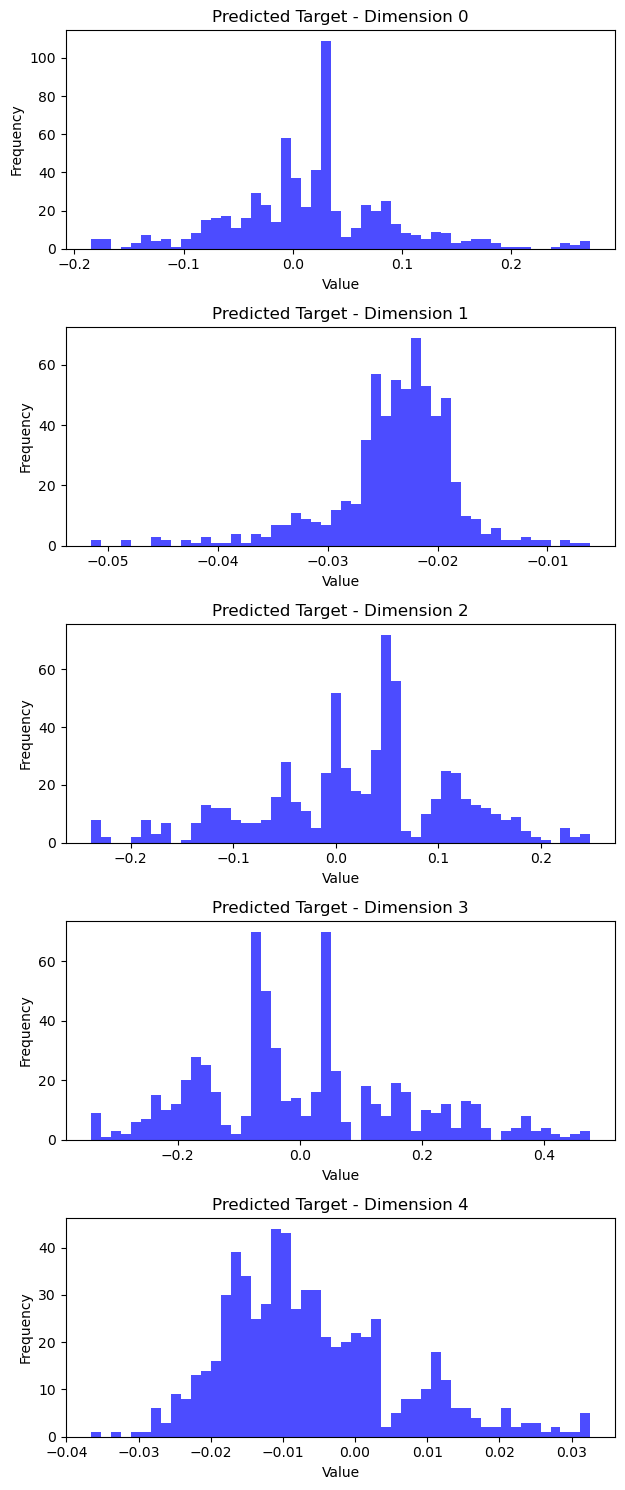

In [15]:
# Stack all predicted targets
predicted_targets = torch.cat(snf_predictor.prediction_net.debug_predicted_targets, dim=0)  # [num_samples, target_dim]
print(f"Predicted targets shape: {predicted_targets.shape}")

# Plot histogram for each dimension
num_dims = predicted_targets.shape[1]

plt.figure(figsize=(12, 3 * num_dims))

for dim in range(num_dims):
    plt.subplot(num_dims, 2, 2*dim + 2)
    plt.hist(predicted_targets[:, dim].cpu().numpy(), bins=50, alpha=0.7, color='blue')
    plt.title(f"Predicted Target - Dimension {dim}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [14]:
# Process the predictions
forecasts = list(forecast_it)
targets = list(ts_it)
evaluator = MultivariateEvaluator()
agg_metric, _ = evaluator(targets, forecasts)

/opt/conda/lib/python3.11/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 256it [00:00, 321.44it/s]
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
Running evaluation: 256it [00:00, 330.39it/s]
Running evaluation: 0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be rem

In [11]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3748036171651725
ND: 0.47961225223755605
NRMSE: 0.6273260731986486
MSE: 0.1059282181328893


In [8]:
#vox,mgif 8-16:0.125, vox 6-18:0.09
# Suppose forecasts_samples is your tensor: shape [150, 100, 14, 5]
# If numpy, you can also convert: forecasts_samples = torch.from_numpy(forecasts_samples)
kp = []
for forecast in forecasts:
    kp.append(forecast.samples)
forecasts_samples = np.array(kp)
forecasts_samples = torch.from_numpy(forecasts_samples)  # convert to torch.Tensor
# Step 1: reshape for easier looping
M = forecasts_samples.shape[1]  # 100
T = forecasts_samples.shape[2]  # 14
P = forecasts_samples.shape[3]  # 5

# Step 2: calculate pairwise L1 differences
# Expand dimensions for broadcasting
samples_i = forecasts_samples.unsqueeze(2)  # shape [150, 100, 1, 14, 5]
samples_j = forecasts_samples.unsqueeze(1)  # shape [150, 1, 100, 14, 5]

# Now compute all pairwise L1 distances
pairwise_diff = torch.abs(samples_i - samples_j)  # [150, 100, 100, 14, 5]

# Step 3: sum across (timesteps × dimensions)
sum_l1 = pairwise_diff.sum(dim=[-1, -2])  # [150, 100, 100]

# Step 4: take average over all pairs (i,j)
apd_per_series = sum_l1.mean(dim=[-1, -2])  # [150] (one APD per test series)

# Step 5: average over all 150 test series
APD = apd_per_series.mean().item()

print(f"APD: {APD:.6f}")

APD: 422.570862


In [9]:
kp = []
for forecast in forecasts:
    kp.append(forecast.samples)
forecasts_samples = np.array(kp)
forecasts_samples = torch.from_numpy(forecasts_samples)  # convert to torch.Tensor

# forecasts_samples: [150, 100, 14, 5]

# Step 1: Mean over the 100 samples
mean_forecasts = forecasts_samples.mean(dim=1)  # shape: [150, 14, 5]

# Step 2: Get ground truth into a tensor
# targets: is a list of 150 target arrays
targets_array = np.array([t.values for t in targets])  # shape: [150, 14, 5]
targets_tensor = torch.from_numpy(targets_array[:, -14:, :])

# Step 3: Compute MAE
mae = torch.mean(torch.abs(mean_forecasts - targets_tensor)).item()

print(f"MAE: {mae:.6f}")

MAE: 4.664017


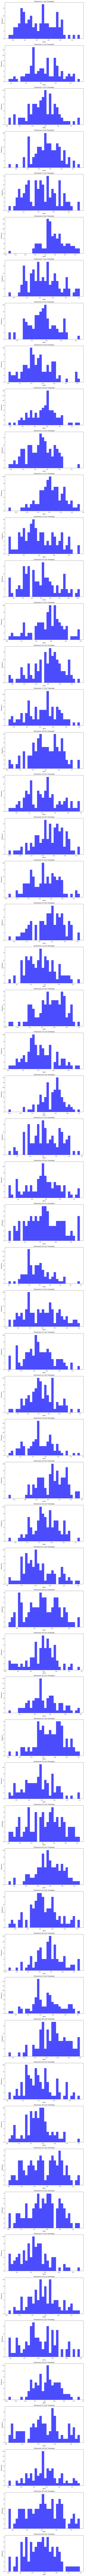

In [12]:
import matplotlib.pyplot as plt

# Assuming forecasts is a list of Forecast objects with a .samples attribute
# Extract the samples for the first series and the first timestep
first_series_forecast = forecasts[0].samples  # Shape: (num_samples, prediction_length, target_dim)
first_timestep_samples = first_series_forecast[:, 0, :]  # Extract first timestep samples across all dimensions

# Define the maximum number of dimensions to plot (e.g., plot all dimensions sequentially)
max_dimensions_to_plot = first_timestep_samples.shape[1]
# Determine the number of dimensions
num_dimensions = first_timestep_samples.shape[1]

# Plot histograms one below another

plt.figure(figsize=(10, 5 * max_dimensions_to_plot))

for dim in range(max_dimensions_to_plot):
    plt.subplot(max_dimensions_to_plot, 1, dim + 1)
    plt.hist(first_timestep_samples[:, dim], bins=30, alpha=0.7, color='blue')
    plt.title(f"Dimension {dim + 1} (1st Timestep)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

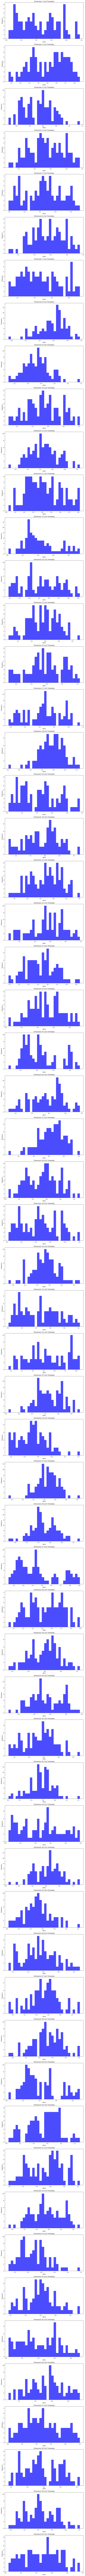

In [17]:
import matplotlib.pyplot as plt

# Assuming forecasts is a list of Forecast objects with a .samples attribute
# Extract the samples for the first series and the first timestep
first_series_forecast = forecasts[0].samples  # Shape: (num_samples, prediction_length, target_dim)
first_timestep_samples = first_series_forecast[:, 0, :]  # Extract first timestep samples across all dimensions

# Define the maximum number of dimensions to plot (e.g., plot all dimensions sequentially)
max_dimensions_to_plot = first_timestep_samples.shape[1]
# Determine the number of dimensions
num_dimensions = first_timestep_samples.shape[1]

# Plot histograms one below another

plt.figure(figsize=(10, 5 * max_dimensions_to_plot))

for dim in range(max_dimensions_to_plot):
    plt.subplot(max_dimensions_to_plot, 1, dim + 1)
    plt.hist(first_timestep_samples[:, dim], bins=30, alpha=0.7, color='blue')
    plt.title(f"Dimension {dim + 1} (1st Timestep)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [12]:
import numpy as np

# Assuming forecasts is a list of Forecast objects with .samples attribute
# Convert samples into a NumPy array for easier manipulation
num_series = len(forecasts)
num_samples, num_timesteps, num_dimensions = forecasts[0].samples.shape

# Initialize arrays for the 4 individual series
largest_series = np.zeros((num_series, num_timesteps, num_dimensions))
second_largest_series = np.zeros((num_series, num_timesteps, num_dimensions))
smallest_series = np.zeros((num_series, num_timesteps, num_dimensions))
second_smallest_series = np.zeros((num_series, num_timesteps, num_dimensions))

# Iterate over all series, timesteps, and dimensions
for series_idx, forecast in enumerate(forecasts):
    samples = forecast.samples  # Shape: (num_samples, num_timesteps, num_dimensions)
    
    for timestep in range(num_timesteps):
        for dim in range(num_dimensions):
            # Extract the 100 samples for the current series, timestep, and dimension
            sample_values = samples[:, timestep, dim]
            
            # Sort the samples to get the smallest and largest values
            sorted_values = np.sort(sample_values)
            
            # Assign the values to the respective series
            smallest_series[series_idx, timestep, dim] = sorted_values[0]  # Smallest
            second_smallest_series[series_idx, timestep, dim] = sorted_values[1]  # Second smallest
            largest_series[series_idx, timestep, dim] = sorted_values[-1]  # Largest
            second_largest_series[series_idx, timestep, dim] = sorted_values[-2]  # Second largest

# The selected_values array now contains the 2 min and 2 max values for each series, timestep, and dimension
smallest_series.shape

(529, 12, 60)

In [11]:
kp = []
for forecast in forecasts:
    kp.append(forecast.samples)
kp_array = np.array(kp)

In [12]:
#kp_array = kp_array.squeeze(1)
print(kp_array.shape)

(150, 100, 14, 5)


In [15]:
# Step 1: Collect all `.samples` into a list
forecast_samples_list = [forecast.samples for forecast in forecasts]

# Step 2: Convert the list to a single NumPy array
forecast_samples_array = np.array(forecast_samples_list)  # Shape: (n_forecasts, batch_size, n_features, n_timesteps)
print("Shape of forecast_samples_array:", forecast_samples_array.shape)

# Step 3: Expand `test_data_reshape` to add a new axis
expanded_all_series_test = np.expand_dims(all_series_test, axis=1)  # Shape: (529, 1, 12, 60)

# Step 4: Tile `expanded_all_series_test` to match the shape of `forecast_samples_array`
tiled_all_series_test = np.tile(expanded_all_series_test, (1, forecast_samples_array.shape[1], 1, 1))  # Shape: (529, 50, 12, 60)

# Step 5: Concatenate along the time axis
test_gt_pred = np.concatenate((tiled_all_series_test[:,:,:6], forecast_samples_array), axis=2)  # Shape: (529, 50, 24, 60)

print("Final Shape of test_gt_pred:", test_gt_pred.shape)

Shape of forecast_samples_array: (256, 100, 9, 60)
Final Shape of test_gt_pred: (256, 100, 15, 60)


In [16]:
import dcor

# Flatten the (24, 60) sequences to 1440-D vectors
gt_flat = all_series_test.reshape(256, -1)         # shape: (200, 1440)
pred_flat = test_gt_pred.reshape(-1, 15*60)    # shape: (200*100 = 20000, 1440)

# Compute energy distance between the full ground truth and predicted distributions
ed = dcor.energy_distance(gt_flat, pred_flat)

print("Energy Distance between ground truth and predicted keypoint distributions:", ed)

Energy Distance between ground truth and predicted keypoint distributions: 13.61450779693655


In [51]:
#vox#10-14:GRUNF-0.1917,GRUSNF-0.1795 #8-16:GRUNF-0.3296,0.2872 #6-18:GRUNF-0.3924,GRUSNF-0.3715
#bair#7-8:GRUNF-8.232,GRUSNF-7.3468, #6-9:GRUNF-14.9204,GRUSNF-13.6054, #5-10:GRUNF-82.7789,GRUSNF-80.9237
import numpy as np

# Assuming `forecasts` is a list of Forecast objects
lower_bounds = []
upper_bounds = []
predicted_means = []

for forecast in forecasts:
    # Extract samples (shape: num_samples x prediction_length)
    samples = forecast.samples

    # Calculate 5th and 95th percentiles for 90% prediction interval
    lower_bound = np.percentile(samples, 2.5, axis=0)  # 5th percentile
    upper_bound = np.percentile(samples, 97.5, axis=0)  # 95th percentile

    # Calculate mean prediction
    predicted_mean = samples.mean(axis=0)

    # Store results
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)
    predicted_means.append(predicted_mean)

In [11]:
pip install dcor

  Obtaining dependency information for dcor from https://files.pythonhosted.org/packages/45/f3/49770c523067d2179a600f236ea6d55f0a02909a424d055dbc50e04c4860/dcor-0.6-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 14.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [52]:
def calculate_picp(targets, lower_bounds, upper_bounds):
    in_interval = []
    for target, lower, upper in zip(targets, lower_bounds, upper_bounds):
        # Ensure the arrays are sliced correctly for 2D or 3D inputs
        target_values = target.values[:, -12:] if target.values.ndim == 3 else target.values[-12:]
        lower_sliced = lower[:, -12:] if lower.ndim == 3 else lower[-12:]
        upper_sliced = upper[:, -12:] if upper.ndim == 3 else upper[-12:]
        
        # Check if targets are within bounds
        interval = (lower_sliced <= target_values) & (target_values <= upper_sliced)
        in_interval.append(interval)
    
    # Calculate the overall coverage
    coverage = np.mean([np.mean(interval) for interval in in_interval])
    return coverage

# Calculate PICP
picp = calculate_picp(targets, lower_bounds, upper_bounds)
print(f"PICP: {picp * 100:.2f}%")

PICP: 73.91%


In [12]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.6667319863740226
ND: 0.7355227409410259
NRMSE: 0.8871614963943917
MSE: 0.5059817057730311


## unstandardization

In [18]:
# save num_batches for each video:
frames = 24
num_batch_video = []
num_full_batches_all = 0
for t,x in enumerate(kp_list_test_std):
    if x.shape[0] >= frames:
        num_full_batches = x.shape[0] // frames
        num_full_batches_all += num_full_batches
        num_batch_video.append(num_full_batches)
print(f'number of batches of each video:', len(num_batch_video))

number of batches of each video: 44


In [19]:
test_video_unstd_list = []

# Outer loop: Iterate over all videos
for video_idx in range(len(num_batch_video)):
    video_segments_list = []  # List to store 50 sets for the current video
    
    # Extract the segments for the current video
    start_idx = sum(num_batch_video[:video_idx])
    end_idx = sum(num_batch_video[:video_idx + 1])
    test_video = test_gt_pred[start_idx:end_idx]  # Shape: (num_segments, 50, 24, 60)
    
    # Inner loop: Process each of the 50 samples
    for sample_idx in range(test_video.shape[1]):  # 50 samples
        test_sample = test_video[:, sample_idx, :, :]  # Shape: (num_segments, 24, 60)
        
        # Unstandardize using the corresponding range and min
        test_sample_unstd = test_sample * range_list[video_idx] + min_list[video_idx]
        
        # Append the unstandardized sample to the current video's set list
        video_segments_list.append(test_sample_unstd)  # Shape: (num_segments, 24, 60)
    
    # Append the 50 sets for the current video to the main list
    test_video_unstd_list.append(video_segments_list)

# Final list structure:
# test_video_unstd_list[video_idx][sample_idx]: Shape (num_segments, 24, 60)
print(f"Total videos: {len(test_video_unstd_list)}")
print(f"First video has {len(test_video_unstd_list[0])} sets, each with shape {test_video_unstd_list[0][0].shape}")

Total videos: 44
First video has 100 sets, each with shape (2, 24, 60)


In [20]:
import pickle

# Save the test_gt_pred array as a .pkl file
with open("GRU-SNF_vox10-14_test_video_unstd_list_100_reduced_framerate_mcmc.pkl", "wb") as f:
    pickle.dump(test_video_unstd_list, f)

print("test_video_unstd_list has been saved as 'GRU-SNF_vox10-14_test_video_unstd_list_100_reduced_framerate_mcmc.pkl'.")

test_video_unstd_list has been saved as 'GRU-SNF_vox10-14_test_video_unstd_list_100_reduced_framerate_mcmc.pkl'.


In [18]:
mean_predictions = []

# Iterate over each series in forecasts
for forecast in forecasts:
    # Compute the mean across the sample axis (axis=0) for shape [12, 60]
    mean_forecast = forecast.samples.mean(axis=0)
    mean_predictions.append(mean_forecast)

# Convert to numpy array for convenience
mean_predictions = np.array(mean_predictions)
# first half of frames: groundtruth; last half of frames: predicted
test_gt_pred = np.concatenate((all_series_test[:,:5], mean_predictions), axis = 1)

test_gt_pred.shape

(256, 15, 60)

In [15]:
test_gt_pred = np.concatenate((all_series_test[:,:12], kp_array), axis = 1)

test_gt_pred.shape

NameError: name 'kp_array' is not defined

In [20]:
test_gt_pred = np.concatenate((all_series_test[:,:12], test_gt_pred[:,12:]), axis = 1)

test_gt_pred.shape

(529, 24, 60)

In [20]:
test_gt_pred_small = np.concatenate((all_series_test[:,:12], smallest_series), axis = 1)

test_gt_pred_small.shape

(529, 24, 60)

In [14]:
test_gt_pred_secondsmall = np.concatenate((all_series_test[:,:12], second_smallest_series), axis = 1)

test_gt_pred_secondsmall.shape

(529, 24, 60)

In [19]:
test_gt_pred_large = np.concatenate((all_series_test[:,:12], largest_series), axis = 1)

test_gt_pred_large.shape

(529, 24, 60)

In [23]:
test_gt_pred_secondlarge = np.concatenate((all_series_test[:,:12], second_largest_series), axis = 1)

test_gt_pred_secondlarge.shape

(529, 24, 60)

In [19]:
# unstd for each video:
test_video_unstd_list = []
for video_idx in range(len(num_batch_video)):
    test_video = test_gt_pred[sum(num_batch_video[:video_idx]):sum(num_batch_video[:video_idx+1])]
    test_video_unstd = test_video * range_list[video_idx] + min_list[video_idx]
    test_video_unstd_list.append(test_video_unstd) # unstd video keypoints

In [16]:
# unstd for each video:
test_video_unstd_list_secondsmallest = []
for video_idx in range(len(num_batch_video)):
    test_video = test_gt_pred_secondsmall[sum(num_batch_video[:video_idx]):sum(num_batch_video[:video_idx+1])]
    test_video_unstd = test_video * range_list[video_idx] + min_list[video_idx]
    test_video_unstd_list_secondsmallest.append(test_video_unstd) # unstd video keypoints

In [20]:
# unstd for each video:
test_video_unstd_list_largest = []
for video_idx in range(len(num_batch_video)):
    test_video = test_gt_pred_large[sum(num_batch_video[:video_idx]):sum(num_batch_video[:video_idx+1])]
    test_video_unstd = test_video * range_list[video_idx] + min_list[video_idx]
    test_video_unstd_list_largest.append(test_video_unstd) # unstd video keypoints

In [24]:
# unstd for each video:
test_video_unstd_list_secondlargest = []
for video_idx in range(len(num_batch_video)):
    test_video = test_gt_pred_secondlarge[sum(num_batch_video[:video_idx]):sum(num_batch_video[:video_idx+1])]
    test_video_unstd = test_video * range_list[video_idx] + min_list[video_idx]
    test_video_unstd_list_secondlargest.append(test_video_unstd) # unstd video keypoints

In [10]:
import pickle

# Path to the .pkl file
file_path = "GRU-NF_vox12-12_test_video_unstd_list_100.pkl"

# Load the .pkl file
with open(file_path, 'rb') as file:
    test_video_unstd_list = pickle.load(file)

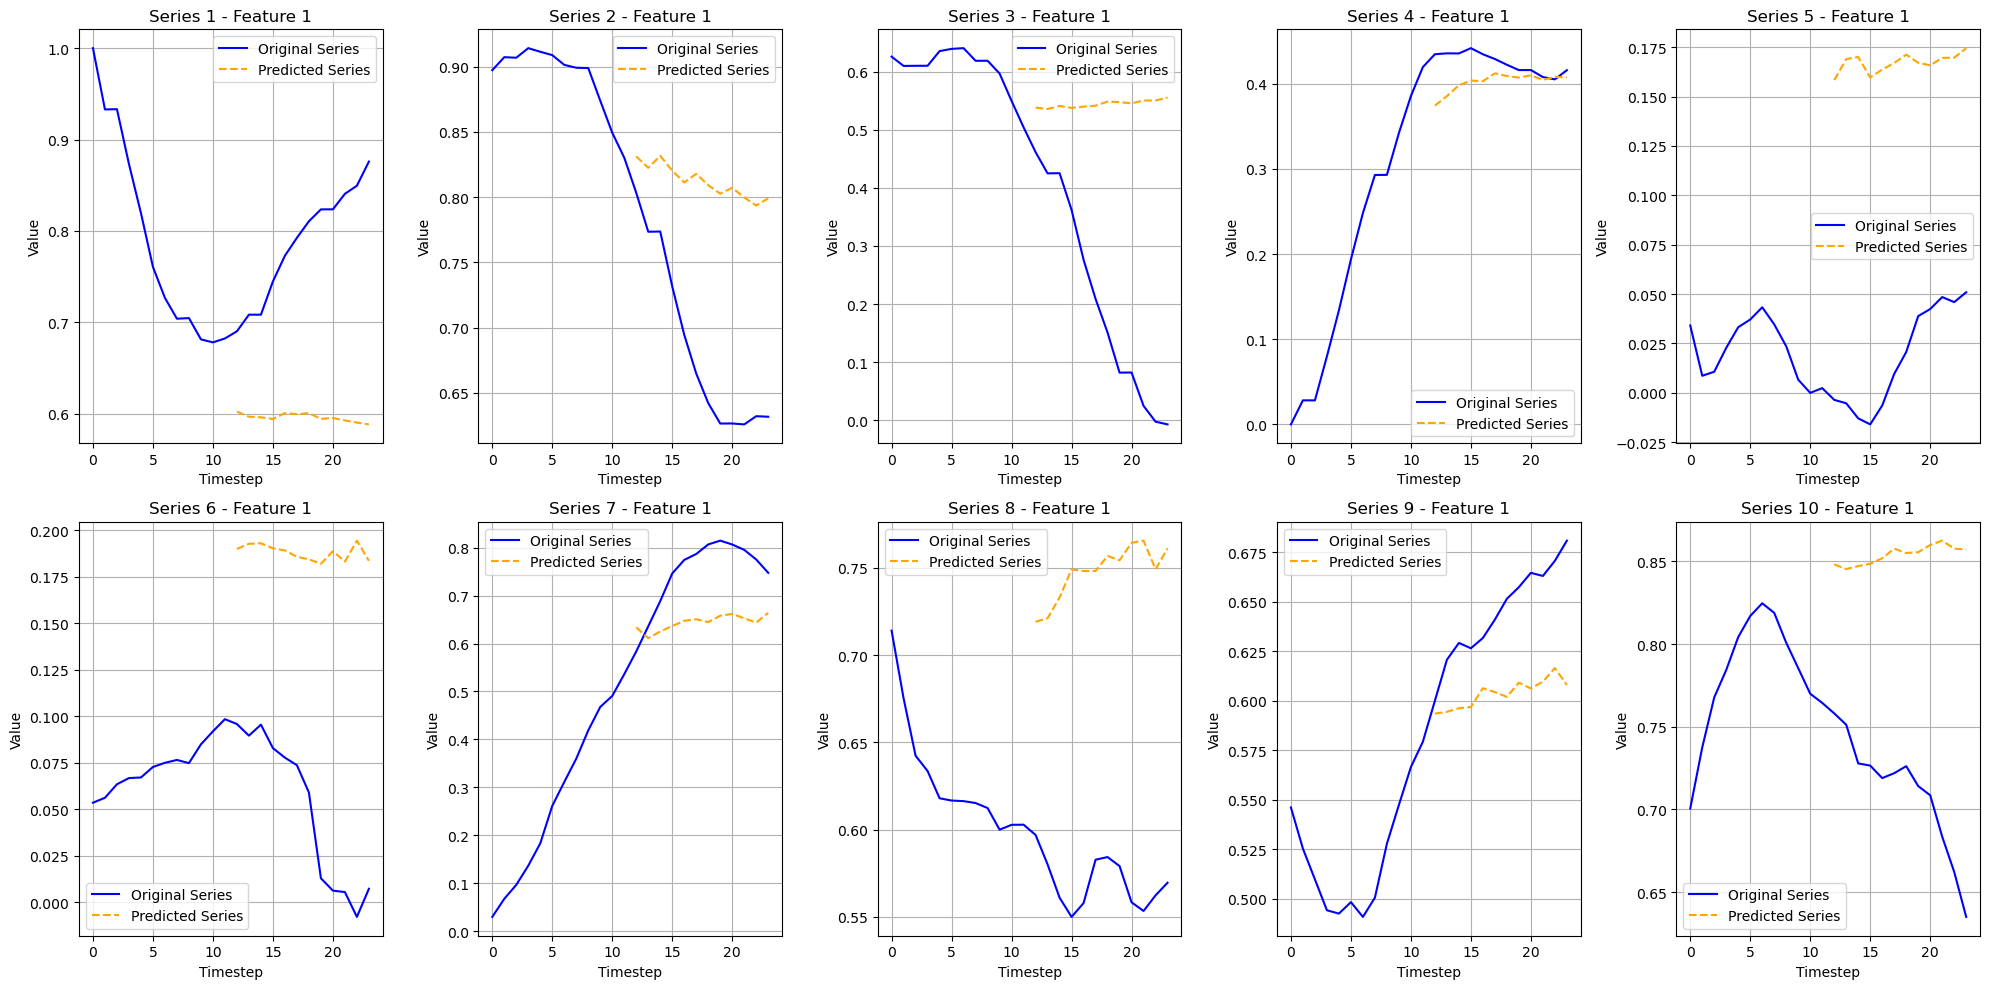

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Example variables
# all_series_test: [529, 24, 60]
# predictions_test: [529, 12, 60]

# Set the feature index to plot
feature_idx = 0  # First feature

# Number of series to plot
num_series_to_plot = 10

# Create a 2-row grid with 5 plots in each row
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through the first `num_series_to_plot` series
for series_idx in range(num_series_to_plot):
    # Extract the specific series for the current index
    original_series = all_series_test[series_idx, :, feature_idx]  # Shape: [24]
    predicted_series = mean_predictions[series_idx, :, feature_idx]  # Shape: [12]

    # Generate x-axis indices
    x_original = np.arange(len(original_series))  # [0, 1, ..., 23]
    x_predicted = np.arange(12, 24)  # [12, 13, ..., 23]

    # Select the subplot
    ax = axes[series_idx]

    # Plot the original series
    ax.plot(x_original, original_series, label='Original Series', color='blue')
    
    # Plot the predicted series starting from index 12
    ax.plot(x_predicted, predicted_series, label='Predicted Series', color='orange', linestyle='--')
    
    # Add labels, title, and legend
    ax.set_title(f"Series {series_idx + 1} - Feature {feature_idx + 1}")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

# Remove empty subplots (if any)
for i in range(num_series_to_plot, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Optical flow and generator

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

config="config/abs-bair.yml"

# Test dataset
with open(config) as f:
    config = yaml.safe_load(f)
dataset = FramesDataset(is_train=(False), **config['dataset_params'],mode="RNN") # test

# dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

testSort = sorted(dataset, key=lambda x: x['name'])
dataloader = DataLoader(testSort, batch_size=1, shuffle=False, num_workers=1)

### call the functions        
generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                            **config['model_params']['common_params'])

log_dir="./log/test-reconstruction-bair"
checkpoint="./Training_Prediction/FOMM/Trained_Models/bair-cpk.pth.tar"

if checkpoint is not None:
    Logger.load_cpk(checkpoint, generator=generator, kp_detector=kp_detector)
else:
    raise AttributeError("Checkpoint should be specified for mode='reconstruction'.")
    
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

png_dir = os.path.join(log_dir, 'prediction/png')
log_dir = os.path.join(log_dir, 'prediction/trial')

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(png_dir):
    os.makedirs(png_dir)

if torch.cuda.is_available():
    generator = DataParallelWithCallback(generator)
    kp_detector = DataParallelWithCallback(kp_detector)

generator.eval()
kp_detector.eval()

prediction_params = config['prediction_params']

num_epochs = prediction_params['num_epochs']
lr = prediction_params['lr']
bs = prediction_params['batch_size']
num_frames = prediction_params['num_frames']
loss_list_total = []
fvd_list_total = []

Using predefined train-test split.
Using videos from test directory
['000000.mp4', '000001.mp4', '000002.mp4', '000003.mp4', '000004.mp4', '000005.mp4', '000006.mp4', '000007.mp4', '000008.mp4', '000009.mp4', '000010.mp4', '000011.mp4', '000012.mp4', '000013.mp4', '000014.mp4', '000015.mp4', '000016.mp4', '000017.mp4', '000018.mp4', '000019.mp4', '000020.mp4', '000021.mp4', '000022.mp4', '000023.mp4', '000024.mp4', '000025.mp4', '000026.mp4', '000027.mp4', '000028.mp4', '000029.mp4', '000030.mp4', '000031.mp4', '000032.mp4', '000033.mp4', '000034.mp4', '000035.mp4', '000036.mp4', '000037.mp4', '000038.mp4', '000039.mp4', '000040.mp4', '000041.mp4', '000042.mp4', '000043.mp4', '000044.mp4', '000045.mp4', '000046.mp4', '000047.mp4', '000048.mp4', '000049.mp4', '000050.mp4', '000051.mp4', '000052.mp4', '000053.mp4', '000054.mp4', '000055.mp4', '000056.mp4', '000057.mp4', '000058.mp4', '000059.mp4', '000060.mp4', '000061.mp4', '000062.mp4', '000063.mp4', '000064.mp4', '000065.mp4', '000066

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [21]:
from tqdm import tqdm
for it, x in tqdm(enumerate(dataloader)):
    if config['reconstruction_params']['num_videos'] is not None:
        if it > config['reconstruction_params']['num_videos']:
            break
        with torch.no_grad():
            predictions = []
            visualizations = []

            ######## keypoints ########
            kp_driving_video = test_video_unstd_list[it].reshape(-1,10,6)
            kp_driving_video = torch.tensor(kp_driving_video)
            kp_source = {"value":kp_driving_video[0,:,:2].reshape(1,10,2).to(device),"jacobian":kp_driving_video[0,:,2:].reshape(1,10,2,2).to(device)} # kp of the ith frame      
        
        ##### Start generator
        loss_list = []
        fvd_list = []
        for i in range(((x['video'].shape[2])//frames)*frames): # cut the last <24 frames
            source = x['video'][:, :, 0].to(device)
            driving = x['video'][:, :, i].to(device)
            kp_driving = {"value":kp_driving_video[i,:,:2],"jacobian":kp_driving_video[i,:,2:]} # kp of the ith frame
            kp_driving['value'] = kp_driving['value'].reshape(1,10,2)
            kp_driving['jacobian'] = kp_driving['jacobian'].reshape(1,10,2,2)
            kp_driving['value'] = kp_driving['value'].float().to(device)
            kp_driving['jacobian'] = kp_driving['jacobian'].float().to(device)
            source = source.float()
            # Convert all tensors in kp_source dictionary to float
            kp_source = {key: value.float() for key, value in kp_source.items()}
            generator = generator.float().to(device)
            out = generator(source, kp_source=kp_source, kp_driving=kp_driving)
            out['kp_source'] = kp_source
            out['kp_driving'] = kp_driving
            del out['sparse_deformed']
            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
            visualization = Visualizer(**config['visualizer_params']).visualize(source=source,
                                                                                    driving=driving, out=out)
            visualizations.append(visualization)
            # mse loss
            if np.abs(out['prediction'].detach().cpu().numpy() - driving.cpu().numpy()).mean() != 0:
                loss_list.append(np.abs(out['prediction'].detach().cpu().numpy() - driving.cpu().numpy()).mean())
                # Calculate FVD for each frame using ground truth and predicted videos
                # ground_truth_features = driving.detach().cpu().permute(0,2,3,1).reshape(256,256,3)
                # predicted_features = out['prediction'].detach().cpu().permute(0,2,3,1).reshape(256,256,3)
                # fvd_list.append(compute_fvd(ground_truth_features, predicted_features))

        print("Reconstruction loss: %s" % np.mean(loss_list))
        loss_list_total.append(np.mean(loss_list))

        # print("FVD Score: %s" % np.mean(fvd_list))
        # fvd_list_total.append(np.mean(fvd_list))

        predictions = np.concatenate(predictions, axis=1)
        imageio.imsave(os.path.join(png_dir, x['name'][0] + '.png'), (255 * predictions).astype(np.uint8))
        image_name = x['name'][0] + config['reconstruction_params']['format']
        imageio.mimsave(os.path.join(log_dir, image_name), visualizations)

print("mean Reconstruction loss: %s" % np.mean(loss_list_total)) 
#print("mean FVD score: %s" % np.mean(fvd_list_total))

0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/jovyan/srinjoy-vol/Tasmiah_files/Motion-Transfer-Keypoints-Prediction/Keypoints_Prediction/Training_Prediction/FOMM/Source_Model/logger.py:111: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = circle(kp[1], kp[0], self.kp_size, shape=image.shape[:2])


Reconstruction loss: 0.08882213


1it [00:01,  1.24s/it]

Reconstruction loss: 0.076904416


2it [00:02,  1.00it/s]

Reconstruction loss: 0.07377996


3it [00:02,  1.10it/s]

Reconstruction loss: 0.11876508


4it [00:03,  1.03it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

for it, x in tqdm(enumerate(dataloader)):
    if config['reconstruction_params']['num_videos'] is not None:
        if it > config['reconstruction_params']['num_videos']:
            break
        
        with torch.no_grad():
            ######## keypoints ########
            kp_driving_video = test_video_unstd_list[it].reshape(-1, 10, 6)
            kp_driving_video = torch.tensor(kp_driving_video)
            kp_source = {
                "value": kp_driving_video[0, :, :2].reshape(1, 10, 2),
                "jacobian": kp_driving_video[0, :, 2:].reshape(1, 10, 2, 2)
            }
        
        ##### Start generator
        loss_list = []
        fvd_list = []

        for i in range(((x['video'].shape[2]) // frames) * frames):  # Cut the last <frames
            source = x['video'][:, :, 0]
            driving = x['video'][:, :, i]
            kp_driving = {
                "value": kp_driving_video[i, :, :2].reshape(1, 10, 2).float(),
                "jacobian": kp_driving_video[i, :, 2:].reshape(1, 10, 2, 2).float()
            }
            source = source.float()
            kp_source = {key: value.float() for key, value in kp_source.items()}
            generator = generator.float()
            out = generator(source, kp_source=kp_source, kp_driving=kp_driving)
            
            # mse loss
            loss = np.abs(out['prediction'].detach().cpu().numpy() - driving.cpu().numpy()).mean()
            if loss != 0:
                loss_list.append(loss)
                # Calculate FVD for each frame using ground truth and predicted videos
                ground_truth_features = driving.detach().cpu().permute(0, 2, 3, 1).reshape(256, 256, 3)
                predicted_features = out['prediction'].detach().cpu().permute(0, 2, 3, 1).reshape(256, 256, 3)
                fvd_list.append(compute_fvd(ground_truth_features, predicted_features))

        print("Reconstruction loss: %s" % np.mean(loss_list))
        loss_list_total.append(np.mean(loss_list))

        print("FVD Score: %s" % np.mean(fvd_list))
        fvd_list_total.append(np.mean(fvd_list))

print("Mean Reconstruction loss: %s" % np.mean(loss_list_total))
print("Mean FVD score: %s" % np.mean(fvd_list_total))

0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
1it [08:08, 488.51s/it]

Reconstruction loss: 0.060793225
FVD Score: 5.798258837801896


In [ ]:
#smallest
Reconstruction loss: 0.102151014
FVD Score: 14.306458193389036
1it [06:32, 392.10s/it]
Reconstruction loss: 0.079924576
FVD Score: 5.311903087322375
2it [29:25, 969.60s/it]
Reconstruction loss: 0.08719507
FVD Score: 6.127427738313241
#largest
0it [00:00, ?it/s]
Reconstruction loss: 0.10412177
FVD Score: 15.336639273556171
1it [06:26, 386.40s/it]
Reconstruction loss: 0.07573272
FVD Score: 4.2561985620351255
2it [29:06, 958.99s/it]
Reconstruction loss: 0.08340885
FVD Score: 4.825017700597119
#mean
Reconstruction loss: 0.06829068
FVD Score: 6.848362108950194
#onlymean
Reconstruction loss: 0.060702685
FVD Score: 5.647475994135285

In [12]:
import numpy as np

# List to store the reduced keypoints
reduced_forecasts = []

# Step 1: Loop through each forecast series
for i, forecast in enumerate(forecasts):
    samples = forecast.samples  # Shape: (100, 12, 60)
    
    # Compute the median along the sample axis (axis=0)
    median_values = np.median(samples, axis=0, keepdims=True)  # Shape: (1, 12, 60)

    # Step 2: Calculate the absolute differences from the median
    abs_diff = np.abs(samples - median_values)  # Shape: (100, 12, 60)

    # Step 3: Sort by proximity to the median
    sorted_indices = np.argsort(abs_diff, axis=0)  # Shape: (100, 12, 60)
    
    # Step 4: Select 25 closest samples on both sides
    closest_indices = sorted_indices[:50, :, :]  # Shape: (50, 12, 60)

    # Gather the closest samples to the median
    reduced_samples = np.take_along_axis(samples, closest_indices, axis=0)  # Shape: (50, 12, 60)
    
    # Append the reduced samples to the list
    reduced_forecasts.append(reduced_samples)

# Optional: Convert the list to a NumPy array
reduced_forecasts_array = np.array(reduced_forecasts)  # Shape: (529, 50, 12, 60)

print(f"Shape of reduced_forecasts_array: {reduced_forecasts_array.shape}")

Shape of reduced_forecasts_array: (529, 50, 12, 60)


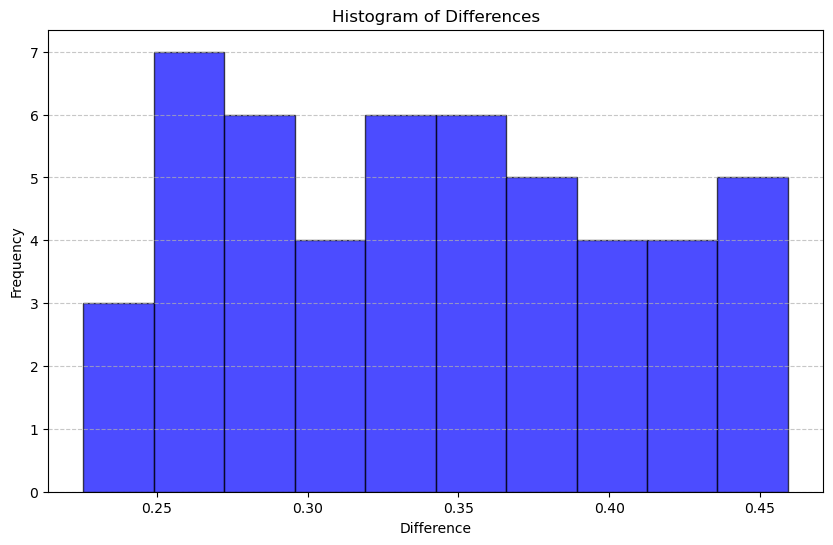

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming `targets` is a list with 529 elements, each of shape (24, 60)
# And `reduced_forecasts_array` has shape (529, 50, 24, 60)

# Step 1: Extract the last 12 timesteps from `targets` for the first series
target_series = np.array(targets)  # Convert list to NumPy array for easier handling
target_values = target_series[:, -12:, :]  # Shape: (529, 12, 60)

# Step 2: Extract the corresponding samples from `reduced_forecasts_array`
# For the first series, first timestep, and first feature
target_value = target_values[0, 0, 1]  # First series, first timestep, first feature
samples_to_compare = reduced_forecasts_array[0, :, 0, 1]  # Shape: (50,)

# Step 3: Compute differences
differences = np.abs(samples_to_compare - target_value)

# Step 4: Plot the histogram of differences
plt.figure(figsize=(10, 6))
plt.hist(differences, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
####### call the config functions and inference dataloader #########

config="config/abs-vox.yml"

# Test dataset
with open(config) as f:
    config = yaml.safe_load(f)
dataset1 = FramesDataset_transfer(is_train=(False), **config['dataset_params'],mode="RNN") # test: driving videos
print(len(dataset1))
dataloader1 = DataLoader(dataset1, batch_size=1, shuffle=False, num_workers=1)

dataset2 = FramesDataset_transfer(is_train=(True), **config['dataset_params'],mode="VRNN") # test_source: source videos
print(len(dataset2))
dataloader2 = DataLoader(dataset2, batch_size=1, shuffle=False, num_workers=1)

dataset3 = FramesDataset_transfer(is_train=(False), **config['dataset_params'],mode="VRNN") # test_recon: reference videos(only FOMM, no keypoints prediction)
print(len(dataset3))
# Exclude '.ipynb_checkpoints'
filtered_dataset = []

# Iterate through the dataset
for idx in range(len(dataset3)):
    item = dataset3[idx]
    # Add to filtered list if it's not '.ipynb_checkpoints'
    if item != '.ipynb_checkpoints':
        filtered_dataset.append(item)

print(f"Filtered dataset size: {len(filtered_dataset)}")
dataloader3 = DataLoader(dataset3, batch_size=1, shuffle=False, num_workers=1)

### call the functions        
generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                            **config['model_params']['common_params'])
log_dir="./log/test-reconstruction-vox"
checkpoint="./Training_Prediction/FOMM/Trained_Models/vox-cpk.pth.tar"

if checkpoint is not None:
    Logger.load_cpk(checkpoint, generator=generator, kp_detector=kp_detector)
else:
    raise AttributeError("Checkpoint should be specified for mode='reconstruction'.")
    
def save_obj(obj, name ):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

png_dir = os.path.join(log_dir, 'prediction/png')
log_dir = os.path.join(log_dir, 'prediction/trial')

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(png_dir):
    os.makedirs(png_dir)

if torch.cuda.is_available():
    generator = DataParallelWithCallback(generator)
    kp_detector = DataParallelWithCallback(kp_detector)

generator.eval()
kp_detector.eval()

prediction_params = config['prediction_params']

num_epochs = prediction_params['num_epochs']
lr = prediction_params['lr']
bs = prediction_params['batch_size']
num_frames = prediction_params['num_frames']
loss_list_total = []
fvd_list_total = []
frames=24

Use predefined train-test split.
Using videos from test directory
['id10280#NXjT3732Ekg#001093#001192.mp4', 'id10281#NHARUN9OhSo#000605#000886.mp4', 'id10281#NHARUN9OhSo#001059#001210.mp4', 'id10281#NHARUN9OhSo#002098#002175.mp4', 'id10281#NHARUN9OhSo#002209#002570.mp4', 'id10281#NHARUN9OhSo#006609#006906.mp4', 'id10281#NHARUN9OhSo#006912#007284.mp4', 'id10281#NHARUN9OhSo#007425#007663.mp4', 'id10282#IDA_ElNHLn4#000674#000852.mp4', 'id10282#IDA_ElNHLn4#001226#001390.mp4', 'id10283#N69Hp2DGMLk#000519#000619.mp4', 'id10283#N69Hp2DGMLk#000721#000842.mp4', 'id10283#N69Hp2DGMLk#000893#001589.mp4', 'id10283#N69Hp2DGMLk#004133#005157.mp4', 'id10283#N69Hp2DGMLk#005157#005316.mp4', 'id10283#N69Hp2DGMLk#005931#006184.mp4', 'id10283#N69Hp2DGMLk#006184#006353.mp4', 'id10283#N69Hp2DGMLk#006405#006583.mp4', 'id10283#N69Hp2DGMLk#006600#007118.mp4', 'id10283#N69Hp2DGMLk#007129#007281.mp4', 'id10283#r9-0pljhZqs#002414#002769.mp4', 'id10283#r9-0pljhZqs#003725#003847.mp4', 'id10283#r9-0pljhZqs#004062#004

OSError: image file is truncated

In [ ]:
#########  FOMM+RNN ########

for it, x in tqdm(enumerate(dataloader1)):
    if it==43:
        if config['reconstruction_params']['num_videos'] is not None:
            if it > config['reconstruction_params']['num_videos']:
                break
        with torch.no_grad():
            predictions = []
            visualizations = []

            ######## keypoints ########
            kp_driving_video = test_video_unstd_list[it].reshape(-1,10,6) #test_video_unstd_list[it].reshape(-1,10,6) 
            kp_driving_video = torch.tensor(kp_driving_video)
            kp_source = {"value":torch.tensor(kp_list_test2[it][0]).reshape(10,6)[:,:2],"jacobian":torch.tensor(kp_list_test2[it][0]).reshape(10,6)[:,2:].reshape(1,10,2,2)} # kp of the ith frame      
        
        ##### Start generator
        loss_list = []
        fvd_list = []
        for i in range(((x['video'].shape[2])//frames)*frames): # cut the last <24 frames
            driving = x['video'][:, :, i]
            source = torch.tensor(dataset2[it]['video'][:,0]).reshape(1,3,256,256) # source frame from set2 
            driving_reference = torch.tensor(dataset3[it]['video'][:,i]).reshape(1,3,256,256)
            kp_driving = {"value":kp_driving_video[i,:,:2],"jacobian":kp_driving_video[i,:,2:]} # kp of the ith frame
            kp_driving['value'] = kp_driving['value'].reshape(1,10,2)
            kp_driving['jacobian'] = kp_driving['jacobian'].reshape(1,10,2,2)
            out = generator(source, kp_source=kp_source, kp_driving=kp_driving)
            out['kp_source'] = kp_source
            out['kp_driving'] = kp_driving
            del out['sparse_deformed']
            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])

            visualization = Visualizer(**config['visualizer_params']).visualize(source=source,
                                                                                    driving=driving, out=out)
            visualizations.append(visualization) #visualizations[0].shape: (256, 1280, 3)
            # mse loss
            if np.abs(out['prediction'].detach().cpu().numpy() - driving_reference.cpu().numpy()).mean() != 0:
                loss_list.append(np.abs(out['prediction'].detach().cpu().numpy() - driving_reference.cpu().numpy()).mean())
                # Calculate FVD for each frame using ground truth and predicted videos
                ground_truth_features = driving_reference.detach().cpu().permute(0,2,3,1).reshape(256,256,3)
                predicted_features = out['prediction'].detach().cpu().permute(0,2,3,1).reshape(256,256,3)
                fvd_list.append(compute_fvd(ground_truth_features, predicted_features))

        print("Reconstruction loss: %s" % np.mean(loss_list))
        loss_list_total.append(np.mean(loss_list))
        
        print("FVD Score: %s" % np.mean(fvd_list))
        fvd_list_total.append(np.mean(fvd_list))

        predictions = np.concatenate(predictions, axis=1)
        imageio.imsave(os.path.join(png_dir, x['name'][0] + '.png'), (255 * predictions).astype(np.uint8))
        image_name = x['name'][0] + config['reconstruction_params']['format']
        imageio.mimsave(os.path.join(log_dir, image_name), visualizations)

print("mean Reconstruction loss: %s" % np.mean(loss_list_total)) 
print("mean FVD score: %s" % np.mean(fvd_list_total))

In [12]:
# Recreate the model with the same architecture
estimator = TempFlowEstimator(
    target_dim=60,
    prediction_length=12,
    cell_type='GRU',
    num_layers=3,
    num_cells=2048,
    flow_type="RealNVP",
    hidden_size=2048,
    n_hidden=3,
    conditioning_length=12,
    dropout_rate=0.2,
    input_size=60,
    context_length=12,
    freq="1s",
    scaling=False,
    n_blocks=12,
    trainer=Trainer(device=device,
                    epochs=100,
                    learning_rate=1e-4,
                    #num_batches_per_epoch=100,
                    batch_size=64)  # dummy trainer, won't be used
)

# Now extract the model from the estimator
trained_model = estimator.create_training_network(device=device)

# Load the weights into the model (this works only if you saved state_dict)
trained_model.load_state_dict(torch.load("Checkpoints/GRU-NF_3883videos_vox_12-12_kashif.pth"))
trained_model.eval()

TypeError: Expected state_dict to be dict-like, got <class 'gluonts.torch.model.predictor.PyTorchPredictor'>.

In [13]:
print(dir(predictor))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__version__', '__weakref__', 'batch_size', 'derive_auto_fields', 'deserialize', 'device', 'forecast_generator', 'freq', 'from_hyperparameters', 'from_inputs', 'input_names', 'input_transform', 'lead_time', 'output_transform', 'predict', 'prediction_length', 'prediction_net', 'serialize', 'to']


In [3]:
model = predictor.prediction_net  # or predictor.model or similar
print(model)

TempFlowPredictionNetwork(
  (rnn): GRU(60, 512, num_layers=3, batch_first=True, dropout=0.2)
  (flow): RealNVP(
    (net): FlowSequential(
      (0): LinearMaskedCoupling(
        (s_net): Sequential(
          (0): Linear(in_features=61, out_features=512, bias=True)
          (1): Tanh()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): Tanh()
          (4): Linear(in_features=512, out_features=512, bias=True)
          (5): Tanh()
          (6): Linear(in_features=512, out_features=512, bias=True)
          (7): Tanh()
          (8): Linear(in_features=512, out_features=60, bias=True)
        )
        (t_net): Sequential(
          (0): Linear(in_features=61, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): ReLU()
          (4): Linear(in_features=512, out_features=512, bias=True)
          (5): ReLU()
          (6): Linear(in_features=512, out_features=512, bias=Tr

In [16]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 372,022,092
Trainable parameters: 372,022,092


In [17]:
pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for yacs>=0.1.6 from https://files.pythonhosted.org/packages/38/4f/fe9a4d472aa867878ce3bb7efb16654c5d63672b86dc0e6e953a67018433/yacs-0.1.8-py3-none-any.whl.metadata
  Obtaining dependency information for tabulate from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/f7/60/1974cfdd5bb770568ddc6f89f3e0df4cfdd1acffd5a609dff5e95f48c6e2/portalocker-3.1.1-py3-none-any.whl.metadata
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=291c3ee52942015a4c55f0a57b0d45d29f8cf6ecf1a7acc0212

In [21]:
from fvcore.nn import FlopCountAnalysis
input_tensor = torch.randn(64, 12, 60)  # batch=1, context_length=12, input_dim=60

# Create dummy inputs
batch_size = 1
context_length = 12
input_dim = 60

# Float tensor for past target
past_target_cdf = torch.randn(batch_size, context_length, input_dim)

# Binary mask: all values are observed
past_observed_values = torch.ones(batch_size, context_length, input_dim)

# Padding mask: all zeros (no padding)
past_is_pad = torch.zeros(batch_size, context_length, input_dim)
# Ensure all are float tensors
past_target_cdf = past_target_cdf.float()
past_observed_values = past_observed_values.float()
past_is_pad = past_is_pad.float()

# Wrap inputs in tuple
inputs = (past_target_cdf, past_observed_values, past_is_pad)

# Now pass to FLOPs analyzer
flops = FlopCountAnalysis(model, inputs)
print(f"Total FLOPs: {flops.total():,}")
print(f"Total FLOPs per forward pass (in TFLOPs): {flops.total() / 1e12:.6f}")

TypeError: TempFlowPredictionNetwork.forward() missing 1 required positional argument: 'past_is_pad'

In [33]:
import torch
import torch.profiler

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = predictor.prediction_net.to(device)
model.eval()

# Dummy input dimensions
batch_size = 1
context_length = 12
input_dim = 60

# Create all required inputs
target_dimension_indicator = torch.zeros(batch_size, input_dim).to(device)
past_target_cdf = torch.randn(batch_size, context_length, input_dim).to(device)
past_observed_values = torch.ones_like(past_target_cdf)
past_is_pad = torch.zeros(batch_size, context_length, 1).to(device)

# Run profiler
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
    ],
    record_shapes=True,
    with_flops=True,
    profile_memory=True
) as prof:
    with torch.no_grad():
        _ = model(target_dimension_indicator, past_target_cdf, past_observed_values, past_is_pad)

# Print top 10 operations sorted by FLOPs
print(prof.key_averages().table(sort_by="flops", row_limit=10))

STAGE:2025-03-31 20:28:26 612:612 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2025-03-31 20:28:50 612:612 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2025-03-31 20:28:52 612:612 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::addmm        22.63%        3.342s        33.85%        4.998s      34.704us        2.411s        69.04%        2.558s      17.761us           0 

In [29]:
import inspect
print(inspect.signature(model.forward))

(target_dimension_indicator: torch.Tensor, past_target_cdf: torch.Tensor, past_observed_values: torch.Tensor, past_is_pad: torch.Tensor) -> torch.Tensor


In [35]:
batch_size = 64
context_length = 12
input_dim = 60

target_dimension_indicator = torch.zeros(batch_size, input_dim).to(device)
past_target_cdf = torch.randn(batch_size, context_length, input_dim).to(device)
past_observed_values = torch.ones_like(past_target_cdf)

# ✅ Expand past_is_pad to match the last dim (60)
past_is_pad = torch.zeros(batch_size, context_length).to(device)

# Then profile as usual
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
    ],
    record_shapes=True,
    with_flops=True,
    profile_memory=True
) as prof:
    with torch.no_grad():
        _ = model(target_dimension_indicator, past_target_cdf, past_observed_values, past_is_pad)

print(prof.key_averages().table(sort_by="flops", row_limit=10))

STAGE:2025-03-31 20:39:01 612:612 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2025-03-31 20:39:26 612:612 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2025-03-31 20:39:27 612:612 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Total MFLOPs  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::addmm        22.82%        3.393s        34.01%        5.058s      35.123us        5.630s        82.10%        5.630s      39.091us           0 